# Project overview

The main objective of this project is to perform sentimental analysis on movie review data. The Notebook is run on the scheduling notenook using Google cloud platform.

- Data:
    - For the sentiment analysis task, the dataset used is IMDB data in CSV file format. The dataset contains two columns:
        - "review": A long text representing movie reviews.
        - "sentiment": A label indicating whether the review is "positive" or "negative."

- Data Preprocessing:
    - During data preprocessing, a few regex substitutions were applied to clean the text data:
        - Replaced equal signs "=" with a space " ".
        - Replaced HTML "<br />" tags with a space " ".
        - Collapsed one or more consecutive periods (dots) into a single period.
        - Replaced one or more consecutive exclamation marks with a space " ".
        - Replaced one or more consecutive question marks with a space " ".
        - Collapsed one or more consecutive whitespace characters (spaces, tabs, etc.) into a single space.

- Model:
  
    - In the modeling part, the pre-trained DistilBert model was chosen. To adapt it for the specific classification task, a custom classification layer was applied.

## Imports

In [2]:
import json
import logging
import time
from typing import Any, Dict, Iterable, List, Tuple
import re
import os
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import yaml
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.python.lib.io import file_io
import tempfile
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
logger = logging.getLogger(__name__)

## Constant

In [3]:
BUCKET = "temp-bucket"
BUCKET_PATH = f"gs://{BUCKET}"
COMMON_PATH = "temp"
TRAINING_DATA_DIR = "model_artifacts"
CONFIG = "config"
ENV = "dev" 


# Constants used in different modules
DATASET_TRAIN_FILENAME = "IMDB_Dataset.csv"
FEATURE_NAME = "review"
CLEANED_FEATURE_NAME = "cleaned_review"
LABEL_NAME = "sentiment"
DATA = "data"
VAL_SIZE = "val_size"
TEST_SIZE = "test_size"
RANDOM_STATE = "random_state"
MAX_LENGTH = "max_length"
BATCH_SIZE = "batch_size"
ENCODING = "encoding"
INPUT_IDS = "input_ids"
ACCURACY = "Accuracy"
METRICS_FULL_REPORT = "full_report"
MIN_LR = "min_lr"
FACTOR = "factor"
PATIENCE = "patience"
MIN_DELTA = "min_delta"
VAL_LOSS = "val_loss"
VERBOSE = "verbose"
REDUCE_ON_PLATEAU = "reduce_on_plateau"
EARLY_STOPPING = "early_stopping"
ENCODED_LABEL = "encoded_label"
TOKENIZER = "tokenizer"
MODEL = "model"
INIT_LR = "init_lr"
OPTIMIZATION = "optimization"
CALLBACKS = "callbacks"
EPOCHS = "epochs"
TRANSFORMERS = "transformers"
TRAIN = "train"
ACTIVATION = "activation"
LABEL_ENCODER_PKL = "label_encoder.pkl"
VAL_METRICS_JSON = "val_metrics.json"
TEST_METRICS_JSON = "test_metrics.json"
INFERENCE_LOGS = "inference.logs"
TRAINING_LOGS = "training.logs"
MODEL_PARAMS_FILE_NAME = "distilbert.yml"

## Env Utils

In [4]:
def get_env_var(name, default=None):
    """
    get the env name
    :param name: name of the env
    """
    value = os.environ.get(name, default)
    assert value
    print(f"{name} = '{value}'")
    return value

## Data Analysis Utils

In [5]:
def word_count(df: pd.DataFrame) -> pd.DataFrame:
    """
    The provided function processes a dataframe containing IMDB data by 
    counting the words in the "cleaned_review" column. 

    :param df: A preprocessed dataframe of the IMDB data.
    :return: The updated dataframe with two additional columns: "words" and "word_Count". 
    
    """
    data = df.copy()
    data['words'] = data[CLEANED_FEATURE_NAME].apply(lambda x: x.split())
    data['word_Count'] = data['words'].apply(lambda x: len(x))
    return data

In [6]:
def plotting_histogram_for_num_words(num_words_series, plot_threshold=False, threshold_val=0):
    """
    A function to plot a histogram to show the frequency of occurence of word-counts in a text series.
        
    
    :param num_words_series: pd.Series to count the number of words
    :param plot_threshold: Boolean
    :param threshold_val: threshold value in interger
    :return: Histogram plot of the word_counts         
    """
    max_num_words = num_words_series.max()
    plt.figure(figsize=(15,5))
    bins = np.linspace(0, max_num_words , 20)

    plt.hist(num_words_series, bins=bins, alpha=0.5, histtype='bar', ec='black')

    plt.xticks(ticks=np.linspace(0,2500,num=20),rotation=90);
    
    threshold_title_substring = ""
    if plot_threshold == True:
        plt.axvline(x=int(threshold_val),linestyle='--',label ='Tokenizer-word-length threshold')
        threshold_title_substring = "with threshold"
        plt.legend()
    
    plt.title(f'Word-count for each review {threshold_title_substring}',fontsize=15)
    plt.xlabel('Number of words',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)

    return plt.show()

## Data Preprocessing Utils

In [7]:
def read_csv_files(path: str) -> pd.DataFrame:
    """
    This function reads csv file.

    :param path: csv file path i.e. /data/imdb_data.csv
    :return: pd.DataFrame
    """
    logger.info("Read csv file")
    data = pd.read_csv(f"{path}")
    return data

In [8]:
def text_preprocessing(text: str) -> str:
    """
    This function cleans text, as it applies several rules

    :param text: review string
    :return: clean text
    """
    regex_subs = [
        (r"=", " "),
        (r"<br />", " "),
        (r"\.+", "."),
        (r"\!+", " "),
        (r"\?+", " "),
        (r"\s+", " "),
    ]
    for pattern, replacement in regex_subs:
        text = re.sub(pattern, replacement, text)
    return text

In [9]:
def apply_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function perform text preprocessing and removes the duplicate
    instances from the dataframe and then shuffling the dataframe
    to ensure randomness.

    :param df: Dataframe of IMDB data
    :return: preprocessed dataframe
    """
    df[CLEANED_FEATURE_NAME] = df[FEATURE_NAME].apply(text_preprocessing)
    df = df.drop_duplicates(subset=CLEANED_FEATURE_NAME, keep="first")
    df = shuffle(df)
    df = df.reset_index(drop=True)
    logger.info(
        f"After removing the duplicate product name, "
        f"the total number of samples is:: {len(df)}; "
    )
    return df

## Model utils

In [10]:
def get_metrics(
    true_values: Iterable[str],
    predicted_values: Iterable[str],
    round_n: int = 3,
) -> Dict[str, float]:
    """
    Prints classification report with accuracy.

    :param true_values: Iterable with the actual values.
    :param predicted_values: Iterable with the predicted values.
    :param round_n: The number after the decimal point.
    :return: The dictionary with the model metrics.
    """
    metrics = dict()

    acc_value = accuracy_score(true_values, predicted_values)
    metrics[ACCURACY] = round(acc_value, round_n)

    f1_macro = f1_score(true_values, predicted_values, average="macro")
    metrics["f1-score macro"] = round(f1_macro, round_n)
    precision_macro = precision_score(true_values, predicted_values, average="macro")
    metrics["Precision macro"] = round(precision_macro, round_n)
    recall_macro = recall_score(true_values, predicted_values, average="macro")
    metrics["Recall macro"] = round(recall_macro, round_n)

    f1_micro = f1_score(true_values, predicted_values, average="micro")
    metrics["f1-score micro"] = round(f1_micro, round_n)
    precision_micro = precision_score(true_values, predicted_values, average="micro")
    metrics["Precision micro"] = round(precision_micro, round_n)
    recall_micro = recall_score(true_values, predicted_values, average="micro")
    metrics["Recall micro"] = round(recall_micro, round_n)

    f1_weighted = f1_score(true_values, predicted_values, average="weighted")
    metrics["f1-score weighted"] = round(f1_weighted, round_n)
    precision_weighted = precision_score(
        true_values, predicted_values, average="weighted"
    )
    metrics["Precision weighted"] = round(precision_weighted, round_n)
    recall_weighted = recall_score(true_values, predicted_values, average="weighted")
    metrics["Recall weighted"] = round(recall_weighted, round_n)

    metrics[METRICS_FULL_REPORT] = classification_report(
        true_values, predicted_values, output_dict=True
    )
    return metrics

In [11]:
def calculate_scores(
    X_val_ids: Tuple[tf.Tensor],
    y_val_true_ids: Iterable[int],
    model: Any,
    target_encoder: LabelEncoder,
) -> Dict[str, float]:
    """
    This function performs various operations, including model
    predictions on validation data and test data, as well as
    calculating metrics.

    :param x_val_ids: Tokenized tensor values obtained from text.
    :param y_val_true_ids: True classes extracted from the data.
    :param model: Finetuned Distilbert model.
    :param target_encoder: Label encoder.
    :return: Metrics in dictionary format.
    """
    
    prediction = model.predict(X_val_ids)
    y_val_pred_ids = prediction.flatten()
    y_val_pred = np.where(y_val_pred_ids > 0.5, 1, 0)
    y_val_pred = target_encoder.inverse_transform(y_val_pred)
    y_val_true = target_encoder.inverse_transform(y_val_true_ids)
    metrics = get_metrics(y_val_true, y_val_pred)
    return metrics

In [12]:
def save_artifacts(
    dir_name: str,
    model: Any,
    target_encoder: LabelEncoder,
    val_metrics: Dict[str, float],
    test_metrics: Dict[str, float],
) -> None:
    """
    This function is responsible for saving the model-related
    artifacts to the specified directory.

    :param dir_name: The name of the directory where the model artifacts will be saved.
    :param model: The fine-tuned Distilbert model.
    :param target_encoder: The label encoder.
    :param val_metrics: Validation metrics in dictionary format.
    :param test_metrics: Test metrics in dictionary format.
    :return: None.
    """
    
    # model
    model.save(f"{dir_name}/")
    # label encoder
    joblib.dump(target_encoder, f"{dir_name}/{LABEL_ENCODER_PKL}")

    # metrics
    with open(f"{dir_name}/{VAL_METRICS_JSON}", "w") as val:
        json.dump(val_metrics, val)

    with open(f"{dir_name}/{TEST_METRICS_JSON}", "w") as test:
        json.dump(test_metrics, test)

In [13]:
def encode_labels(df: pd.DataFrame) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    This function conducts label encoding on the target classes
    column of the given dataframe.

    :param df: The dataframe with a column containing target values.
    :return: The updated dataframe with a new column containing the
            label-encoded values.
    """
    logger.info("Perform label encoding.")
    label_encoder = LabelEncoder()
    df[ENCODED_LABEL] = label_encoder.fit_transform(list(df[LABEL_NAME].values))
    logger.info(
        f"The total number of samples: {len(df[ENCODED_LABEL])}; "
        f"classes: {len(label_encoder.classes_)}"
    )
    return df, label_encoder

In [14]:
def train_val_test(
    df: pd.DataFrame, model_params: [str, Any]
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    This function split the dataframe into three parts Train, val and test.
    :param df: Entire dataset in dataframe
    :param model_params: model parameters
    :return: Tuple(dataframe)
    """
    logger.info("Perform train/validation split.")

    x_rest, x_test = train_test_split(
        df,
        random_state=model_params[RANDOM_STATE],
        test_size=model_params[DATA][TEST_SIZE],
        stratify=list(df[ENCODED_LABEL]),
    )

    x_train, x_val = train_test_split(
        x_rest,
        random_state=model_params[RANDOM_STATE],
        test_size=model_params[DATA][VAL_SIZE],
        stratify=list(x_rest[ENCODED_LABEL]),
    )
    return x_train, x_val, x_test

In [15]:
def batch_encode(
    tokenizer: Any,
    text: List,
    model_params: Dict,
) -> Tuple[tf.Tensor]:
    """
    This function tokenize the dataframe text column and return the tf.Tensor value

    :param tokenizer: Distilbert tokenizer
    :param text: string in the List
    :param model_params: model parameters
    :return: tokenized text in tensor format
    """

    logger.info("Perform batch encoding.")

    encoded_ids = tokenizer(
        text,
        max_length=model_params[ENCODING][MAX_LENGTH],
        padding="max_length",
        truncation=True,
        return_attention_mask=False,
        return_token_type_ids=False,
    )[INPUT_IDS]
    encoded_ids = tf.convert_to_tensor(encoded_ids)
    return encoded_ids

In [16]:
def get_callbacks(callback_params: Dict[str, Any]) -> List[Any]:
    """
    A custom function to provide the needed callbacks
    based on the parameters specified.

    :param callback_params: The dictionary with the callback params.
    :return: The list of Tensorflow callbacks.
    """
    callbacks = []
    if EARLY_STOPPING in callback_params:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor=VAL_LOSS,
            verbose=callback_params[VERBOSE],
            min_delta=callback_params[EARLY_STOPPING][MIN_DELTA],
            patience=callback_params[EARLY_STOPPING][PATIENCE],
            mode="auto",
        )
        callbacks.append(early_stopping)
    if REDUCE_ON_PLATEAU in callback_params:
        reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
            monitor=VAL_LOSS,
            verbose=callback_params[VERBOSE],
            factor=callback_params[REDUCE_ON_PLATEAU][FACTOR],
            patience=callback_params[REDUCE_ON_PLATEAU][PATIENCE],
            min_lr=callback_params[REDUCE_ON_PLATEAU][MIN_LR],
        )
        callbacks.append(reduce_on_plateau)
    logger.info(f"Callbacks: {callbacks}")
    return callbacks

In [17]:
def get_tokenizer(model_params: Dict) -> Any:
    """
    This function load the distilbert tokenizer
    :param model_params: model parameters
    :return: Distilbert Tokenizer
    """
    logger.info("Download the tokenizer from Huggingface.")

    tokenizer = DistilBertTokenizerFast.from_pretrained(
        model_params[TRANSFORMERS][TOKENIZER]
    )
    return tokenizer

In [18]:
def build_distilbert_model(model_params: Dict[str, Any], n_outputs: int) -> Any:
    """
    building a model of the DistilBERT architecture for the binary
    classification task.

    :param model_params: The specified parameters of the model.
    :param n_outputs: number of classes
    :return: A compiled tf.keras.Model with added classification layers
             on top of the base pre-trained model architecture.
    """

    input_ids_layer = tf.keras.layers.Input(
        shape=(model_params[ENCODING][MAX_LENGTH],), name=INPUT_IDS, dtype="int32"
    )

    transformer = TFDistilBertForSequenceClassification.from_pretrained(
        model_params[TRANSFORMERS][MODEL], num_labels=n_outputs
    )

    X = transformer([input_ids_layer])[0]

    X = tf.keras.layers.Dense(1, activation=model_params[TRANSFORMERS][ACTIVATION])(X)

    model = tf.keras.Model([input_ids_layer], outputs=X)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=model_params[TRAIN][OPTIMIZATION][INIT_LR]
    )
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    return model

In [19]:
def train_distilbert_model(
    df: pd.DataFrame,
    model_params_path: str,
    artifacts_dir: str,
) -> None:
    """
    Train a Keras-based DistilBERT model.

    :param df: dataframe dataset.
    :param model_params: The path to the YAML file containing the model params.
    :param artifacts_dir: The name of the directory to save the model and the logs.
    :return: None.
    """
    logger.info("load model params")
    with file_io.FileIO(model_params_path, "r") as f:
        model_params = yaml.safe_load(f)
    df, target_encoder = encode_labels(df)
    n_classes = len(target_encoder.classes_)
    df_train, df_val, df_test = train_val_test(df, model_params)
    tokenizer = get_tokenizer(model_params)

    X_train_ids = batch_encode(
        tokenizer, df_train[CLEANED_FEATURE_NAME].astype(str).to_list(), model_params
    )
    X_val_ids = batch_encode(
        tokenizer, df_val[CLEANED_FEATURE_NAME].astype(str).to_list(), model_params
    )

    logger.info("Load the model.")
    model = build_distilbert_model(model_params, n_classes)

    logger.info("Training...")
    callbacks = get_callbacks(model_params[TRAIN][CALLBACKS])
    train_start = time.time()
    model.fit(
        x=X_train_ids,
        y=df_train[ENCODED_LABEL].to_numpy(),
        epochs=model_params[TRAIN][EPOCHS],
        batch_size=model_params[TRAIN][BATCH_SIZE],
        validation_data=(X_val_ids, df_val[ENCODED_LABEL].to_numpy()),
        callbacks=callbacks,
    )
    train_time_minutes = round((time.time() - train_start) / 60, 2)

    logger.info(
        f"The training has finished, took {train_time_minutes} minutes."
        f"Calculating the metrics."
    )
    logger.info("Metrics calculation")
    val_metrics = calculate_scores(
        X_val_ids, df_val[ENCODED_LABEL].to_numpy(), model, target_encoder
    )

    X_test_ids = batch_encode(
        tokenizer, df_test[CLEANED_FEATURE_NAME].astype(str).to_list(), model_params
    )
    test_metrics = calculate_scores(
        X_test_ids, df_test[ENCODED_LABEL].to_numpy(), model, target_encoder
    )

    logger.info("Saving artifacts locally.")
    save_artifacts(artifacts_dir, model, target_encoder, val_metrics, test_metrics)
    logger.info("The artifacts are successfully saved.")

## Create a Temp Dir to Store the Bucket Data

In [20]:
LOCAL_DATA_DIR = get_env_var(
    "LOCAL_DATA_DIR", tempfile.mkdtemp(prefix="data-")
)
LOCAL_ARTIFACTS_DIR = get_env_var(
    "LOCAL_ARTIFACTS_DIR", tempfile.mkdtemp(prefix="model-")
)
LOCAL_CONFIG_DIR = get_env_var(
    "LOCAL_CONFIG_DIR", tempfile.mkdtemp(prefix="config-")
)

LOCAL_DATA_DIR = '/tmp/data-o4c0ao44'
LOCAL_ARTIFACTS_DIR = '/tmp/model-85jkcvyb'
LOCAL_CONFIG_DIR = '/tmp/config-8zd2bl9i'


## Bucket path

In [21]:
BUCKET_DATASETS_DIR = os.path.join(
    BUCKET_PATH, COMMON_PATH, "data"
)

BUCKET_TRAINING_DIR = os.path.join(
    BUCKET_PATH, COMMON_PATH,TRAINING_DATA_DIR
)

BUCKET_CONFIG = os.path.join(
    BUCKET_PATH, COMMON_PATH, CONFIG
)

## move a data and config file from bucket to Temp dir

In [22]:
!mkdir -p {LOCAL_DATA_DIR}
!mkdir -p {LOCAL_CONFIG_DIR}
!gsutil -m rsync -r {BUCKET_DATASETS_DIR} {LOCAL_DATA_DIR}
!gsutil -m rsync -r {BUCKET_CONFIG} {LOCAL_CONFIG_DIR}

Building synchronization state...


Starting synchronization...


Copying gs://chinese-dishnorm-main-bucket-temp/temp/data/IMDB_Dataset.csv...



Operation completed over 1 objects/63.1 MiB.                                     


Building synchronization state...


Starting synchronization...


Copying gs://chinese-dishnorm-main-bucket-temp/temp/config/distilbert.yml...



Operation completed over 1 objects/485.0 B.                                      


In [23]:
!tree {LOCAL_DATA_DIR}

/tmp/data-o4c0ao44
└── IMDB_Dataset.csv

0 directories, 1 file


In [24]:
!tree {LOCAL_CONFIG_DIR}

/tmp/config-8zd2bl9i
└── distilbert.yml

0 directories, 1 file


## Data Analysis on Raw data

In [25]:
raw_data = read_csv_files(os.path.join(LOCAL_DATA_DIR, DATASET_TRAIN_FILENAME))
print(f"Total number of samples is:: {len(raw_data)}; ")
print(f"Total Number of classes is : {len(set(list(raw_data[LABEL_NAME])))}")
print(f"Number of classes in string : {set(raw_data[LABEL_NAME])}")

Total number of samples is:: 50000; 
Total Number of classes is : 2
Number of classes in string : {'negative', 'positive'}


In [26]:
raw_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In this step, I am validating the data to check for any empty rows in both the feature column "review" and the label column "sentiment". There are no empty values in either column, as there are 0 occurrences of such empty rows.

In [27]:
raw_data[FEATURE_NAME].isna().sum()

0

In [28]:
raw_data[LABEL_NAME].isna().sum()

0

In this step, I am performing a check to identify whether the data contains any duplicate rows. If there are duplicate rows, it could lead to the same data being present in both the train, test, and validation datasets, which may cause information leakage. This issue can lead to inaccurate model evaluation and biased results. Thus, it is crucial to ensure that no duplicate features are present in the dataset.

In [29]:
raw_data.loc[raw_data[FEATURE_NAME].duplicated()]

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


In [30]:
test_text = list(raw_data[FEATURE_NAME])[3537]

In [31]:
raw_data.loc[raw_data[FEATURE_NAME]==test_text,:]

,review,sentiment
2013,Quite what the producers of this appalling ada...,negative
3537,Quite what the producers of this appalling ada...,negative


## Data Analysis on preprocessed data

In [32]:
preprocessed_data = apply_preprocessing(raw_data)

In [33]:
preprocessed_data.head()

,review,sentiment,cleaned_review
0,Harmony Korine. I'm not sure what he was tryin...,negative,Harmony Korine. I'm not sure what he was tryin...
1,"I caught ""Sorrows Lost"" at the New York Film a...",negative,"I caught ""Sorrows Lost"" at the New York Film a..."
2,"You can take the crook out of the joint, but i...",positive,"You can take the crook out of the joint, but i..."
3,I think this movie was probably a lot more pow...,positive,I think this movie was probably a lot more pow...
4,A movie about Vixen (Erica Gavin) who has a Mo...,negative,A movie about Vixen (Erica Gavin) who has a Mo...


In [34]:
print("Total Number of samples: ", len(preprocessed_data))
print("Number of unique labels: ", len(set(preprocessed_data[LABEL_NAME])))

Total Number of samples:  49580
Number of unique labels:  2


In [35]:
preprocessed_data[CLEANED_FEATURE_NAME].isna().sum()

0

In [36]:
preprocessed_data[LABEL_NAME].isna().sum()

0

In [37]:
preprocessed_data.loc[preprocessed_data[CLEANED_FEATURE_NAME].duplicated()]

,review,sentiment,cleaned_review


In [38]:
preprocessed_data = word_count(preprocessed_data)

In [39]:
preprocessed_data.head()

,review,sentiment,cleaned_review,words,word_Count
0,Harmony Korine. I'm not sure what he was tryin...,negative,Harmony Korine. I'm not sure what he was tryin...,"[Harmony, Korine., I'm, not, sure, what, he, w...",180
1,"I caught ""Sorrows Lost"" at the New York Film a...",negative,"I caught ""Sorrows Lost"" at the New York Film a...","[I, caught, ""Sorrows, Lost"", at, the, New, Yor...",128
2,"You can take the crook out of the joint, but i...",positive,"You can take the crook out of the joint, but i...","[You, can, take, the, crook, out, of, the, joi...",118
3,I think this movie was probably a lot more pow...,positive,I think this movie was probably a lot more pow...,"[I, think, this, movie, was, probably, a, lot,...",310
4,A movie about Vixen (Erica Gavin) who has a Mo...,negative,A movie about Vixen (Erica Gavin) who has a Mo...,"[A, movie, about, Vixen, (Erica, Gavin), who, ...",195


In [40]:
max(list(preprocessed_data['word_Count']))

2459

In [41]:
min(list(preprocessed_data['word_Count']))

6

In [42]:
preprocessed_data['word_Count'].mean()

229.23047599838645

In [43]:
preprocessed_data.loc[preprocessed_data.word_Count>500,:]

,review,sentiment,cleaned_review,words,word_Count
11,If you've ever been harassed on the Undergroun...,negative,If you've ever been harassed on the Undergroun...,"[If, you've, ever, been, harassed, on, the, Un...",962
40,I agree that the movie is a little slow at spo...,positive,I agree that the movie is a little slow at spo...,"[I, agree, that, the, movie, is, a, little, sl...",665
84,One of the most common entries in the 'goofs' ...,negative,One of the most common entries in the 'goofs' ...,"[One, of, the, most, common, entries, in, the,...",851
85,Crossfire is one of those films from the Forti...,positive,Crossfire is one of those films from the Forti...,"[Crossfire, is, one, of, those, films, from, t...",572
98,Canadian director Vincenzo Natali took the art...,positive,Canadian director Vincenzo Natali took the art...,"[Canadian, director, Vincenzo, Natali, took, t...",892
...,...,...,...,...,...
49541,This film has nothing whatever to do with the ...,negative,This film has nothing whatever to do with the ...,"[This, film, has, nothing, whatever, to, do, w...",549
49548,"Back in the dark days of 1990, the hoped-for H...",negative,"Back in the dark days of 1990, the hoped-for H...","[Back, in, the, dark, days, of, 1990,, the, ho...",501
49558,"Supposedly, a movie about a magazine sending j...",negative,"Supposedly, a movie about a magazine sending j...","[Supposedly,, a, movie, about, a, magazine, se...",765
49559,This movie definitely made me laugh but that d...,negative,This movie definitely made me laugh but that d...,"[This, movie, definitely, made, me, laugh, but...",533


In [44]:
preprocessed_data.loc[preprocessed_data.word_Count>1500,:]

,review,sentiment,cleaned_review,words,word_Count
1883,Titanic directed by James Cameron presents a f...,positive,Titanic directed by James Cameron presents a f...,"[Titanic, directed, by, James, Cameron, presen...",1832
6620,There's a sign on The Lost Highway that says:<...,positive,There's a sign on The Lost Highway that says: ...,"[There's, a, sign, on, The, Lost, Highway, tha...",2237
14516,*!!- SPOILERS - !!*<br /><br />Before I begin ...,positive,"* - SPOILERS - * Before I begin this, let me s...","[*, -, SPOILERS, -, *, Before, I, begin, this,...",1581
18413,By now you've probably heard a bit about the n...,positive,By now you've probably heard a bit about the n...,"[By, now, you've, probably, heard, a, bit, abo...",1716
21000,**Attention Spoilers**<br /><br />First of all...,positive,"**Attention Spoilers** First of all, let me sa...","[**Attention, Spoilers**, First, of, all,, let...",1809
37045,"Back in the mid/late 80s, an OAV anime by titl...",positive,"Back in the mid/late 80s, an OAV anime by titl...","[Back, in, the, mid/late, 80s,, an, OAV, anime...",2114
37350,"(Some spoilers included:)<br /><br />Although,...",positive,"(Some spoilers included:) Although, many comme...","[(Some, spoilers, included:), Although,, many,...",2094
40550,If anyone ever assembles a compendium on moder...,positive,If anyone ever assembles a compendium on moder...,"[If, anyone, ever, assembles, a, compendium, o...",1724
47937,Warning: Does contain spoilers.<br /><br />Ope...,positive,Warning: Does contain spoilers. Open Your Eyes...,"[Warning:, Does, contain, spoilers., Open, You...",1502
49177,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive,Match 1: Tag Team Table Match Bubba Ray and Sp...,"[Match, 1:, Tag, Team, Table, Match, Bubba, Ra...",2459


## checking the occurances of the classes 

<AxesSubplot:>

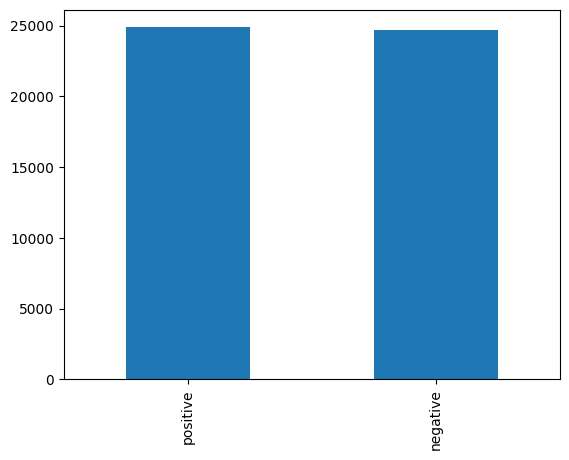

In [45]:
preprocessed_data[LABEL_NAME].value_counts().plot(kind='bar')

In this step, I am analyzing the occurrence of words in the data to determine the maximum tokenization length. By examining the data, I found that the 90% quantile corresponds to a maximum of 448 words. This information is valuable as it helps us define an appropriate tokenization length for the data, ensuring efficient processing without losing significant context.

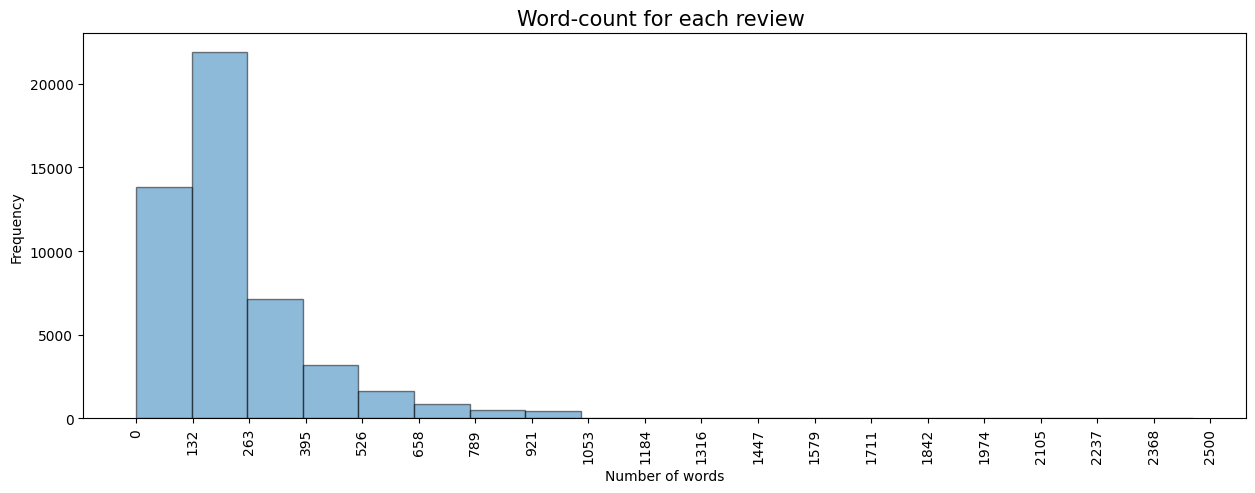

In [46]:
plotting_histogram_for_num_words(preprocessed_data.word_Count)

448.0


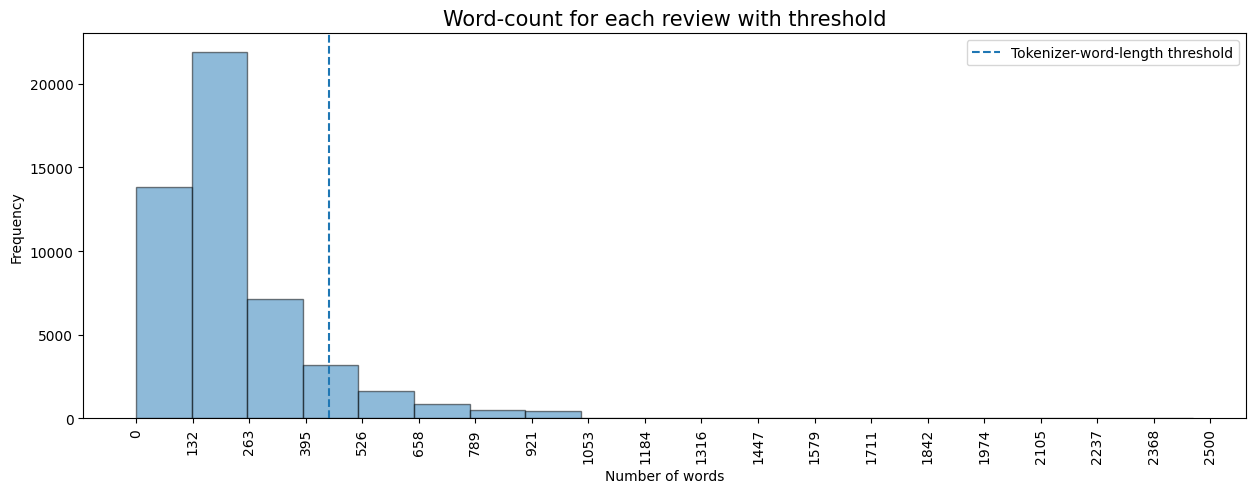

In [47]:
"""
getting the threshold for using as max_length hyperparameter in the Tokenization layer.

set the maximum tokenized length to 90% of num_words.
"""
threshold = preprocessed_data.word_Count.quantile(.9) 
print(threshold)

plotting_histogram_for_num_words(preprocessed_data.word_Count, 
                                 plot_threshold=True, 
                                 threshold_val = int(threshold))

In [48]:
model_params_path = os.path.join(LOCAL_CONFIG_DIR, MODEL_PARAMS_FILE_NAME)
train_distilbert_model(
        preprocessed_data,
        model_params_path,
        LOCAL_ARTIFACTS_DIR,
    )

2023-08-04 13:07:51.693354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-04 13:07:51.808310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-04 13:07:51.809705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-04 13:07:51.812112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 13:07:51.812729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).


Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100


   1/1116 [..............................] - ETA: 3:01:59 - loss: 0.6876 - accuracy: 0.5312

   2/1116 [..............................] - ETA: 26:47 - loss: 0.6798 - accuracy: 0.6562  

   3/1116 [..............................] - ETA: 26:50 - loss: 0.6798 - accuracy: 0.6354

   4/1116 [..............................] - ETA: 26:49 - loss: 0.6824 - accuracy: 0.6250

   5/1116 [..............................] - ETA: 26:51 - loss: 0.6800 - accuracy: 0.6250

   6/1116 [..............................] - ETA: 26:52 - loss: 0.6791 - accuracy: 0.6198

   7/1116 [..............................] - ETA: 26:55 - loss: 0.6935 - accuracy: 0.5759

   8/1116 [..............................] - ETA: 26:57 - loss: 0.6914 - accuracy: 0.5781

   9/1116 [..............................] - ETA: 26:57 - loss: 0.6945 - accuracy: 0.5625

  10/1116 [..............................] - ETA: 26:57 - loss: 0.6992 - accuracy: 0.5437

  11/1116 [..............................] - ETA: 26:58 - loss: 0.6973 - accuracy: 0.5455

  12/1116 [..............................] - ETA: 26:58 - loss: 0.6939 - accuracy: 0.5547

  13/1116 [..............................] - ETA: 26:58 - loss: 0.6907 - accuracy: 0.5649

  14/1116 [..............................] - ETA: 26:58 - loss: 0.6900 - accuracy: 0.5647

  15/1116 [..............................] - ETA: 26:58 - loss: 0.6899 - accuracy: 0.5625

  16/1116 [..............................] - ETA: 26:57 - loss: 0.6897 - accuracy: 0.5605

  17/1116 [..............................] - ETA: 26:58 - loss: 0.6882 - accuracy: 0.5643

  18/1116 [..............................] - ETA: 26:57 - loss: 0.6889 - accuracy: 0.5573

  19/1116 [..............................] - ETA: 26:58 - loss: 0.6899 - accuracy: 0.5510

  20/1116 [..............................] - ETA: 26:58 - loss: 0.6891 - accuracy: 0.5531

  21/1116 [..............................] - ETA: 26:58 - loss: 0.6882 - accuracy: 0.5536

  22/1116 [..............................] - ETA: 26:58 - loss: 0.6878 - accuracy: 0.5511

  23/1116 [..............................] - ETA: 26:58 - loss: 0.6871 - accuracy: 0.5516

  24/1116 [..............................] - ETA: 26:57 - loss: 0.6861 - accuracy: 0.5521

  25/1116 [..............................] - ETA: 26:58 - loss: 0.6860 - accuracy: 0.5487

  26/1116 [..............................] - ETA: 26:58 - loss: 0.6865 - accuracy: 0.5421

  27/1116 [..............................] - ETA: 26:58 - loss: 0.6854 - accuracy: 0.5440

  28/1116 [..............................] - ETA: 26:58 - loss: 0.6842 - accuracy: 0.5469

  29/1116 [..............................] - ETA: 26:58 - loss: 0.6833 - accuracy: 0.5539

  30/1116 [..............................] - ETA: 26:58 - loss: 0.6822 - accuracy: 0.5594

  31/1116 [..............................] - ETA: 26:59 - loss: 0.6804 - accuracy: 0.5665

  32/1116 [..............................] - ETA: 26:59 - loss: 0.6803 - accuracy: 0.5674

  33/1116 [..............................] - ETA: 26:59 - loss: 0.6786 - accuracy: 0.5729

  34/1116 [..............................] - ETA: 27:00 - loss: 0.6750 - accuracy: 0.5827

  35/1116 [..............................] - ETA: 27:00 - loss: 0.6743 - accuracy: 0.5866

  36/1116 [..............................] - ETA: 26:59 - loss: 0.6726 - accuracy: 0.5903

  37/1116 [..............................] - ETA: 26:59 - loss: 0.6701 - accuracy: 0.5954

  38/1116 [>.............................] - ETA: 27:00 - loss: 0.6675 - accuracy: 0.6003

  39/1116 [>.............................] - ETA: 27:00 - loss: 0.6644 - accuracy: 0.6066

  40/1116 [>.............................] - ETA: 27:00 - loss: 0.6634 - accuracy: 0.6062

  41/1116 [>.............................] - ETA: 27:00 - loss: 0.6590 - accuracy: 0.6128

  42/1116 [>.............................] - ETA: 27:00 - loss: 0.6562 - accuracy: 0.6161

  43/1116 [>.............................] - ETA: 27:00 - loss: 0.6532 - accuracy: 0.6206

  44/1116 [>.............................] - ETA: 27:00 - loss: 0.6493 - accuracy: 0.6257

  45/1116 [>.............................] - ETA: 26:59 - loss: 0.6459 - accuracy: 0.6299

  46/1116 [>.............................] - ETA: 27:00 - loss: 0.6422 - accuracy: 0.6338

  47/1116 [>.............................] - ETA: 27:00 - loss: 0.6359 - accuracy: 0.6403

  48/1116 [>.............................] - ETA: 27:00 - loss: 0.6335 - accuracy: 0.6419

  49/1116 [>.............................] - ETA: 27:00 - loss: 0.6278 - accuracy: 0.6480

  50/1116 [>.............................] - ETA: 27:00 - loss: 0.6279 - accuracy: 0.6475

  51/1116 [>.............................] - ETA: 26:59 - loss: 0.6228 - accuracy: 0.6526

  52/1116 [>.............................] - ETA: 26:59 - loss: 0.6178 - accuracy: 0.6562

  53/1116 [>.............................] - ETA: 26:59 - loss: 0.6137 - accuracy: 0.6604

  54/1116 [>.............................] - ETA: 26:59 - loss: 0.6091 - accuracy: 0.6649

  55/1116 [>.............................] - ETA: 26:59 - loss: 0.6044 - accuracy: 0.6687

  56/1116 [>.............................] - ETA: 26:59 - loss: 0.6014 - accuracy: 0.6719

  57/1116 [>.............................] - ETA: 26:59 - loss: 0.5979 - accuracy: 0.6743

  58/1116 [>.............................] - ETA: 26:59 - loss: 0.5988 - accuracy: 0.6746

  59/1116 [>.............................] - ETA: 26:59 - loss: 0.5964 - accuracy: 0.6758

  60/1116 [>.............................] - ETA: 26:59 - loss: 0.5917 - accuracy: 0.6792

  61/1116 [>.............................] - ETA: 26:59 - loss: 0.5884 - accuracy: 0.6814

  62/1116 [>.............................] - ETA: 26:59 - loss: 0.5834 - accuracy: 0.6850

  63/1116 [>.............................] - ETA: 26:59 - loss: 0.5799 - accuracy: 0.6870

  64/1116 [>.............................] - ETA: 26:59 - loss: 0.5781 - accuracy: 0.6890

  65/1116 [>.............................] - ETA: 26:59 - loss: 0.5743 - accuracy: 0.6918

  66/1116 [>.............................] - ETA: 26:59 - loss: 0.5722 - accuracy: 0.6941

  67/1116 [>.............................] - ETA: 26:59 - loss: 0.5694 - accuracy: 0.6968

  68/1116 [>.............................] - ETA: 26:59 - loss: 0.5678 - accuracy: 0.6985

  69/1116 [>.............................] - ETA: 26:59 - loss: 0.5666 - accuracy: 0.6997

  70/1116 [>.............................] - ETA: 26:59 - loss: 0.5635 - accuracy: 0.7022

  71/1116 [>.............................] - ETA: 26:59 - loss: 0.5618 - accuracy: 0.7033

  72/1116 [>.............................] - ETA: 26:58 - loss: 0.5602 - accuracy: 0.7049

  73/1116 [>.............................] - ETA: 26:58 - loss: 0.5565 - accuracy: 0.7080

  74/1116 [>.............................] - ETA: 26:58 - loss: 0.5553 - accuracy: 0.7086

  75/1116 [=>............................] - ETA: 26:58 - loss: 0.5556 - accuracy: 0.7096

  76/1116 [=>............................] - ETA: 26:58 - loss: 0.5541 - accuracy: 0.7113

  77/1116 [=>............................] - ETA: 26:57 - loss: 0.5524 - accuracy: 0.7131

  78/1116 [=>............................] - ETA: 26:57 - loss: 0.5517 - accuracy: 0.7139

  79/1116 [=>............................] - ETA: 26:56 - loss: 0.5503 - accuracy: 0.7152

  80/1116 [=>............................] - ETA: 26:55 - loss: 0.5458 - accuracy: 0.7184

  81/1116 [=>............................] - ETA: 26:55 - loss: 0.5449 - accuracy: 0.7184

  82/1116 [=>............................] - ETA: 26:54 - loss: 0.5425 - accuracy: 0.7207

  83/1116 [=>............................] - ETA: 26:53 - loss: 0.5408 - accuracy: 0.7221

  84/1116 [=>............................] - ETA: 26:52 - loss: 0.5406 - accuracy: 0.7217

  85/1116 [=>............................] - ETA: 26:52 - loss: 0.5378 - accuracy: 0.7239

  86/1116 [=>............................] - ETA: 26:51 - loss: 0.5346 - accuracy: 0.7260

  87/1116 [=>............................] - ETA: 26:50 - loss: 0.5314 - accuracy: 0.7281

  88/1116 [=>............................] - ETA: 26:49 - loss: 0.5286 - accuracy: 0.7305

  89/1116 [=>............................] - ETA: 26:48 - loss: 0.5257 - accuracy: 0.7328

  90/1116 [=>............................] - ETA: 26:47 - loss: 0.5235 - accuracy: 0.7337

  91/1116 [=>............................] - ETA: 26:46 - loss: 0.5239 - accuracy: 0.7335

  92/1116 [=>............................] - ETA: 26:45 - loss: 0.5219 - accuracy: 0.7347

  93/1116 [=>............................] - ETA: 26:44 - loss: 0.5182 - accuracy: 0.7372

  94/1116 [=>............................] - ETA: 26:43 - loss: 0.5172 - accuracy: 0.7370

  95/1116 [=>............................] - ETA: 26:42 - loss: 0.5150 - accuracy: 0.7385

  96/1116 [=>............................] - ETA: 26:41 - loss: 0.5126 - accuracy: 0.7402

  97/1116 [=>............................] - ETA: 26:40 - loss: 0.5105 - accuracy: 0.7413

  98/1116 [=>............................] - ETA: 26:39 - loss: 0.5069 - accuracy: 0.7433

  99/1116 [=>............................] - ETA: 26:38 - loss: 0.5052 - accuracy: 0.7446

 100/1116 [=>............................] - ETA: 26:37 - loss: 0.5020 - accuracy: 0.7469

 101/1116 [=>............................] - ETA: 26:36 - loss: 0.5000 - accuracy: 0.7478

 102/1116 [=>............................] - ETA: 26:35 - loss: 0.5005 - accuracy: 0.7482

 103/1116 [=>............................] - ETA: 26:33 - loss: 0.5004 - accuracy: 0.7479

 104/1116 [=>............................] - ETA: 26:32 - loss: 0.4989 - accuracy: 0.7488

 105/1116 [=>............................] - ETA: 26:31 - loss: 0.4973 - accuracy: 0.7500

 106/1116 [=>............................] - ETA: 26:30 - loss: 0.4944 - accuracy: 0.7521

 107/1116 [=>............................] - ETA: 26:29 - loss: 0.4926 - accuracy: 0.7529

 108/1116 [=>............................] - ETA: 26:28 - loss: 0.4911 - accuracy: 0.7543

 109/1116 [=>............................] - ETA: 26:27 - loss: 0.4894 - accuracy: 0.7549

 110/1116 [=>............................] - ETA: 26:25 - loss: 0.4884 - accuracy: 0.7554

 111/1116 [=>............................] - ETA: 26:24 - loss: 0.4862 - accuracy: 0.7570

 112/1116 [==>...........................] - ETA: 26:23 - loss: 0.4833 - accuracy: 0.7586

 113/1116 [==>...........................] - ETA: 26:22 - loss: 0.4811 - accuracy: 0.7602

 114/1116 [==>...........................] - ETA: 26:21 - loss: 0.4805 - accuracy: 0.7601

 115/1116 [==>...........................] - ETA: 26:20 - loss: 0.4784 - accuracy: 0.7617

 116/1116 [==>...........................] - ETA: 26:19 - loss: 0.4774 - accuracy: 0.7621

 117/1116 [==>...........................] - ETA: 26:17 - loss: 0.4753 - accuracy: 0.7634

 118/1116 [==>...........................] - ETA: 26:16 - loss: 0.4734 - accuracy: 0.7646

 119/1116 [==>...........................] - ETA: 26:15 - loss: 0.4712 - accuracy: 0.7660

 120/1116 [==>...........................] - ETA: 26:14 - loss: 0.4684 - accuracy: 0.7680

 121/1116 [==>...........................] - ETA: 26:13 - loss: 0.4659 - accuracy: 0.7694

 122/1116 [==>...........................] - ETA: 26:11 - loss: 0.4641 - accuracy: 0.7705

 123/1116 [==>...........................] - ETA: 26:10 - loss: 0.4632 - accuracy: 0.7713

 124/1116 [==>...........................] - ETA: 26:09 - loss: 0.4623 - accuracy: 0.7719

 125/1116 [==>...........................] - ETA: 26:08 - loss: 0.4606 - accuracy: 0.7732

 126/1116 [==>...........................] - ETA: 26:06 - loss: 0.4588 - accuracy: 0.7746

 127/1116 [==>...........................] - ETA: 26:05 - loss: 0.4580 - accuracy: 0.7751

 128/1116 [==>...........................] - ETA: 26:04 - loss: 0.4576 - accuracy: 0.7751

 129/1116 [==>...........................] - ETA: 26:03 - loss: 0.4569 - accuracy: 0.7757

 130/1116 [==>...........................] - ETA: 26:01 - loss: 0.4552 - accuracy: 0.7767

 131/1116 [==>...........................] - ETA: 26:00 - loss: 0.4561 - accuracy: 0.7765

 132/1116 [==>...........................] - ETA: 25:59 - loss: 0.4552 - accuracy: 0.7770

 133/1116 [==>...........................] - ETA: 25:58 - loss: 0.4537 - accuracy: 0.7782

 134/1116 [==>...........................] - ETA: 25:56 - loss: 0.4517 - accuracy: 0.7792

 135/1116 [==>...........................] - ETA: 25:55 - loss: 0.4507 - accuracy: 0.7799

 136/1116 [==>...........................] - ETA: 25:54 - loss: 0.4497 - accuracy: 0.7803

 137/1116 [==>...........................] - ETA: 25:52 - loss: 0.4480 - accuracy: 0.7815

 138/1116 [==>...........................] - ETA: 25:51 - loss: 0.4470 - accuracy: 0.7824

 139/1116 [==>...........................] - ETA: 25:50 - loss: 0.4466 - accuracy: 0.7826

 140/1116 [==>...........................] - ETA: 25:48 - loss: 0.4454 - accuracy: 0.7833

 141/1116 [==>...........................] - ETA: 25:47 - loss: 0.4442 - accuracy: 0.7837

 142/1116 [==>...........................] - ETA: 25:46 - loss: 0.4424 - accuracy: 0.7848

 143/1116 [==>...........................] - ETA: 25:44 - loss: 0.4431 - accuracy: 0.7843

 144/1116 [==>...........................] - ETA: 25:43 - loss: 0.4420 - accuracy: 0.7852

 145/1116 [==>...........................] - ETA: 25:42 - loss: 0.4402 - accuracy: 0.7862

 146/1116 [==>...........................] - ETA: 25:40 - loss: 0.4380 - accuracy: 0.7875

 147/1116 [==>...........................] - ETA: 25:39 - loss: 0.4372 - accuracy: 0.7881

 148/1116 [==>...........................] - ETA: 25:38 - loss: 0.4362 - accuracy: 0.7889

 149/1116 [===>..........................] - ETA: 25:36 - loss: 0.4357 - accuracy: 0.7890

 150/1116 [===>..........................] - ETA: 25:35 - loss: 0.4360 - accuracy: 0.7892

 151/1116 [===>..........................] - ETA: 25:34 - loss: 0.4340 - accuracy: 0.7906

 152/1116 [===>..........................] - ETA: 25:32 - loss: 0.4332 - accuracy: 0.7911

 153/1116 [===>..........................] - ETA: 25:31 - loss: 0.4325 - accuracy: 0.7915

 154/1116 [===>..........................] - ETA: 25:30 - loss: 0.4309 - accuracy: 0.7922

 155/1116 [===>..........................] - ETA: 25:28 - loss: 0.4290 - accuracy: 0.7931

 156/1116 [===>..........................] - ETA: 25:27 - loss: 0.4279 - accuracy: 0.7939

 157/1116 [===>..........................] - ETA: 25:25 - loss: 0.4261 - accuracy: 0.7950

 158/1116 [===>..........................] - ETA: 25:24 - loss: 0.4254 - accuracy: 0.7955

 159/1116 [===>..........................] - ETA: 25:23 - loss: 0.4240 - accuracy: 0.7964

 160/1116 [===>..........................] - ETA: 25:21 - loss: 0.4222 - accuracy: 0.7975

 161/1116 [===>..........................] - ETA: 25:20 - loss: 0.4205 - accuracy: 0.7985

 162/1116 [===>..........................] - ETA: 25:19 - loss: 0.4199 - accuracy: 0.7988

 163/1116 [===>..........................] - ETA: 25:17 - loss: 0.4190 - accuracy: 0.7997

 164/1116 [===>..........................] - ETA: 25:16 - loss: 0.4189 - accuracy: 0.7997

 165/1116 [===>..........................] - ETA: 25:14 - loss: 0.4184 - accuracy: 0.7998

 166/1116 [===>..........................] - ETA: 25:13 - loss: 0.4175 - accuracy: 0.8003

 167/1116 [===>..........................] - ETA: 25:11 - loss: 0.4162 - accuracy: 0.8009

 168/1116 [===>..........................] - ETA: 25:10 - loss: 0.4151 - accuracy: 0.8010

 169/1116 [===>..........................] - ETA: 25:09 - loss: 0.4141 - accuracy: 0.8016

 170/1116 [===>..........................] - ETA: 25:07 - loss: 0.4130 - accuracy: 0.8022

 171/1116 [===>..........................] - ETA: 25:06 - loss: 0.4127 - accuracy: 0.8028

 172/1116 [===>..........................] - ETA: 25:04 - loss: 0.4124 - accuracy: 0.8032

 173/1116 [===>..........................] - ETA: 25:03 - loss: 0.4113 - accuracy: 0.8038

 174/1116 [===>..........................] - ETA: 25:02 - loss: 0.4101 - accuracy: 0.8044

 175/1116 [===>..........................] - ETA: 25:00 - loss: 0.4093 - accuracy: 0.8050

 176/1116 [===>..........................] - ETA: 24:59 - loss: 0.4083 - accuracy: 0.8054

 177/1116 [===>..........................] - ETA: 24:57 - loss: 0.4080 - accuracy: 0.8056

 178/1116 [===>..........................] - ETA: 24:56 - loss: 0.4069 - accuracy: 0.8064

 179/1116 [===>..........................] - ETA: 24:54 - loss: 0.4060 - accuracy: 0.8067

 180/1116 [===>..........................] - ETA: 24:53 - loss: 0.4051 - accuracy: 0.8073

 181/1116 [===>..........................] - ETA: 24:51 - loss: 0.4041 - accuracy: 0.8082

 182/1116 [===>..........................] - ETA: 24:50 - loss: 0.4035 - accuracy: 0.8087

 183/1116 [===>..........................] - ETA: 24:49 - loss: 0.4026 - accuracy: 0.8093

 184/1116 [===>..........................] - ETA: 24:47 - loss: 0.4017 - accuracy: 0.8098

 185/1116 [===>..........................] - ETA: 24:46 - loss: 0.4006 - accuracy: 0.8105

 186/1116 [====>.........................] - ETA: 24:44 - loss: 0.3990 - accuracy: 0.8113

 187/1116 [====>.........................] - ETA: 24:43 - loss: 0.3982 - accuracy: 0.8118

 188/1116 [====>.........................] - ETA: 24:41 - loss: 0.3967 - accuracy: 0.8127

 189/1116 [====>.........................] - ETA: 24:40 - loss: 0.3957 - accuracy: 0.8133

 190/1116 [====>.........................] - ETA: 24:38 - loss: 0.3962 - accuracy: 0.8132

 191/1116 [====>.........................] - ETA: 24:37 - loss: 0.3954 - accuracy: 0.8133

 192/1116 [====>.........................] - ETA: 24:35 - loss: 0.3945 - accuracy: 0.8138

 193/1116 [====>.........................] - ETA: 24:34 - loss: 0.3948 - accuracy: 0.8135

 194/1116 [====>.........................] - ETA: 24:32 - loss: 0.3940 - accuracy: 0.8139

 195/1116 [====>.........................] - ETA: 24:31 - loss: 0.3931 - accuracy: 0.8143

 196/1116 [====>.........................] - ETA: 24:30 - loss: 0.3918 - accuracy: 0.8151

 197/1116 [====>.........................] - ETA: 24:28 - loss: 0.3911 - accuracy: 0.8154

 198/1116 [====>.........................] - ETA: 24:27 - loss: 0.3912 - accuracy: 0.8157

 199/1116 [====>.........................] - ETA: 24:25 - loss: 0.3913 - accuracy: 0.8158

 200/1116 [====>.........................] - ETA: 24:24 - loss: 0.3907 - accuracy: 0.8163

 201/1116 [====>.........................] - ETA: 24:22 - loss: 0.3898 - accuracy: 0.8165

 202/1116 [====>.........................] - ETA: 24:21 - loss: 0.3891 - accuracy: 0.8168

 203/1116 [====>.........................] - ETA: 24:19 - loss: 0.3881 - accuracy: 0.8176

 204/1116 [====>.........................] - ETA: 24:18 - loss: 0.3890 - accuracy: 0.8176

 205/1116 [====>.........................] - ETA: 24:16 - loss: 0.3877 - accuracy: 0.8184

 206/1116 [====>.........................] - ETA: 24:15 - loss: 0.3874 - accuracy: 0.8187

 207/1116 [====>.........................] - ETA: 24:13 - loss: 0.3870 - accuracy: 0.8188

 208/1116 [====>.........................] - ETA: 24:12 - loss: 0.3867 - accuracy: 0.8193

 209/1116 [====>.........................] - ETA: 24:10 - loss: 0.3876 - accuracy: 0.8189

 210/1116 [====>.........................] - ETA: 24:09 - loss: 0.3874 - accuracy: 0.8189

 211/1116 [====>.........................] - ETA: 24:07 - loss: 0.3872 - accuracy: 0.8192

 212/1116 [====>.........................] - ETA: 24:06 - loss: 0.3867 - accuracy: 0.8194

 213/1116 [====>.........................] - ETA: 24:04 - loss: 0.3864 - accuracy: 0.8195

 214/1116 [====>.........................] - ETA: 24:03 - loss: 0.3860 - accuracy: 0.8198

 215/1116 [====>.........................] - ETA: 24:01 - loss: 0.3854 - accuracy: 0.8202

 216/1116 [====>.........................] - ETA: 24:00 - loss: 0.3849 - accuracy: 0.8203

 217/1116 [====>.........................] - ETA: 23:58 - loss: 0.3846 - accuracy: 0.8204

 218/1116 [====>.........................] - ETA: 23:57 - loss: 0.3848 - accuracy: 0.8202

 219/1116 [====>.........................] - ETA: 23:55 - loss: 0.3839 - accuracy: 0.8208

 220/1116 [====>.........................] - ETA: 23:54 - loss: 0.3837 - accuracy: 0.8207

 221/1116 [====>.........................] - ETA: 23:52 - loss: 0.3830 - accuracy: 0.8211

 222/1116 [====>.........................] - ETA: 23:51 - loss: 0.3826 - accuracy: 0.8214

 223/1116 [====>.........................] - ETA: 23:49 - loss: 0.3817 - accuracy: 0.8219

 224/1116 [=====>........................] - ETA: 23:48 - loss: 0.3812 - accuracy: 0.8223

 225/1116 [=====>........................] - ETA: 23:46 - loss: 0.3804 - accuracy: 0.8226

 226/1116 [=====>........................] - ETA: 23:45 - loss: 0.3806 - accuracy: 0.8227

 227/1116 [=====>........................] - ETA: 23:43 - loss: 0.3797 - accuracy: 0.8235

 228/1116 [=====>........................] - ETA: 23:42 - loss: 0.3792 - accuracy: 0.8239

 229/1116 [=====>........................] - ETA: 23:40 - loss: 0.3786 - accuracy: 0.8240

 230/1116 [=====>........................] - ETA: 23:39 - loss: 0.3780 - accuracy: 0.8245

 231/1116 [=====>........................] - ETA: 23:37 - loss: 0.3773 - accuracy: 0.8249

 232/1116 [=====>........................] - ETA: 23:36 - loss: 0.3766 - accuracy: 0.8254

 233/1116 [=====>........................] - ETA: 23:34 - loss: 0.3760 - accuracy: 0.8259

 234/1116 [=====>........................] - ETA: 23:33 - loss: 0.3751 - accuracy: 0.8264

 235/1116 [=====>........................] - ETA: 23:31 - loss: 0.3747 - accuracy: 0.8266

 236/1116 [=====>........................] - ETA: 23:30 - loss: 0.3750 - accuracy: 0.8264

 237/1116 [=====>........................] - ETA: 23:28 - loss: 0.3740 - accuracy: 0.8269

 238/1116 [=====>........................] - ETA: 23:27 - loss: 0.3728 - accuracy: 0.8276

 239/1116 [=====>........................] - ETA: 23:25 - loss: 0.3722 - accuracy: 0.8279

 240/1116 [=====>........................] - ETA: 23:24 - loss: 0.3714 - accuracy: 0.8284

 241/1116 [=====>........................] - ETA: 23:22 - loss: 0.3707 - accuracy: 0.8287

 242/1116 [=====>........................] - ETA: 23:21 - loss: 0.3697 - accuracy: 0.8293

 243/1116 [=====>........................] - ETA: 23:19 - loss: 0.3693 - accuracy: 0.8296

 244/1116 [=====>........................] - ETA: 23:18 - loss: 0.3687 - accuracy: 0.8299

 245/1116 [=====>........................] - ETA: 23:16 - loss: 0.3676 - accuracy: 0.8305

 246/1116 [=====>........................] - ETA: 23:14 - loss: 0.3668 - accuracy: 0.8309

 247/1116 [=====>........................] - ETA: 23:13 - loss: 0.3660 - accuracy: 0.8314

 248/1116 [=====>........................] - ETA: 23:11 - loss: 0.3654 - accuracy: 0.8318

 249/1116 [=====>........................] - ETA: 23:10 - loss: 0.3648 - accuracy: 0.8321

 250/1116 [=====>........................] - ETA: 23:08 - loss: 0.3639 - accuracy: 0.8326

 251/1116 [=====>........................] - ETA: 23:07 - loss: 0.3629 - accuracy: 0.8332

 252/1116 [=====>........................] - ETA: 23:05 - loss: 0.3627 - accuracy: 0.8335

 253/1116 [=====>........................] - ETA: 23:04 - loss: 0.3618 - accuracy: 0.8340

 254/1116 [=====>........................] - ETA: 23:02 - loss: 0.3626 - accuracy: 0.8338

 255/1116 [=====>........................] - ETA: 23:01 - loss: 0.3621 - accuracy: 0.8341

 256/1116 [=====>........................] - ETA: 22:59 - loss: 0.3619 - accuracy: 0.8344

 257/1116 [=====>........................] - ETA: 22:58 - loss: 0.3609 - accuracy: 0.8349

 258/1116 [=====>........................] - ETA: 22:56 - loss: 0.3610 - accuracy: 0.8349

 259/1116 [=====>........................] - ETA: 22:55 - loss: 0.3603 - accuracy: 0.8354

 260/1116 [=====>........................] - ETA: 22:53 - loss: 0.3600 - accuracy: 0.8355

 261/1116 [======>.......................] - ETA: 22:51 - loss: 0.3599 - accuracy: 0.8356

 262/1116 [======>.......................] - ETA: 22:50 - loss: 0.3599 - accuracy: 0.8358

 263/1116 [======>.......................] - ETA: 22:48 - loss: 0.3595 - accuracy: 0.8360

 264/1116 [======>.......................] - ETA: 22:47 - loss: 0.3592 - accuracy: 0.8363

 265/1116 [======>.......................] - ETA: 22:45 - loss: 0.3589 - accuracy: 0.8366

 266/1116 [======>.......................] - ETA: 22:44 - loss: 0.3580 - accuracy: 0.8371

 267/1116 [======>.......................] - ETA: 22:42 - loss: 0.3576 - accuracy: 0.8372

 268/1116 [======>.......................] - ETA: 22:41 - loss: 0.3577 - accuracy: 0.8371

 269/1116 [======>.......................] - ETA: 22:39 - loss: 0.3576 - accuracy: 0.8371

 270/1116 [======>.......................] - ETA: 22:38 - loss: 0.3574 - accuracy: 0.8372

 271/1116 [======>.......................] - ETA: 22:36 - loss: 0.3567 - accuracy: 0.8375

 272/1116 [======>.......................] - ETA: 22:34 - loss: 0.3561 - accuracy: 0.8379

 273/1116 [======>.......................] - ETA: 22:33 - loss: 0.3554 - accuracy: 0.8383

 274/1116 [======>.......................] - ETA: 22:31 - loss: 0.3549 - accuracy: 0.8385

 275/1116 [======>.......................] - ETA: 22:30 - loss: 0.3542 - accuracy: 0.8389

 276/1116 [======>.......................] - ETA: 22:28 - loss: 0.3542 - accuracy: 0.8390

 277/1116 [======>.......................] - ETA: 22:27 - loss: 0.3534 - accuracy: 0.8394

 278/1116 [======>.......................] - ETA: 22:25 - loss: 0.3529 - accuracy: 0.8396

 279/1116 [======>.......................] - ETA: 22:24 - loss: 0.3529 - accuracy: 0.8395

 280/1116 [======>.......................] - ETA: 22:22 - loss: 0.3523 - accuracy: 0.8398

 281/1116 [======>.......................] - ETA: 22:21 - loss: 0.3517 - accuracy: 0.8403

 282/1116 [======>.......................] - ETA: 22:19 - loss: 0.3513 - accuracy: 0.8405

 283/1116 [======>.......................] - ETA: 22:17 - loss: 0.3506 - accuracy: 0.8411

 284/1116 [======>.......................] - ETA: 22:16 - loss: 0.3503 - accuracy: 0.8413

 285/1116 [======>.......................] - ETA: 22:14 - loss: 0.3503 - accuracy: 0.8416

 286/1116 [======>.......................] - ETA: 22:13 - loss: 0.3498 - accuracy: 0.8418

 287/1116 [======>.......................] - ETA: 22:11 - loss: 0.3496 - accuracy: 0.8420

 288/1116 [======>.......................] - ETA: 22:10 - loss: 0.3495 - accuracy: 0.8420

 289/1116 [======>.......................] - ETA: 22:08 - loss: 0.3491 - accuracy: 0.8425

 290/1116 [======>.......................] - ETA: 22:07 - loss: 0.3490 - accuracy: 0.8426

 291/1116 [======>.......................] - ETA: 22:05 - loss: 0.3486 - accuracy: 0.8429

 292/1116 [======>.......................] - ETA: 22:04 - loss: 0.3480 - accuracy: 0.8432

 293/1116 [======>.......................] - ETA: 22:02 - loss: 0.3482 - accuracy: 0.8430

 294/1116 [======>.......................] - ETA: 22:00 - loss: 0.3480 - accuracy: 0.8432

 295/1116 [======>.......................] - ETA: 21:59 - loss: 0.3477 - accuracy: 0.8432

 296/1116 [======>.......................] - ETA: 21:57 - loss: 0.3477 - accuracy: 0.8433

 297/1116 [======>.......................] - ETA: 21:56 - loss: 0.3477 - accuracy: 0.8432

 298/1116 [=======>......................] - ETA: 21:54 - loss: 0.3472 - accuracy: 0.8434

 299/1116 [=======>......................] - ETA: 21:53 - loss: 0.3471 - accuracy: 0.8435

 300/1116 [=======>......................] - ETA: 21:51 - loss: 0.3470 - accuracy: 0.8436

 301/1116 [=======>......................] - ETA: 21:50 - loss: 0.3463 - accuracy: 0.8441

 302/1116 [=======>......................] - ETA: 21:48 - loss: 0.3456 - accuracy: 0.8443

 303/1116 [=======>......................] - ETA: 21:46 - loss: 0.3455 - accuracy: 0.8445

 304/1116 [=======>......................] - ETA: 21:45 - loss: 0.3450 - accuracy: 0.8448

 305/1116 [=======>......................] - ETA: 21:43 - loss: 0.3447 - accuracy: 0.8449

 306/1116 [=======>......................] - ETA: 21:42 - loss: 0.3441 - accuracy: 0.8452

 307/1116 [=======>......................] - ETA: 21:40 - loss: 0.3433 - accuracy: 0.8456

 308/1116 [=======>......................] - ETA: 21:39 - loss: 0.3427 - accuracy: 0.8460

 309/1116 [=======>......................] - ETA: 21:37 - loss: 0.3423 - accuracy: 0.8463

 310/1116 [=======>......................] - ETA: 21:35 - loss: 0.3416 - accuracy: 0.8466

 311/1116 [=======>......................] - ETA: 21:34 - loss: 0.3417 - accuracy: 0.8466

 312/1116 [=======>......................] - ETA: 21:32 - loss: 0.3413 - accuracy: 0.8469

 313/1116 [=======>......................] - ETA: 21:31 - loss: 0.3409 - accuracy: 0.8471

 314/1116 [=======>......................] - ETA: 21:29 - loss: 0.3405 - accuracy: 0.8474

 315/1116 [=======>......................] - ETA: 21:28 - loss: 0.3402 - accuracy: 0.8476

 316/1116 [=======>......................] - ETA: 21:26 - loss: 0.3395 - accuracy: 0.8479

 317/1116 [=======>......................] - ETA: 21:24 - loss: 0.3394 - accuracy: 0.8480

 318/1116 [=======>......................] - ETA: 21:23 - loss: 0.3389 - accuracy: 0.8484

 319/1116 [=======>......................] - ETA: 21:21 - loss: 0.3383 - accuracy: 0.8486

 320/1116 [=======>......................] - ETA: 21:20 - loss: 0.3378 - accuracy: 0.8487

 321/1116 [=======>......................] - ETA: 21:18 - loss: 0.3373 - accuracy: 0.8489

 322/1116 [=======>......................] - ETA: 21:17 - loss: 0.3371 - accuracy: 0.8490

 323/1116 [=======>......................] - ETA: 21:15 - loss: 0.3365 - accuracy: 0.8494

 324/1116 [=======>......................] - ETA: 21:14 - loss: 0.3367 - accuracy: 0.8493

 325/1116 [=======>......................] - ETA: 21:12 - loss: 0.3365 - accuracy: 0.8495

 326/1116 [=======>......................] - ETA: 21:10 - loss: 0.3363 - accuracy: 0.8497

 327/1116 [=======>......................] - ETA: 21:09 - loss: 0.3364 - accuracy: 0.8497

 328/1116 [=======>......................] - ETA: 21:07 - loss: 0.3363 - accuracy: 0.8498

 329/1116 [=======>......................] - ETA: 21:06 - loss: 0.3364 - accuracy: 0.8498

 330/1116 [=======>......................] - ETA: 21:04 - loss: 0.3357 - accuracy: 0.8502

 331/1116 [=======>......................] - ETA: 21:03 - loss: 0.3350 - accuracy: 0.8505

 332/1116 [=======>......................] - ETA: 21:01 - loss: 0.3350 - accuracy: 0.8506

 333/1116 [=======>......................] - ETA: 20:59 - loss: 0.3352 - accuracy: 0.8507

 334/1116 [=======>......................] - ETA: 20:58 - loss: 0.3346 - accuracy: 0.8510

 335/1116 [========>.....................] - ETA: 20:56 - loss: 0.3345 - accuracy: 0.8509

 336/1116 [========>.....................] - ETA: 20:55 - loss: 0.3340 - accuracy: 0.8511

 337/1116 [========>.....................] - ETA: 20:53 - loss: 0.3336 - accuracy: 0.8513

 338/1116 [========>.....................] - ETA: 20:52 - loss: 0.3331 - accuracy: 0.8516

 339/1116 [========>.....................] - ETA: 20:50 - loss: 0.3326 - accuracy: 0.8520

 340/1116 [========>.....................] - ETA: 20:48 - loss: 0.3324 - accuracy: 0.8520

 341/1116 [========>.....................] - ETA: 20:47 - loss: 0.3318 - accuracy: 0.8525

 342/1116 [========>.....................] - ETA: 20:45 - loss: 0.3314 - accuracy: 0.8526

 343/1116 [========>.....................] - ETA: 20:44 - loss: 0.3311 - accuracy: 0.8529

 344/1116 [========>.....................] - ETA: 20:42 - loss: 0.3304 - accuracy: 0.8532

 345/1116 [========>.....................] - ETA: 20:41 - loss: 0.3308 - accuracy: 0.8531

 346/1116 [========>.....................] - ETA: 20:39 - loss: 0.3303 - accuracy: 0.8533

 347/1116 [========>.....................] - ETA: 20:37 - loss: 0.3300 - accuracy: 0.8534

 348/1116 [========>.....................] - ETA: 20:36 - loss: 0.3306 - accuracy: 0.8533

 349/1116 [========>.....................] - ETA: 20:34 - loss: 0.3301 - accuracy: 0.8536

 350/1116 [========>.....................] - ETA: 20:33 - loss: 0.3300 - accuracy: 0.8537

 351/1116 [========>.....................] - ETA: 20:31 - loss: 0.3297 - accuracy: 0.8539

 352/1116 [========>.....................] - ETA: 20:29 - loss: 0.3293 - accuracy: 0.8542

 353/1116 [========>.....................] - ETA: 20:28 - loss: 0.3289 - accuracy: 0.8543

 354/1116 [========>.....................] - ETA: 20:26 - loss: 0.3286 - accuracy: 0.8545

 355/1116 [========>.....................] - ETA: 20:25 - loss: 0.3280 - accuracy: 0.8548

 356/1116 [========>.....................] - ETA: 20:23 - loss: 0.3279 - accuracy: 0.8550

 357/1116 [========>.....................] - ETA: 20:22 - loss: 0.3276 - accuracy: 0.8551

 358/1116 [========>.....................] - ETA: 20:20 - loss: 0.3269 - accuracy: 0.8555

 359/1116 [========>.....................] - ETA: 20:18 - loss: 0.3263 - accuracy: 0.8558

 360/1116 [========>.....................] - ETA: 20:17 - loss: 0.3259 - accuracy: 0.8560

 361/1116 [========>.....................] - ETA: 20:15 - loss: 0.3261 - accuracy: 0.8560

 362/1116 [========>.....................] - ETA: 20:14 - loss: 0.3259 - accuracy: 0.8561

 363/1116 [========>.....................] - ETA: 20:12 - loss: 0.3257 - accuracy: 0.8562

 364/1116 [========>.....................] - ETA: 20:11 - loss: 0.3252 - accuracy: 0.8565

 365/1116 [========>.....................] - ETA: 20:09 - loss: 0.3247 - accuracy: 0.8568

 366/1116 [========>.....................] - ETA: 20:07 - loss: 0.3246 - accuracy: 0.8569

 367/1116 [========>.....................] - ETA: 20:06 - loss: 0.3241 - accuracy: 0.8571

 368/1116 [========>.....................] - ETA: 20:04 - loss: 0.3242 - accuracy: 0.8571

 369/1116 [========>.....................] - ETA: 20:03 - loss: 0.3240 - accuracy: 0.8571

 370/1116 [========>.....................] - ETA: 20:01 - loss: 0.3235 - accuracy: 0.8573

 371/1116 [========>.....................] - ETA: 19:59 - loss: 0.3234 - accuracy: 0.8574

 372/1116 [=========>....................] - ETA: 19:58 - loss: 0.3226 - accuracy: 0.8578

 373/1116 [=========>....................] - ETA: 19:56 - loss: 0.3226 - accuracy: 0.8578

 374/1116 [=========>....................] - ETA: 19:55 - loss: 0.3224 - accuracy: 0.8579

 375/1116 [=========>....................] - ETA: 19:53 - loss: 0.3217 - accuracy: 0.8582

 376/1116 [=========>....................] - ETA: 19:52 - loss: 0.3216 - accuracy: 0.8584

 377/1116 [=========>....................] - ETA: 19:50 - loss: 0.3214 - accuracy: 0.8584

 378/1116 [=========>....................] - ETA: 19:48 - loss: 0.3211 - accuracy: 0.8586

 379/1116 [=========>....................] - ETA: 19:47 - loss: 0.3206 - accuracy: 0.8589

 380/1116 [=========>....................] - ETA: 19:45 - loss: 0.3202 - accuracy: 0.8590

 381/1116 [=========>....................] - ETA: 19:44 - loss: 0.3200 - accuracy: 0.8593

 382/1116 [=========>....................] - ETA: 19:42 - loss: 0.3198 - accuracy: 0.8595

 383/1116 [=========>....................] - ETA: 19:40 - loss: 0.3195 - accuracy: 0.8596

 384/1116 [=========>....................] - ETA: 19:39 - loss: 0.3192 - accuracy: 0.8597

 385/1116 [=========>....................] - ETA: 19:37 - loss: 0.3190 - accuracy: 0.8599

 386/1116 [=========>....................] - ETA: 19:36 - loss: 0.3186 - accuracy: 0.8601

 387/1116 [=========>....................] - ETA: 19:34 - loss: 0.3183 - accuracy: 0.8602

 388/1116 [=========>....................] - ETA: 19:33 - loss: 0.3179 - accuracy: 0.8604

 389/1116 [=========>....................] - ETA: 19:31 - loss: 0.3178 - accuracy: 0.8605

 390/1116 [=========>....................] - ETA: 19:29 - loss: 0.3176 - accuracy: 0.8606

 391/1116 [=========>....................] - ETA: 19:28 - loss: 0.3174 - accuracy: 0.8607

 392/1116 [=========>....................] - ETA: 19:26 - loss: 0.3169 - accuracy: 0.8610

 393/1116 [=========>....................] - ETA: 19:25 - loss: 0.3164 - accuracy: 0.8612

 394/1116 [=========>....................] - ETA: 19:23 - loss: 0.3159 - accuracy: 0.8614

 395/1116 [=========>....................] - ETA: 19:21 - loss: 0.3158 - accuracy: 0.8614

 396/1116 [=========>....................] - ETA: 19:20 - loss: 0.3152 - accuracy: 0.8617

 397/1116 [=========>....................] - ETA: 19:18 - loss: 0.3149 - accuracy: 0.8619

 398/1116 [=========>....................] - ETA: 19:17 - loss: 0.3152 - accuracy: 0.8617

 399/1116 [=========>....................] - ETA: 19:15 - loss: 0.3155 - accuracy: 0.8616

 400/1116 [=========>....................] - ETA: 19:13 - loss: 0.3152 - accuracy: 0.8617

 401/1116 [=========>....................] - ETA: 19:12 - loss: 0.3147 - accuracy: 0.8620

 402/1116 [=========>....................] - ETA: 19:10 - loss: 0.3145 - accuracy: 0.8621

 403/1116 [=========>....................] - ETA: 19:09 - loss: 0.3143 - accuracy: 0.8623

 404/1116 [=========>....................] - ETA: 19:07 - loss: 0.3139 - accuracy: 0.8625

 405/1116 [=========>....................] - ETA: 19:06 - loss: 0.3143 - accuracy: 0.8623

 406/1116 [=========>....................] - ETA: 19:04 - loss: 0.3139 - accuracy: 0.8626

 407/1116 [=========>....................] - ETA: 19:02 - loss: 0.3134 - accuracy: 0.8629

 408/1116 [=========>....................] - ETA: 19:01 - loss: 0.3135 - accuracy: 0.8627

 409/1116 [=========>....................] - ETA: 18:59 - loss: 0.3132 - accuracy: 0.8629

 410/1116 [==========>...................] - ETA: 18:58 - loss: 0.3133 - accuracy: 0.8630

 411/1116 [==========>...................] - ETA: 18:56 - loss: 0.3132 - accuracy: 0.8631

 412/1116 [==========>...................] - ETA: 18:54 - loss: 0.3131 - accuracy: 0.8632

 413/1116 [==========>...................] - ETA: 18:53 - loss: 0.3129 - accuracy: 0.8632

 414/1116 [==========>...................] - ETA: 18:51 - loss: 0.3127 - accuracy: 0.8633

 415/1116 [==========>...................] - ETA: 18:50 - loss: 0.3124 - accuracy: 0.8635

 416/1116 [==========>...................] - ETA: 18:48 - loss: 0.3120 - accuracy: 0.8637

 417/1116 [==========>...................] - ETA: 18:46 - loss: 0.3117 - accuracy: 0.8639

 418/1116 [==========>...................] - ETA: 18:45 - loss: 0.3112 - accuracy: 0.8642

 419/1116 [==========>...................] - ETA: 18:43 - loss: 0.3108 - accuracy: 0.8644

 420/1116 [==========>...................] - ETA: 18:42 - loss: 0.3104 - accuracy: 0.8647

 421/1116 [==========>...................] - ETA: 18:40 - loss: 0.3103 - accuracy: 0.8646

 422/1116 [==========>...................] - ETA: 18:38 - loss: 0.3104 - accuracy: 0.8646

 423/1116 [==========>...................] - ETA: 18:37 - loss: 0.3098 - accuracy: 0.8650

 424/1116 [==========>...................] - ETA: 18:35 - loss: 0.3099 - accuracy: 0.8651

 425/1116 [==========>...................] - ETA: 18:34 - loss: 0.3094 - accuracy: 0.8654

 426/1116 [==========>...................] - ETA: 18:32 - loss: 0.3093 - accuracy: 0.8655

 427/1116 [==========>...................] - ETA: 18:31 - loss: 0.3094 - accuracy: 0.8653

 428/1116 [==========>...................] - ETA: 18:29 - loss: 0.3095 - accuracy: 0.8654

 429/1116 [==========>...................] - ETA: 18:27 - loss: 0.3091 - accuracy: 0.8655

 430/1116 [==========>...................] - ETA: 18:26 - loss: 0.3092 - accuracy: 0.8655

 431/1116 [==========>...................] - ETA: 18:24 - loss: 0.3087 - accuracy: 0.8657

 432/1116 [==========>...................] - ETA: 18:23 - loss: 0.3086 - accuracy: 0.8658

 433/1116 [==========>...................] - ETA: 18:21 - loss: 0.3087 - accuracy: 0.8658

 434/1116 [==========>...................] - ETA: 18:19 - loss: 0.3081 - accuracy: 0.8660

 435/1116 [==========>...................] - ETA: 18:18 - loss: 0.3082 - accuracy: 0.8659

 436/1116 [==========>...................] - ETA: 18:16 - loss: 0.3077 - accuracy: 0.8661

 437/1116 [==========>...................] - ETA: 18:15 - loss: 0.3079 - accuracy: 0.8660

 438/1116 [==========>...................] - ETA: 18:13 - loss: 0.3077 - accuracy: 0.8661

 439/1116 [==========>...................] - ETA: 18:11 - loss: 0.3078 - accuracy: 0.8660

 440/1116 [==========>...................] - ETA: 18:10 - loss: 0.3083 - accuracy: 0.8660

 441/1116 [==========>...................] - ETA: 18:08 - loss: 0.3082 - accuracy: 0.8660

 442/1116 [==========>...................] - ETA: 18:07 - loss: 0.3083 - accuracy: 0.8660

 443/1116 [==========>...................] - ETA: 18:05 - loss: 0.3081 - accuracy: 0.8660

 444/1116 [==========>...................] - ETA: 18:03 - loss: 0.3077 - accuracy: 0.8663

 445/1116 [==========>...................] - ETA: 18:02 - loss: 0.3074 - accuracy: 0.8664

 446/1116 [==========>...................] - ETA: 18:00 - loss: 0.3073 - accuracy: 0.8666

 447/1116 [===========>..................] - ETA: 17:59 - loss: 0.3071 - accuracy: 0.8668

 448/1116 [===========>..................] - ETA: 17:57 - loss: 0.3070 - accuracy: 0.8668

 449/1116 [===========>..................] - ETA: 17:55 - loss: 0.3069 - accuracy: 0.8669

 450/1116 [===========>..................] - ETA: 17:54 - loss: 0.3066 - accuracy: 0.8672

 451/1116 [===========>..................] - ETA: 17:52 - loss: 0.3062 - accuracy: 0.8673

 452/1116 [===========>..................] - ETA: 17:51 - loss: 0.3064 - accuracy: 0.8672

 453/1116 [===========>..................] - ETA: 17:49 - loss: 0.3059 - accuracy: 0.8674

 454/1116 [===========>..................] - ETA: 17:47 - loss: 0.3054 - accuracy: 0.8677

 455/1116 [===========>..................] - ETA: 17:46 - loss: 0.3051 - accuracy: 0.8679

 456/1116 [===========>..................] - ETA: 17:44 - loss: 0.3051 - accuracy: 0.8677

 457/1116 [===========>..................] - ETA: 17:43 - loss: 0.3051 - accuracy: 0.8679

 458/1116 [===========>..................] - ETA: 17:41 - loss: 0.3047 - accuracy: 0.8681

 459/1116 [===========>..................] - ETA: 17:39 - loss: 0.3048 - accuracy: 0.8680

 460/1116 [===========>..................] - ETA: 17:38 - loss: 0.3047 - accuracy: 0.8680

 461/1116 [===========>..................] - ETA: 17:36 - loss: 0.3045 - accuracy: 0.8681

 462/1116 [===========>..................] - ETA: 17:35 - loss: 0.3046 - accuracy: 0.8681

 463/1116 [===========>..................] - ETA: 17:33 - loss: 0.3042 - accuracy: 0.8683

 464/1116 [===========>..................] - ETA: 17:32 - loss: 0.3043 - accuracy: 0.8682

 465/1116 [===========>..................] - ETA: 17:30 - loss: 0.3039 - accuracy: 0.8683

 466/1116 [===========>..................] - ETA: 17:28 - loss: 0.3038 - accuracy: 0.8682

 467/1116 [===========>..................] - ETA: 17:27 - loss: 0.3037 - accuracy: 0.8683

 468/1116 [===========>..................] - ETA: 17:25 - loss: 0.3035 - accuracy: 0.8684

 469/1116 [===========>..................] - ETA: 17:24 - loss: 0.3034 - accuracy: 0.8684

 470/1116 [===========>..................] - ETA: 17:22 - loss: 0.3030 - accuracy: 0.8686

 471/1116 [===========>..................] - ETA: 17:20 - loss: 0.3024 - accuracy: 0.8688

 472/1116 [===========>..................] - ETA: 17:19 - loss: 0.3024 - accuracy: 0.8689

 473/1116 [===========>..................] - ETA: 17:17 - loss: 0.3021 - accuracy: 0.8691

 474/1116 [===========>..................] - ETA: 17:16 - loss: 0.3020 - accuracy: 0.8691

 475/1116 [===========>..................] - ETA: 17:14 - loss: 0.3017 - accuracy: 0.8693

 476/1116 [===========>..................] - ETA: 17:12 - loss: 0.3014 - accuracy: 0.8695

 477/1116 [===========>..................] - ETA: 17:11 - loss: 0.3011 - accuracy: 0.8696

 478/1116 [===========>..................] - ETA: 17:09 - loss: 0.3006 - accuracy: 0.8699

 479/1116 [===========>..................] - ETA: 17:08 - loss: 0.3006 - accuracy: 0.8700

 480/1116 [===========>..................] - ETA: 17:06 - loss: 0.3006 - accuracy: 0.8699

 481/1116 [===========>..................] - ETA: 17:04 - loss: 0.3005 - accuracy: 0.8700

 482/1116 [===========>..................] - ETA: 17:03 - loss: 0.3005 - accuracy: 0.8699

 483/1116 [===========>..................] - ETA: 17:01 - loss: 0.3003 - accuracy: 0.8700

 484/1116 [============>.................] - ETA: 17:00 - loss: 0.3002 - accuracy: 0.8700

 485/1116 [============>.................] - ETA: 16:58 - loss: 0.3001 - accuracy: 0.8700

 486/1116 [============>.................] - ETA: 16:56 - loss: 0.2998 - accuracy: 0.8702

 487/1116 [============>.................] - ETA: 16:55 - loss: 0.3001 - accuracy: 0.8700

 488/1116 [============>.................] - ETA: 16:53 - loss: 0.3003 - accuracy: 0.8700

 489/1116 [============>.................] - ETA: 16:52 - loss: 0.3004 - accuracy: 0.8701

 490/1116 [============>.................] - ETA: 16:50 - loss: 0.3005 - accuracy: 0.8700

 491/1116 [============>.................] - ETA: 16:48 - loss: 0.3005 - accuracy: 0.8700

 492/1116 [============>.................] - ETA: 16:47 - loss: 0.3001 - accuracy: 0.8702

 493/1116 [============>.................] - ETA: 16:45 - loss: 0.3003 - accuracy: 0.8701

 494/1116 [============>.................] - ETA: 16:44 - loss: 0.2998 - accuracy: 0.8704

 495/1116 [============>.................] - ETA: 16:42 - loss: 0.2995 - accuracy: 0.8706

 496/1116 [============>.................] - ETA: 16:40 - loss: 0.2992 - accuracy: 0.8708

 497/1116 [============>.................] - ETA: 16:39 - loss: 0.2993 - accuracy: 0.8707

 498/1116 [============>.................] - ETA: 16:37 - loss: 0.2989 - accuracy: 0.8709

 499/1116 [============>.................] - ETA: 16:36 - loss: 0.2989 - accuracy: 0.8709

 500/1116 [============>.................] - ETA: 16:34 - loss: 0.2987 - accuracy: 0.8710

 501/1116 [============>.................] - ETA: 16:32 - loss: 0.2984 - accuracy: 0.8712

 502/1116 [============>.................] - ETA: 16:31 - loss: 0.2981 - accuracy: 0.8713

 503/1116 [============>.................] - ETA: 16:29 - loss: 0.2981 - accuracy: 0.8713

 504/1116 [============>.................] - ETA: 16:28 - loss: 0.2981 - accuracy: 0.8714

 505/1116 [============>.................] - ETA: 16:26 - loss: 0.2980 - accuracy: 0.8715

 506/1116 [============>.................] - ETA: 16:24 - loss: 0.2979 - accuracy: 0.8715

 507/1116 [============>.................] - ETA: 16:23 - loss: 0.2981 - accuracy: 0.8715

 508/1116 [============>.................] - ETA: 16:21 - loss: 0.2978 - accuracy: 0.8716

 509/1116 [============>.................] - ETA: 16:20 - loss: 0.2977 - accuracy: 0.8717

 510/1116 [============>.................] - ETA: 16:18 - loss: 0.2976 - accuracy: 0.8718

 511/1116 [============>.................] - ETA: 16:16 - loss: 0.2978 - accuracy: 0.8716

 512/1116 [============>.................] - ETA: 16:15 - loss: 0.2978 - accuracy: 0.8716

 513/1116 [============>.................] - ETA: 16:13 - loss: 0.2976 - accuracy: 0.8717

 514/1116 [============>.................] - ETA: 16:11 - loss: 0.2979 - accuracy: 0.8716

 515/1116 [============>.................] - ETA: 16:10 - loss: 0.2976 - accuracy: 0.8717

 516/1116 [============>.................] - ETA: 16:08 - loss: 0.2975 - accuracy: 0.8717

 517/1116 [============>.................] - ETA: 16:07 - loss: 0.2977 - accuracy: 0.8716

 518/1116 [============>.................] - ETA: 16:05 - loss: 0.2975 - accuracy: 0.8716

 519/1116 [============>.................] - ETA: 16:03 - loss: 0.2975 - accuracy: 0.8716

 520/1116 [============>.................] - ETA: 16:02 - loss: 0.2975 - accuracy: 0.8716

 521/1116 [=============>................] - ETA: 16:00 - loss: 0.2972 - accuracy: 0.8718

 522/1116 [=============>................] - ETA: 15:59 - loss: 0.2968 - accuracy: 0.8721

 523/1116 [=============>................] - ETA: 15:57 - loss: 0.2967 - accuracy: 0.8721

 524/1116 [=============>................] - ETA: 15:55 - loss: 0.2965 - accuracy: 0.8721

 525/1116 [=============>................] - ETA: 15:54 - loss: 0.2964 - accuracy: 0.8722

 526/1116 [=============>................] - ETA: 15:52 - loss: 0.2963 - accuracy: 0.8722

 527/1116 [=============>................] - ETA: 15:51 - loss: 0.2959 - accuracy: 0.8724

 528/1116 [=============>................] - ETA: 15:49 - loss: 0.2957 - accuracy: 0.8725

 529/1116 [=============>................] - ETA: 15:47 - loss: 0.2958 - accuracy: 0.8725

 530/1116 [=============>................] - ETA: 15:46 - loss: 0.2956 - accuracy: 0.8726

 531/1116 [=============>................] - ETA: 15:44 - loss: 0.2956 - accuracy: 0.8728

 532/1116 [=============>................] - ETA: 15:43 - loss: 0.2956 - accuracy: 0.8728

 533/1116 [=============>................] - ETA: 15:41 - loss: 0.2960 - accuracy: 0.8728

 534/1116 [=============>................] - ETA: 15:39 - loss: 0.2957 - accuracy: 0.8729

 535/1116 [=============>................] - ETA: 15:38 - loss: 0.2952 - accuracy: 0.8731

 536/1116 [=============>................] - ETA: 15:36 - loss: 0.2951 - accuracy: 0.8732

 537/1116 [=============>................] - ETA: 15:35 - loss: 0.2952 - accuracy: 0.8731

 538/1116 [=============>................] - ETA: 15:33 - loss: 0.2950 - accuracy: 0.8731

 539/1116 [=============>................] - ETA: 15:31 - loss: 0.2949 - accuracy: 0.8732

 540/1116 [=============>................] - ETA: 15:30 - loss: 0.2946 - accuracy: 0.8733

 541/1116 [=============>................] - ETA: 15:28 - loss: 0.2942 - accuracy: 0.8734

 542/1116 [=============>................] - ETA: 15:27 - loss: 0.2940 - accuracy: 0.8736

 543/1116 [=============>................] - ETA: 15:25 - loss: 0.2939 - accuracy: 0.8736

 544/1116 [=============>................] - ETA: 15:23 - loss: 0.2938 - accuracy: 0.8737

 545/1116 [=============>................] - ETA: 15:22 - loss: 0.2937 - accuracy: 0.8738

 546/1116 [=============>................] - ETA: 15:20 - loss: 0.2937 - accuracy: 0.8737

 547/1116 [=============>................] - ETA: 15:19 - loss: 0.2935 - accuracy: 0.8739

 548/1116 [=============>................] - ETA: 15:17 - loss: 0.2932 - accuracy: 0.8740

 549/1116 [=============>................] - ETA: 15:15 - loss: 0.2932 - accuracy: 0.8740

 550/1116 [=============>................] - ETA: 15:14 - loss: 0.2928 - accuracy: 0.8742

 551/1116 [=============>................] - ETA: 15:12 - loss: 0.2924 - accuracy: 0.8744

 552/1116 [=============>................] - ETA: 15:11 - loss: 0.2923 - accuracy: 0.8744

 553/1116 [=============>................] - ETA: 15:09 - loss: 0.2922 - accuracy: 0.8745

 554/1116 [=============>................] - ETA: 15:07 - loss: 0.2918 - accuracy: 0.8747

 555/1116 [=============>................] - ETA: 15:06 - loss: 0.2915 - accuracy: 0.8748

 556/1116 [=============>................] - ETA: 15:04 - loss: 0.2913 - accuracy: 0.8749

 557/1116 [=============>................] - ETA: 15:03 - loss: 0.2912 - accuracy: 0.8750

 558/1116 [==============>...............] - ETA: 15:01 - loss: 0.2910 - accuracy: 0.8751

 559/1116 [==============>...............] - ETA: 14:59 - loss: 0.2910 - accuracy: 0.8751

 560/1116 [==============>...............] - ETA: 14:58 - loss: 0.2911 - accuracy: 0.8751

 561/1116 [==============>...............] - ETA: 14:56 - loss: 0.2909 - accuracy: 0.8751

 562/1116 [==============>...............] - ETA: 14:54 - loss: 0.2910 - accuracy: 0.8749

 563/1116 [==============>...............] - ETA: 14:53 - loss: 0.2910 - accuracy: 0.8750

 564/1116 [==============>...............] - ETA: 14:51 - loss: 0.2907 - accuracy: 0.8751

 565/1116 [==============>...............] - ETA: 14:50 - loss: 0.2906 - accuracy: 0.8752

 566/1116 [==============>...............] - ETA: 14:48 - loss: 0.2905 - accuracy: 0.8752

 567/1116 [==============>...............] - ETA: 14:46 - loss: 0.2905 - accuracy: 0.8752

 568/1116 [==============>...............] - ETA: 14:45 - loss: 0.2901 - accuracy: 0.8754

 569/1116 [==============>...............] - ETA: 14:43 - loss: 0.2905 - accuracy: 0.8754

 570/1116 [==============>...............] - ETA: 14:42 - loss: 0.2903 - accuracy: 0.8754

 571/1116 [==============>...............] - ETA: 14:40 - loss: 0.2901 - accuracy: 0.8755

 572/1116 [==============>...............] - ETA: 14:38 - loss: 0.2901 - accuracy: 0.8754

 573/1116 [==============>...............] - ETA: 14:37 - loss: 0.2901 - accuracy: 0.8753

 574/1116 [==============>...............] - ETA: 14:35 - loss: 0.2898 - accuracy: 0.8755

 575/1116 [==============>...............] - ETA: 14:34 - loss: 0.2896 - accuracy: 0.8755

 576/1116 [==============>...............] - ETA: 14:32 - loss: 0.2896 - accuracy: 0.8755

 577/1116 [==============>...............] - ETA: 14:30 - loss: 0.2894 - accuracy: 0.8756

 578/1116 [==============>...............] - ETA: 14:29 - loss: 0.2897 - accuracy: 0.8756

 579/1116 [==============>...............] - ETA: 14:27 - loss: 0.2896 - accuracy: 0.8756

 580/1116 [==============>...............] - ETA: 14:26 - loss: 0.2895 - accuracy: 0.8757

 581/1116 [==============>...............] - ETA: 14:24 - loss: 0.2893 - accuracy: 0.8758

 582/1116 [==============>...............] - ETA: 14:22 - loss: 0.2891 - accuracy: 0.8760

 583/1116 [==============>...............] - ETA: 14:21 - loss: 0.2891 - accuracy: 0.8759

 584/1116 [==============>...............] - ETA: 14:19 - loss: 0.2888 - accuracy: 0.8760

 585/1116 [==============>...............] - ETA: 14:18 - loss: 0.2888 - accuracy: 0.8760

 586/1116 [==============>...............] - ETA: 14:16 - loss: 0.2886 - accuracy: 0.8760

 587/1116 [==============>...............] - ETA: 14:14 - loss: 0.2887 - accuracy: 0.8759

 588/1116 [==============>...............] - ETA: 14:13 - loss: 0.2884 - accuracy: 0.8761

 589/1116 [==============>...............] - ETA: 14:11 - loss: 0.2882 - accuracy: 0.8762

 590/1116 [==============>...............] - ETA: 14:09 - loss: 0.2878 - accuracy: 0.8763

 591/1116 [==============>...............] - ETA: 14:08 - loss: 0.2877 - accuracy: 0.8763

 592/1116 [==============>...............] - ETA: 14:06 - loss: 0.2874 - accuracy: 0.8765

 593/1116 [==============>...............] - ETA: 14:05 - loss: 0.2874 - accuracy: 0.8765

 594/1116 [==============>...............] - ETA: 14:03 - loss: 0.2871 - accuracy: 0.8766

 595/1116 [==============>...............] - ETA: 14:01 - loss: 0.2873 - accuracy: 0.8765

 596/1116 [===============>..............] - ETA: 14:00 - loss: 0.2874 - accuracy: 0.8765

 597/1116 [===============>..............] - ETA: 13:58 - loss: 0.2871 - accuracy: 0.8767

 598/1116 [===============>..............] - ETA: 13:57 - loss: 0.2869 - accuracy: 0.8768

 599/1116 [===============>..............] - ETA: 13:55 - loss: 0.2872 - accuracy: 0.8768

 600/1116 [===============>..............] - ETA: 13:53 - loss: 0.2870 - accuracy: 0.8769

 601/1116 [===============>..............] - ETA: 13:52 - loss: 0.2872 - accuracy: 0.8769

 602/1116 [===============>..............] - ETA: 13:50 - loss: 0.2872 - accuracy: 0.8770

 603/1116 [===============>..............] - ETA: 13:49 - loss: 0.2870 - accuracy: 0.8771

 604/1116 [===============>..............] - ETA: 13:47 - loss: 0.2874 - accuracy: 0.8769

 605/1116 [===============>..............] - ETA: 13:45 - loss: 0.2872 - accuracy: 0.8770

 606/1116 [===============>..............] - ETA: 13:44 - loss: 0.2870 - accuracy: 0.8771

 607/1116 [===============>..............] - ETA: 13:42 - loss: 0.2868 - accuracy: 0.8771

 608/1116 [===============>..............] - ETA: 13:41 - loss: 0.2868 - accuracy: 0.8771

 609/1116 [===============>..............] - ETA: 13:39 - loss: 0.2868 - accuracy: 0.8772

 610/1116 [===============>..............] - ETA: 13:37 - loss: 0.2869 - accuracy: 0.8771

 611/1116 [===============>..............] - ETA: 13:36 - loss: 0.2868 - accuracy: 0.8771

 612/1116 [===============>..............] - ETA: 13:34 - loss: 0.2866 - accuracy: 0.8772

 613/1116 [===============>..............] - ETA: 13:32 - loss: 0.2864 - accuracy: 0.8774

 614/1116 [===============>..............] - ETA: 13:31 - loss: 0.2862 - accuracy: 0.8775

 615/1116 [===============>..............] - ETA: 13:29 - loss: 0.2861 - accuracy: 0.8777

 616/1116 [===============>..............] - ETA: 13:28 - loss: 0.2858 - accuracy: 0.8778

 617/1116 [===============>..............] - ETA: 13:26 - loss: 0.2857 - accuracy: 0.8779

 618/1116 [===============>..............] - ETA: 13:24 - loss: 0.2860 - accuracy: 0.8779

 619/1116 [===============>..............] - ETA: 13:23 - loss: 0.2861 - accuracy: 0.8778

 620/1116 [===============>..............] - ETA: 13:21 - loss: 0.2861 - accuracy: 0.8777

 621/1116 [===============>..............] - ETA: 13:20 - loss: 0.2861 - accuracy: 0.8777

 622/1116 [===============>..............] - ETA: 13:18 - loss: 0.2860 - accuracy: 0.8777

 623/1116 [===============>..............] - ETA: 13:16 - loss: 0.2861 - accuracy: 0.8776

 624/1116 [===============>..............] - ETA: 13:15 - loss: 0.2860 - accuracy: 0.8776

 625/1116 [===============>..............] - ETA: 13:13 - loss: 0.2859 - accuracy: 0.8777

 626/1116 [===============>..............] - ETA: 13:12 - loss: 0.2859 - accuracy: 0.8775

 627/1116 [===============>..............] - ETA: 13:10 - loss: 0.2856 - accuracy: 0.8777

 628/1116 [===============>..............] - ETA: 13:08 - loss: 0.2859 - accuracy: 0.8776

 629/1116 [===============>..............] - ETA: 13:07 - loss: 0.2859 - accuracy: 0.8775

 630/1116 [===============>..............] - ETA: 13:05 - loss: 0.2859 - accuracy: 0.8776

 631/1116 [===============>..............] - ETA: 13:04 - loss: 0.2859 - accuracy: 0.8775

 632/1116 [===============>..............] - ETA: 13:02 - loss: 0.2859 - accuracy: 0.8776

 633/1116 [================>.............] - ETA: 13:00 - loss: 0.2857 - accuracy: 0.8776

 634/1116 [================>.............] - ETA: 12:59 - loss: 0.2857 - accuracy: 0.8776

 635/1116 [================>.............] - ETA: 12:57 - loss: 0.2855 - accuracy: 0.8777

 636/1116 [================>.............] - ETA: 12:55 - loss: 0.2854 - accuracy: 0.8777

 637/1116 [================>.............] - ETA: 12:54 - loss: 0.2852 - accuracy: 0.8778

 638/1116 [================>.............] - ETA: 12:52 - loss: 0.2851 - accuracy: 0.8779

 639/1116 [================>.............] - ETA: 12:51 - loss: 0.2853 - accuracy: 0.8777

 640/1116 [================>.............] - ETA: 12:49 - loss: 0.2850 - accuracy: 0.8779

 641/1116 [================>.............] - ETA: 12:47 - loss: 0.2848 - accuracy: 0.8780

 642/1116 [================>.............] - ETA: 12:46 - loss: 0.2847 - accuracy: 0.8781

 643/1116 [================>.............] - ETA: 12:44 - loss: 0.2846 - accuracy: 0.8781

 644/1116 [================>.............] - ETA: 12:43 - loss: 0.2845 - accuracy: 0.8781

 645/1116 [================>.............] - ETA: 12:41 - loss: 0.2844 - accuracy: 0.8782

 646/1116 [================>.............] - ETA: 12:39 - loss: 0.2843 - accuracy: 0.8782

 647/1116 [================>.............] - ETA: 12:38 - loss: 0.2842 - accuracy: 0.8783

 648/1116 [================>.............] - ETA: 12:36 - loss: 0.2839 - accuracy: 0.8784

 649/1116 [================>.............] - ETA: 12:35 - loss: 0.2837 - accuracy: 0.8785

 650/1116 [================>.............] - ETA: 12:33 - loss: 0.2837 - accuracy: 0.8784

 651/1116 [================>.............] - ETA: 12:31 - loss: 0.2834 - accuracy: 0.8786

 652/1116 [================>.............] - ETA: 12:30 - loss: 0.2835 - accuracy: 0.8785

 653/1116 [================>.............] - ETA: 12:28 - loss: 0.2834 - accuracy: 0.8785

 654/1116 [================>.............] - ETA: 12:26 - loss: 0.2831 - accuracy: 0.8786

 655/1116 [================>.............] - ETA: 12:25 - loss: 0.2828 - accuracy: 0.8788

 656/1116 [================>.............] - ETA: 12:23 - loss: 0.2825 - accuracy: 0.8789

 657/1116 [================>.............] - ETA: 12:22 - loss: 0.2823 - accuracy: 0.8789

 658/1116 [================>.............] - ETA: 12:20 - loss: 0.2822 - accuracy: 0.8789

 659/1116 [================>.............] - ETA: 12:18 - loss: 0.2820 - accuracy: 0.8789

 660/1116 [================>.............] - ETA: 12:17 - loss: 0.2818 - accuracy: 0.8790

 661/1116 [================>.............] - ETA: 12:15 - loss: 0.2817 - accuracy: 0.8791

 662/1116 [================>.............] - ETA: 12:14 - loss: 0.2816 - accuracy: 0.8792

 663/1116 [================>.............] - ETA: 12:12 - loss: 0.2815 - accuracy: 0.8792

 664/1116 [================>.............] - ETA: 12:10 - loss: 0.2812 - accuracy: 0.8794

 665/1116 [================>.............] - ETA: 12:09 - loss: 0.2811 - accuracy: 0.8795

 666/1116 [================>.............] - ETA: 12:07 - loss: 0.2810 - accuracy: 0.8796

 667/1116 [================>.............] - ETA: 12:06 - loss: 0.2808 - accuracy: 0.8796

 668/1116 [================>.............] - ETA: 12:04 - loss: 0.2806 - accuracy: 0.8797

 669/1116 [================>.............] - ETA: 12:02 - loss: 0.2803 - accuracy: 0.8798

 670/1116 [=================>............] - ETA: 12:01 - loss: 0.2802 - accuracy: 0.8799

 671/1116 [=================>............] - ETA: 11:59 - loss: 0.2800 - accuracy: 0.8799

 672/1116 [=================>............] - ETA: 11:57 - loss: 0.2798 - accuracy: 0.8800

 673/1116 [=================>............] - ETA: 11:56 - loss: 0.2798 - accuracy: 0.8801

 674/1116 [=================>............] - ETA: 11:54 - loss: 0.2798 - accuracy: 0.8801

 675/1116 [=================>............] - ETA: 11:53 - loss: 0.2798 - accuracy: 0.8801

 676/1116 [=================>............] - ETA: 11:51 - loss: 0.2799 - accuracy: 0.8800

 677/1116 [=================>............] - ETA: 11:49 - loss: 0.2798 - accuracy: 0.8801

 678/1116 [=================>............] - ETA: 11:48 - loss: 0.2801 - accuracy: 0.8801

 679/1116 [=================>............] - ETA: 11:46 - loss: 0.2799 - accuracy: 0.8802

 680/1116 [=================>............] - ETA: 11:45 - loss: 0.2798 - accuracy: 0.8802

 681/1116 [=================>............] - ETA: 11:43 - loss: 0.2797 - accuracy: 0.8803

 682/1116 [=================>............] - ETA: 11:41 - loss: 0.2797 - accuracy: 0.8803

 683/1116 [=================>............] - ETA: 11:40 - loss: 0.2794 - accuracy: 0.8804

 684/1116 [=================>............] - ETA: 11:38 - loss: 0.2792 - accuracy: 0.8806

 685/1116 [=================>............] - ETA: 11:36 - loss: 0.2793 - accuracy: 0.8805

 686/1116 [=================>............] - ETA: 11:35 - loss: 0.2790 - accuracy: 0.8806

 687/1116 [=================>............] - ETA: 11:33 - loss: 0.2788 - accuracy: 0.8807

 688/1116 [=================>............] - ETA: 11:32 - loss: 0.2788 - accuracy: 0.8807

 689/1116 [=================>............] - ETA: 11:30 - loss: 0.2786 - accuracy: 0.8808

 690/1116 [=================>............] - ETA: 11:28 - loss: 0.2786 - accuracy: 0.8808

 691/1116 [=================>............] - ETA: 11:27 - loss: 0.2786 - accuracy: 0.8808

 692/1116 [=================>............] - ETA: 11:25 - loss: 0.2783 - accuracy: 0.8810

 693/1116 [=================>............] - ETA: 11:24 - loss: 0.2782 - accuracy: 0.8810

 694/1116 [=================>............] - ETA: 11:22 - loss: 0.2779 - accuracy: 0.8812

 695/1116 [=================>............] - ETA: 11:20 - loss: 0.2782 - accuracy: 0.8811

 696/1116 [=================>............] - ETA: 11:19 - loss: 0.2782 - accuracy: 0.8811

 697/1116 [=================>............] - ETA: 11:17 - loss: 0.2781 - accuracy: 0.8811

 698/1116 [=================>............] - ETA: 11:16 - loss: 0.2780 - accuracy: 0.8812

 699/1116 [=================>............] - ETA: 11:14 - loss: 0.2778 - accuracy: 0.8813

 700/1116 [=================>............] - ETA: 11:12 - loss: 0.2776 - accuracy: 0.8814

 701/1116 [=================>............] - ETA: 11:11 - loss: 0.2775 - accuracy: 0.8815

 702/1116 [=================>............] - ETA: 11:09 - loss: 0.2772 - accuracy: 0.8816

 703/1116 [=================>............] - ETA: 11:07 - loss: 0.2771 - accuracy: 0.8817

 704/1116 [=================>............] - ETA: 11:06 - loss: 0.2768 - accuracy: 0.8818

 705/1116 [=================>............] - ETA: 11:04 - loss: 0.2765 - accuracy: 0.8820

 706/1116 [=================>............] - ETA: 11:03 - loss: 0.2764 - accuracy: 0.8820

 707/1116 [==================>...........] - ETA: 11:01 - loss: 0.2763 - accuracy: 0.8821

 708/1116 [==================>...........] - ETA: 10:59 - loss: 0.2762 - accuracy: 0.8821

 709/1116 [==================>...........] - ETA: 10:58 - loss: 0.2760 - accuracy: 0.8821

 710/1116 [==================>...........] - ETA: 10:56 - loss: 0.2759 - accuracy: 0.8822

 711/1116 [==================>...........] - ETA: 10:55 - loss: 0.2758 - accuracy: 0.8823

 712/1116 [==================>...........] - ETA: 10:53 - loss: 0.2756 - accuracy: 0.8824

 713/1116 [==================>...........] - ETA: 10:51 - loss: 0.2754 - accuracy: 0.8825

 714/1116 [==================>...........] - ETA: 10:50 - loss: 0.2754 - accuracy: 0.8824

 715/1116 [==================>...........] - ETA: 10:48 - loss: 0.2753 - accuracy: 0.8825

 716/1116 [==================>...........] - ETA: 10:47 - loss: 0.2754 - accuracy: 0.8825

 717/1116 [==================>...........] - ETA: 10:45 - loss: 0.2756 - accuracy: 0.8825

 718/1116 [==================>...........] - ETA: 10:43 - loss: 0.2754 - accuracy: 0.8826

 719/1116 [==================>...........] - ETA: 10:42 - loss: 0.2753 - accuracy: 0.8826

 720/1116 [==================>...........] - ETA: 10:40 - loss: 0.2751 - accuracy: 0.8827

 721/1116 [==================>...........] - ETA: 10:38 - loss: 0.2753 - accuracy: 0.8826

 722/1116 [==================>...........] - ETA: 10:37 - loss: 0.2752 - accuracy: 0.8826

 723/1116 [==================>...........] - ETA: 10:35 - loss: 0.2754 - accuracy: 0.8825

 724/1116 [==================>...........] - ETA: 10:34 - loss: 0.2751 - accuracy: 0.8826

 725/1116 [==================>...........] - ETA: 10:32 - loss: 0.2750 - accuracy: 0.8827

 726/1116 [==================>...........] - ETA: 10:30 - loss: 0.2750 - accuracy: 0.8827

 727/1116 [==================>...........] - ETA: 10:29 - loss: 0.2749 - accuracy: 0.8827

 728/1116 [==================>...........] - ETA: 10:27 - loss: 0.2748 - accuracy: 0.8828

 729/1116 [==================>...........] - ETA: 10:26 - loss: 0.2750 - accuracy: 0.8827

 730/1116 [==================>...........] - ETA: 10:24 - loss: 0.2751 - accuracy: 0.8827

 731/1116 [==================>...........] - ETA: 10:22 - loss: 0.2749 - accuracy: 0.8828

 732/1116 [==================>...........] - ETA: 10:21 - loss: 0.2748 - accuracy: 0.8829

 733/1116 [==================>...........] - ETA: 10:19 - loss: 0.2749 - accuracy: 0.8829

 734/1116 [==================>...........] - ETA: 10:17 - loss: 0.2751 - accuracy: 0.8828

 735/1116 [==================>...........] - ETA: 10:16 - loss: 0.2750 - accuracy: 0.8828

 736/1116 [==================>...........] - ETA: 10:14 - loss: 0.2751 - accuracy: 0.8828

 737/1116 [==================>...........] - ETA: 10:13 - loss: 0.2750 - accuracy: 0.8828

 738/1116 [==================>...........] - ETA: 10:11 - loss: 0.2748 - accuracy: 0.8829

 739/1116 [==================>...........] - ETA: 10:09 - loss: 0.2747 - accuracy: 0.8829

 740/1116 [==================>...........] - ETA: 10:08 - loss: 0.2745 - accuracy: 0.8830

 741/1116 [==================>...........] - ETA: 10:06 - loss: 0.2744 - accuracy: 0.8831

 742/1116 [==================>...........] - ETA: 10:05 - loss: 0.2742 - accuracy: 0.8832

 743/1116 [==================>...........] - ETA: 10:03 - loss: 0.2742 - accuracy: 0.8832

 744/1116 [===================>..........] - ETA: 10:01 - loss: 0.2740 - accuracy: 0.8833

 745/1116 [===================>..........] - ETA: 10:00 - loss: 0.2740 - accuracy: 0.8833

 746/1116 [===================>..........] - ETA: 9:58 - loss: 0.2741 - accuracy: 0.8833 

 747/1116 [===================>..........] - ETA: 9:56 - loss: 0.2740 - accuracy: 0.8833

 748/1116 [===================>..........] - ETA: 9:55 - loss: 0.2739 - accuracy: 0.8834

 749/1116 [===================>..........] - ETA: 9:53 - loss: 0.2740 - accuracy: 0.8833

 750/1116 [===================>..........] - ETA: 9:52 - loss: 0.2741 - accuracy: 0.8833

 751/1116 [===================>..........] - ETA: 9:50 - loss: 0.2741 - accuracy: 0.8834

 752/1116 [===================>..........] - ETA: 9:48 - loss: 0.2739 - accuracy: 0.8834

 753/1116 [===================>..........] - ETA: 9:47 - loss: 0.2739 - accuracy: 0.8835

 754/1116 [===================>..........] - ETA: 9:45 - loss: 0.2737 - accuracy: 0.8835

 755/1116 [===================>..........] - ETA: 9:44 - loss: 0.2736 - accuracy: 0.8835

 756/1116 [===================>..........] - ETA: 9:42 - loss: 0.2738 - accuracy: 0.8834

 757/1116 [===================>..........] - ETA: 9:40 - loss: 0.2738 - accuracy: 0.8834

 758/1116 [===================>..........] - ETA: 9:39 - loss: 0.2736 - accuracy: 0.8835

 759/1116 [===================>..........] - ETA: 9:37 - loss: 0.2735 - accuracy: 0.8836

 760/1116 [===================>..........] - ETA: 9:35 - loss: 0.2736 - accuracy: 0.8834

 761/1116 [===================>..........] - ETA: 9:34 - loss: 0.2736 - accuracy: 0.8834

 762/1116 [===================>..........] - ETA: 9:32 - loss: 0.2735 - accuracy: 0.8835

 763/1116 [===================>..........] - ETA: 9:31 - loss: 0.2733 - accuracy: 0.8836

 764/1116 [===================>..........] - ETA: 9:29 - loss: 0.2733 - accuracy: 0.8836

 765/1116 [===================>..........] - ETA: 9:27 - loss: 0.2731 - accuracy: 0.8837

 766/1116 [===================>..........] - ETA: 9:26 - loss: 0.2731 - accuracy: 0.8838

 767/1116 [===================>..........] - ETA: 9:24 - loss: 0.2731 - accuracy: 0.8838

 768/1116 [===================>..........] - ETA: 9:23 - loss: 0.2730 - accuracy: 0.8839

 769/1116 [===================>..........] - ETA: 9:21 - loss: 0.2728 - accuracy: 0.8840

 770/1116 [===================>..........] - ETA: 9:19 - loss: 0.2727 - accuracy: 0.8841

 771/1116 [===================>..........] - ETA: 9:18 - loss: 0.2726 - accuracy: 0.8841

 772/1116 [===================>..........] - ETA: 9:16 - loss: 0.2726 - accuracy: 0.8842

 773/1116 [===================>..........] - ETA: 9:14 - loss: 0.2726 - accuracy: 0.8842

 774/1116 [===================>..........] - ETA: 9:13 - loss: 0.2726 - accuracy: 0.8842

 775/1116 [===================>..........] - ETA: 9:11 - loss: 0.2725 - accuracy: 0.8842

 776/1116 [===================>..........] - ETA: 9:10 - loss: 0.2725 - accuracy: 0.8842

 777/1116 [===================>..........] - ETA: 9:08 - loss: 0.2725 - accuracy: 0.8842

 778/1116 [===================>..........] - ETA: 9:06 - loss: 0.2724 - accuracy: 0.8843

 779/1116 [===================>..........] - ETA: 9:05 - loss: 0.2725 - accuracy: 0.8843

 780/1116 [===================>..........] - ETA: 9:03 - loss: 0.2722 - accuracy: 0.8844

 781/1116 [===================>..........] - ETA: 9:02 - loss: 0.2720 - accuracy: 0.8845

 782/1116 [====================>.........] - ETA: 9:00 - loss: 0.2719 - accuracy: 0.8846

 783/1116 [====================>.........] - ETA: 8:58 - loss: 0.2718 - accuracy: 0.8846

 784/1116 [====================>.........] - ETA: 8:57 - loss: 0.2717 - accuracy: 0.8846

 785/1116 [====================>.........] - ETA: 8:55 - loss: 0.2715 - accuracy: 0.8848

 786/1116 [====================>.........] - ETA: 8:54 - loss: 0.2713 - accuracy: 0.8849

 787/1116 [====================>.........] - ETA: 8:52 - loss: 0.2712 - accuracy: 0.8849

 788/1116 [====================>.........] - ETA: 8:50 - loss: 0.2712 - accuracy: 0.8850

 789/1116 [====================>.........] - ETA: 8:49 - loss: 0.2710 - accuracy: 0.8851

 790/1116 [====================>.........] - ETA: 8:47 - loss: 0.2709 - accuracy: 0.8851

 791/1116 [====================>.........] - ETA: 8:45 - loss: 0.2707 - accuracy: 0.8852

 792/1116 [====================>.........] - ETA: 8:44 - loss: 0.2705 - accuracy: 0.8853

 793/1116 [====================>.........] - ETA: 8:42 - loss: 0.2705 - accuracy: 0.8853

 794/1116 [====================>.........] - ETA: 8:41 - loss: 0.2703 - accuracy: 0.8854

 795/1116 [====================>.........] - ETA: 8:39 - loss: 0.2703 - accuracy: 0.8855

 796/1116 [====================>.........] - ETA: 8:37 - loss: 0.2702 - accuracy: 0.8856

 797/1116 [====================>.........] - ETA: 8:36 - loss: 0.2699 - accuracy: 0.8857

 798/1116 [====================>.........] - ETA: 8:34 - loss: 0.2697 - accuracy: 0.8858

 799/1116 [====================>.........] - ETA: 8:33 - loss: 0.2695 - accuracy: 0.8858

 800/1116 [====================>.........] - ETA: 8:31 - loss: 0.2699 - accuracy: 0.8857

 801/1116 [====================>.........] - ETA: 8:29 - loss: 0.2696 - accuracy: 0.8858

 802/1116 [====================>.........] - ETA: 8:28 - loss: 0.2694 - accuracy: 0.8859

 803/1116 [====================>.........] - ETA: 8:26 - loss: 0.2694 - accuracy: 0.8858

 804/1116 [====================>.........] - ETA: 8:24 - loss: 0.2693 - accuracy: 0.8859

 805/1116 [====================>.........] - ETA: 8:23 - loss: 0.2692 - accuracy: 0.8859

 806/1116 [====================>.........] - ETA: 8:21 - loss: 0.2691 - accuracy: 0.8860

 807/1116 [====================>.........] - ETA: 8:20 - loss: 0.2690 - accuracy: 0.8861

 808/1116 [====================>.........] - ETA: 8:18 - loss: 0.2690 - accuracy: 0.8861

 809/1116 [====================>.........] - ETA: 8:16 - loss: 0.2690 - accuracy: 0.8861

 810/1116 [====================>.........] - ETA: 8:15 - loss: 0.2688 - accuracy: 0.8861

 811/1116 [====================>.........] - ETA: 8:13 - loss: 0.2688 - accuracy: 0.8861

 812/1116 [====================>.........] - ETA: 8:11 - loss: 0.2687 - accuracy: 0.8862

 813/1116 [====================>.........] - ETA: 8:10 - loss: 0.2687 - accuracy: 0.8861

 814/1116 [====================>.........] - ETA: 8:08 - loss: 0.2688 - accuracy: 0.8861

 815/1116 [====================>.........] - ETA: 8:07 - loss: 0.2686 - accuracy: 0.8861

 816/1116 [====================>.........] - ETA: 8:05 - loss: 0.2684 - accuracy: 0.8863

 817/1116 [====================>.........] - ETA: 8:03 - loss: 0.2683 - accuracy: 0.8863

 818/1116 [====================>.........] - ETA: 8:02 - loss: 0.2681 - accuracy: 0.8864

 819/1116 [=====================>........] - ETA: 8:00 - loss: 0.2680 - accuracy: 0.8864

 820/1116 [=====================>........] - ETA: 7:59 - loss: 0.2682 - accuracy: 0.8864

 821/1116 [=====================>........] - ETA: 7:57 - loss: 0.2681 - accuracy: 0.8864

 822/1116 [=====================>........] - ETA: 7:55 - loss: 0.2680 - accuracy: 0.8864

 823/1116 [=====================>........] - ETA: 7:54 - loss: 0.2679 - accuracy: 0.8865

 824/1116 [=====================>........] - ETA: 7:52 - loss: 0.2680 - accuracy: 0.8864

 825/1116 [=====================>........] - ETA: 7:50 - loss: 0.2679 - accuracy: 0.8864

 826/1116 [=====================>........] - ETA: 7:49 - loss: 0.2678 - accuracy: 0.8865

 827/1116 [=====================>........] - ETA: 7:47 - loss: 0.2678 - accuracy: 0.8865

 828/1116 [=====================>........] - ETA: 7:46 - loss: 0.2677 - accuracy: 0.8866

 829/1116 [=====================>........] - ETA: 7:44 - loss: 0.2677 - accuracy: 0.8866

 830/1116 [=====================>........] - ETA: 7:42 - loss: 0.2677 - accuracy: 0.8866

 831/1116 [=====================>........] - ETA: 7:41 - loss: 0.2676 - accuracy: 0.8866

 832/1116 [=====================>........] - ETA: 7:39 - loss: 0.2675 - accuracy: 0.8867

 833/1116 [=====================>........] - ETA: 7:38 - loss: 0.2674 - accuracy: 0.8868

 834/1116 [=====================>........] - ETA: 7:36 - loss: 0.2674 - accuracy: 0.8868

 835/1116 [=====================>........] - ETA: 7:34 - loss: 0.2672 - accuracy: 0.8869

 836/1116 [=====================>........] - ETA: 7:33 - loss: 0.2670 - accuracy: 0.8870

 837/1116 [=====================>........] - ETA: 7:31 - loss: 0.2669 - accuracy: 0.8871

 838/1116 [=====================>........] - ETA: 7:29 - loss: 0.2667 - accuracy: 0.8872

 839/1116 [=====================>........] - ETA: 7:28 - loss: 0.2667 - accuracy: 0.8872

 840/1116 [=====================>........] - ETA: 7:26 - loss: 0.2667 - accuracy: 0.8871

 841/1116 [=====================>........] - ETA: 7:25 - loss: 0.2665 - accuracy: 0.8872

 842/1116 [=====================>........] - ETA: 7:23 - loss: 0.2665 - accuracy: 0.8872

 843/1116 [=====================>........] - ETA: 7:21 - loss: 0.2664 - accuracy: 0.8872

 844/1116 [=====================>........] - ETA: 7:20 - loss: 0.2662 - accuracy: 0.8874

 845/1116 [=====================>........] - ETA: 7:18 - loss: 0.2660 - accuracy: 0.8874

 846/1116 [=====================>........] - ETA: 7:17 - loss: 0.2659 - accuracy: 0.8875

 847/1116 [=====================>........] - ETA: 7:15 - loss: 0.2659 - accuracy: 0.8875

 848/1116 [=====================>........] - ETA: 7:13 - loss: 0.2659 - accuracy: 0.8875

 849/1116 [=====================>........] - ETA: 7:12 - loss: 0.2658 - accuracy: 0.8876

 850/1116 [=====================>........] - ETA: 7:10 - loss: 0.2656 - accuracy: 0.8877

 851/1116 [=====================>........] - ETA: 7:08 - loss: 0.2656 - accuracy: 0.8877

 852/1116 [=====================>........] - ETA: 7:07 - loss: 0.2655 - accuracy: 0.8878

 853/1116 [=====================>........] - ETA: 7:05 - loss: 0.2652 - accuracy: 0.8879

 854/1116 [=====================>........] - ETA: 7:04 - loss: 0.2654 - accuracy: 0.8878

 855/1116 [=====================>........] - ETA: 7:02 - loss: 0.2652 - accuracy: 0.8880

 856/1116 [======================>.......] - ETA: 7:00 - loss: 0.2653 - accuracy: 0.8879

 857/1116 [======================>.......] - ETA: 6:59 - loss: 0.2653 - accuracy: 0.8880

 858/1116 [======================>.......] - ETA: 6:57 - loss: 0.2651 - accuracy: 0.8881

 859/1116 [======================>.......] - ETA: 6:56 - loss: 0.2650 - accuracy: 0.8881

 860/1116 [======================>.......] - ETA: 6:54 - loss: 0.2650 - accuracy: 0.8882

 861/1116 [======================>.......] - ETA: 6:52 - loss: 0.2650 - accuracy: 0.8881

 862/1116 [======================>.......] - ETA: 6:51 - loss: 0.2648 - accuracy: 0.8882

 863/1116 [======================>.......] - ETA: 6:49 - loss: 0.2649 - accuracy: 0.8882

 864/1116 [======================>.......] - ETA: 6:47 - loss: 0.2647 - accuracy: 0.8883

 865/1116 [======================>.......] - ETA: 6:46 - loss: 0.2650 - accuracy: 0.8883

 866/1116 [======================>.......] - ETA: 6:44 - loss: 0.2648 - accuracy: 0.8884

 867/1116 [======================>.......] - ETA: 6:43 - loss: 0.2647 - accuracy: 0.8884

 868/1116 [======================>.......] - ETA: 6:41 - loss: 0.2647 - accuracy: 0.8884

 869/1116 [======================>.......] - ETA: 6:39 - loss: 0.2645 - accuracy: 0.8884

 870/1116 [======================>.......] - ETA: 6:38 - loss: 0.2646 - accuracy: 0.8884

 871/1116 [======================>.......] - ETA: 6:36 - loss: 0.2645 - accuracy: 0.8885

 872/1116 [======================>.......] - ETA: 6:34 - loss: 0.2645 - accuracy: 0.8885

 873/1116 [======================>.......] - ETA: 6:33 - loss: 0.2643 - accuracy: 0.8886

 874/1116 [======================>.......] - ETA: 6:31 - loss: 0.2643 - accuracy: 0.8886

 875/1116 [======================>.......] - ETA: 6:30 - loss: 0.2643 - accuracy: 0.8885

 876/1116 [======================>.......] - ETA: 6:28 - loss: 0.2643 - accuracy: 0.8886

 877/1116 [======================>.......] - ETA: 6:26 - loss: 0.2642 - accuracy: 0.8886

 878/1116 [======================>.......] - ETA: 6:25 - loss: 0.2640 - accuracy: 0.8888

 879/1116 [======================>.......] - ETA: 6:23 - loss: 0.2640 - accuracy: 0.8888

 880/1116 [======================>.......] - ETA: 6:22 - loss: 0.2639 - accuracy: 0.8888

 881/1116 [======================>.......] - ETA: 6:20 - loss: 0.2639 - accuracy: 0.8888

 882/1116 [======================>.......] - ETA: 6:18 - loss: 0.2639 - accuracy: 0.8889

 883/1116 [======================>.......] - ETA: 6:17 - loss: 0.2638 - accuracy: 0.8889

 884/1116 [======================>.......] - ETA: 6:15 - loss: 0.2638 - accuracy: 0.8890

 885/1116 [======================>.......] - ETA: 6:13 - loss: 0.2636 - accuracy: 0.8890

 886/1116 [======================>.......] - ETA: 6:12 - loss: 0.2636 - accuracy: 0.8890

 887/1116 [======================>.......] - ETA: 6:10 - loss: 0.2635 - accuracy: 0.8891

 888/1116 [======================>.......] - ETA: 6:09 - loss: 0.2635 - accuracy: 0.8892

 889/1116 [======================>.......] - ETA: 6:07 - loss: 0.2634 - accuracy: 0.8892

 890/1116 [======================>.......] - ETA: 6:05 - loss: 0.2633 - accuracy: 0.8893

 891/1116 [======================>.......] - ETA: 6:04 - loss: 0.2632 - accuracy: 0.8893

 892/1116 [======================>.......] - ETA: 6:02 - loss: 0.2630 - accuracy: 0.8894

 893/1116 [=======================>......] - ETA: 6:01 - loss: 0.2628 - accuracy: 0.8895

 894/1116 [=======================>......] - ETA: 5:59 - loss: 0.2627 - accuracy: 0.8895

 895/1116 [=======================>......] - ETA: 5:57 - loss: 0.2624 - accuracy: 0.8897

 896/1116 [=======================>......] - ETA: 5:56 - loss: 0.2624 - accuracy: 0.8897

 897/1116 [=======================>......] - ETA: 5:54 - loss: 0.2622 - accuracy: 0.8897

 898/1116 [=======================>......] - ETA: 5:52 - loss: 0.2621 - accuracy: 0.8898

 899/1116 [=======================>......] - ETA: 5:51 - loss: 0.2620 - accuracy: 0.8899

 900/1116 [=======================>......] - ETA: 5:49 - loss: 0.2619 - accuracy: 0.8899

 901/1116 [=======================>......] - ETA: 5:48 - loss: 0.2618 - accuracy: 0.8899

 902/1116 [=======================>......] - ETA: 5:46 - loss: 0.2621 - accuracy: 0.8899

 903/1116 [=======================>......] - ETA: 5:44 - loss: 0.2620 - accuracy: 0.8899

 904/1116 [=======================>......] - ETA: 5:43 - loss: 0.2621 - accuracy: 0.8899

 905/1116 [=======================>......] - ETA: 5:41 - loss: 0.2620 - accuracy: 0.8899

 906/1116 [=======================>......] - ETA: 5:40 - loss: 0.2623 - accuracy: 0.8898

 907/1116 [=======================>......] - ETA: 5:38 - loss: 0.2621 - accuracy: 0.8899

 908/1116 [=======================>......] - ETA: 5:36 - loss: 0.2621 - accuracy: 0.8899

 909/1116 [=======================>......] - ETA: 5:35 - loss: 0.2621 - accuracy: 0.8899

 910/1116 [=======================>......] - ETA: 5:33 - loss: 0.2621 - accuracy: 0.8899

 911/1116 [=======================>......] - ETA: 5:31 - loss: 0.2620 - accuracy: 0.8899

 912/1116 [=======================>......] - ETA: 5:30 - loss: 0.2621 - accuracy: 0.8898

 913/1116 [=======================>......] - ETA: 5:28 - loss: 0.2622 - accuracy: 0.8898

 914/1116 [=======================>......] - ETA: 5:27 - loss: 0.2622 - accuracy: 0.8899

 915/1116 [=======================>......] - ETA: 5:25 - loss: 0.2621 - accuracy: 0.8899

 916/1116 [=======================>......] - ETA: 5:23 - loss: 0.2620 - accuracy: 0.8899

 917/1116 [=======================>......] - ETA: 5:22 - loss: 0.2620 - accuracy: 0.8900

 918/1116 [=======================>......] - ETA: 5:20 - loss: 0.2621 - accuracy: 0.8899

 919/1116 [=======================>......] - ETA: 5:18 - loss: 0.2624 - accuracy: 0.8898

 920/1116 [=======================>......] - ETA: 5:17 - loss: 0.2622 - accuracy: 0.8899

 921/1116 [=======================>......] - ETA: 5:15 - loss: 0.2621 - accuracy: 0.8900

 922/1116 [=======================>......] - ETA: 5:14 - loss: 0.2620 - accuracy: 0.8900

 923/1116 [=======================>......] - ETA: 5:12 - loss: 0.2619 - accuracy: 0.8901

 924/1116 [=======================>......] - ETA: 5:10 - loss: 0.2618 - accuracy: 0.8902

 925/1116 [=======================>......] - ETA: 5:09 - loss: 0.2617 - accuracy: 0.8902

 926/1116 [=======================>......] - ETA: 5:07 - loss: 0.2618 - accuracy: 0.8902

 927/1116 [=======================>......] - ETA: 5:06 - loss: 0.2616 - accuracy: 0.8902

 928/1116 [=======================>......] - ETA: 5:04 - loss: 0.2616 - accuracy: 0.8902

 929/1116 [=======================>......] - ETA: 5:02 - loss: 0.2615 - accuracy: 0.8903

 930/1116 [========================>.....] - ETA: 5:01 - loss: 0.2615 - accuracy: 0.8903

 931/1116 [========================>.....] - ETA: 4:59 - loss: 0.2613 - accuracy: 0.8904

 932/1116 [========================>.....] - ETA: 4:57 - loss: 0.2613 - accuracy: 0.8904

 933/1116 [========================>.....] - ETA: 4:56 - loss: 0.2611 - accuracy: 0.8905

 934/1116 [========================>.....] - ETA: 4:54 - loss: 0.2610 - accuracy: 0.8906

 935/1116 [========================>.....] - ETA: 4:53 - loss: 0.2609 - accuracy: 0.8906

 936/1116 [========================>.....] - ETA: 4:51 - loss: 0.2609 - accuracy: 0.8907

 937/1116 [========================>.....] - ETA: 4:49 - loss: 0.2608 - accuracy: 0.8907

 938/1116 [========================>.....] - ETA: 4:48 - loss: 0.2608 - accuracy: 0.8908

 939/1116 [========================>.....] - ETA: 4:46 - loss: 0.2608 - accuracy: 0.8908

 940/1116 [========================>.....] - ETA: 4:44 - loss: 0.2608 - accuracy: 0.8909

 941/1116 [========================>.....] - ETA: 4:43 - loss: 0.2608 - accuracy: 0.8908

 942/1116 [========================>.....] - ETA: 4:41 - loss: 0.2606 - accuracy: 0.8909

 943/1116 [========================>.....] - ETA: 4:40 - loss: 0.2604 - accuracy: 0.8910

 944/1116 [========================>.....] - ETA: 4:38 - loss: 0.2604 - accuracy: 0.8911

 945/1116 [========================>.....] - ETA: 4:36 - loss: 0.2606 - accuracy: 0.8910

 946/1116 [========================>.....] - ETA: 4:35 - loss: 0.2605 - accuracy: 0.8910

 947/1116 [========================>.....] - ETA: 4:33 - loss: 0.2606 - accuracy: 0.8910

 948/1116 [========================>.....] - ETA: 4:32 - loss: 0.2605 - accuracy: 0.8911

 949/1116 [========================>.....] - ETA: 4:30 - loss: 0.2604 - accuracy: 0.8911

 950/1116 [========================>.....] - ETA: 4:28 - loss: 0.2603 - accuracy: 0.8911

 951/1116 [========================>.....] - ETA: 4:27 - loss: 0.2604 - accuracy: 0.8911

 952/1116 [========================>.....] - ETA: 4:25 - loss: 0.2605 - accuracy: 0.8911

 953/1116 [========================>.....] - ETA: 4:23 - loss: 0.2603 - accuracy: 0.8911

 954/1116 [========================>.....] - ETA: 4:22 - loss: 0.2604 - accuracy: 0.8911

 955/1116 [========================>.....] - ETA: 4:20 - loss: 0.2603 - accuracy: 0.8911

 956/1116 [========================>.....] - ETA: 4:19 - loss: 0.2603 - accuracy: 0.8911

 957/1116 [========================>.....] - ETA: 4:17 - loss: 0.2601 - accuracy: 0.8911

 958/1116 [========================>.....] - ETA: 4:15 - loss: 0.2600 - accuracy: 0.8912

 959/1116 [========================>.....] - ETA: 4:14 - loss: 0.2600 - accuracy: 0.8912

 960/1116 [========================>.....] - ETA: 4:12 - loss: 0.2600 - accuracy: 0.8912

 961/1116 [========================>.....] - ETA: 4:11 - loss: 0.2600 - accuracy: 0.8912

 962/1116 [========================>.....] - ETA: 4:09 - loss: 0.2599 - accuracy: 0.8913

 963/1116 [========================>.....] - ETA: 4:07 - loss: 0.2599 - accuracy: 0.8913

 964/1116 [========================>.....] - ETA: 4:06 - loss: 0.2598 - accuracy: 0.8913

 965/1116 [========================>.....] - ETA: 4:04 - loss: 0.2597 - accuracy: 0.8914

 966/1116 [========================>.....] - ETA: 4:02 - loss: 0.2597 - accuracy: 0.8914

 967/1116 [========================>.....] - ETA: 4:01 - loss: 0.2596 - accuracy: 0.8914

 968/1116 [=========================>....] - ETA: 3:59 - loss: 0.2597 - accuracy: 0.8914

 969/1116 [=========================>....] - ETA: 3:58 - loss: 0.2595 - accuracy: 0.8915

 970/1116 [=========================>....] - ETA: 3:56 - loss: 0.2593 - accuracy: 0.8916

 971/1116 [=========================>....] - ETA: 3:54 - loss: 0.2593 - accuracy: 0.8916

 972/1116 [=========================>....] - ETA: 3:53 - loss: 0.2593 - accuracy: 0.8916

 973/1116 [=========================>....] - ETA: 3:51 - loss: 0.2592 - accuracy: 0.8916

 974/1116 [=========================>....] - ETA: 3:49 - loss: 0.2592 - accuracy: 0.8916

 975/1116 [=========================>....] - ETA: 3:48 - loss: 0.2593 - accuracy: 0.8916

 976/1116 [=========================>....] - ETA: 3:46 - loss: 0.2593 - accuracy: 0.8916

 977/1116 [=========================>....] - ETA: 3:45 - loss: 0.2591 - accuracy: 0.8916

 978/1116 [=========================>....] - ETA: 3:43 - loss: 0.2591 - accuracy: 0.8916

 979/1116 [=========================>....] - ETA: 3:41 - loss: 0.2591 - accuracy: 0.8917

 980/1116 [=========================>....] - ETA: 3:40 - loss: 0.2590 - accuracy: 0.8917

 981/1116 [=========================>....] - ETA: 3:38 - loss: 0.2588 - accuracy: 0.8918

 982/1116 [=========================>....] - ETA: 3:37 - loss: 0.2587 - accuracy: 0.8918

 983/1116 [=========================>....] - ETA: 3:35 - loss: 0.2585 - accuracy: 0.8919

 984/1116 [=========================>....] - ETA: 3:33 - loss: 0.2585 - accuracy: 0.8919

 985/1116 [=========================>....] - ETA: 3:32 - loss: 0.2585 - accuracy: 0.8919

 986/1116 [=========================>....] - ETA: 3:30 - loss: 0.2586 - accuracy: 0.8919

 987/1116 [=========================>....] - ETA: 3:28 - loss: 0.2586 - accuracy: 0.8919

 988/1116 [=========================>....] - ETA: 3:27 - loss: 0.2584 - accuracy: 0.8920

 989/1116 [=========================>....] - ETA: 3:25 - loss: 0.2586 - accuracy: 0.8920

 990/1116 [=========================>....] - ETA: 3:24 - loss: 0.2584 - accuracy: 0.8920

 991/1116 [=========================>....] - ETA: 3:22 - loss: 0.2583 - accuracy: 0.8921

 992/1116 [=========================>....] - ETA: 3:20 - loss: 0.2583 - accuracy: 0.8922

 993/1116 [=========================>....] - ETA: 3:19 - loss: 0.2583 - accuracy: 0.8922

 994/1116 [=========================>....] - ETA: 3:17 - loss: 0.2582 - accuracy: 0.8923

 995/1116 [=========================>....] - ETA: 3:15 - loss: 0.2583 - accuracy: 0.8923

 996/1116 [=========================>....] - ETA: 3:14 - loss: 0.2582 - accuracy: 0.8924

 997/1116 [=========================>....] - ETA: 3:12 - loss: 0.2582 - accuracy: 0.8923

 998/1116 [=========================>....] - ETA: 3:11 - loss: 0.2581 - accuracy: 0.8924

 999/1116 [=========================>....] - ETA: 3:09 - loss: 0.2579 - accuracy: 0.8925

1000/1116 [=========================>....] - ETA: 3:07 - loss: 0.2578 - accuracy: 0.8926

1001/1116 [=========================>....] - ETA: 3:06 - loss: 0.2577 - accuracy: 0.8927

1002/1116 [=========================>....] - ETA: 3:04 - loss: 0.2576 - accuracy: 0.8927

1003/1116 [=========================>....] - ETA: 3:03 - loss: 0.2576 - accuracy: 0.8928

1004/1116 [=========================>....] - ETA: 3:01 - loss: 0.2574 - accuracy: 0.8929

1005/1116 [==========================>...] - ETA: 2:59 - loss: 0.2573 - accuracy: 0.8929

1006/1116 [==========================>...] - ETA: 2:58 - loss: 0.2573 - accuracy: 0.8929

1007/1116 [==========================>...] - ETA: 2:56 - loss: 0.2573 - accuracy: 0.8929

1008/1116 [==========================>...] - ETA: 2:54 - loss: 0.2575 - accuracy: 0.8928

1009/1116 [==========================>...] - ETA: 2:53 - loss: 0.2573 - accuracy: 0.8929

1010/1116 [==========================>...] - ETA: 2:51 - loss: 0.2571 - accuracy: 0.8930

1011/1116 [==========================>...] - ETA: 2:50 - loss: 0.2569 - accuracy: 0.8931

1012/1116 [==========================>...] - ETA: 2:48 - loss: 0.2571 - accuracy: 0.8930

1013/1116 [==========================>...] - ETA: 2:46 - loss: 0.2571 - accuracy: 0.8930

1014/1116 [==========================>...] - ETA: 2:45 - loss: 0.2572 - accuracy: 0.8930

1015/1116 [==========================>...] - ETA: 2:43 - loss: 0.2573 - accuracy: 0.8929

1016/1116 [==========================>...] - ETA: 2:41 - loss: 0.2573 - accuracy: 0.8929

1017/1116 [==========================>...] - ETA: 2:40 - loss: 0.2572 - accuracy: 0.8929

1018/1116 [==========================>...] - ETA: 2:38 - loss: 0.2571 - accuracy: 0.8930

1019/1116 [==========================>...] - ETA: 2:37 - loss: 0.2570 - accuracy: 0.8930

1020/1116 [==========================>...] - ETA: 2:35 - loss: 0.2568 - accuracy: 0.8931

1021/1116 [==========================>...] - ETA: 2:33 - loss: 0.2567 - accuracy: 0.8932

1022/1116 [==========================>...] - ETA: 2:32 - loss: 0.2567 - accuracy: 0.8932

1023/1116 [==========================>...] - ETA: 2:30 - loss: 0.2566 - accuracy: 0.8933

1024/1116 [==========================>...] - ETA: 2:29 - loss: 0.2565 - accuracy: 0.8933

1025/1116 [==========================>...] - ETA: 2:27 - loss: 0.2566 - accuracy: 0.8933

1026/1116 [==========================>...] - ETA: 2:25 - loss: 0.2568 - accuracy: 0.8932

1027/1116 [==========================>...] - ETA: 2:24 - loss: 0.2569 - accuracy: 0.8932

1028/1116 [==========================>...] - ETA: 2:22 - loss: 0.2569 - accuracy: 0.8931

1029/1116 [==========================>...] - ETA: 2:20 - loss: 0.2568 - accuracy: 0.8932

1030/1116 [==========================>...] - ETA: 2:19 - loss: 0.2570 - accuracy: 0.8931

1031/1116 [==========================>...] - ETA: 2:17 - loss: 0.2570 - accuracy: 0.8931

1032/1116 [==========================>...] - ETA: 2:16 - loss: 0.2572 - accuracy: 0.8930

1033/1116 [==========================>...] - ETA: 2:14 - loss: 0.2572 - accuracy: 0.8930

1034/1116 [==========================>...] - ETA: 2:12 - loss: 0.2573 - accuracy: 0.8930

1035/1116 [==========================>...] - ETA: 2:11 - loss: 0.2572 - accuracy: 0.8930

1036/1116 [==========================>...] - ETA: 2:09 - loss: 0.2572 - accuracy: 0.8930

1037/1116 [==========================>...] - ETA: 2:07 - loss: 0.2570 - accuracy: 0.8931

1038/1116 [==========================>...] - ETA: 2:06 - loss: 0.2569 - accuracy: 0.8931

1039/1116 [==========================>...] - ETA: 2:04 - loss: 0.2569 - accuracy: 0.8932

1040/1116 [==========================>...] - ETA: 2:03 - loss: 0.2569 - accuracy: 0.8932

1041/1116 [==========================>...] - ETA: 2:01 - loss: 0.2569 - accuracy: 0.8933

1042/1116 [===========================>..] - ETA: 1:59 - loss: 0.2568 - accuracy: 0.8933

1043/1116 [===========================>..] - ETA: 1:58 - loss: 0.2569 - accuracy: 0.8933

1044/1116 [===========================>..] - ETA: 1:56 - loss: 0.2570 - accuracy: 0.8932

1045/1116 [===========================>..] - ETA: 1:55 - loss: 0.2570 - accuracy: 0.8932

1046/1116 [===========================>..] - ETA: 1:53 - loss: 0.2569 - accuracy: 0.8933

1047/1116 [===========================>..] - ETA: 1:51 - loss: 0.2568 - accuracy: 0.8933

1048/1116 [===========================>..] - ETA: 1:50 - loss: 0.2568 - accuracy: 0.8933

1049/1116 [===========================>..] - ETA: 1:48 - loss: 0.2567 - accuracy: 0.8934

1050/1116 [===========================>..] - ETA: 1:46 - loss: 0.2566 - accuracy: 0.8934

1051/1116 [===========================>..] - ETA: 1:45 - loss: 0.2565 - accuracy: 0.8935

1052/1116 [===========================>..] - ETA: 1:43 - loss: 0.2563 - accuracy: 0.8935

1053/1116 [===========================>..] - ETA: 1:42 - loss: 0.2564 - accuracy: 0.8935

1054/1116 [===========================>..] - ETA: 1:40 - loss: 0.2563 - accuracy: 0.8935

1055/1116 [===========================>..] - ETA: 1:38 - loss: 0.2564 - accuracy: 0.8935

1056/1116 [===========================>..] - ETA: 1:37 - loss: 0.2564 - accuracy: 0.8935

1057/1116 [===========================>..] - ETA: 1:35 - loss: 0.2563 - accuracy: 0.8936

1058/1116 [===========================>..] - ETA: 1:33 - loss: 0.2563 - accuracy: 0.8935

1059/1116 [===========================>..] - ETA: 1:32 - loss: 0.2562 - accuracy: 0.8936

1060/1116 [===========================>..] - ETA: 1:30 - loss: 0.2561 - accuracy: 0.8936

1061/1116 [===========================>..] - ETA: 1:29 - loss: 0.2560 - accuracy: 0.8937

1062/1116 [===========================>..] - ETA: 1:27 - loss: 0.2561 - accuracy: 0.8937

1063/1116 [===========================>..] - ETA: 1:25 - loss: 0.2560 - accuracy: 0.8937

1064/1116 [===========================>..] - ETA: 1:24 - loss: 0.2558 - accuracy: 0.8938

1065/1116 [===========================>..] - ETA: 1:22 - loss: 0.2560 - accuracy: 0.8937

1066/1116 [===========================>..] - ETA: 1:20 - loss: 0.2558 - accuracy: 0.8938

1067/1116 [===========================>..] - ETA: 1:19 - loss: 0.2559 - accuracy: 0.8937

1068/1116 [===========================>..] - ETA: 1:17 - loss: 0.2559 - accuracy: 0.8937

1069/1116 [===========================>..] - ETA: 1:16 - loss: 0.2557 - accuracy: 0.8938

1070/1116 [===========================>..] - ETA: 1:14 - loss: 0.2557 - accuracy: 0.8938

1071/1116 [===========================>..] - ETA: 1:12 - loss: 0.2558 - accuracy: 0.8938

1072/1116 [===========================>..] - ETA: 1:11 - loss: 0.2558 - accuracy: 0.8938

1073/1116 [===========================>..] - ETA: 1:09 - loss: 0.2557 - accuracy: 0.8938

1074/1116 [===========================>..] - ETA: 1:08 - loss: 0.2556 - accuracy: 0.8939

1075/1116 [===========================>..] - ETA: 1:06 - loss: 0.2554 - accuracy: 0.8940

1076/1116 [===========================>..] - ETA: 1:04 - loss: 0.2553 - accuracy: 0.8941

1077/1116 [===========================>..] - ETA: 1:03 - loss: 0.2554 - accuracy: 0.8940

1078/1116 [===========================>..] - ETA: 1:01 - loss: 0.2553 - accuracy: 0.8941

1079/1116 [============================>.] - ETA: 59s - loss: 0.2553 - accuracy: 0.8941 

1080/1116 [============================>.] - ETA: 58s - loss: 0.2551 - accuracy: 0.8942

1081/1116 [============================>.] - ETA: 56s - loss: 0.2551 - accuracy: 0.8941

1082/1116 [============================>.] - ETA: 55s - loss: 0.2551 - accuracy: 0.8942

1083/1116 [============================>.] - ETA: 53s - loss: 0.2550 - accuracy: 0.8942

1084/1116 [============================>.] - ETA: 51s - loss: 0.2552 - accuracy: 0.8941

1085/1116 [============================>.] - ETA: 50s - loss: 0.2552 - accuracy: 0.8942

1086/1116 [============================>.] - ETA: 48s - loss: 0.2552 - accuracy: 0.8941

1087/1116 [============================>.] - ETA: 46s - loss: 0.2550 - accuracy: 0.8942

1088/1116 [============================>.] - ETA: 45s - loss: 0.2549 - accuracy: 0.8942

1089/1116 [============================>.] - ETA: 43s - loss: 0.2549 - accuracy: 0.8942

1090/1116 [============================>.] - ETA: 42s - loss: 0.2548 - accuracy: 0.8943

1091/1116 [============================>.] - ETA: 40s - loss: 0.2550 - accuracy: 0.8942

1092/1116 [============================>.] - ETA: 38s - loss: 0.2549 - accuracy: 0.8943

1093/1116 [============================>.] - ETA: 37s - loss: 0.2549 - accuracy: 0.8943

1094/1116 [============================>.] - ETA: 35s - loss: 0.2548 - accuracy: 0.8944

1095/1116 [============================>.] - ETA: 34s - loss: 0.2548 - accuracy: 0.8943

1096/1116 [============================>.] - ETA: 32s - loss: 0.2547 - accuracy: 0.8944

1097/1116 [============================>.] - ETA: 30s - loss: 0.2547 - accuracy: 0.8944

1098/1116 [============================>.] - ETA: 29s - loss: 0.2545 - accuracy: 0.8945

1099/1116 [============================>.] - ETA: 27s - loss: 0.2546 - accuracy: 0.8944

1100/1116 [============================>.] - ETA: 25s - loss: 0.2545 - accuracy: 0.8945

1101/1116 [============================>.] - ETA: 24s - loss: 0.2544 - accuracy: 0.8945

1102/1116 [============================>.] - ETA: 22s - loss: 0.2543 - accuracy: 0.8945

1103/1116 [============================>.] - ETA: 21s - loss: 0.2542 - accuracy: 0.8945

1104/1116 [============================>.] - ETA: 19s - loss: 0.2542 - accuracy: 0.8946

1105/1116 [============================>.] - ETA: 17s - loss: 0.2541 - accuracy: 0.8946

1106/1116 [============================>.] - ETA: 16s - loss: 0.2539 - accuracy: 0.8947

1107/1116 [============================>.] - ETA: 14s - loss: 0.2538 - accuracy: 0.8948

1108/1116 [============================>.] - ETA: 12s - loss: 0.2537 - accuracy: 0.8948

1109/1116 [============================>.] - ETA: 11s - loss: 0.2537 - accuracy: 0.8948

1110/1116 [============================>.] - ETA: 9s - loss: 0.2538 - accuracy: 0.8948 

1111/1116 [============================>.] - ETA: 8s - loss: 0.2537 - accuracy: 0.8948

1112/1116 [============================>.] - ETA: 6s - loss: 0.2537 - accuracy: 0.8948

1113/1116 [============================>.] - ETA: 4s - loss: 0.2535 - accuracy: 0.8949

1114/1116 [============================>.] - ETA: 3s - loss: 0.2534 - accuracy: 0.8950

1115/1116 [============================>.] - ETA: 1s - loss: 0.2533 - accuracy: 0.8951

1116/1116 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.8951

1116/1116 [==============================] - 1970s 2s/step - loss: 0.2533 - accuracy: 0.8951 - val_loss: 0.2025 - val_accuracy: 0.9224 - lr: 2.0000e-05


Epoch 2/100


   1/1116 [..............................] - ETA: 30:08 - loss: 0.0533 - accuracy: 1.0000

   2/1116 [..............................] - ETA: 30:07 - loss: 0.1272 - accuracy: 0.9844

   3/1116 [..............................] - ETA: 30:07 - loss: 0.1309 - accuracy: 0.9792

   4/1116 [..............................] - ETA: 30:06 - loss: 0.1276 - accuracy: 0.9609

   5/1116 [..............................] - ETA: 30:05 - loss: 0.1661 - accuracy: 0.9375

   6/1116 [..............................] - ETA: 30:03 - loss: 0.1624 - accuracy: 0.9375

   7/1116 [..............................] - ETA: 30:01 - loss: 0.1642 - accuracy: 0.9286

   8/1116 [..............................] - ETA: 29:59 - loss: 0.1577 - accuracy: 0.9297

   9/1116 [..............................] - ETA: 29:58 - loss: 0.1574 - accuracy: 0.9271

  10/1116 [..............................] - ETA: 29:56 - loss: 0.1705 - accuracy: 0.9250

  11/1116 [..............................] - ETA: 29:55 - loss: 0.1619 - accuracy: 0.9290

  12/1116 [..............................] - ETA: 29:53 - loss: 0.1572 - accuracy: 0.9323

  13/1116 [..............................] - ETA: 29:51 - loss: 0.1527 - accuracy: 0.9351

  14/1116 [..............................] - ETA: 29:50 - loss: 0.1467 - accuracy: 0.9397

  15/1116 [..............................] - ETA: 29:48 - loss: 0.1459 - accuracy: 0.9396

  16/1116 [..............................] - ETA: 29:46 - loss: 0.1454 - accuracy: 0.9395

  17/1116 [..............................] - ETA: 29:45 - loss: 0.1405 - accuracy: 0.9430

  18/1116 [..............................] - ETA: 29:43 - loss: 0.1486 - accuracy: 0.9410

  19/1116 [..............................] - ETA: 29:41 - loss: 0.1436 - accuracy: 0.9424

  20/1116 [..............................] - ETA: 29:39 - loss: 0.1521 - accuracy: 0.9406

  21/1116 [..............................] - ETA: 29:38 - loss: 0.1492 - accuracy: 0.9405

  22/1116 [..............................] - ETA: 29:36 - loss: 0.1496 - accuracy: 0.9389

  23/1116 [..............................] - ETA: 29:35 - loss: 0.1479 - accuracy: 0.9389

  24/1116 [..............................] - ETA: 29:33 - loss: 0.1474 - accuracy: 0.9401

  25/1116 [..............................] - ETA: 29:31 - loss: 0.1441 - accuracy: 0.9413

  26/1116 [..............................] - ETA: 29:30 - loss: 0.1400 - accuracy: 0.9435

  27/1116 [..............................] - ETA: 29:28 - loss: 0.1421 - accuracy: 0.9433

  28/1116 [..............................] - ETA: 29:27 - loss: 0.1414 - accuracy: 0.9420

  29/1116 [..............................] - ETA: 29:25 - loss: 0.1433 - accuracy: 0.9418

  30/1116 [..............................] - ETA: 29:24 - loss: 0.1411 - accuracy: 0.9427

  31/1116 [..............................] - ETA: 29:22 - loss: 0.1402 - accuracy: 0.9435

  32/1116 [..............................] - ETA: 29:21 - loss: 0.1425 - accuracy: 0.9443

  33/1116 [..............................] - ETA: 29:19 - loss: 0.1432 - accuracy: 0.9432

  34/1116 [..............................] - ETA: 29:18 - loss: 0.1496 - accuracy: 0.9421

  35/1116 [..............................] - ETA: 29:16 - loss: 0.1507 - accuracy: 0.9429

  36/1116 [..............................] - ETA: 29:14 - loss: 0.1484 - accuracy: 0.9436

  37/1116 [..............................] - ETA: 29:13 - loss: 0.1458 - accuracy: 0.9451

  38/1116 [>.............................] - ETA: 29:11 - loss: 0.1430 - accuracy: 0.9465

  39/1116 [>.............................] - ETA: 29:10 - loss: 0.1431 - accuracy: 0.9455

  40/1116 [>.............................] - ETA: 29:08 - loss: 0.1421 - accuracy: 0.9453

  41/1116 [>.............................] - ETA: 29:06 - loss: 0.1402 - accuracy: 0.9459

  42/1116 [>.............................] - ETA: 29:05 - loss: 0.1386 - accuracy: 0.9464

  43/1116 [>.............................] - ETA: 29:03 - loss: 0.1388 - accuracy: 0.9469

  44/1116 [>.............................] - ETA: 29:01 - loss: 0.1382 - accuracy: 0.9474

  45/1116 [>.............................] - ETA: 29:00 - loss: 0.1362 - accuracy: 0.9486

  46/1116 [>.............................] - ETA: 28:58 - loss: 0.1339 - accuracy: 0.9497

  47/1116 [>.............................] - ETA: 28:56 - loss: 0.1333 - accuracy: 0.9495

  48/1116 [>.............................] - ETA: 28:55 - loss: 0.1359 - accuracy: 0.9479

  49/1116 [>.............................] - ETA: 28:53 - loss: 0.1375 - accuracy: 0.9477

  50/1116 [>.............................] - ETA: 28:51 - loss: 0.1379 - accuracy: 0.9469

  51/1116 [>.............................] - ETA: 28:50 - loss: 0.1365 - accuracy: 0.9473

  52/1116 [>.............................] - ETA: 28:48 - loss: 0.1354 - accuracy: 0.9471

  53/1116 [>.............................] - ETA: 28:46 - loss: 0.1347 - accuracy: 0.9475

  54/1116 [>.............................] - ETA: 28:45 - loss: 0.1362 - accuracy: 0.9473

  55/1116 [>.............................] - ETA: 28:43 - loss: 0.1367 - accuracy: 0.9477

  56/1116 [>.............................] - ETA: 28:42 - loss: 0.1444 - accuracy: 0.9453

  57/1116 [>.............................] - ETA: 28:40 - loss: 0.1443 - accuracy: 0.9452

  58/1116 [>.............................] - ETA: 28:38 - loss: 0.1434 - accuracy: 0.9456

  59/1116 [>.............................] - ETA: 28:37 - loss: 0.1432 - accuracy: 0.9460

  60/1116 [>.............................] - ETA: 28:35 - loss: 0.1424 - accuracy: 0.9464

  61/1116 [>.............................] - ETA: 28:33 - loss: 0.1445 - accuracy: 0.9457

  62/1116 [>.............................] - ETA: 28:32 - loss: 0.1439 - accuracy: 0.9456

  63/1116 [>.............................] - ETA: 28:30 - loss: 0.1435 - accuracy: 0.9454

  64/1116 [>.............................] - ETA: 28:29 - loss: 0.1424 - accuracy: 0.9458

  65/1116 [>.............................] - ETA: 28:27 - loss: 0.1448 - accuracy: 0.9457

  66/1116 [>.............................] - ETA: 28:25 - loss: 0.1432 - accuracy: 0.9465

  67/1116 [>.............................] - ETA: 28:24 - loss: 0.1427 - accuracy: 0.9468

  68/1116 [>.............................] - ETA: 28:22 - loss: 0.1442 - accuracy: 0.9467

  69/1116 [>.............................] - ETA: 28:21 - loss: 0.1437 - accuracy: 0.9470

  70/1116 [>.............................] - ETA: 28:19 - loss: 0.1423 - accuracy: 0.9478

  71/1116 [>.............................] - ETA: 28:17 - loss: 0.1413 - accuracy: 0.9481

  72/1116 [>.............................] - ETA: 28:16 - loss: 0.1396 - accuracy: 0.9488

  73/1116 [>.............................] - ETA: 28:14 - loss: 0.1386 - accuracy: 0.9491

  74/1116 [>.............................] - ETA: 28:13 - loss: 0.1380 - accuracy: 0.9485

  75/1116 [=>............................] - ETA: 28:11 - loss: 0.1386 - accuracy: 0.9479

  76/1116 [=>............................] - ETA: 28:09 - loss: 0.1390 - accuracy: 0.9478

  77/1116 [=>............................] - ETA: 28:08 - loss: 0.1404 - accuracy: 0.9476

  78/1116 [=>............................] - ETA: 28:06 - loss: 0.1400 - accuracy: 0.9479

  79/1116 [=>............................] - ETA: 28:04 - loss: 0.1405 - accuracy: 0.9478

  80/1116 [=>............................] - ETA: 28:03 - loss: 0.1431 - accuracy: 0.9465

  81/1116 [=>............................] - ETA: 28:01 - loss: 0.1427 - accuracy: 0.9468

  82/1116 [=>............................] - ETA: 28:00 - loss: 0.1414 - accuracy: 0.9474

  83/1116 [=>............................] - ETA: 27:58 - loss: 0.1412 - accuracy: 0.9473

  84/1116 [=>............................] - ETA: 27:56 - loss: 0.1408 - accuracy: 0.9475

  85/1116 [=>............................] - ETA: 27:55 - loss: 0.1405 - accuracy: 0.9474

  86/1116 [=>............................] - ETA: 27:53 - loss: 0.1408 - accuracy: 0.9473

  87/1116 [=>............................] - ETA: 27:52 - loss: 0.1411 - accuracy: 0.9472

  88/1116 [=>............................] - ETA: 27:50 - loss: 0.1398 - accuracy: 0.9478

  89/1116 [=>............................] - ETA: 27:48 - loss: 0.1390 - accuracy: 0.9484

  90/1116 [=>............................] - ETA: 27:47 - loss: 0.1382 - accuracy: 0.9486

  91/1116 [=>............................] - ETA: 27:45 - loss: 0.1375 - accuracy: 0.9488

  92/1116 [=>............................] - ETA: 27:43 - loss: 0.1364 - accuracy: 0.9494

  93/1116 [=>............................] - ETA: 27:42 - loss: 0.1354 - accuracy: 0.9496

  94/1116 [=>............................] - ETA: 27:40 - loss: 0.1344 - accuracy: 0.9501

  95/1116 [=>............................] - ETA: 27:38 - loss: 0.1340 - accuracy: 0.9503

  96/1116 [=>............................] - ETA: 27:37 - loss: 0.1349 - accuracy: 0.9495

  97/1116 [=>............................] - ETA: 27:35 - loss: 0.1338 - accuracy: 0.9501

  98/1116 [=>............................] - ETA: 27:34 - loss: 0.1339 - accuracy: 0.9499

  99/1116 [=>............................] - ETA: 27:32 - loss: 0.1336 - accuracy: 0.9501

 100/1116 [=>............................] - ETA: 27:30 - loss: 0.1335 - accuracy: 0.9503

 101/1116 [=>............................] - ETA: 27:29 - loss: 0.1343 - accuracy: 0.9499

 102/1116 [=>............................] - ETA: 27:27 - loss: 0.1349 - accuracy: 0.9498

 103/1116 [=>............................] - ETA: 27:25 - loss: 0.1342 - accuracy: 0.9499

 104/1116 [=>............................] - ETA: 27:24 - loss: 0.1354 - accuracy: 0.9498

 105/1116 [=>............................] - ETA: 27:22 - loss: 0.1378 - accuracy: 0.9491

 106/1116 [=>............................] - ETA: 27:21 - loss: 0.1397 - accuracy: 0.9484

 107/1116 [=>............................] - ETA: 27:19 - loss: 0.1388 - accuracy: 0.9489

 108/1116 [=>............................] - ETA: 27:17 - loss: 0.1384 - accuracy: 0.9488

 109/1116 [=>............................] - ETA: 27:16 - loss: 0.1386 - accuracy: 0.9487

 110/1116 [=>............................] - ETA: 27:14 - loss: 0.1381 - accuracy: 0.9489

 111/1116 [=>............................] - ETA: 27:12 - loss: 0.1384 - accuracy: 0.9488

 112/1116 [==>...........................] - ETA: 27:11 - loss: 0.1373 - accuracy: 0.9492

 113/1116 [==>...........................] - ETA: 27:09 - loss: 0.1365 - accuracy: 0.9497

 114/1116 [==>...........................] - ETA: 27:08 - loss: 0.1357 - accuracy: 0.9501

 115/1116 [==>...........................] - ETA: 27:06 - loss: 0.1353 - accuracy: 0.9497

 116/1116 [==>...........................] - ETA: 27:04 - loss: 0.1358 - accuracy: 0.9496

 117/1116 [==>...........................] - ETA: 27:03 - loss: 0.1374 - accuracy: 0.9487

 118/1116 [==>...........................] - ETA: 27:01 - loss: 0.1388 - accuracy: 0.9486

 119/1116 [==>...........................] - ETA: 27:00 - loss: 0.1392 - accuracy: 0.9485

 120/1116 [==>...........................] - ETA: 26:58 - loss: 0.1390 - accuracy: 0.9484

 121/1116 [==>...........................] - ETA: 26:56 - loss: 0.1402 - accuracy: 0.9483

 122/1116 [==>...........................] - ETA: 26:55 - loss: 0.1397 - accuracy: 0.9485

 123/1116 [==>...........................] - ETA: 26:53 - loss: 0.1398 - accuracy: 0.9484

 124/1116 [==>...........................] - ETA: 26:51 - loss: 0.1393 - accuracy: 0.9486

 125/1116 [==>...........................] - ETA: 26:50 - loss: 0.1389 - accuracy: 0.9488

 126/1116 [==>...........................] - ETA: 26:48 - loss: 0.1388 - accuracy: 0.9489

 127/1116 [==>...........................] - ETA: 26:47 - loss: 0.1384 - accuracy: 0.9491

 128/1116 [==>...........................] - ETA: 26:45 - loss: 0.1384 - accuracy: 0.9492

 129/1116 [==>...........................] - ETA: 26:43 - loss: 0.1383 - accuracy: 0.9491

 130/1116 [==>...........................] - ETA: 26:42 - loss: 0.1380 - accuracy: 0.9493

 131/1116 [==>...........................] - ETA: 26:40 - loss: 0.1378 - accuracy: 0.9494

 132/1116 [==>...........................] - ETA: 26:38 - loss: 0.1372 - accuracy: 0.9498

 133/1116 [==>...........................] - ETA: 26:37 - loss: 0.1380 - accuracy: 0.9495

 134/1116 [==>...........................] - ETA: 26:35 - loss: 0.1386 - accuracy: 0.9492

 135/1116 [==>...........................] - ETA: 26:34 - loss: 0.1396 - accuracy: 0.9486

 136/1116 [==>...........................] - ETA: 26:32 - loss: 0.1388 - accuracy: 0.9490

 137/1116 [==>...........................] - ETA: 26:30 - loss: 0.1382 - accuracy: 0.9491

 138/1116 [==>...........................] - ETA: 26:29 - loss: 0.1379 - accuracy: 0.9493

 139/1116 [==>...........................] - ETA: 26:27 - loss: 0.1375 - accuracy: 0.9494

 140/1116 [==>...........................] - ETA: 26:25 - loss: 0.1371 - accuracy: 0.9496

 141/1116 [==>...........................] - ETA: 26:24 - loss: 0.1370 - accuracy: 0.9495

 142/1116 [==>...........................] - ETA: 26:22 - loss: 0.1364 - accuracy: 0.9498

 143/1116 [==>...........................] - ETA: 26:21 - loss: 0.1366 - accuracy: 0.9495

 144/1116 [==>...........................] - ETA: 26:19 - loss: 0.1362 - accuracy: 0.9497

 145/1116 [==>...........................] - ETA: 26:17 - loss: 0.1361 - accuracy: 0.9496

 146/1116 [==>...........................] - ETA: 26:16 - loss: 0.1362 - accuracy: 0.9497

 147/1116 [==>...........................] - ETA: 26:14 - loss: 0.1361 - accuracy: 0.9498

 148/1116 [==>...........................] - ETA: 26:12 - loss: 0.1369 - accuracy: 0.9495

 149/1116 [===>..........................] - ETA: 26:11 - loss: 0.1363 - accuracy: 0.9499

 150/1116 [===>..........................] - ETA: 26:09 - loss: 0.1370 - accuracy: 0.9498

 151/1116 [===>..........................] - ETA: 26:08 - loss: 0.1380 - accuracy: 0.9493

 152/1116 [===>..........................] - ETA: 26:06 - loss: 0.1379 - accuracy: 0.9494

 153/1116 [===>..........................] - ETA: 26:04 - loss: 0.1383 - accuracy: 0.9493

 154/1116 [===>..........................] - ETA: 26:03 - loss: 0.1396 - accuracy: 0.9489

 155/1116 [===>..........................] - ETA: 26:01 - loss: 0.1394 - accuracy: 0.9492

 156/1116 [===>..........................] - ETA: 25:59 - loss: 0.1398 - accuracy: 0.9491

 157/1116 [===>..........................] - ETA: 25:58 - loss: 0.1394 - accuracy: 0.9494

 158/1116 [===>..........................] - ETA: 25:56 - loss: 0.1389 - accuracy: 0.9498

 159/1116 [===>..........................] - ETA: 25:55 - loss: 0.1394 - accuracy: 0.9495

 160/1116 [===>..........................] - ETA: 25:53 - loss: 0.1398 - accuracy: 0.9494

 161/1116 [===>..........................] - ETA: 25:51 - loss: 0.1392 - accuracy: 0.9497

 162/1116 [===>..........................] - ETA: 25:50 - loss: 0.1391 - accuracy: 0.9498

 163/1116 [===>..........................] - ETA: 25:48 - loss: 0.1396 - accuracy: 0.9494

 164/1116 [===>..........................] - ETA: 25:47 - loss: 0.1392 - accuracy: 0.9495

 165/1116 [===>..........................] - ETA: 25:45 - loss: 0.1395 - accuracy: 0.9494

 166/1116 [===>..........................] - ETA: 25:43 - loss: 0.1390 - accuracy: 0.9497

 167/1116 [===>..........................] - ETA: 25:42 - loss: 0.1394 - accuracy: 0.9497

 168/1116 [===>..........................] - ETA: 25:40 - loss: 0.1395 - accuracy: 0.9498

 169/1116 [===>..........................] - ETA: 25:38 - loss: 0.1395 - accuracy: 0.9497

 170/1116 [===>..........................] - ETA: 25:37 - loss: 0.1402 - accuracy: 0.9496

 171/1116 [===>..........................] - ETA: 25:35 - loss: 0.1403 - accuracy: 0.9494

 172/1116 [===>..........................] - ETA: 25:33 - loss: 0.1398 - accuracy: 0.9497

 173/1116 [===>..........................] - ETA: 25:32 - loss: 0.1393 - accuracy: 0.9500

 174/1116 [===>..........................] - ETA: 25:30 - loss: 0.1394 - accuracy: 0.9499

 175/1116 [===>..........................] - ETA: 25:29 - loss: 0.1396 - accuracy: 0.9496

 176/1116 [===>..........................] - ETA: 25:27 - loss: 0.1398 - accuracy: 0.9496

 177/1116 [===>..........................] - ETA: 25:25 - loss: 0.1404 - accuracy: 0.9493

 178/1116 [===>..........................] - ETA: 25:24 - loss: 0.1417 - accuracy: 0.9489

 179/1116 [===>..........................] - ETA: 25:22 - loss: 0.1415 - accuracy: 0.9490

 180/1116 [===>..........................] - ETA: 25:20 - loss: 0.1413 - accuracy: 0.9490

 181/1116 [===>..........................] - ETA: 25:19 - loss: 0.1413 - accuracy: 0.9489

 182/1116 [===>..........................] - ETA: 25:17 - loss: 0.1410 - accuracy: 0.9492

 183/1116 [===>..........................] - ETA: 25:16 - loss: 0.1410 - accuracy: 0.9493

 184/1116 [===>..........................] - ETA: 25:14 - loss: 0.1407 - accuracy: 0.9494

 185/1116 [===>..........................] - ETA: 25:12 - loss: 0.1405 - accuracy: 0.9495

 186/1116 [====>.........................] - ETA: 25:11 - loss: 0.1403 - accuracy: 0.9494

 187/1116 [====>.........................] - ETA: 25:09 - loss: 0.1404 - accuracy: 0.9492

 188/1116 [====>.........................] - ETA: 25:07 - loss: 0.1400 - accuracy: 0.9493

 189/1116 [====>.........................] - ETA: 25:06 - loss: 0.1394 - accuracy: 0.9496

 190/1116 [====>.........................] - ETA: 25:04 - loss: 0.1397 - accuracy: 0.9497

 191/1116 [====>.........................] - ETA: 25:03 - loss: 0.1406 - accuracy: 0.9496

 192/1116 [====>.........................] - ETA: 25:01 - loss: 0.1401 - accuracy: 0.9499

 193/1116 [====>.........................] - ETA: 24:59 - loss: 0.1407 - accuracy: 0.9496

 194/1116 [====>.........................] - ETA: 24:58 - loss: 0.1402 - accuracy: 0.9499

 195/1116 [====>.........................] - ETA: 24:56 - loss: 0.1396 - accuracy: 0.9502

 196/1116 [====>.........................] - ETA: 24:54 - loss: 0.1393 - accuracy: 0.9503

 197/1116 [====>.........................] - ETA: 24:53 - loss: 0.1392 - accuracy: 0.9503

 198/1116 [====>.........................] - ETA: 24:51 - loss: 0.1387 - accuracy: 0.9506

 199/1116 [====>.........................] - ETA: 24:50 - loss: 0.1391 - accuracy: 0.9504

 200/1116 [====>.........................] - ETA: 24:48 - loss: 0.1395 - accuracy: 0.9503

 201/1116 [====>.........................] - ETA: 24:46 - loss: 0.1394 - accuracy: 0.9502

 202/1116 [====>.........................] - ETA: 24:45 - loss: 0.1398 - accuracy: 0.9502

 203/1116 [====>.........................] - ETA: 24:43 - loss: 0.1400 - accuracy: 0.9501

 204/1116 [====>.........................] - ETA: 24:41 - loss: 0.1404 - accuracy: 0.9498

 205/1116 [====>.........................] - ETA: 24:40 - loss: 0.1400 - accuracy: 0.9500

 206/1116 [====>.........................] - ETA: 24:38 - loss: 0.1397 - accuracy: 0.9501

 207/1116 [====>.........................] - ETA: 24:37 - loss: 0.1398 - accuracy: 0.9497

 208/1116 [====>.........................] - ETA: 24:35 - loss: 0.1401 - accuracy: 0.9498

 209/1116 [====>.........................] - ETA: 24:33 - loss: 0.1397 - accuracy: 0.9501

 210/1116 [====>.........................] - ETA: 24:32 - loss: 0.1397 - accuracy: 0.9501

 211/1116 [====>.........................] - ETA: 24:30 - loss: 0.1393 - accuracy: 0.9504

 212/1116 [====>.........................] - ETA: 24:28 - loss: 0.1394 - accuracy: 0.9503

 213/1116 [====>.........................] - ETA: 24:27 - loss: 0.1390 - accuracy: 0.9504

 214/1116 [====>.........................] - ETA: 24:25 - loss: 0.1386 - accuracy: 0.9506

 215/1116 [====>.........................] - ETA: 24:24 - loss: 0.1387 - accuracy: 0.9506

 216/1116 [====>.........................] - ETA: 24:22 - loss: 0.1383 - accuracy: 0.9508

 217/1116 [====>.........................] - ETA: 24:20 - loss: 0.1389 - accuracy: 0.9506

 218/1116 [====>.........................] - ETA: 24:19 - loss: 0.1398 - accuracy: 0.9503

 219/1116 [====>.........................] - ETA: 24:17 - loss: 0.1393 - accuracy: 0.9505

 220/1116 [====>.........................] - ETA: 24:15 - loss: 0.1390 - accuracy: 0.9506

 221/1116 [====>.........................] - ETA: 24:14 - loss: 0.1390 - accuracy: 0.9504

 222/1116 [====>.........................] - ETA: 24:12 - loss: 0.1387 - accuracy: 0.9505

 223/1116 [====>.........................] - ETA: 24:11 - loss: 0.1384 - accuracy: 0.9504

 224/1116 [=====>........................] - ETA: 24:09 - loss: 0.1379 - accuracy: 0.9506

 225/1116 [=====>........................] - ETA: 24:07 - loss: 0.1377 - accuracy: 0.9506

 226/1116 [=====>........................] - ETA: 24:06 - loss: 0.1377 - accuracy: 0.9504

 227/1116 [=====>........................] - ETA: 24:04 - loss: 0.1382 - accuracy: 0.9502

 228/1116 [=====>........................] - ETA: 24:02 - loss: 0.1386 - accuracy: 0.9498

 229/1116 [=====>........................] - ETA: 24:01 - loss: 0.1388 - accuracy: 0.9496

 230/1116 [=====>........................] - ETA: 23:59 - loss: 0.1388 - accuracy: 0.9496

 231/1116 [=====>........................] - ETA: 23:58 - loss: 0.1384 - accuracy: 0.9498

 232/1116 [=====>........................] - ETA: 23:56 - loss: 0.1391 - accuracy: 0.9498

 233/1116 [=====>........................] - ETA: 23:54 - loss: 0.1390 - accuracy: 0.9498

 234/1116 [=====>........................] - ETA: 23:53 - loss: 0.1388 - accuracy: 0.9498

 235/1116 [=====>........................] - ETA: 23:51 - loss: 0.1387 - accuracy: 0.9497

 236/1116 [=====>........................] - ETA: 23:49 - loss: 0.1393 - accuracy: 0.9495

 237/1116 [=====>........................] - ETA: 23:48 - loss: 0.1399 - accuracy: 0.9494

 238/1116 [=====>........................] - ETA: 23:46 - loss: 0.1395 - accuracy: 0.9496

 239/1116 [=====>........................] - ETA: 23:45 - loss: 0.1392 - accuracy: 0.9498

 240/1116 [=====>........................] - ETA: 23:43 - loss: 0.1392 - accuracy: 0.9497

 241/1116 [=====>........................] - ETA: 23:41 - loss: 0.1388 - accuracy: 0.9499

 242/1116 [=====>........................] - ETA: 23:40 - loss: 0.1387 - accuracy: 0.9500

 243/1116 [=====>........................] - ETA: 23:38 - loss: 0.1390 - accuracy: 0.9501

 244/1116 [=====>........................] - ETA: 23:36 - loss: 0.1390 - accuracy: 0.9501

 245/1116 [=====>........................] - ETA: 23:35 - loss: 0.1391 - accuracy: 0.9500

 246/1116 [=====>........................] - ETA: 23:33 - loss: 0.1393 - accuracy: 0.9498

 247/1116 [=====>........................] - ETA: 23:32 - loss: 0.1393 - accuracy: 0.9499

 248/1116 [=====>........................] - ETA: 23:30 - loss: 0.1394 - accuracy: 0.9500

 249/1116 [=====>........................] - ETA: 23:28 - loss: 0.1392 - accuracy: 0.9501

 250/1116 [=====>........................] - ETA: 23:27 - loss: 0.1391 - accuracy: 0.9500

 251/1116 [=====>........................] - ETA: 23:25 - loss: 0.1387 - accuracy: 0.9502

 252/1116 [=====>........................] - ETA: 23:23 - loss: 0.1384 - accuracy: 0.9503

 253/1116 [=====>........................] - ETA: 23:22 - loss: 0.1380 - accuracy: 0.9505

 254/1116 [=====>........................] - ETA: 23:20 - loss: 0.1376 - accuracy: 0.9507

 255/1116 [=====>........................] - ETA: 23:19 - loss: 0.1373 - accuracy: 0.9507

 256/1116 [=====>........................] - ETA: 23:17 - loss: 0.1369 - accuracy: 0.9509

 257/1116 [=====>........................] - ETA: 23:15 - loss: 0.1374 - accuracy: 0.9506

 258/1116 [=====>........................] - ETA: 23:14 - loss: 0.1373 - accuracy: 0.9506

 259/1116 [=====>........................] - ETA: 23:12 - loss: 0.1380 - accuracy: 0.9505

 260/1116 [=====>........................] - ETA: 23:10 - loss: 0.1390 - accuracy: 0.9504

 261/1116 [======>.......................] - ETA: 23:09 - loss: 0.1391 - accuracy: 0.9503

 262/1116 [======>.......................] - ETA: 23:07 - loss: 0.1392 - accuracy: 0.9503

 263/1116 [======>.......................] - ETA: 23:06 - loss: 0.1391 - accuracy: 0.9501

 264/1116 [======>.......................] - ETA: 23:04 - loss: 0.1389 - accuracy: 0.9502

 265/1116 [======>.......................] - ETA: 23:02 - loss: 0.1391 - accuracy: 0.9501

 266/1116 [======>.......................] - ETA: 23:01 - loss: 0.1393 - accuracy: 0.9501

 267/1116 [======>.......................] - ETA: 22:59 - loss: 0.1388 - accuracy: 0.9503

 268/1116 [======>.......................] - ETA: 22:57 - loss: 0.1391 - accuracy: 0.9502

 269/1116 [======>.......................] - ETA: 22:56 - loss: 0.1387 - accuracy: 0.9504

 270/1116 [======>.......................] - ETA: 22:54 - loss: 0.1383 - accuracy: 0.9506

 271/1116 [======>.......................] - ETA: 22:53 - loss: 0.1379 - accuracy: 0.9508

 272/1116 [======>.......................] - ETA: 22:51 - loss: 0.1377 - accuracy: 0.9508

 273/1116 [======>.......................] - ETA: 22:49 - loss: 0.1374 - accuracy: 0.9509

 274/1116 [======>.......................] - ETA: 22:48 - loss: 0.1372 - accuracy: 0.9510

 275/1116 [======>.......................] - ETA: 22:46 - loss: 0.1372 - accuracy: 0.9508

 276/1116 [======>.......................] - ETA: 22:44 - loss: 0.1370 - accuracy: 0.9507

 277/1116 [======>.......................] - ETA: 22:43 - loss: 0.1372 - accuracy: 0.9506

 278/1116 [======>.......................] - ETA: 22:41 - loss: 0.1371 - accuracy: 0.9505

 279/1116 [======>.......................] - ETA: 22:40 - loss: 0.1375 - accuracy: 0.9503

 280/1116 [======>.......................] - ETA: 22:38 - loss: 0.1374 - accuracy: 0.9503

 281/1116 [======>.......................] - ETA: 22:36 - loss: 0.1372 - accuracy: 0.9505

 282/1116 [======>.......................] - ETA: 22:35 - loss: 0.1375 - accuracy: 0.9505

 283/1116 [======>.......................] - ETA: 22:33 - loss: 0.1378 - accuracy: 0.9504

 284/1116 [======>.......................] - ETA: 22:31 - loss: 0.1381 - accuracy: 0.9503

 285/1116 [======>.......................] - ETA: 22:30 - loss: 0.1378 - accuracy: 0.9503

 286/1116 [======>.......................] - ETA: 22:28 - loss: 0.1377 - accuracy: 0.9504

 287/1116 [======>.......................] - ETA: 22:27 - loss: 0.1379 - accuracy: 0.9503

 288/1116 [======>.......................] - ETA: 22:25 - loss: 0.1378 - accuracy: 0.9503

 289/1116 [======>.......................] - ETA: 22:23 - loss: 0.1376 - accuracy: 0.9504

 290/1116 [======>.......................] - ETA: 22:22 - loss: 0.1376 - accuracy: 0.9502

 291/1116 [======>.......................] - ETA: 22:20 - loss: 0.1372 - accuracy: 0.9504

 292/1116 [======>.......................] - ETA: 22:18 - loss: 0.1372 - accuracy: 0.9504

 293/1116 [======>.......................] - ETA: 22:17 - loss: 0.1371 - accuracy: 0.9505

 294/1116 [======>.......................] - ETA: 22:15 - loss: 0.1370 - accuracy: 0.9506

 295/1116 [======>.......................] - ETA: 22:14 - loss: 0.1371 - accuracy: 0.9503

 296/1116 [======>.......................] - ETA: 22:12 - loss: 0.1373 - accuracy: 0.9503

 297/1116 [======>.......................] - ETA: 22:10 - loss: 0.1372 - accuracy: 0.9502

 298/1116 [=======>......................] - ETA: 22:09 - loss: 0.1374 - accuracy: 0.9499

 299/1116 [=======>......................] - ETA: 22:07 - loss: 0.1376 - accuracy: 0.9497

 300/1116 [=======>......................] - ETA: 22:05 - loss: 0.1376 - accuracy: 0.9496

 301/1116 [=======>......................] - ETA: 22:04 - loss: 0.1374 - accuracy: 0.9498

 302/1116 [=======>......................] - ETA: 22:02 - loss: 0.1371 - accuracy: 0.9498

 303/1116 [=======>......................] - ETA: 22:01 - loss: 0.1371 - accuracy: 0.9499

 304/1116 [=======>......................] - ETA: 21:59 - loss: 0.1372 - accuracy: 0.9498

 305/1116 [=======>......................] - ETA: 21:57 - loss: 0.1378 - accuracy: 0.9496

 306/1116 [=======>......................] - ETA: 21:56 - loss: 0.1383 - accuracy: 0.9491

 307/1116 [=======>......................] - ETA: 21:54 - loss: 0.1384 - accuracy: 0.9492

 308/1116 [=======>......................] - ETA: 21:52 - loss: 0.1381 - accuracy: 0.9494

 309/1116 [=======>......................] - ETA: 21:51 - loss: 0.1381 - accuracy: 0.9494

 310/1116 [=======>......................] - ETA: 21:49 - loss: 0.1385 - accuracy: 0.9492

 311/1116 [=======>......................] - ETA: 21:48 - loss: 0.1385 - accuracy: 0.9492

 312/1116 [=======>......................] - ETA: 21:46 - loss: 0.1383 - accuracy: 0.9492

 313/1116 [=======>......................] - ETA: 21:44 - loss: 0.1395 - accuracy: 0.9489

 314/1116 [=======>......................] - ETA: 21:43 - loss: 0.1401 - accuracy: 0.9486

 315/1116 [=======>......................] - ETA: 21:41 - loss: 0.1400 - accuracy: 0.9488

 316/1116 [=======>......................] - ETA: 21:39 - loss: 0.1397 - accuracy: 0.9490

 317/1116 [=======>......................] - ETA: 21:38 - loss: 0.1398 - accuracy: 0.9489

 318/1116 [=======>......................] - ETA: 21:36 - loss: 0.1396 - accuracy: 0.9491

 319/1116 [=======>......................] - ETA: 21:35 - loss: 0.1394 - accuracy: 0.9492

 320/1116 [=======>......................] - ETA: 21:33 - loss: 0.1400 - accuracy: 0.9488

 321/1116 [=======>......................] - ETA: 21:31 - loss: 0.1405 - accuracy: 0.9487

 322/1116 [=======>......................] - ETA: 21:30 - loss: 0.1403 - accuracy: 0.9489

 323/1116 [=======>......................] - ETA: 21:28 - loss: 0.1402 - accuracy: 0.9488

 324/1116 [=======>......................] - ETA: 21:26 - loss: 0.1400 - accuracy: 0.9489

 325/1116 [=======>......................] - ETA: 21:25 - loss: 0.1402 - accuracy: 0.9487

 326/1116 [=======>......................] - ETA: 21:23 - loss: 0.1404 - accuracy: 0.9485

 327/1116 [=======>......................] - ETA: 21:22 - loss: 0.1405 - accuracy: 0.9484

 328/1116 [=======>......................] - ETA: 21:20 - loss: 0.1404 - accuracy: 0.9484

 329/1116 [=======>......................] - ETA: 21:18 - loss: 0.1406 - accuracy: 0.9482

 330/1116 [=======>......................] - ETA: 21:17 - loss: 0.1408 - accuracy: 0.9481

 331/1116 [=======>......................] - ETA: 21:15 - loss: 0.1407 - accuracy: 0.9481

 332/1116 [=======>......................] - ETA: 21:13 - loss: 0.1408 - accuracy: 0.9480

 333/1116 [=======>......................] - ETA: 21:12 - loss: 0.1406 - accuracy: 0.9482

 334/1116 [=======>......................] - ETA: 21:10 - loss: 0.1405 - accuracy: 0.9483

 335/1116 [========>.....................] - ETA: 21:09 - loss: 0.1408 - accuracy: 0.9480

 336/1116 [========>.....................] - ETA: 21:07 - loss: 0.1407 - accuracy: 0.9481

 337/1116 [========>.....................] - ETA: 21:05 - loss: 0.1406 - accuracy: 0.9481

 338/1116 [========>.....................] - ETA: 21:04 - loss: 0.1407 - accuracy: 0.9479

 339/1116 [========>.....................] - ETA: 21:02 - loss: 0.1413 - accuracy: 0.9478

 340/1116 [========>.....................] - ETA: 21:00 - loss: 0.1412 - accuracy: 0.9480

 341/1116 [========>.....................] - ETA: 20:59 - loss: 0.1415 - accuracy: 0.9479

 342/1116 [========>.....................] - ETA: 20:57 - loss: 0.1416 - accuracy: 0.9478

 343/1116 [========>.....................] - ETA: 20:56 - loss: 0.1418 - accuracy: 0.9478

 344/1116 [========>.....................] - ETA: 20:54 - loss: 0.1416 - accuracy: 0.9479

 345/1116 [========>.....................] - ETA: 20:52 - loss: 0.1416 - accuracy: 0.9478

 346/1116 [========>.....................] - ETA: 20:51 - loss: 0.1415 - accuracy: 0.9479

 347/1116 [========>.....................] - ETA: 20:49 - loss: 0.1413 - accuracy: 0.9480

 348/1116 [========>.....................] - ETA: 20:47 - loss: 0.1414 - accuracy: 0.9479

 349/1116 [========>.....................] - ETA: 20:46 - loss: 0.1413 - accuracy: 0.9480

 350/1116 [========>.....................] - ETA: 20:44 - loss: 0.1413 - accuracy: 0.9479

 351/1116 [========>.....................] - ETA: 20:43 - loss: 0.1413 - accuracy: 0.9480

 352/1116 [========>.....................] - ETA: 20:41 - loss: 0.1411 - accuracy: 0.9480

 353/1116 [========>.....................] - ETA: 20:39 - loss: 0.1411 - accuracy: 0.9481

 354/1116 [========>.....................] - ETA: 20:38 - loss: 0.1410 - accuracy: 0.9481

 355/1116 [========>.....................] - ETA: 20:36 - loss: 0.1407 - accuracy: 0.9482

 356/1116 [========>.....................] - ETA: 20:34 - loss: 0.1404 - accuracy: 0.9484

 357/1116 [========>.....................] - ETA: 20:33 - loss: 0.1406 - accuracy: 0.9482

 358/1116 [========>.....................] - ETA: 20:31 - loss: 0.1405 - accuracy: 0.9482

 359/1116 [========>.....................] - ETA: 20:30 - loss: 0.1404 - accuracy: 0.9482

 360/1116 [========>.....................] - ETA: 20:28 - loss: 0.1404 - accuracy: 0.9483

 361/1116 [========>.....................] - ETA: 20:26 - loss: 0.1402 - accuracy: 0.9483

 362/1116 [========>.....................] - ETA: 20:25 - loss: 0.1401 - accuracy: 0.9483

 363/1116 [========>.....................] - ETA: 20:23 - loss: 0.1400 - accuracy: 0.9484

 364/1116 [========>.....................] - ETA: 20:21 - loss: 0.1404 - accuracy: 0.9482

 365/1116 [========>.....................] - ETA: 20:20 - loss: 0.1401 - accuracy: 0.9484

 366/1116 [========>.....................] - ETA: 20:18 - loss: 0.1402 - accuracy: 0.9484

 367/1116 [========>.....................] - ETA: 20:17 - loss: 0.1400 - accuracy: 0.9484

 368/1116 [========>.....................] - ETA: 20:15 - loss: 0.1400 - accuracy: 0.9484

 369/1116 [========>.....................] - ETA: 20:13 - loss: 0.1401 - accuracy: 0.9483

 370/1116 [========>.....................] - ETA: 20:12 - loss: 0.1403 - accuracy: 0.9484

 371/1116 [========>.....................] - ETA: 20:10 - loss: 0.1401 - accuracy: 0.9485

 372/1116 [=========>....................] - ETA: 20:08 - loss: 0.1402 - accuracy: 0.9485

 373/1116 [=========>....................] - ETA: 20:07 - loss: 0.1400 - accuracy: 0.9486

 374/1116 [=========>....................] - ETA: 20:05 - loss: 0.1399 - accuracy: 0.9486

 375/1116 [=========>....................] - ETA: 20:04 - loss: 0.1398 - accuracy: 0.9487

 376/1116 [=========>....................] - ETA: 20:02 - loss: 0.1401 - accuracy: 0.9486

 377/1116 [=========>....................] - ETA: 20:00 - loss: 0.1402 - accuracy: 0.9484

 378/1116 [=========>....................] - ETA: 19:59 - loss: 0.1407 - accuracy: 0.9483

 379/1116 [=========>....................] - ETA: 19:57 - loss: 0.1405 - accuracy: 0.9485

 380/1116 [=========>....................] - ETA: 19:55 - loss: 0.1402 - accuracy: 0.9486

 381/1116 [=========>....................] - ETA: 19:54 - loss: 0.1402 - accuracy: 0.9486

 382/1116 [=========>....................] - ETA: 19:52 - loss: 0.1398 - accuracy: 0.9487

 383/1116 [=========>....................] - ETA: 19:51 - loss: 0.1398 - accuracy: 0.9488

 384/1116 [=========>....................] - ETA: 19:49 - loss: 0.1399 - accuracy: 0.9486

 385/1116 [=========>....................] - ETA: 19:47 - loss: 0.1399 - accuracy: 0.9486

 386/1116 [=========>....................] - ETA: 19:46 - loss: 0.1400 - accuracy: 0.9485

 387/1116 [=========>....................] - ETA: 19:44 - loss: 0.1398 - accuracy: 0.9486

 388/1116 [=========>....................] - ETA: 19:42 - loss: 0.1397 - accuracy: 0.9485

 389/1116 [=========>....................] - ETA: 19:41 - loss: 0.1397 - accuracy: 0.9485

 390/1116 [=========>....................] - ETA: 19:39 - loss: 0.1396 - accuracy: 0.9486

 391/1116 [=========>....................] - ETA: 19:38 - loss: 0.1393 - accuracy: 0.9487

 392/1116 [=========>....................] - ETA: 19:36 - loss: 0.1395 - accuracy: 0.9487

 393/1116 [=========>....................] - ETA: 19:34 - loss: 0.1392 - accuracy: 0.9489

 394/1116 [=========>....................] - ETA: 19:33 - loss: 0.1392 - accuracy: 0.9488

 395/1116 [=========>....................] - ETA: 19:31 - loss: 0.1391 - accuracy: 0.9487

 396/1116 [=========>....................] - ETA: 19:29 - loss: 0.1391 - accuracy: 0.9488

 397/1116 [=========>....................] - ETA: 19:28 - loss: 0.1389 - accuracy: 0.9488

 398/1116 [=========>....................] - ETA: 19:26 - loss: 0.1388 - accuracy: 0.9489

 399/1116 [=========>....................] - ETA: 19:25 - loss: 0.1393 - accuracy: 0.9488

 400/1116 [=========>....................] - ETA: 19:23 - loss: 0.1393 - accuracy: 0.9488

 401/1116 [=========>....................] - ETA: 19:21 - loss: 0.1394 - accuracy: 0.9487

 402/1116 [=========>....................] - ETA: 19:20 - loss: 0.1391 - accuracy: 0.9488

 403/1116 [=========>....................] - ETA: 19:18 - loss: 0.1391 - accuracy: 0.9488

 404/1116 [=========>....................] - ETA: 19:16 - loss: 0.1397 - accuracy: 0.9485

 405/1116 [=========>....................] - ETA: 19:15 - loss: 0.1396 - accuracy: 0.9485

 406/1116 [=========>....................] - ETA: 19:13 - loss: 0.1396 - accuracy: 0.9485

 407/1116 [=========>....................] - ETA: 19:12 - loss: 0.1396 - accuracy: 0.9486

 408/1116 [=========>....................] - ETA: 19:10 - loss: 0.1394 - accuracy: 0.9486

 409/1116 [=========>....................] - ETA: 19:08 - loss: 0.1393 - accuracy: 0.9487

 410/1116 [==========>...................] - ETA: 19:07 - loss: 0.1394 - accuracy: 0.9487

 411/1116 [==========>...................] - ETA: 19:05 - loss: 0.1392 - accuracy: 0.9488

 412/1116 [==========>...................] - ETA: 19:03 - loss: 0.1397 - accuracy: 0.9487

 413/1116 [==========>...................] - ETA: 19:02 - loss: 0.1401 - accuracy: 0.9484

 414/1116 [==========>...................] - ETA: 19:00 - loss: 0.1403 - accuracy: 0.9482

 415/1116 [==========>...................] - ETA: 18:59 - loss: 0.1401 - accuracy: 0.9483

 416/1116 [==========>...................] - ETA: 18:57 - loss: 0.1399 - accuracy: 0.9484

 417/1116 [==========>...................] - ETA: 18:55 - loss: 0.1403 - accuracy: 0.9484

 418/1116 [==========>...................] - ETA: 18:54 - loss: 0.1405 - accuracy: 0.9483

 419/1116 [==========>...................] - ETA: 18:52 - loss: 0.1402 - accuracy: 0.9485

 420/1116 [==========>...................] - ETA: 18:50 - loss: 0.1400 - accuracy: 0.9486

 421/1116 [==========>...................] - ETA: 18:49 - loss: 0.1404 - accuracy: 0.9486

 422/1116 [==========>...................] - ETA: 18:47 - loss: 0.1402 - accuracy: 0.9487

 423/1116 [==========>...................] - ETA: 18:46 - loss: 0.1401 - accuracy: 0.9487

 424/1116 [==========>...................] - ETA: 18:44 - loss: 0.1401 - accuracy: 0.9487

 425/1116 [==========>...................] - ETA: 18:42 - loss: 0.1404 - accuracy: 0.9486

 426/1116 [==========>...................] - ETA: 18:41 - loss: 0.1406 - accuracy: 0.9486

 427/1116 [==========>...................] - ETA: 18:39 - loss: 0.1404 - accuracy: 0.9486

 428/1116 [==========>...................] - ETA: 18:37 - loss: 0.1402 - accuracy: 0.9487

 429/1116 [==========>...................] - ETA: 18:36 - loss: 0.1400 - accuracy: 0.9487

 430/1116 [==========>...................] - ETA: 18:34 - loss: 0.1400 - accuracy: 0.9486

 431/1116 [==========>...................] - ETA: 18:33 - loss: 0.1399 - accuracy: 0.9487

 432/1116 [==========>...................] - ETA: 18:31 - loss: 0.1397 - accuracy: 0.9489

 433/1116 [==========>...................] - ETA: 18:29 - loss: 0.1395 - accuracy: 0.9490

 434/1116 [==========>...................] - ETA: 18:28 - loss: 0.1394 - accuracy: 0.9490

 435/1116 [==========>...................] - ETA: 18:26 - loss: 0.1392 - accuracy: 0.9491

 436/1116 [==========>...................] - ETA: 18:24 - loss: 0.1390 - accuracy: 0.9492

 437/1116 [==========>...................] - ETA: 18:23 - loss: 0.1390 - accuracy: 0.9492

 438/1116 [==========>...................] - ETA: 18:21 - loss: 0.1390 - accuracy: 0.9492

 439/1116 [==========>...................] - ETA: 18:20 - loss: 0.1389 - accuracy: 0.9492

 440/1116 [==========>...................] - ETA: 18:18 - loss: 0.1391 - accuracy: 0.9491

 441/1116 [==========>...................] - ETA: 18:16 - loss: 0.1393 - accuracy: 0.9491

 442/1116 [==========>...................] - ETA: 18:15 - loss: 0.1394 - accuracy: 0.9490

 443/1116 [==========>...................] - ETA: 18:13 - loss: 0.1396 - accuracy: 0.9489

 444/1116 [==========>...................] - ETA: 18:11 - loss: 0.1394 - accuracy: 0.9490

 445/1116 [==========>...................] - ETA: 18:10 - loss: 0.1391 - accuracy: 0.9491

 446/1116 [==========>...................] - ETA: 18:08 - loss: 0.1390 - accuracy: 0.9491

 447/1116 [===========>..................] - ETA: 18:07 - loss: 0.1390 - accuracy: 0.9492

 448/1116 [===========>..................] - ETA: 18:05 - loss: 0.1393 - accuracy: 0.9491

 449/1116 [===========>..................] - ETA: 18:03 - loss: 0.1393 - accuracy: 0.9489

 450/1116 [===========>..................] - ETA: 18:02 - loss: 0.1392 - accuracy: 0.9490

 451/1116 [===========>..................] - ETA: 18:00 - loss: 0.1391 - accuracy: 0.9490

 452/1116 [===========>..................] - ETA: 17:58 - loss: 0.1389 - accuracy: 0.9490

 453/1116 [===========>..................] - ETA: 17:57 - loss: 0.1390 - accuracy: 0.9490

 454/1116 [===========>..................] - ETA: 17:55 - loss: 0.1390 - accuracy: 0.9489

 455/1116 [===========>..................] - ETA: 17:54 - loss: 0.1389 - accuracy: 0.9489

 456/1116 [===========>..................] - ETA: 17:52 - loss: 0.1394 - accuracy: 0.9487

 457/1116 [===========>..................] - ETA: 17:50 - loss: 0.1392 - accuracy: 0.9487

 458/1116 [===========>..................] - ETA: 17:49 - loss: 0.1390 - accuracy: 0.9488

 459/1116 [===========>..................] - ETA: 17:47 - loss: 0.1389 - accuracy: 0.9488

 460/1116 [===========>..................] - ETA: 17:45 - loss: 0.1389 - accuracy: 0.9488

 461/1116 [===========>..................] - ETA: 17:44 - loss: 0.1388 - accuracy: 0.9488

 462/1116 [===========>..................] - ETA: 17:42 - loss: 0.1391 - accuracy: 0.9487

 463/1116 [===========>..................] - ETA: 17:41 - loss: 0.1394 - accuracy: 0.9486

 464/1116 [===========>..................] - ETA: 17:39 - loss: 0.1397 - accuracy: 0.9485

 465/1116 [===========>..................] - ETA: 17:37 - loss: 0.1398 - accuracy: 0.9485

 466/1116 [===========>..................] - ETA: 17:36 - loss: 0.1398 - accuracy: 0.9485

 467/1116 [===========>..................] - ETA: 17:34 - loss: 0.1399 - accuracy: 0.9485

 468/1116 [===========>..................] - ETA: 17:32 - loss: 0.1398 - accuracy: 0.9485

 469/1116 [===========>..................] - ETA: 17:31 - loss: 0.1398 - accuracy: 0.9486

 470/1116 [===========>..................] - ETA: 17:29 - loss: 0.1402 - accuracy: 0.9485

 471/1116 [===========>..................] - ETA: 17:28 - loss: 0.1402 - accuracy: 0.9484

 472/1116 [===========>..................] - ETA: 17:26 - loss: 0.1403 - accuracy: 0.9485

 473/1116 [===========>..................] - ETA: 17:24 - loss: 0.1403 - accuracy: 0.9485

 474/1116 [===========>..................] - ETA: 17:23 - loss: 0.1409 - accuracy: 0.9482

 475/1116 [===========>..................] - ETA: 17:21 - loss: 0.1408 - accuracy: 0.9484

 476/1116 [===========>..................] - ETA: 17:19 - loss: 0.1406 - accuracy: 0.9485

 477/1116 [===========>..................] - ETA: 17:18 - loss: 0.1408 - accuracy: 0.9484

 478/1116 [===========>..................] - ETA: 17:16 - loss: 0.1411 - accuracy: 0.9483

 479/1116 [===========>..................] - ETA: 17:15 - loss: 0.1410 - accuracy: 0.9483

 480/1116 [===========>..................] - ETA: 17:13 - loss: 0.1411 - accuracy: 0.9482

 481/1116 [===========>..................] - ETA: 17:11 - loss: 0.1410 - accuracy: 0.9483

 482/1116 [===========>..................] - ETA: 17:10 - loss: 0.1413 - accuracy: 0.9483

 483/1116 [===========>..................] - ETA: 17:08 - loss: 0.1413 - accuracy: 0.9482

 484/1116 [============>.................] - ETA: 17:06 - loss: 0.1412 - accuracy: 0.9483

 485/1116 [============>.................] - ETA: 17:05 - loss: 0.1412 - accuracy: 0.9483

 486/1116 [============>.................] - ETA: 17:03 - loss: 0.1413 - accuracy: 0.9482

 487/1116 [============>.................] - ETA: 17:02 - loss: 0.1414 - accuracy: 0.9482

 488/1116 [============>.................] - ETA: 17:00 - loss: 0.1413 - accuracy: 0.9483

 489/1116 [============>.................] - ETA: 16:58 - loss: 0.1415 - accuracy: 0.9481

 490/1116 [============>.................] - ETA: 16:57 - loss: 0.1419 - accuracy: 0.9480

 491/1116 [============>.................] - ETA: 16:55 - loss: 0.1417 - accuracy: 0.9481

 492/1116 [============>.................] - ETA: 16:53 - loss: 0.1418 - accuracy: 0.9481

 493/1116 [============>.................] - ETA: 16:52 - loss: 0.1416 - accuracy: 0.9482

 494/1116 [============>.................] - ETA: 16:50 - loss: 0.1416 - accuracy: 0.9482

 495/1116 [============>.................] - ETA: 16:49 - loss: 0.1417 - accuracy: 0.9482

 496/1116 [============>.................] - ETA: 16:47 - loss: 0.1415 - accuracy: 0.9483

 497/1116 [============>.................] - ETA: 16:45 - loss: 0.1420 - accuracy: 0.9480

 498/1116 [============>.................] - ETA: 16:44 - loss: 0.1419 - accuracy: 0.9480

 499/1116 [============>.................] - ETA: 16:42 - loss: 0.1421 - accuracy: 0.9479

 500/1116 [============>.................] - ETA: 16:40 - loss: 0.1422 - accuracy: 0.9478

 501/1116 [============>.................] - ETA: 16:39 - loss: 0.1421 - accuracy: 0.9479

 502/1116 [============>.................] - ETA: 16:37 - loss: 0.1422 - accuracy: 0.9478

 503/1116 [============>.................] - ETA: 16:36 - loss: 0.1422 - accuracy: 0.9478

 504/1116 [============>.................] - ETA: 16:34 - loss: 0.1424 - accuracy: 0.9477

 505/1116 [============>.................] - ETA: 16:32 - loss: 0.1423 - accuracy: 0.9477

 506/1116 [============>.................] - ETA: 16:31 - loss: 0.1423 - accuracy: 0.9478

 507/1116 [============>.................] - ETA: 16:29 - loss: 0.1424 - accuracy: 0.9477

 508/1116 [============>.................] - ETA: 16:27 - loss: 0.1424 - accuracy: 0.9477

 509/1116 [============>.................] - ETA: 16:26 - loss: 0.1424 - accuracy: 0.9478

 510/1116 [============>.................] - ETA: 16:24 - loss: 0.1423 - accuracy: 0.9479

 511/1116 [============>.................] - ETA: 16:23 - loss: 0.1421 - accuracy: 0.9480

 512/1116 [============>.................] - ETA: 16:21 - loss: 0.1420 - accuracy: 0.9479

 513/1116 [============>.................] - ETA: 16:19 - loss: 0.1419 - accuracy: 0.9480

 514/1116 [============>.................] - ETA: 16:18 - loss: 0.1421 - accuracy: 0.9478

 515/1116 [============>.................] - ETA: 16:16 - loss: 0.1425 - accuracy: 0.9478

 516/1116 [============>.................] - ETA: 16:14 - loss: 0.1424 - accuracy: 0.9477

 517/1116 [============>.................] - ETA: 16:13 - loss: 0.1423 - accuracy: 0.9478

 518/1116 [============>.................] - ETA: 16:11 - loss: 0.1427 - accuracy: 0.9476

 519/1116 [============>.................] - ETA: 16:10 - loss: 0.1426 - accuracy: 0.9477

 520/1116 [============>.................] - ETA: 16:08 - loss: 0.1425 - accuracy: 0.9477

 521/1116 [=============>................] - ETA: 16:06 - loss: 0.1426 - accuracy: 0.9478

 522/1116 [=============>................] - ETA: 16:05 - loss: 0.1428 - accuracy: 0.9477

 523/1116 [=============>................] - ETA: 16:03 - loss: 0.1427 - accuracy: 0.9477

 524/1116 [=============>................] - ETA: 16:01 - loss: 0.1427 - accuracy: 0.9477

 525/1116 [=============>................] - ETA: 16:00 - loss: 0.1425 - accuracy: 0.9477

 526/1116 [=============>................] - ETA: 15:58 - loss: 0.1423 - accuracy: 0.9478

 527/1116 [=============>................] - ETA: 15:57 - loss: 0.1423 - accuracy: 0.9478

 528/1116 [=============>................] - ETA: 15:55 - loss: 0.1420 - accuracy: 0.9479

 529/1116 [=============>................] - ETA: 15:53 - loss: 0.1420 - accuracy: 0.9480

 530/1116 [=============>................] - ETA: 15:52 - loss: 0.1421 - accuracy: 0.9479

 531/1116 [=============>................] - ETA: 15:50 - loss: 0.1423 - accuracy: 0.9479

 532/1116 [=============>................] - ETA: 15:48 - loss: 0.1421 - accuracy: 0.9480

 533/1116 [=============>................] - ETA: 15:47 - loss: 0.1419 - accuracy: 0.9480

 534/1116 [=============>................] - ETA: 15:45 - loss: 0.1419 - accuracy: 0.9480

 535/1116 [=============>................] - ETA: 15:44 - loss: 0.1421 - accuracy: 0.9480

 536/1116 [=============>................] - ETA: 15:42 - loss: 0.1420 - accuracy: 0.9480

 537/1116 [=============>................] - ETA: 15:40 - loss: 0.1423 - accuracy: 0.9480

 538/1116 [=============>................] - ETA: 15:39 - loss: 0.1421 - accuracy: 0.9481

 539/1116 [=============>................] - ETA: 15:37 - loss: 0.1420 - accuracy: 0.9481

 540/1116 [=============>................] - ETA: 15:35 - loss: 0.1418 - accuracy: 0.9482

 541/1116 [=============>................] - ETA: 15:34 - loss: 0.1420 - accuracy: 0.9481

 542/1116 [=============>................] - ETA: 15:32 - loss: 0.1419 - accuracy: 0.9482

 543/1116 [=============>................] - ETA: 15:31 - loss: 0.1419 - accuracy: 0.9482

 544/1116 [=============>................] - ETA: 15:29 - loss: 0.1417 - accuracy: 0.9483

 545/1116 [=============>................] - ETA: 15:27 - loss: 0.1416 - accuracy: 0.9483

 546/1116 [=============>................] - ETA: 15:26 - loss: 0.1419 - accuracy: 0.9483

 547/1116 [=============>................] - ETA: 15:24 - loss: 0.1417 - accuracy: 0.9484

 548/1116 [=============>................] - ETA: 15:22 - loss: 0.1417 - accuracy: 0.9483

 549/1116 [=============>................] - ETA: 15:21 - loss: 0.1417 - accuracy: 0.9483

 550/1116 [=============>................] - ETA: 15:19 - loss: 0.1416 - accuracy: 0.9484

 551/1116 [=============>................] - ETA: 15:18 - loss: 0.1414 - accuracy: 0.9484

 552/1116 [=============>................] - ETA: 15:16 - loss: 0.1414 - accuracy: 0.9484

 553/1116 [=============>................] - ETA: 15:14 - loss: 0.1414 - accuracy: 0.9483

 554/1116 [=============>................] - ETA: 15:13 - loss: 0.1412 - accuracy: 0.9484

 555/1116 [=============>................] - ETA: 15:11 - loss: 0.1413 - accuracy: 0.9484

 556/1116 [=============>................] - ETA: 15:09 - loss: 0.1413 - accuracy: 0.9483

 557/1116 [=============>................] - ETA: 15:08 - loss: 0.1414 - accuracy: 0.9483

 558/1116 [==============>...............] - ETA: 15:06 - loss: 0.1415 - accuracy: 0.9483

 559/1116 [==============>...............] - ETA: 15:05 - loss: 0.1418 - accuracy: 0.9482

 560/1116 [==============>...............] - ETA: 15:03 - loss: 0.1417 - accuracy: 0.9483

 561/1116 [==============>...............] - ETA: 15:01 - loss: 0.1417 - accuracy: 0.9483

 562/1116 [==============>...............] - ETA: 15:00 - loss: 0.1419 - accuracy: 0.9482

 563/1116 [==============>...............] - ETA: 14:58 - loss: 0.1417 - accuracy: 0.9483

 564/1116 [==============>...............] - ETA: 14:56 - loss: 0.1416 - accuracy: 0.9483

 565/1116 [==============>...............] - ETA: 14:55 - loss: 0.1418 - accuracy: 0.9483

 566/1116 [==============>...............] - ETA: 14:53 - loss: 0.1418 - accuracy: 0.9484

 567/1116 [==============>...............] - ETA: 14:52 - loss: 0.1416 - accuracy: 0.9485

 568/1116 [==============>...............] - ETA: 14:50 - loss: 0.1416 - accuracy: 0.9484

 569/1116 [==============>...............] - ETA: 14:48 - loss: 0.1418 - accuracy: 0.9484

 570/1116 [==============>...............] - ETA: 14:47 - loss: 0.1417 - accuracy: 0.9484

 571/1116 [==============>...............] - ETA: 14:45 - loss: 0.1419 - accuracy: 0.9483

 572/1116 [==============>...............] - ETA: 14:43 - loss: 0.1420 - accuracy: 0.9482

 573/1116 [==============>...............] - ETA: 14:42 - loss: 0.1420 - accuracy: 0.9482

 574/1116 [==============>...............] - ETA: 14:40 - loss: 0.1422 - accuracy: 0.9482

 575/1116 [==============>...............] - ETA: 14:39 - loss: 0.1422 - accuracy: 0.9482

 576/1116 [==============>...............] - ETA: 14:37 - loss: 0.1422 - accuracy: 0.9481

 577/1116 [==============>...............] - ETA: 14:35 - loss: 0.1423 - accuracy: 0.9482

 578/1116 [==============>...............] - ETA: 14:34 - loss: 0.1423 - accuracy: 0.9482

 579/1116 [==============>...............] - ETA: 14:32 - loss: 0.1423 - accuracy: 0.9482

 580/1116 [==============>...............] - ETA: 14:30 - loss: 0.1423 - accuracy: 0.9482

 581/1116 [==============>...............] - ETA: 14:29 - loss: 0.1424 - accuracy: 0.9481

 582/1116 [==============>...............] - ETA: 14:27 - loss: 0.1422 - accuracy: 0.9481

 583/1116 [==============>...............] - ETA: 14:26 - loss: 0.1421 - accuracy: 0.9482

 584/1116 [==============>...............] - ETA: 14:24 - loss: 0.1422 - accuracy: 0.9482

 585/1116 [==============>...............] - ETA: 14:22 - loss: 0.1421 - accuracy: 0.9483

 586/1116 [==============>...............] - ETA: 14:21 - loss: 0.1425 - accuracy: 0.9482

 587/1116 [==============>...............] - ETA: 14:19 - loss: 0.1426 - accuracy: 0.9481

 588/1116 [==============>...............] - ETA: 14:17 - loss: 0.1427 - accuracy: 0.9481

 589/1116 [==============>...............] - ETA: 14:16 - loss: 0.1427 - accuracy: 0.9482

 590/1116 [==============>...............] - ETA: 14:14 - loss: 0.1427 - accuracy: 0.9481

 591/1116 [==============>...............] - ETA: 14:13 - loss: 0.1426 - accuracy: 0.9482

 592/1116 [==============>...............] - ETA: 14:11 - loss: 0.1429 - accuracy: 0.9481

 593/1116 [==============>...............] - ETA: 14:09 - loss: 0.1430 - accuracy: 0.9480

 594/1116 [==============>...............] - ETA: 14:08 - loss: 0.1431 - accuracy: 0.9479

 595/1116 [==============>...............] - ETA: 14:06 - loss: 0.1430 - accuracy: 0.9480

 596/1116 [===============>..............] - ETA: 14:04 - loss: 0.1429 - accuracy: 0.9480

 597/1116 [===============>..............] - ETA: 14:03 - loss: 0.1430 - accuracy: 0.9480

 598/1116 [===============>..............] - ETA: 14:01 - loss: 0.1430 - accuracy: 0.9480

 599/1116 [===============>..............] - ETA: 14:00 - loss: 0.1429 - accuracy: 0.9480

 600/1116 [===============>..............] - ETA: 13:58 - loss: 0.1430 - accuracy: 0.9480

 601/1116 [===============>..............] - ETA: 13:56 - loss: 0.1428 - accuracy: 0.9480

 602/1116 [===============>..............] - ETA: 13:55 - loss: 0.1427 - accuracy: 0.9480

 603/1116 [===============>..............] - ETA: 13:53 - loss: 0.1426 - accuracy: 0.9481

 604/1116 [===============>..............] - ETA: 13:51 - loss: 0.1426 - accuracy: 0.9481

 605/1116 [===============>..............] - ETA: 13:50 - loss: 0.1425 - accuracy: 0.9481

 606/1116 [===============>..............] - ETA: 13:48 - loss: 0.1425 - accuracy: 0.9481

 607/1116 [===============>..............] - ETA: 13:47 - loss: 0.1425 - accuracy: 0.9482

 608/1116 [===============>..............] - ETA: 13:45 - loss: 0.1425 - accuracy: 0.9481

 609/1116 [===============>..............] - ETA: 13:43 - loss: 0.1426 - accuracy: 0.9481

 610/1116 [===============>..............] - ETA: 13:42 - loss: 0.1431 - accuracy: 0.9480

 611/1116 [===============>..............] - ETA: 13:40 - loss: 0.1432 - accuracy: 0.9479

 612/1116 [===============>..............] - ETA: 13:38 - loss: 0.1430 - accuracy: 0.9480

 613/1116 [===============>..............] - ETA: 13:37 - loss: 0.1430 - accuracy: 0.9480

 614/1116 [===============>..............] - ETA: 13:35 - loss: 0.1432 - accuracy: 0.9479

 615/1116 [===============>..............] - ETA: 13:34 - loss: 0.1433 - accuracy: 0.9479

 616/1116 [===============>..............] - ETA: 13:32 - loss: 0.1434 - accuracy: 0.9478

 617/1116 [===============>..............] - ETA: 13:30 - loss: 0.1435 - accuracy: 0.9478

 618/1116 [===============>..............] - ETA: 13:29 - loss: 0.1435 - accuracy: 0.9479

 619/1116 [===============>..............] - ETA: 13:27 - loss: 0.1436 - accuracy: 0.9479

 620/1116 [===============>..............] - ETA: 13:25 - loss: 0.1436 - accuracy: 0.9479

 621/1116 [===============>..............] - ETA: 13:24 - loss: 0.1434 - accuracy: 0.9480

 622/1116 [===============>..............] - ETA: 13:22 - loss: 0.1435 - accuracy: 0.9480

 623/1116 [===============>..............] - ETA: 13:21 - loss: 0.1435 - accuracy: 0.9479

 624/1116 [===============>..............] - ETA: 13:19 - loss: 0.1434 - accuracy: 0.9480

 625/1116 [===============>..............] - ETA: 13:17 - loss: 0.1434 - accuracy: 0.9480

 626/1116 [===============>..............] - ETA: 13:16 - loss: 0.1436 - accuracy: 0.9480

 627/1116 [===============>..............] - ETA: 13:14 - loss: 0.1434 - accuracy: 0.9481

 628/1116 [===============>..............] - ETA: 13:12 - loss: 0.1433 - accuracy: 0.9481

 629/1116 [===============>..............] - ETA: 13:11 - loss: 0.1432 - accuracy: 0.9481

 630/1116 [===============>..............] - ETA: 13:09 - loss: 0.1432 - accuracy: 0.9481

 631/1116 [===============>..............] - ETA: 13:08 - loss: 0.1431 - accuracy: 0.9481

 632/1116 [===============>..............] - ETA: 13:06 - loss: 0.1432 - accuracy: 0.9482

 633/1116 [================>.............] - ETA: 13:04 - loss: 0.1432 - accuracy: 0.9482

 634/1116 [================>.............] - ETA: 13:03 - loss: 0.1432 - accuracy: 0.9482

 635/1116 [================>.............] - ETA: 13:01 - loss: 0.1432 - accuracy: 0.9482

 636/1116 [================>.............] - ETA: 12:59 - loss: 0.1430 - accuracy: 0.9483

 637/1116 [================>.............] - ETA: 12:58 - loss: 0.1429 - accuracy: 0.9483

 638/1116 [================>.............] - ETA: 12:56 - loss: 0.1427 - accuracy: 0.9484

 639/1116 [================>.............] - ETA: 12:55 - loss: 0.1428 - accuracy: 0.9484

 640/1116 [================>.............] - ETA: 12:53 - loss: 0.1427 - accuracy: 0.9484

 641/1116 [================>.............] - ETA: 12:51 - loss: 0.1426 - accuracy: 0.9485

 642/1116 [================>.............] - ETA: 12:50 - loss: 0.1429 - accuracy: 0.9484

 643/1116 [================>.............] - ETA: 12:48 - loss: 0.1427 - accuracy: 0.9485

 644/1116 [================>.............] - ETA: 12:46 - loss: 0.1426 - accuracy: 0.9485

 645/1116 [================>.............] - ETA: 12:45 - loss: 0.1424 - accuracy: 0.9486

 646/1116 [================>.............] - ETA: 12:43 - loss: 0.1424 - accuracy: 0.9486

 647/1116 [================>.............] - ETA: 12:42 - loss: 0.1425 - accuracy: 0.9486

 648/1116 [================>.............] - ETA: 12:40 - loss: 0.1426 - accuracy: 0.9485

 649/1116 [================>.............] - ETA: 12:38 - loss: 0.1425 - accuracy: 0.9485

 650/1116 [================>.............] - ETA: 12:37 - loss: 0.1425 - accuracy: 0.9486

 651/1116 [================>.............] - ETA: 12:35 - loss: 0.1427 - accuracy: 0.9485

 652/1116 [================>.............] - ETA: 12:33 - loss: 0.1426 - accuracy: 0.9485

 653/1116 [================>.............] - ETA: 12:32 - loss: 0.1425 - accuracy: 0.9486

 654/1116 [================>.............] - ETA: 12:30 - loss: 0.1428 - accuracy: 0.9485

 655/1116 [================>.............] - ETA: 12:29 - loss: 0.1427 - accuracy: 0.9485

 656/1116 [================>.............] - ETA: 12:27 - loss: 0.1426 - accuracy: 0.9486

 657/1116 [================>.............] - ETA: 12:25 - loss: 0.1426 - accuracy: 0.9485

 658/1116 [================>.............] - ETA: 12:24 - loss: 0.1426 - accuracy: 0.9486

 659/1116 [================>.............] - ETA: 12:22 - loss: 0.1427 - accuracy: 0.9485

 660/1116 [================>.............] - ETA: 12:20 - loss: 0.1428 - accuracy: 0.9485

 661/1116 [================>.............] - ETA: 12:19 - loss: 0.1428 - accuracy: 0.9485

 662/1116 [================>.............] - ETA: 12:17 - loss: 0.1428 - accuracy: 0.9485

 663/1116 [================>.............] - ETA: 12:16 - loss: 0.1428 - accuracy: 0.9486

 664/1116 [================>.............] - ETA: 12:14 - loss: 0.1428 - accuracy: 0.9485

 665/1116 [================>.............] - ETA: 12:12 - loss: 0.1426 - accuracy: 0.9486

 666/1116 [================>.............] - ETA: 12:11 - loss: 0.1425 - accuracy: 0.9487

 667/1116 [================>.............] - ETA: 12:09 - loss: 0.1423 - accuracy: 0.9487

 668/1116 [================>.............] - ETA: 12:07 - loss: 0.1423 - accuracy: 0.9487

 669/1116 [================>.............] - ETA: 12:06 - loss: 0.1424 - accuracy: 0.9487

 670/1116 [=================>............] - ETA: 12:04 - loss: 0.1424 - accuracy: 0.9486

 671/1116 [=================>............] - ETA: 12:03 - loss: 0.1423 - accuracy: 0.9486

 672/1116 [=================>............] - ETA: 12:01 - loss: 0.1425 - accuracy: 0.9486

 673/1116 [=================>............] - ETA: 11:59 - loss: 0.1425 - accuracy: 0.9486

 674/1116 [=================>............] - ETA: 11:58 - loss: 0.1426 - accuracy: 0.9485

 675/1116 [=================>............] - ETA: 11:56 - loss: 0.1425 - accuracy: 0.9486

 676/1116 [=================>............] - ETA: 11:54 - loss: 0.1425 - accuracy: 0.9485

 677/1116 [=================>............] - ETA: 11:53 - loss: 0.1430 - accuracy: 0.9484

 678/1116 [=================>............] - ETA: 11:51 - loss: 0.1428 - accuracy: 0.9484

 679/1116 [=================>............] - ETA: 11:50 - loss: 0.1427 - accuracy: 0.9485

 680/1116 [=================>............] - ETA: 11:48 - loss: 0.1430 - accuracy: 0.9484

 681/1116 [=================>............] - ETA: 11:46 - loss: 0.1429 - accuracy: 0.9485

 682/1116 [=================>............] - ETA: 11:45 - loss: 0.1431 - accuracy: 0.9485

 683/1116 [=================>............] - ETA: 11:43 - loss: 0.1430 - accuracy: 0.9485

 684/1116 [=================>............] - ETA: 11:41 - loss: 0.1430 - accuracy: 0.9484

 685/1116 [=================>............] - ETA: 11:40 - loss: 0.1429 - accuracy: 0.9484

 686/1116 [=================>............] - ETA: 11:38 - loss: 0.1428 - accuracy: 0.9484

 687/1116 [=================>............] - ETA: 11:37 - loss: 0.1428 - accuracy: 0.9485

 688/1116 [=================>............] - ETA: 11:35 - loss: 0.1426 - accuracy: 0.9485

 689/1116 [=================>............] - ETA: 11:33 - loss: 0.1427 - accuracy: 0.9485

 690/1116 [=================>............] - ETA: 11:32 - loss: 0.1428 - accuracy: 0.9485

 691/1116 [=================>............] - ETA: 11:30 - loss: 0.1428 - accuracy: 0.9484

 692/1116 [=================>............] - ETA: 11:28 - loss: 0.1427 - accuracy: 0.9485

 693/1116 [=================>............] - ETA: 11:27 - loss: 0.1426 - accuracy: 0.9485

 694/1116 [=================>............] - ETA: 11:25 - loss: 0.1425 - accuracy: 0.9486

 695/1116 [=================>............] - ETA: 11:24 - loss: 0.1424 - accuracy: 0.9486

 696/1116 [=================>............] - ETA: 11:22 - loss: 0.1423 - accuracy: 0.9487

 697/1116 [=================>............] - ETA: 11:20 - loss: 0.1425 - accuracy: 0.9486

 698/1116 [=================>............] - ETA: 11:19 - loss: 0.1426 - accuracy: 0.9486

 699/1116 [=================>............] - ETA: 11:17 - loss: 0.1427 - accuracy: 0.9486

 700/1116 [=================>............] - ETA: 11:15 - loss: 0.1429 - accuracy: 0.9486

 701/1116 [=================>............] - ETA: 11:14 - loss: 0.1428 - accuracy: 0.9486

 702/1116 [=================>............] - ETA: 11:12 - loss: 0.1427 - accuracy: 0.9486

 703/1116 [=================>............] - ETA: 11:11 - loss: 0.1426 - accuracy: 0.9486

 704/1116 [=================>............] - ETA: 11:09 - loss: 0.1425 - accuracy: 0.9486

 705/1116 [=================>............] - ETA: 11:07 - loss: 0.1424 - accuracy: 0.9487

 706/1116 [=================>............] - ETA: 11:06 - loss: 0.1426 - accuracy: 0.9487

 707/1116 [==================>...........] - ETA: 11:04 - loss: 0.1426 - accuracy: 0.9486

 708/1116 [==================>...........] - ETA: 11:02 - loss: 0.1427 - accuracy: 0.9486

 709/1116 [==================>...........] - ETA: 11:01 - loss: 0.1428 - accuracy: 0.9485

 710/1116 [==================>...........] - ETA: 10:59 - loss: 0.1427 - accuracy: 0.9485

 711/1116 [==================>...........] - ETA: 10:58 - loss: 0.1428 - accuracy: 0.9485

 712/1116 [==================>...........] - ETA: 10:56 - loss: 0.1426 - accuracy: 0.9486

 713/1116 [==================>...........] - ETA: 10:54 - loss: 0.1427 - accuracy: 0.9486

 714/1116 [==================>...........] - ETA: 10:53 - loss: 0.1426 - accuracy: 0.9487

 715/1116 [==================>...........] - ETA: 10:51 - loss: 0.1426 - accuracy: 0.9487

 716/1116 [==================>...........] - ETA: 10:49 - loss: 0.1425 - accuracy: 0.9487

 717/1116 [==================>...........] - ETA: 10:48 - loss: 0.1425 - accuracy: 0.9487

 718/1116 [==================>...........] - ETA: 10:46 - loss: 0.1426 - accuracy: 0.9486

 719/1116 [==================>...........] - ETA: 10:45 - loss: 0.1425 - accuracy: 0.9487

 720/1116 [==================>...........] - ETA: 10:43 - loss: 0.1430 - accuracy: 0.9486

 721/1116 [==================>...........] - ETA: 10:41 - loss: 0.1429 - accuracy: 0.9486

 722/1116 [==================>...........] - ETA: 10:40 - loss: 0.1429 - accuracy: 0.9486

 723/1116 [==================>...........] - ETA: 10:38 - loss: 0.1429 - accuracy: 0.9486

 724/1116 [==================>...........] - ETA: 10:36 - loss: 0.1429 - accuracy: 0.9486

 725/1116 [==================>...........] - ETA: 10:35 - loss: 0.1431 - accuracy: 0.9485

 726/1116 [==================>...........] - ETA: 10:33 - loss: 0.1431 - accuracy: 0.9485

 727/1116 [==================>...........] - ETA: 10:32 - loss: 0.1430 - accuracy: 0.9485

 728/1116 [==================>...........] - ETA: 10:30 - loss: 0.1431 - accuracy: 0.9485

 729/1116 [==================>...........] - ETA: 10:28 - loss: 0.1431 - accuracy: 0.9484

 730/1116 [==================>...........] - ETA: 10:27 - loss: 0.1432 - accuracy: 0.9484

 731/1116 [==================>...........] - ETA: 10:25 - loss: 0.1433 - accuracy: 0.9484

 732/1116 [==================>...........] - ETA: 10:23 - loss: 0.1433 - accuracy: 0.9483

 733/1116 [==================>...........] - ETA: 10:22 - loss: 0.1433 - accuracy: 0.9484

 734/1116 [==================>...........] - ETA: 10:20 - loss: 0.1435 - accuracy: 0.9482

 735/1116 [==================>...........] - ETA: 10:19 - loss: 0.1436 - accuracy: 0.9481

 736/1116 [==================>...........] - ETA: 10:17 - loss: 0.1435 - accuracy: 0.9482

 737/1116 [==================>...........] - ETA: 10:15 - loss: 0.1435 - accuracy: 0.9482

 738/1116 [==================>...........] - ETA: 10:14 - loss: 0.1435 - accuracy: 0.9482

 739/1116 [==================>...........] - ETA: 10:12 - loss: 0.1435 - accuracy: 0.9482

 740/1116 [==================>...........] - ETA: 10:10 - loss: 0.1437 - accuracy: 0.9481

 741/1116 [==================>...........] - ETA: 10:09 - loss: 0.1438 - accuracy: 0.9481

 742/1116 [==================>...........] - ETA: 10:07 - loss: 0.1437 - accuracy: 0.9481

 743/1116 [==================>...........] - ETA: 10:06 - loss: 0.1437 - accuracy: 0.9482

 744/1116 [===================>..........] - ETA: 10:04 - loss: 0.1438 - accuracy: 0.9481

 745/1116 [===================>..........] - ETA: 10:02 - loss: 0.1438 - accuracy: 0.9482

 746/1116 [===================>..........] - ETA: 10:01 - loss: 0.1441 - accuracy: 0.9480

 747/1116 [===================>..........] - ETA: 9:59 - loss: 0.1439 - accuracy: 0.9480 

 748/1116 [===================>..........] - ETA: 9:57 - loss: 0.1439 - accuracy: 0.9480

 749/1116 [===================>..........] - ETA: 9:56 - loss: 0.1439 - accuracy: 0.9480

 750/1116 [===================>..........] - ETA: 9:54 - loss: 0.1439 - accuracy: 0.9480

 751/1116 [===================>..........] - ETA: 9:53 - loss: 0.1440 - accuracy: 0.9480

 752/1116 [===================>..........] - ETA: 9:51 - loss: 0.1440 - accuracy: 0.9480

 753/1116 [===================>..........] - ETA: 9:49 - loss: 0.1439 - accuracy: 0.9480

 754/1116 [===================>..........] - ETA: 9:48 - loss: 0.1439 - accuracy: 0.9479

 755/1116 [===================>..........] - ETA: 9:46 - loss: 0.1440 - accuracy: 0.9478

 756/1116 [===================>..........] - ETA: 9:44 - loss: 0.1439 - accuracy: 0.9478

 757/1116 [===================>..........] - ETA: 9:43 - loss: 0.1439 - accuracy: 0.9478

 758/1116 [===================>..........] - ETA: 9:41 - loss: 0.1441 - accuracy: 0.9477

 759/1116 [===================>..........] - ETA: 9:40 - loss: 0.1442 - accuracy: 0.9477

 760/1116 [===================>..........] - ETA: 9:38 - loss: 0.1442 - accuracy: 0.9476

 761/1116 [===================>..........] - ETA: 9:36 - loss: 0.1441 - accuracy: 0.9476

 762/1116 [===================>..........] - ETA: 9:35 - loss: 0.1442 - accuracy: 0.9476

 763/1116 [===================>..........] - ETA: 9:33 - loss: 0.1441 - accuracy: 0.9477

 764/1116 [===================>..........] - ETA: 9:31 - loss: 0.1442 - accuracy: 0.9477

 765/1116 [===================>..........] - ETA: 9:30 - loss: 0.1442 - accuracy: 0.9477

 766/1116 [===================>..........] - ETA: 9:28 - loss: 0.1443 - accuracy: 0.9477

 767/1116 [===================>..........] - ETA: 9:27 - loss: 0.1443 - accuracy: 0.9476

 768/1116 [===================>..........] - ETA: 9:25 - loss: 0.1445 - accuracy: 0.9476

 769/1116 [===================>..........] - ETA: 9:23 - loss: 0.1444 - accuracy: 0.9476

 770/1116 [===================>..........] - ETA: 9:22 - loss: 0.1443 - accuracy: 0.9477

 771/1116 [===================>..........] - ETA: 9:20 - loss: 0.1442 - accuracy: 0.9477

 772/1116 [===================>..........] - ETA: 9:18 - loss: 0.1441 - accuracy: 0.9477

 773/1116 [===================>..........] - ETA: 9:17 - loss: 0.1443 - accuracy: 0.9476

 774/1116 [===================>..........] - ETA: 9:15 - loss: 0.1442 - accuracy: 0.9477

 775/1116 [===================>..........] - ETA: 9:14 - loss: 0.1444 - accuracy: 0.9476

 776/1116 [===================>..........] - ETA: 9:12 - loss: 0.1443 - accuracy: 0.9476

 777/1116 [===================>..........] - ETA: 9:10 - loss: 0.1443 - accuracy: 0.9477

 778/1116 [===================>..........] - ETA: 9:09 - loss: 0.1443 - accuracy: 0.9476

 779/1116 [===================>..........] - ETA: 9:07 - loss: 0.1443 - accuracy: 0.9476

 780/1116 [===================>..........] - ETA: 9:05 - loss: 0.1445 - accuracy: 0.9476

 781/1116 [===================>..........] - ETA: 9:04 - loss: 0.1444 - accuracy: 0.9477

 782/1116 [====================>.........] - ETA: 9:02 - loss: 0.1443 - accuracy: 0.9477

 783/1116 [====================>.........] - ETA: 9:01 - loss: 0.1443 - accuracy: 0.9477

 784/1116 [====================>.........] - ETA: 8:59 - loss: 0.1444 - accuracy: 0.9476

 785/1116 [====================>.........] - ETA: 8:57 - loss: 0.1444 - accuracy: 0.9477

 786/1116 [====================>.........] - ETA: 8:56 - loss: 0.1443 - accuracy: 0.9477

 787/1116 [====================>.........] - ETA: 8:54 - loss: 0.1443 - accuracy: 0.9477

 788/1116 [====================>.........] - ETA: 8:52 - loss: 0.1443 - accuracy: 0.9477

 789/1116 [====================>.........] - ETA: 8:51 - loss: 0.1444 - accuracy: 0.9476

 790/1116 [====================>.........] - ETA: 8:49 - loss: 0.1444 - accuracy: 0.9477

 791/1116 [====================>.........] - ETA: 8:48 - loss: 0.1443 - accuracy: 0.9477

 792/1116 [====================>.........] - ETA: 8:46 - loss: 0.1442 - accuracy: 0.9478

 793/1116 [====================>.........] - ETA: 8:44 - loss: 0.1442 - accuracy: 0.9477

 794/1116 [====================>.........] - ETA: 8:43 - loss: 0.1443 - accuracy: 0.9477

 795/1116 [====================>.........] - ETA: 8:41 - loss: 0.1445 - accuracy: 0.9476

 796/1116 [====================>.........] - ETA: 8:39 - loss: 0.1444 - accuracy: 0.9476

 797/1116 [====================>.........] - ETA: 8:38 - loss: 0.1444 - accuracy: 0.9476

 798/1116 [====================>.........] - ETA: 8:36 - loss: 0.1442 - accuracy: 0.9477

 799/1116 [====================>.........] - ETA: 8:35 - loss: 0.1441 - accuracy: 0.9477

 800/1116 [====================>.........] - ETA: 8:33 - loss: 0.1441 - accuracy: 0.9477

 801/1116 [====================>.........] - ETA: 8:31 - loss: 0.1442 - accuracy: 0.9476

 802/1116 [====================>.........] - ETA: 8:30 - loss: 0.1440 - accuracy: 0.9477

 803/1116 [====================>.........] - ETA: 8:28 - loss: 0.1439 - accuracy: 0.9478

 804/1116 [====================>.........] - ETA: 8:26 - loss: 0.1438 - accuracy: 0.9478

 805/1116 [====================>.........] - ETA: 8:25 - loss: 0.1440 - accuracy: 0.9477

 806/1116 [====================>.........] - ETA: 8:23 - loss: 0.1439 - accuracy: 0.9478

 807/1116 [====================>.........] - ETA: 8:22 - loss: 0.1438 - accuracy: 0.9478

 808/1116 [====================>.........] - ETA: 8:20 - loss: 0.1437 - accuracy: 0.9478

 809/1116 [====================>.........] - ETA: 8:18 - loss: 0.1438 - accuracy: 0.9478

 810/1116 [====================>.........] - ETA: 8:17 - loss: 0.1438 - accuracy: 0.9478

 811/1116 [====================>.........] - ETA: 8:15 - loss: 0.1438 - accuracy: 0.9478

 812/1116 [====================>.........] - ETA: 8:13 - loss: 0.1436 - accuracy: 0.9479

 813/1116 [====================>.........] - ETA: 8:12 - loss: 0.1435 - accuracy: 0.9479

 814/1116 [====================>.........] - ETA: 8:10 - loss: 0.1435 - accuracy: 0.9479

 815/1116 [====================>.........] - ETA: 8:09 - loss: 0.1434 - accuracy: 0.9480

 816/1116 [====================>.........] - ETA: 8:07 - loss: 0.1435 - accuracy: 0.9480

 817/1116 [====================>.........] - ETA: 8:05 - loss: 0.1437 - accuracy: 0.9479

 818/1116 [====================>.........] - ETA: 8:04 - loss: 0.1437 - accuracy: 0.9479

 819/1116 [=====================>........] - ETA: 8:02 - loss: 0.1437 - accuracy: 0.9479

 820/1116 [=====================>........] - ETA: 8:00 - loss: 0.1436 - accuracy: 0.9479

 821/1116 [=====================>........] - ETA: 7:59 - loss: 0.1437 - accuracy: 0.9479

 822/1116 [=====================>........] - ETA: 7:57 - loss: 0.1436 - accuracy: 0.9479

 823/1116 [=====================>........] - ETA: 7:56 - loss: 0.1435 - accuracy: 0.9479

 824/1116 [=====================>........] - ETA: 7:54 - loss: 0.1435 - accuracy: 0.9480

 825/1116 [=====================>........] - ETA: 7:52 - loss: 0.1435 - accuracy: 0.9480

 826/1116 [=====================>........] - ETA: 7:51 - loss: 0.1433 - accuracy: 0.9481

 827/1116 [=====================>........] - ETA: 7:49 - loss: 0.1433 - accuracy: 0.9480

 828/1116 [=====================>........] - ETA: 7:47 - loss: 0.1433 - accuracy: 0.9480

 829/1116 [=====================>........] - ETA: 7:46 - loss: 0.1433 - accuracy: 0.9480

 830/1116 [=====================>........] - ETA: 7:44 - loss: 0.1432 - accuracy: 0.9481

 831/1116 [=====================>........] - ETA: 7:43 - loss: 0.1430 - accuracy: 0.9481

 832/1116 [=====================>........] - ETA: 7:41 - loss: 0.1431 - accuracy: 0.9481

 833/1116 [=====================>........] - ETA: 7:39 - loss: 0.1431 - accuracy: 0.9480

 834/1116 [=====================>........] - ETA: 7:38 - loss: 0.1430 - accuracy: 0.9481

 835/1116 [=====================>........] - ETA: 7:36 - loss: 0.1430 - accuracy: 0.9481

 836/1116 [=====================>........] - ETA: 7:34 - loss: 0.1431 - accuracy: 0.9481

 837/1116 [=====================>........] - ETA: 7:33 - loss: 0.1431 - accuracy: 0.9481

 838/1116 [=====================>........] - ETA: 7:31 - loss: 0.1430 - accuracy: 0.9481

 839/1116 [=====================>........] - ETA: 7:30 - loss: 0.1428 - accuracy: 0.9482

 840/1116 [=====================>........] - ETA: 7:28 - loss: 0.1429 - accuracy: 0.9481

 841/1116 [=====================>........] - ETA: 7:26 - loss: 0.1430 - accuracy: 0.9481

 842/1116 [=====================>........] - ETA: 7:25 - loss: 0.1429 - accuracy: 0.9481

 843/1116 [=====================>........] - ETA: 7:23 - loss: 0.1429 - accuracy: 0.9481

 844/1116 [=====================>........] - ETA: 7:21 - loss: 0.1429 - accuracy: 0.9481

 845/1116 [=====================>........] - ETA: 7:20 - loss: 0.1428 - accuracy: 0.9481

 846/1116 [=====================>........] - ETA: 7:18 - loss: 0.1428 - accuracy: 0.9481

 847/1116 [=====================>........] - ETA: 7:17 - loss: 0.1430 - accuracy: 0.9481

 848/1116 [=====================>........] - ETA: 7:15 - loss: 0.1431 - accuracy: 0.9481

 849/1116 [=====================>........] - ETA: 7:13 - loss: 0.1431 - accuracy: 0.9480

 850/1116 [=====================>........] - ETA: 7:12 - loss: 0.1433 - accuracy: 0.9481

 851/1116 [=====================>........] - ETA: 7:10 - loss: 0.1434 - accuracy: 0.9480

 852/1116 [=====================>........] - ETA: 7:08 - loss: 0.1434 - accuracy: 0.9480

 853/1116 [=====================>........] - ETA: 7:07 - loss: 0.1434 - accuracy: 0.9480

 854/1116 [=====================>........] - ETA: 7:05 - loss: 0.1435 - accuracy: 0.9480

 855/1116 [=====================>........] - ETA: 7:04 - loss: 0.1434 - accuracy: 0.9480

 856/1116 [======================>.......] - ETA: 7:02 - loss: 0.1434 - accuracy: 0.9480

 857/1116 [======================>.......] - ETA: 7:00 - loss: 0.1435 - accuracy: 0.9480

 858/1116 [======================>.......] - ETA: 6:59 - loss: 0.1435 - accuracy: 0.9479

 859/1116 [======================>.......] - ETA: 6:57 - loss: 0.1434 - accuracy: 0.9480

 860/1116 [======================>.......] - ETA: 6:55 - loss: 0.1434 - accuracy: 0.9480

 861/1116 [======================>.......] - ETA: 6:54 - loss: 0.1432 - accuracy: 0.9481

 862/1116 [======================>.......] - ETA: 6:52 - loss: 0.1433 - accuracy: 0.9480

 863/1116 [======================>.......] - ETA: 6:51 - loss: 0.1433 - accuracy: 0.9480

 864/1116 [======================>.......] - ETA: 6:49 - loss: 0.1433 - accuracy: 0.9480

 865/1116 [======================>.......] - ETA: 6:47 - loss: 0.1433 - accuracy: 0.9480

 866/1116 [======================>.......] - ETA: 6:46 - loss: 0.1434 - accuracy: 0.9479

 867/1116 [======================>.......] - ETA: 6:44 - loss: 0.1433 - accuracy: 0.9480

 868/1116 [======================>.......] - ETA: 6:42 - loss: 0.1432 - accuracy: 0.9479

 869/1116 [======================>.......] - ETA: 6:41 - loss: 0.1433 - accuracy: 0.9479

 870/1116 [======================>.......] - ETA: 6:39 - loss: 0.1433 - accuracy: 0.9479

 871/1116 [======================>.......] - ETA: 6:38 - loss: 0.1436 - accuracy: 0.9478

 872/1116 [======================>.......] - ETA: 6:36 - loss: 0.1436 - accuracy: 0.9477

 873/1116 [======================>.......] - ETA: 6:34 - loss: 0.1437 - accuracy: 0.9477

 874/1116 [======================>.......] - ETA: 6:33 - loss: 0.1438 - accuracy: 0.9477

 875/1116 [======================>.......] - ETA: 6:31 - loss: 0.1437 - accuracy: 0.9477

 876/1116 [======================>.......] - ETA: 6:29 - loss: 0.1437 - accuracy: 0.9478

 877/1116 [======================>.......] - ETA: 6:28 - loss: 0.1437 - accuracy: 0.9478

 878/1116 [======================>.......] - ETA: 6:26 - loss: 0.1438 - accuracy: 0.9477

 879/1116 [======================>.......] - ETA: 6:25 - loss: 0.1437 - accuracy: 0.9477

 880/1116 [======================>.......] - ETA: 6:23 - loss: 0.1436 - accuracy: 0.9478

 881/1116 [======================>.......] - ETA: 6:21 - loss: 0.1436 - accuracy: 0.9478

 882/1116 [======================>.......] - ETA: 6:20 - loss: 0.1436 - accuracy: 0.9477

 883/1116 [======================>.......] - ETA: 6:18 - loss: 0.1436 - accuracy: 0.9478

 884/1116 [======================>.......] - ETA: 6:16 - loss: 0.1435 - accuracy: 0.9478

 885/1116 [======================>.......] - ETA: 6:15 - loss: 0.1439 - accuracy: 0.9477

 886/1116 [======================>.......] - ETA: 6:13 - loss: 0.1440 - accuracy: 0.9477

 887/1116 [======================>.......] - ETA: 6:12 - loss: 0.1440 - accuracy: 0.9477

 888/1116 [======================>.......] - ETA: 6:10 - loss: 0.1440 - accuracy: 0.9477

 889/1116 [======================>.......] - ETA: 6:08 - loss: 0.1440 - accuracy: 0.9477

 890/1116 [======================>.......] - ETA: 6:07 - loss: 0.1440 - accuracy: 0.9477

 891/1116 [======================>.......] - ETA: 6:05 - loss: 0.1440 - accuracy: 0.9477

 892/1116 [======================>.......] - ETA: 6:03 - loss: 0.1439 - accuracy: 0.9477

 893/1116 [=======================>......] - ETA: 6:02 - loss: 0.1439 - accuracy: 0.9478

 894/1116 [=======================>......] - ETA: 6:00 - loss: 0.1439 - accuracy: 0.9478

 895/1116 [=======================>......] - ETA: 5:59 - loss: 0.1439 - accuracy: 0.9478

 896/1116 [=======================>......] - ETA: 5:57 - loss: 0.1439 - accuracy: 0.9478

 897/1116 [=======================>......] - ETA: 5:55 - loss: 0.1439 - accuracy: 0.9478

 898/1116 [=======================>......] - ETA: 5:54 - loss: 0.1438 - accuracy: 0.9479

 899/1116 [=======================>......] - ETA: 5:52 - loss: 0.1437 - accuracy: 0.9479

 900/1116 [=======================>......] - ETA: 5:50 - loss: 0.1436 - accuracy: 0.9480

 901/1116 [=======================>......] - ETA: 5:49 - loss: 0.1436 - accuracy: 0.9480

 902/1116 [=======================>......] - ETA: 5:47 - loss: 0.1436 - accuracy: 0.9480

 903/1116 [=======================>......] - ETA: 5:46 - loss: 0.1435 - accuracy: 0.9481

 904/1116 [=======================>......] - ETA: 5:44 - loss: 0.1435 - accuracy: 0.9480

 905/1116 [=======================>......] - ETA: 5:42 - loss: 0.1437 - accuracy: 0.9480

 906/1116 [=======================>......] - ETA: 5:41 - loss: 0.1437 - accuracy: 0.9480

 907/1116 [=======================>......] - ETA: 5:39 - loss: 0.1436 - accuracy: 0.9480

 908/1116 [=======================>......] - ETA: 5:37 - loss: 0.1436 - accuracy: 0.9480

 909/1116 [=======================>......] - ETA: 5:36 - loss: 0.1437 - accuracy: 0.9480

 910/1116 [=======================>......] - ETA: 5:34 - loss: 0.1438 - accuracy: 0.9480

 911/1116 [=======================>......] - ETA: 5:33 - loss: 0.1437 - accuracy: 0.9481

 912/1116 [=======================>......] - ETA: 5:31 - loss: 0.1437 - accuracy: 0.9481

 913/1116 [=======================>......] - ETA: 5:29 - loss: 0.1437 - accuracy: 0.9480

 914/1116 [=======================>......] - ETA: 5:28 - loss: 0.1436 - accuracy: 0.9481

 915/1116 [=======================>......] - ETA: 5:26 - loss: 0.1436 - accuracy: 0.9481

 916/1116 [=======================>......] - ETA: 5:24 - loss: 0.1436 - accuracy: 0.9480

 917/1116 [=======================>......] - ETA: 5:23 - loss: 0.1436 - accuracy: 0.9480

 918/1116 [=======================>......] - ETA: 5:21 - loss: 0.1436 - accuracy: 0.9480

 919/1116 [=======================>......] - ETA: 5:20 - loss: 0.1436 - accuracy: 0.9480

 920/1116 [=======================>......] - ETA: 5:18 - loss: 0.1436 - accuracy: 0.9480

 921/1116 [=======================>......] - ETA: 5:16 - loss: 0.1436 - accuracy: 0.9480

 922/1116 [=======================>......] - ETA: 5:15 - loss: 0.1436 - accuracy: 0.9480

 923/1116 [=======================>......] - ETA: 5:13 - loss: 0.1437 - accuracy: 0.9479

 924/1116 [=======================>......] - ETA: 5:11 - loss: 0.1436 - accuracy: 0.9480

 925/1116 [=======================>......] - ETA: 5:10 - loss: 0.1436 - accuracy: 0.9480

 926/1116 [=======================>......] - ETA: 5:08 - loss: 0.1435 - accuracy: 0.9479

 927/1116 [=======================>......] - ETA: 5:07 - loss: 0.1435 - accuracy: 0.9479

 928/1116 [=======================>......] - ETA: 5:05 - loss: 0.1435 - accuracy: 0.9479

 929/1116 [=======================>......] - ETA: 5:03 - loss: 0.1436 - accuracy: 0.9479

 930/1116 [========================>.....] - ETA: 5:02 - loss: 0.1436 - accuracy: 0.9479

 931/1116 [========================>.....] - ETA: 5:00 - loss: 0.1437 - accuracy: 0.9478

 932/1116 [========================>.....] - ETA: 4:58 - loss: 0.1437 - accuracy: 0.9478

 933/1116 [========================>.....] - ETA: 4:57 - loss: 0.1436 - accuracy: 0.9478

 934/1116 [========================>.....] - ETA: 4:55 - loss: 0.1439 - accuracy: 0.9478

 935/1116 [========================>.....] - ETA: 4:54 - loss: 0.1438 - accuracy: 0.9478

 936/1116 [========================>.....] - ETA: 4:52 - loss: 0.1438 - accuracy: 0.9477

 937/1116 [========================>.....] - ETA: 4:50 - loss: 0.1439 - accuracy: 0.9477

 938/1116 [========================>.....] - ETA: 4:49 - loss: 0.1438 - accuracy: 0.9478

 939/1116 [========================>.....] - ETA: 4:47 - loss: 0.1438 - accuracy: 0.9478

 940/1116 [========================>.....] - ETA: 4:45 - loss: 0.1438 - accuracy: 0.9477

 941/1116 [========================>.....] - ETA: 4:44 - loss: 0.1438 - accuracy: 0.9478

 942/1116 [========================>.....] - ETA: 4:42 - loss: 0.1438 - accuracy: 0.9478

 943/1116 [========================>.....] - ETA: 4:41 - loss: 0.1438 - accuracy: 0.9477

 944/1116 [========================>.....] - ETA: 4:39 - loss: 0.1438 - accuracy: 0.9477

 945/1116 [========================>.....] - ETA: 4:37 - loss: 0.1437 - accuracy: 0.9478

 946/1116 [========================>.....] - ETA: 4:36 - loss: 0.1436 - accuracy: 0.9478

 947/1116 [========================>.....] - ETA: 4:34 - loss: 0.1435 - accuracy: 0.9479

 948/1116 [========================>.....] - ETA: 4:32 - loss: 0.1436 - accuracy: 0.9478

 949/1116 [========================>.....] - ETA: 4:31 - loss: 0.1437 - accuracy: 0.9478

 950/1116 [========================>.....] - ETA: 4:29 - loss: 0.1437 - accuracy: 0.9478

 951/1116 [========================>.....] - ETA: 4:28 - loss: 0.1437 - accuracy: 0.9478

 952/1116 [========================>.....] - ETA: 4:26 - loss: 0.1437 - accuracy: 0.9478

 953/1116 [========================>.....] - ETA: 4:24 - loss: 0.1436 - accuracy: 0.9479

 954/1116 [========================>.....] - ETA: 4:23 - loss: 0.1437 - accuracy: 0.9479

 955/1116 [========================>.....] - ETA: 4:21 - loss: 0.1437 - accuracy: 0.9479

 956/1116 [========================>.....] - ETA: 4:19 - loss: 0.1437 - accuracy: 0.9479

 957/1116 [========================>.....] - ETA: 4:18 - loss: 0.1436 - accuracy: 0.9479

 958/1116 [========================>.....] - ETA: 4:16 - loss: 0.1438 - accuracy: 0.9479

 959/1116 [========================>.....] - ETA: 4:15 - loss: 0.1438 - accuracy: 0.9479

 960/1116 [========================>.....] - ETA: 4:13 - loss: 0.1438 - accuracy: 0.9479

 961/1116 [========================>.....] - ETA: 4:11 - loss: 0.1437 - accuracy: 0.9479

 962/1116 [========================>.....] - ETA: 4:10 - loss: 0.1436 - accuracy: 0.9480

 963/1116 [========================>.....] - ETA: 4:08 - loss: 0.1435 - accuracy: 0.9480

 964/1116 [========================>.....] - ETA: 4:06 - loss: 0.1435 - accuracy: 0.9481

 965/1116 [========================>.....] - ETA: 4:05 - loss: 0.1435 - accuracy: 0.9481

 966/1116 [========================>.....] - ETA: 4:03 - loss: 0.1434 - accuracy: 0.9481

 967/1116 [========================>.....] - ETA: 4:02 - loss: 0.1433 - accuracy: 0.9482

 968/1116 [=========================>....] - ETA: 4:00 - loss: 0.1434 - accuracy: 0.9481

 969/1116 [=========================>....] - ETA: 3:58 - loss: 0.1434 - accuracy: 0.9481

 970/1116 [=========================>....] - ETA: 3:57 - loss: 0.1434 - accuracy: 0.9480

 971/1116 [=========================>....] - ETA: 3:55 - loss: 0.1434 - accuracy: 0.9480

 972/1116 [=========================>....] - ETA: 3:53 - loss: 0.1436 - accuracy: 0.9480

 973/1116 [=========================>....] - ETA: 3:52 - loss: 0.1436 - accuracy: 0.9480

 974/1116 [=========================>....] - ETA: 3:50 - loss: 0.1434 - accuracy: 0.9480

 975/1116 [=========================>....] - ETA: 3:49 - loss: 0.1433 - accuracy: 0.9481

 976/1116 [=========================>....] - ETA: 3:47 - loss: 0.1433 - accuracy: 0.9481

 977/1116 [=========================>....] - ETA: 3:45 - loss: 0.1432 - accuracy: 0.9481

 978/1116 [=========================>....] - ETA: 3:44 - loss: 0.1432 - accuracy: 0.9480

 979/1116 [=========================>....] - ETA: 3:42 - loss: 0.1431 - accuracy: 0.9481

 980/1116 [=========================>....] - ETA: 3:40 - loss: 0.1431 - accuracy: 0.9481

 981/1116 [=========================>....] - ETA: 3:39 - loss: 0.1431 - accuracy: 0.9481

 982/1116 [=========================>....] - ETA: 3:37 - loss: 0.1430 - accuracy: 0.9482

 983/1116 [=========================>....] - ETA: 3:36 - loss: 0.1430 - accuracy: 0.9482

 984/1116 [=========================>....] - ETA: 3:34 - loss: 0.1429 - accuracy: 0.9482

 985/1116 [=========================>....] - ETA: 3:32 - loss: 0.1429 - accuracy: 0.9483

 986/1116 [=========================>....] - ETA: 3:31 - loss: 0.1428 - accuracy: 0.9483

 987/1116 [=========================>....] - ETA: 3:29 - loss: 0.1427 - accuracy: 0.9484

 988/1116 [=========================>....] - ETA: 3:27 - loss: 0.1425 - accuracy: 0.9484

 989/1116 [=========================>....] - ETA: 3:26 - loss: 0.1426 - accuracy: 0.9484

 990/1116 [=========================>....] - ETA: 3:24 - loss: 0.1427 - accuracy: 0.9484

 991/1116 [=========================>....] - ETA: 3:23 - loss: 0.1428 - accuracy: 0.9484

 992/1116 [=========================>....] - ETA: 3:21 - loss: 0.1426 - accuracy: 0.9485

 993/1116 [=========================>....] - ETA: 3:19 - loss: 0.1427 - accuracy: 0.9484

 994/1116 [=========================>....] - ETA: 3:18 - loss: 0.1428 - accuracy: 0.9484

 995/1116 [=========================>....] - ETA: 3:16 - loss: 0.1428 - accuracy: 0.9484

 996/1116 [=========================>....] - ETA: 3:14 - loss: 0.1429 - accuracy: 0.9484

 997/1116 [=========================>....] - ETA: 3:13 - loss: 0.1429 - accuracy: 0.9484

 998/1116 [=========================>....] - ETA: 3:11 - loss: 0.1429 - accuracy: 0.9484

 999/1116 [=========================>....] - ETA: 3:10 - loss: 0.1430 - accuracy: 0.9484

1000/1116 [=========================>....] - ETA: 3:08 - loss: 0.1430 - accuracy: 0.9484

1001/1116 [=========================>....] - ETA: 3:06 - loss: 0.1429 - accuracy: 0.9484

1002/1116 [=========================>....] - ETA: 3:05 - loss: 0.1430 - accuracy: 0.9483

1003/1116 [=========================>....] - ETA: 3:03 - loss: 0.1430 - accuracy: 0.9483

1004/1116 [=========================>....] - ETA: 3:01 - loss: 0.1432 - accuracy: 0.9481

1005/1116 [==========================>...] - ETA: 3:00 - loss: 0.1432 - accuracy: 0.9482

1006/1116 [==========================>...] - ETA: 2:58 - loss: 0.1433 - accuracy: 0.9482

1007/1116 [==========================>...] - ETA: 2:57 - loss: 0.1433 - accuracy: 0.9481

1008/1116 [==========================>...] - ETA: 2:55 - loss: 0.1433 - accuracy: 0.9481

1009/1116 [==========================>...] - ETA: 2:53 - loss: 0.1433 - accuracy: 0.9481

1010/1116 [==========================>...] - ETA: 2:52 - loss: 0.1432 - accuracy: 0.9482

1011/1116 [==========================>...] - ETA: 2:50 - loss: 0.1433 - accuracy: 0.9481

1012/1116 [==========================>...] - ETA: 2:48 - loss: 0.1432 - accuracy: 0.9481

1013/1116 [==========================>...] - ETA: 2:47 - loss: 0.1433 - accuracy: 0.9480

1014/1116 [==========================>...] - ETA: 2:45 - loss: 0.1433 - accuracy: 0.9480

1015/1116 [==========================>...] - ETA: 2:44 - loss: 0.1432 - accuracy: 0.9480

1016/1116 [==========================>...] - ETA: 2:42 - loss: 0.1431 - accuracy: 0.9481

1017/1116 [==========================>...] - ETA: 2:40 - loss: 0.1432 - accuracy: 0.9481

1018/1116 [==========================>...] - ETA: 2:39 - loss: 0.1432 - accuracy: 0.9481

1019/1116 [==========================>...] - ETA: 2:37 - loss: 0.1433 - accuracy: 0.9480

1020/1116 [==========================>...] - ETA: 2:35 - loss: 0.1433 - accuracy: 0.9480

1021/1116 [==========================>...] - ETA: 2:34 - loss: 0.1434 - accuracy: 0.9479

1022/1116 [==========================>...] - ETA: 2:32 - loss: 0.1434 - accuracy: 0.9479

1023/1116 [==========================>...] - ETA: 2:31 - loss: 0.1433 - accuracy: 0.9479

1024/1116 [==========================>...] - ETA: 2:29 - loss: 0.1433 - accuracy: 0.9479

1025/1116 [==========================>...] - ETA: 2:27 - loss: 0.1433 - accuracy: 0.9479

1026/1116 [==========================>...] - ETA: 2:26 - loss: 0.1433 - accuracy: 0.9479

1027/1116 [==========================>...] - ETA: 2:24 - loss: 0.1432 - accuracy: 0.9479

1028/1116 [==========================>...] - ETA: 2:22 - loss: 0.1432 - accuracy: 0.9480

1029/1116 [==========================>...] - ETA: 2:21 - loss: 0.1431 - accuracy: 0.9480

1030/1116 [==========================>...] - ETA: 2:19 - loss: 0.1430 - accuracy: 0.9480

1031/1116 [==========================>...] - ETA: 2:18 - loss: 0.1429 - accuracy: 0.9480

1032/1116 [==========================>...] - ETA: 2:16 - loss: 0.1429 - accuracy: 0.9481

1033/1116 [==========================>...] - ETA: 2:14 - loss: 0.1428 - accuracy: 0.9481

1034/1116 [==========================>...] - ETA: 2:13 - loss: 0.1429 - accuracy: 0.9481

1035/1116 [==========================>...] - ETA: 2:11 - loss: 0.1428 - accuracy: 0.9482

1036/1116 [==========================>...] - ETA: 2:09 - loss: 0.1427 - accuracy: 0.9482

1037/1116 [==========================>...] - ETA: 2:08 - loss: 0.1425 - accuracy: 0.9483

1038/1116 [==========================>...] - ETA: 2:06 - loss: 0.1425 - accuracy: 0.9483

1039/1116 [==========================>...] - ETA: 2:05 - loss: 0.1427 - accuracy: 0.9482

1040/1116 [==========================>...] - ETA: 2:03 - loss: 0.1427 - accuracy: 0.9481

1041/1116 [==========================>...] - ETA: 2:01 - loss: 0.1427 - accuracy: 0.9481

1042/1116 [===========================>..] - ETA: 2:00 - loss: 0.1428 - accuracy: 0.9481

1043/1116 [===========================>..] - ETA: 1:58 - loss: 0.1428 - accuracy: 0.9480

1044/1116 [===========================>..] - ETA: 1:56 - loss: 0.1428 - accuracy: 0.9480

1045/1116 [===========================>..] - ETA: 1:55 - loss: 0.1429 - accuracy: 0.9480

1046/1116 [===========================>..] - ETA: 1:53 - loss: 0.1428 - accuracy: 0.9480

1047/1116 [===========================>..] - ETA: 1:52 - loss: 0.1428 - accuracy: 0.9480

1048/1116 [===========================>..] - ETA: 1:50 - loss: 0.1428 - accuracy: 0.9481

1049/1116 [===========================>..] - ETA: 1:48 - loss: 0.1428 - accuracy: 0.9480

1050/1116 [===========================>..] - ETA: 1:47 - loss: 0.1428 - accuracy: 0.9481

1051/1116 [===========================>..] - ETA: 1:45 - loss: 0.1428 - accuracy: 0.9480

1052/1116 [===========================>..] - ETA: 1:43 - loss: 0.1428 - accuracy: 0.9480

1053/1116 [===========================>..] - ETA: 1:42 - loss: 0.1430 - accuracy: 0.9480

1054/1116 [===========================>..] - ETA: 1:40 - loss: 0.1429 - accuracy: 0.9480

1055/1116 [===========================>..] - ETA: 1:39 - loss: 0.1429 - accuracy: 0.9480

1056/1116 [===========================>..] - ETA: 1:37 - loss: 0.1429 - accuracy: 0.9480

1057/1116 [===========================>..] - ETA: 1:35 - loss: 0.1428 - accuracy: 0.9481

1058/1116 [===========================>..] - ETA: 1:34 - loss: 0.1429 - accuracy: 0.9480

1059/1116 [===========================>..] - ETA: 1:32 - loss: 0.1429 - accuracy: 0.9480

1060/1116 [===========================>..] - ETA: 1:30 - loss: 0.1430 - accuracy: 0.9480

1061/1116 [===========================>..] - ETA: 1:29 - loss: 0.1430 - accuracy: 0.9480

1062/1116 [===========================>..] - ETA: 1:27 - loss: 0.1430 - accuracy: 0.9480

1063/1116 [===========================>..] - ETA: 1:26 - loss: 0.1429 - accuracy: 0.9480

1064/1116 [===========================>..] - ETA: 1:24 - loss: 0.1429 - accuracy: 0.9480

1065/1116 [===========================>..] - ETA: 1:22 - loss: 0.1429 - accuracy: 0.9480

1066/1116 [===========================>..] - ETA: 1:21 - loss: 0.1428 - accuracy: 0.9480

1067/1116 [===========================>..] - ETA: 1:19 - loss: 0.1430 - accuracy: 0.9480

1068/1116 [===========================>..] - ETA: 1:17 - loss: 0.1429 - accuracy: 0.9480

1069/1116 [===========================>..] - ETA: 1:16 - loss: 0.1430 - accuracy: 0.9480

1070/1116 [===========================>..] - ETA: 1:14 - loss: 0.1430 - accuracy: 0.9480

1071/1116 [===========================>..] - ETA: 1:13 - loss: 0.1430 - accuracy: 0.9480

1072/1116 [===========================>..] - ETA: 1:11 - loss: 0.1430 - accuracy: 0.9480

1073/1116 [===========================>..] - ETA: 1:09 - loss: 0.1429 - accuracy: 0.9480

1074/1116 [===========================>..] - ETA: 1:08 - loss: 0.1431 - accuracy: 0.9479

1075/1116 [===========================>..] - ETA: 1:06 - loss: 0.1430 - accuracy: 0.9480

1076/1116 [===========================>..] - ETA: 1:04 - loss: 0.1432 - accuracy: 0.9479

1077/1116 [===========================>..] - ETA: 1:03 - loss: 0.1433 - accuracy: 0.9479

1078/1116 [===========================>..] - ETA: 1:01 - loss: 0.1432 - accuracy: 0.9479

1079/1116 [============================>.] - ETA: 1:00 - loss: 0.1434 - accuracy: 0.9479

1080/1116 [============================>.] - ETA: 58s - loss: 0.1433 - accuracy: 0.9479 

1081/1116 [============================>.] - ETA: 56s - loss: 0.1432 - accuracy: 0.9480

1082/1116 [============================>.] - ETA: 55s - loss: 0.1431 - accuracy: 0.9480

1083/1116 [============================>.] - ETA: 53s - loss: 0.1431 - accuracy: 0.9480

1084/1116 [============================>.] - ETA: 51s - loss: 0.1432 - accuracy: 0.9480

1085/1116 [============================>.] - ETA: 50s - loss: 0.1431 - accuracy: 0.9480

1086/1116 [============================>.] - ETA: 48s - loss: 0.1430 - accuracy: 0.9481

1087/1116 [============================>.] - ETA: 47s - loss: 0.1431 - accuracy: 0.9481

1088/1116 [============================>.] - ETA: 45s - loss: 0.1430 - accuracy: 0.9481

1089/1116 [============================>.] - ETA: 43s - loss: 0.1429 - accuracy: 0.9481

1090/1116 [============================>.] - ETA: 42s - loss: 0.1429 - accuracy: 0.9481

1091/1116 [============================>.] - ETA: 40s - loss: 0.1429 - accuracy: 0.9481

1092/1116 [============================>.] - ETA: 38s - loss: 0.1429 - accuracy: 0.9481

1093/1116 [============================>.] - ETA: 37s - loss: 0.1428 - accuracy: 0.9482

1094/1116 [============================>.] - ETA: 35s - loss: 0.1428 - accuracy: 0.9482

1095/1116 [============================>.] - ETA: 34s - loss: 0.1429 - accuracy: 0.9481

1096/1116 [============================>.] - ETA: 32s - loss: 0.1429 - accuracy: 0.9482

1097/1116 [============================>.] - ETA: 30s - loss: 0.1428 - accuracy: 0.9482

1098/1116 [============================>.] - ETA: 29s - loss: 0.1430 - accuracy: 0.9482

1099/1116 [============================>.] - ETA: 27s - loss: 0.1431 - accuracy: 0.9481

1100/1116 [============================>.] - ETA: 25s - loss: 0.1431 - accuracy: 0.9481

1101/1116 [============================>.] - ETA: 24s - loss: 0.1430 - accuracy: 0.9481

1102/1116 [============================>.] - ETA: 22s - loss: 0.1430 - accuracy: 0.9481

1103/1116 [============================>.] - ETA: 21s - loss: 0.1431 - accuracy: 0.9480

1104/1116 [============================>.] - ETA: 19s - loss: 0.1431 - accuracy: 0.9480

1105/1116 [============================>.] - ETA: 17s - loss: 0.1430 - accuracy: 0.9480

1106/1116 [============================>.] - ETA: 16s - loss: 0.1430 - accuracy: 0.9480

1107/1116 [============================>.] - ETA: 14s - loss: 0.1431 - accuracy: 0.9480

1108/1116 [============================>.] - ETA: 12s - loss: 0.1430 - accuracy: 0.9480

1109/1116 [============================>.] - ETA: 11s - loss: 0.1430 - accuracy: 0.9481

1110/1116 [============================>.] - ETA: 9s - loss: 0.1430 - accuracy: 0.9481 

1111/1116 [============================>.] - ETA: 8s - loss: 0.1429 - accuracy: 0.9481

1112/1116 [============================>.] - ETA: 6s - loss: 0.1428 - accuracy: 0.9482

1113/1116 [============================>.] - ETA: 4s - loss: 0.1428 - accuracy: 0.9482

1114/1116 [============================>.] - ETA: 3s - loss: 0.1428 - accuracy: 0.9482

1115/1116 [============================>.] - ETA: 1s - loss: 0.1428 - accuracy: 0.9482

1116/1116 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9481


Epoch 2: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.


1116/1116 [==============================] - 1966s 2s/step - loss: 0.1429 - accuracy: 0.9481 - val_loss: 0.2051 - val_accuracy: 0.9258 - lr: 2.0000e-05


Epoch 3/100


   1/1116 [..............................] - ETA: 30:14 - loss: 0.0605 - accuracy: 1.0000

   2/1116 [..............................] - ETA: 30:07 - loss: 0.1021 - accuracy: 0.9688

   3/1116 [..............................] - ETA: 30:07 - loss: 0.0772 - accuracy: 0.9792

   4/1116 [..............................] - ETA: 30:05 - loss: 0.0684 - accuracy: 0.9844

   5/1116 [..............................] - ETA: 30:05 - loss: 0.0757 - accuracy: 0.9812

   6/1116 [..............................] - ETA: 30:03 - loss: 0.0860 - accuracy: 0.9792

   7/1116 [..............................] - ETA: 30:02 - loss: 0.0889 - accuracy: 0.9732

   8/1116 [..............................] - ETA: 30:00 - loss: 0.0845 - accuracy: 0.9727

   9/1116 [..............................] - ETA: 29:58 - loss: 0.0875 - accuracy: 0.9688

  10/1116 [..............................] - ETA: 29:56 - loss: 0.0835 - accuracy: 0.9719

  11/1116 [..............................] - ETA: 29:55 - loss: 0.0809 - accuracy: 0.9716

  12/1116 [..............................] - ETA: 29:53 - loss: 0.0913 - accuracy: 0.9688

  13/1116 [..............................] - ETA: 29:52 - loss: 0.0894 - accuracy: 0.9712

  14/1116 [..............................] - ETA: 29:50 - loss: 0.0861 - accuracy: 0.9732

  15/1116 [..............................] - ETA: 29:49 - loss: 0.0855 - accuracy: 0.9729

  16/1116 [..............................] - ETA: 29:47 - loss: 0.0835 - accuracy: 0.9727

  17/1116 [..............................] - ETA: 29:45 - loss: 0.0794 - accuracy: 0.9743

  18/1116 [..............................] - ETA: 29:43 - loss: 0.0790 - accuracy: 0.9740

  19/1116 [..............................] - ETA: 29:42 - loss: 0.0811 - accuracy: 0.9737

  20/1116 [..............................] - ETA: 29:40 - loss: 0.0791 - accuracy: 0.9750

  21/1116 [..............................] - ETA: 29:39 - loss: 0.0818 - accuracy: 0.9732

  22/1116 [..............................] - ETA: 29:37 - loss: 0.0792 - accuracy: 0.9744

  23/1116 [..............................] - ETA: 29:35 - loss: 0.0992 - accuracy: 0.9715

  24/1116 [..............................] - ETA: 29:34 - loss: 0.0977 - accuracy: 0.9714

  25/1116 [..............................] - ETA: 29:32 - loss: 0.0943 - accuracy: 0.9725

  26/1116 [..............................] - ETA: 29:31 - loss: 0.0960 - accuracy: 0.9712

  27/1116 [..............................] - ETA: 29:29 - loss: 0.0947 - accuracy: 0.9722

  28/1116 [..............................] - ETA: 29:28 - loss: 0.1007 - accuracy: 0.9710

  29/1116 [..............................] - ETA: 29:26 - loss: 0.0998 - accuracy: 0.9709

  30/1116 [..............................] - ETA: 29:24 - loss: 0.0977 - accuracy: 0.9708

  31/1116 [..............................] - ETA: 29:23 - loss: 0.0951 - accuracy: 0.9718

  32/1116 [..............................] - ETA: 29:21 - loss: 0.0959 - accuracy: 0.9717

  33/1116 [..............................] - ETA: 29:20 - loss: 0.0948 - accuracy: 0.9716

  34/1116 [..............................] - ETA: 29:18 - loss: 0.0925 - accuracy: 0.9724

  35/1116 [..............................] - ETA: 29:16 - loss: 0.0910 - accuracy: 0.9732

  36/1116 [..............................] - ETA: 29:15 - loss: 0.0895 - accuracy: 0.9740

  37/1116 [..............................] - ETA: 29:13 - loss: 0.0904 - accuracy: 0.9738

  38/1116 [>.............................] - ETA: 29:12 - loss: 0.0903 - accuracy: 0.9729

  39/1116 [>.............................] - ETA: 29:10 - loss: 0.0886 - accuracy: 0.9736

  40/1116 [>.............................] - ETA: 29:08 - loss: 0.0898 - accuracy: 0.9734

  41/1116 [>.............................] - ETA: 29:07 - loss: 0.0881 - accuracy: 0.9741

  42/1116 [>.............................] - ETA: 29:05 - loss: 0.0872 - accuracy: 0.9740

  43/1116 [>.............................] - ETA: 29:03 - loss: 0.0875 - accuracy: 0.9738

  44/1116 [>.............................] - ETA: 29:02 - loss: 0.0895 - accuracy: 0.9730

  45/1116 [>.............................] - ETA: 29:00 - loss: 0.0897 - accuracy: 0.9722

  46/1116 [>.............................] - ETA: 28:58 - loss: 0.0889 - accuracy: 0.9721

  47/1116 [>.............................] - ETA: 28:57 - loss: 0.0890 - accuracy: 0.9714

  48/1116 [>.............................] - ETA: 28:55 - loss: 0.0874 - accuracy: 0.9720

  49/1116 [>.............................] - ETA: 28:53 - loss: 0.0866 - accuracy: 0.9719

  50/1116 [>.............................] - ETA: 28:52 - loss: 0.0868 - accuracy: 0.9719

  51/1116 [>.............................] - ETA: 28:50 - loss: 0.0854 - accuracy: 0.9724

  52/1116 [>.............................] - ETA: 28:49 - loss: 0.0874 - accuracy: 0.9724

  53/1116 [>.............................] - ETA: 28:47 - loss: 0.0878 - accuracy: 0.9723

  54/1116 [>.............................] - ETA: 28:45 - loss: 0.0879 - accuracy: 0.9722

  55/1116 [>.............................] - ETA: 28:44 - loss: 0.0865 - accuracy: 0.9727

  56/1116 [>.............................] - ETA: 28:42 - loss: 0.0851 - accuracy: 0.9732

  57/1116 [>.............................] - ETA: 28:40 - loss: 0.0853 - accuracy: 0.9726

  58/1116 [>.............................] - ETA: 28:39 - loss: 0.0851 - accuracy: 0.9725

  59/1116 [>.............................] - ETA: 28:37 - loss: 0.0842 - accuracy: 0.9730

  60/1116 [>.............................] - ETA: 28:35 - loss: 0.0847 - accuracy: 0.9729

  61/1116 [>.............................] - ETA: 28:34 - loss: 0.0836 - accuracy: 0.9734

  62/1116 [>.............................] - ETA: 28:32 - loss: 0.0827 - accuracy: 0.9738

  63/1116 [>.............................] - ETA: 28:31 - loss: 0.0818 - accuracy: 0.9742

  64/1116 [>.............................] - ETA: 28:29 - loss: 0.0815 - accuracy: 0.9746

  65/1116 [>.............................] - ETA: 28:27 - loss: 0.0819 - accuracy: 0.9740

  66/1116 [>.............................] - ETA: 28:26 - loss: 0.0826 - accuracy: 0.9740

  67/1116 [>.............................] - ETA: 28:24 - loss: 0.0828 - accuracy: 0.9739

  68/1116 [>.............................] - ETA: 28:22 - loss: 0.0819 - accuracy: 0.9743

  69/1116 [>.............................] - ETA: 28:21 - loss: 0.0815 - accuracy: 0.9742

  70/1116 [>.............................] - ETA: 28:19 - loss: 0.0812 - accuracy: 0.9746

  71/1116 [>.............................] - ETA: 28:18 - loss: 0.0804 - accuracy: 0.9749

  72/1116 [>.............................] - ETA: 28:16 - loss: 0.0812 - accuracy: 0.9748

  73/1116 [>.............................] - ETA: 28:14 - loss: 0.0812 - accuracy: 0.9747

  74/1116 [>.............................] - ETA: 28:13 - loss: 0.0808 - accuracy: 0.9751

  75/1116 [=>............................] - ETA: 28:11 - loss: 0.0802 - accuracy: 0.9754

  76/1116 [=>............................] - ETA: 28:10 - loss: 0.0800 - accuracy: 0.9753

  77/1116 [=>............................] - ETA: 28:08 - loss: 0.0792 - accuracy: 0.9756

  78/1116 [=>............................] - ETA: 28:06 - loss: 0.0808 - accuracy: 0.9756

  79/1116 [=>............................] - ETA: 28:05 - loss: 0.0800 - accuracy: 0.9759

  80/1116 [=>............................] - ETA: 28:03 - loss: 0.0796 - accuracy: 0.9762

  81/1116 [=>............................] - ETA: 28:02 - loss: 0.0788 - accuracy: 0.9765

  82/1116 [=>............................] - ETA: 28:00 - loss: 0.0791 - accuracy: 0.9760

  83/1116 [=>............................] - ETA: 27:58 - loss: 0.0786 - accuracy: 0.9763

  84/1116 [=>............................] - ETA: 27:57 - loss: 0.0795 - accuracy: 0.9754

  85/1116 [=>............................] - ETA: 27:55 - loss: 0.0788 - accuracy: 0.9757

  86/1116 [=>............................] - ETA: 27:53 - loss: 0.0785 - accuracy: 0.9757

  87/1116 [=>............................] - ETA: 27:52 - loss: 0.0799 - accuracy: 0.9756

  88/1116 [=>............................] - ETA: 27:50 - loss: 0.0800 - accuracy: 0.9755

  89/1116 [=>............................] - ETA: 27:48 - loss: 0.0793 - accuracy: 0.9758

  90/1116 [=>............................] - ETA: 27:47 - loss: 0.0792 - accuracy: 0.9757

  91/1116 [=>............................] - ETA: 27:45 - loss: 0.0786 - accuracy: 0.9760

  92/1116 [=>............................] - ETA: 27:43 - loss: 0.0780 - accuracy: 0.9762

  93/1116 [=>............................] - ETA: 27:42 - loss: 0.0793 - accuracy: 0.9758

  94/1116 [=>............................] - ETA: 27:40 - loss: 0.0786 - accuracy: 0.9761

  95/1116 [=>............................] - ETA: 27:39 - loss: 0.0785 - accuracy: 0.9760

  96/1116 [=>............................] - ETA: 27:37 - loss: 0.0785 - accuracy: 0.9759

  97/1116 [=>............................] - ETA: 27:35 - loss: 0.0780 - accuracy: 0.9762

  98/1116 [=>............................] - ETA: 27:34 - loss: 0.0776 - accuracy: 0.9764

  99/1116 [=>............................] - ETA: 27:32 - loss: 0.0779 - accuracy: 0.9760

 100/1116 [=>............................] - ETA: 27:30 - loss: 0.0774 - accuracy: 0.9762

 101/1116 [=>............................] - ETA: 27:29 - loss: 0.0768 - accuracy: 0.9765

 102/1116 [=>............................] - ETA: 27:27 - loss: 0.0764 - accuracy: 0.9767

 103/1116 [=>............................] - ETA: 27:26 - loss: 0.0759 - accuracy: 0.9769

 104/1116 [=>............................] - ETA: 27:24 - loss: 0.0753 - accuracy: 0.9772

 105/1116 [=>............................] - ETA: 27:22 - loss: 0.0752 - accuracy: 0.9771

 106/1116 [=>............................] - ETA: 27:21 - loss: 0.0753 - accuracy: 0.9770

 107/1116 [=>............................] - ETA: 27:19 - loss: 0.0749 - accuracy: 0.9772

 108/1116 [=>............................] - ETA: 27:17 - loss: 0.0743 - accuracy: 0.9774

 109/1116 [=>............................] - ETA: 27:16 - loss: 0.0741 - accuracy: 0.9776

 110/1116 [=>............................] - ETA: 27:14 - loss: 0.0738 - accuracy: 0.9778

 111/1116 [=>............................] - ETA: 27:13 - loss: 0.0734 - accuracy: 0.9780

 112/1116 [==>...........................] - ETA: 27:11 - loss: 0.0731 - accuracy: 0.9780

 113/1116 [==>...........................] - ETA: 27:09 - loss: 0.0730 - accuracy: 0.9779

 114/1116 [==>...........................] - ETA: 27:08 - loss: 0.0724 - accuracy: 0.9781

 115/1116 [==>...........................] - ETA: 27:06 - loss: 0.0719 - accuracy: 0.9783

 116/1116 [==>...........................] - ETA: 27:05 - loss: 0.0724 - accuracy: 0.9782

 117/1116 [==>...........................] - ETA: 27:03 - loss: 0.0719 - accuracy: 0.9784

 118/1116 [==>...........................] - ETA: 27:01 - loss: 0.0716 - accuracy: 0.9785

 119/1116 [==>...........................] - ETA: 27:00 - loss: 0.0731 - accuracy: 0.9782

 120/1116 [==>...........................] - ETA: 26:58 - loss: 0.0736 - accuracy: 0.9779

 121/1116 [==>...........................] - ETA: 26:56 - loss: 0.0731 - accuracy: 0.9780

 122/1116 [==>...........................] - ETA: 26:55 - loss: 0.0727 - accuracy: 0.9782

 123/1116 [==>...........................] - ETA: 26:53 - loss: 0.0725 - accuracy: 0.9782

 124/1116 [==>...........................] - ETA: 26:52 - loss: 0.0725 - accuracy: 0.9781

 125/1116 [==>...........................] - ETA: 26:50 - loss: 0.0727 - accuracy: 0.9778

 126/1116 [==>...........................] - ETA: 26:48 - loss: 0.0727 - accuracy: 0.9777

 127/1116 [==>...........................] - ETA: 26:47 - loss: 0.0727 - accuracy: 0.9776

 128/1116 [==>...........................] - ETA: 26:45 - loss: 0.0730 - accuracy: 0.9773

 129/1116 [==>...........................] - ETA: 26:43 - loss: 0.0725 - accuracy: 0.9775

 130/1116 [==>...........................] - ETA: 26:42 - loss: 0.0724 - accuracy: 0.9776

 131/1116 [==>...........................] - ETA: 26:40 - loss: 0.0719 - accuracy: 0.9778

 132/1116 [==>...........................] - ETA: 26:38 - loss: 0.0716 - accuracy: 0.9780

 133/1116 [==>...........................] - ETA: 26:37 - loss: 0.0712 - accuracy: 0.9781

 134/1116 [==>...........................] - ETA: 26:35 - loss: 0.0710 - accuracy: 0.9781

 135/1116 [==>...........................] - ETA: 26:34 - loss: 0.0711 - accuracy: 0.9780

 136/1116 [==>...........................] - ETA: 26:32 - loss: 0.0707 - accuracy: 0.9782

 137/1116 [==>...........................] - ETA: 26:30 - loss: 0.0703 - accuracy: 0.9783

 138/1116 [==>...........................] - ETA: 26:29 - loss: 0.0721 - accuracy: 0.9780

 139/1116 [==>...........................] - ETA: 26:27 - loss: 0.0722 - accuracy: 0.9780

 140/1116 [==>...........................] - ETA: 26:25 - loss: 0.0728 - accuracy: 0.9779

 141/1116 [==>...........................] - ETA: 26:24 - loss: 0.0725 - accuracy: 0.9781

 142/1116 [==>...........................] - ETA: 26:22 - loss: 0.0720 - accuracy: 0.9782

 143/1116 [==>...........................] - ETA: 26:21 - loss: 0.0727 - accuracy: 0.9781

 144/1116 [==>...........................] - ETA: 26:19 - loss: 0.0735 - accuracy: 0.9781

 145/1116 [==>...........................] - ETA: 26:17 - loss: 0.0732 - accuracy: 0.9782

 146/1116 [==>...........................] - ETA: 26:16 - loss: 0.0728 - accuracy: 0.9784

 147/1116 [==>...........................] - ETA: 26:14 - loss: 0.0737 - accuracy: 0.9783

 148/1116 [==>...........................] - ETA: 26:12 - loss: 0.0738 - accuracy: 0.9780

 149/1116 [===>..........................] - ETA: 26:11 - loss: 0.0734 - accuracy: 0.9782

 150/1116 [===>..........................] - ETA: 26:09 - loss: 0.0730 - accuracy: 0.9783

 151/1116 [===>..........................] - ETA: 26:08 - loss: 0.0727 - accuracy: 0.9785

 152/1116 [===>..........................] - ETA: 26:06 - loss: 0.0724 - accuracy: 0.9786

 153/1116 [===>..........................] - ETA: 26:04 - loss: 0.0724 - accuracy: 0.9786

 154/1116 [===>..........................] - ETA: 26:03 - loss: 0.0721 - accuracy: 0.9787

 155/1116 [===>..........................] - ETA: 26:01 - loss: 0.0733 - accuracy: 0.9784

 156/1116 [===>..........................] - ETA: 25:59 - loss: 0.0732 - accuracy: 0.9784

 157/1116 [===>..........................] - ETA: 25:58 - loss: 0.0739 - accuracy: 0.9781

 158/1116 [===>..........................] - ETA: 25:56 - loss: 0.0735 - accuracy: 0.9782

 159/1116 [===>..........................] - ETA: 25:55 - loss: 0.0734 - accuracy: 0.9782

 160/1116 [===>..........................] - ETA: 25:53 - loss: 0.0731 - accuracy: 0.9783

 161/1116 [===>..........................] - ETA: 25:51 - loss: 0.0731 - accuracy: 0.9783

 162/1116 [===>..........................] - ETA: 25:50 - loss: 0.0727 - accuracy: 0.9784

 163/1116 [===>..........................] - ETA: 25:48 - loss: 0.0724 - accuracy: 0.9785

 164/1116 [===>..........................] - ETA: 25:47 - loss: 0.0721 - accuracy: 0.9787

 165/1116 [===>..........................] - ETA: 25:45 - loss: 0.0728 - accuracy: 0.9786

 166/1116 [===>..........................] - ETA: 25:43 - loss: 0.0729 - accuracy: 0.9782

 167/1116 [===>..........................] - ETA: 25:42 - loss: 0.0726 - accuracy: 0.9783

 168/1116 [===>..........................] - ETA: 25:40 - loss: 0.0723 - accuracy: 0.9784

 169/1116 [===>..........................] - ETA: 25:38 - loss: 0.0720 - accuracy: 0.9786

 170/1116 [===>..........................] - ETA: 25:37 - loss: 0.0718 - accuracy: 0.9787

 171/1116 [===>..........................] - ETA: 25:35 - loss: 0.0725 - accuracy: 0.9786

 172/1116 [===>..........................] - ETA: 25:33 - loss: 0.0723 - accuracy: 0.9787

 173/1116 [===>..........................] - ETA: 25:32 - loss: 0.0722 - accuracy: 0.9787

 174/1116 [===>..........................] - ETA: 25:30 - loss: 0.0720 - accuracy: 0.9786

 175/1116 [===>..........................] - ETA: 25:29 - loss: 0.0718 - accuracy: 0.9787

 176/1116 [===>..........................] - ETA: 25:27 - loss: 0.0723 - accuracy: 0.9787

 177/1116 [===>..........................] - ETA: 25:25 - loss: 0.0722 - accuracy: 0.9786

 178/1116 [===>..........................] - ETA: 25:24 - loss: 0.0724 - accuracy: 0.9786

 179/1116 [===>..........................] - ETA: 25:22 - loss: 0.0723 - accuracy: 0.9785

 180/1116 [===>..........................] - ETA: 25:20 - loss: 0.0723 - accuracy: 0.9785

 181/1116 [===>..........................] - ETA: 25:19 - loss: 0.0724 - accuracy: 0.9782

 182/1116 [===>..........................] - ETA: 25:17 - loss: 0.0721 - accuracy: 0.9784

 183/1116 [===>..........................] - ETA: 25:16 - loss: 0.0718 - accuracy: 0.9785

 184/1116 [===>..........................] - ETA: 25:14 - loss: 0.0714 - accuracy: 0.9786

 185/1116 [===>..........................] - ETA: 25:12 - loss: 0.0715 - accuracy: 0.9785

 186/1116 [====>.........................] - ETA: 25:11 - loss: 0.0714 - accuracy: 0.9787

 187/1116 [====>.........................] - ETA: 25:09 - loss: 0.0716 - accuracy: 0.9784

 188/1116 [====>.........................] - ETA: 25:07 - loss: 0.0713 - accuracy: 0.9786

 189/1116 [====>.........................] - ETA: 25:06 - loss: 0.0710 - accuracy: 0.9787

 190/1116 [====>.........................] - ETA: 25:04 - loss: 0.0707 - accuracy: 0.9788

 191/1116 [====>.........................] - ETA: 25:03 - loss: 0.0707 - accuracy: 0.9787

 192/1116 [====>.........................] - ETA: 25:01 - loss: 0.0713 - accuracy: 0.9787

 193/1116 [====>.........................] - ETA: 24:59 - loss: 0.0710 - accuracy: 0.9788

 194/1116 [====>.........................] - ETA: 24:58 - loss: 0.0707 - accuracy: 0.9789

 195/1116 [====>.........................] - ETA: 24:56 - loss: 0.0706 - accuracy: 0.9788

 196/1116 [====>.........................] - ETA: 24:54 - loss: 0.0712 - accuracy: 0.9788

 197/1116 [====>.........................] - ETA: 24:53 - loss: 0.0710 - accuracy: 0.9789

 198/1116 [====>.........................] - ETA: 24:51 - loss: 0.0710 - accuracy: 0.9787

 199/1116 [====>.........................] - ETA: 24:50 - loss: 0.0715 - accuracy: 0.9786

 200/1116 [====>.........................] - ETA: 24:48 - loss: 0.0714 - accuracy: 0.9786

 201/1116 [====>.........................] - ETA: 24:46 - loss: 0.0712 - accuracy: 0.9787

 202/1116 [====>.........................] - ETA: 24:45 - loss: 0.0710 - accuracy: 0.9788

 203/1116 [====>.........................] - ETA: 24:43 - loss: 0.0708 - accuracy: 0.9788

 204/1116 [====>.........................] - ETA: 24:41 - loss: 0.0706 - accuracy: 0.9789

 205/1116 [====>.........................] - ETA: 24:40 - loss: 0.0708 - accuracy: 0.9788

 206/1116 [====>.........................] - ETA: 24:38 - loss: 0.0709 - accuracy: 0.9788

 207/1116 [====>.........................] - ETA: 24:37 - loss: 0.0710 - accuracy: 0.9787

 208/1116 [====>.........................] - ETA: 24:35 - loss: 0.0707 - accuracy: 0.9788

 209/1116 [====>.........................] - ETA: 24:33 - loss: 0.0705 - accuracy: 0.9789

 210/1116 [====>.........................] - ETA: 24:32 - loss: 0.0702 - accuracy: 0.9790

 211/1116 [====>.........................] - ETA: 24:30 - loss: 0.0712 - accuracy: 0.9787

 212/1116 [====>.........................] - ETA: 24:28 - loss: 0.0711 - accuracy: 0.9788

 213/1116 [====>.........................] - ETA: 24:27 - loss: 0.0708 - accuracy: 0.9789

 214/1116 [====>.........................] - ETA: 24:25 - loss: 0.0706 - accuracy: 0.9790

 215/1116 [====>.........................] - ETA: 24:24 - loss: 0.0704 - accuracy: 0.9791

 216/1116 [====>.........................] - ETA: 24:22 - loss: 0.0701 - accuracy: 0.9792

 217/1116 [====>.........................] - ETA: 24:20 - loss: 0.0707 - accuracy: 0.9790

 218/1116 [====>.........................] - ETA: 24:19 - loss: 0.0706 - accuracy: 0.9791

 219/1116 [====>.........................] - ETA: 24:17 - loss: 0.0704 - accuracy: 0.9792

 220/1116 [====>.........................] - ETA: 24:15 - loss: 0.0701 - accuracy: 0.9793

 221/1116 [====>.........................] - ETA: 24:14 - loss: 0.0700 - accuracy: 0.9792

 222/1116 [====>.........................] - ETA: 24:12 - loss: 0.0701 - accuracy: 0.9792

 223/1116 [====>.........................] - ETA: 24:11 - loss: 0.0698 - accuracy: 0.9793

 224/1116 [=====>........................] - ETA: 24:09 - loss: 0.0700 - accuracy: 0.9792

 225/1116 [=====>........................] - ETA: 24:07 - loss: 0.0697 - accuracy: 0.9793

 226/1116 [=====>........................] - ETA: 24:06 - loss: 0.0696 - accuracy: 0.9793

 227/1116 [=====>........................] - ETA: 24:04 - loss: 0.0694 - accuracy: 0.9794

 228/1116 [=====>........................] - ETA: 24:02 - loss: 0.0691 - accuracy: 0.9794

 229/1116 [=====>........................] - ETA: 24:01 - loss: 0.0689 - accuracy: 0.9795

 230/1116 [=====>........................] - ETA: 23:59 - loss: 0.0689 - accuracy: 0.9795

 231/1116 [=====>........................] - ETA: 23:58 - loss: 0.0686 - accuracy: 0.9796

 232/1116 [=====>........................] - ETA: 23:56 - loss: 0.0684 - accuracy: 0.9797

 233/1116 [=====>........................] - ETA: 23:54 - loss: 0.0683 - accuracy: 0.9797

 234/1116 [=====>........................] - ETA: 23:53 - loss: 0.0686 - accuracy: 0.9797

 235/1116 [=====>........................] - ETA: 23:51 - loss: 0.0691 - accuracy: 0.9797

 236/1116 [=====>........................] - ETA: 23:49 - loss: 0.0696 - accuracy: 0.9796

 237/1116 [=====>........................] - ETA: 23:48 - loss: 0.0693 - accuracy: 0.9797

 238/1116 [=====>........................] - ETA: 23:46 - loss: 0.0691 - accuracy: 0.9798

 239/1116 [=====>........................] - ETA: 23:45 - loss: 0.0689 - accuracy: 0.9799

 240/1116 [=====>........................] - ETA: 23:43 - loss: 0.0686 - accuracy: 0.9799

 241/1116 [=====>........................] - ETA: 23:41 - loss: 0.0683 - accuracy: 0.9800

 242/1116 [=====>........................] - ETA: 23:40 - loss: 0.0681 - accuracy: 0.9801

 243/1116 [=====>........................] - ETA: 23:38 - loss: 0.0682 - accuracy: 0.9799

 244/1116 [=====>........................] - ETA: 23:36 - loss: 0.0680 - accuracy: 0.9800

 245/1116 [=====>........................] - ETA: 23:35 - loss: 0.0680 - accuracy: 0.9800

 246/1116 [=====>........................] - ETA: 23:33 - loss: 0.0678 - accuracy: 0.9801

 247/1116 [=====>........................] - ETA: 23:32 - loss: 0.0677 - accuracy: 0.9801

 248/1116 [=====>........................] - ETA: 23:30 - loss: 0.0680 - accuracy: 0.9800

 249/1116 [=====>........................] - ETA: 23:28 - loss: 0.0680 - accuracy: 0.9799

 250/1116 [=====>........................] - ETA: 23:27 - loss: 0.0677 - accuracy: 0.9800

 251/1116 [=====>........................] - ETA: 23:25 - loss: 0.0676 - accuracy: 0.9800

 252/1116 [=====>........................] - ETA: 23:23 - loss: 0.0674 - accuracy: 0.9800

 253/1116 [=====>........................] - ETA: 23:22 - loss: 0.0672 - accuracy: 0.9801

 254/1116 [=====>........................] - ETA: 23:20 - loss: 0.0672 - accuracy: 0.9801

 255/1116 [=====>........................] - ETA: 23:19 - loss: 0.0669 - accuracy: 0.9801

 256/1116 [=====>........................] - ETA: 23:17 - loss: 0.0671 - accuracy: 0.9801

 257/1116 [=====>........................] - ETA: 23:15 - loss: 0.0669 - accuracy: 0.9802

 258/1116 [=====>........................] - ETA: 23:14 - loss: 0.0667 - accuracy: 0.9803

 259/1116 [=====>........................] - ETA: 23:12 - loss: 0.0672 - accuracy: 0.9802

 260/1116 [=====>........................] - ETA: 23:10 - loss: 0.0670 - accuracy: 0.9803

 261/1116 [======>.......................] - ETA: 23:09 - loss: 0.0669 - accuracy: 0.9804

 262/1116 [======>.......................] - ETA: 23:07 - loss: 0.0670 - accuracy: 0.9803

 263/1116 [======>.......................] - ETA: 23:06 - loss: 0.0671 - accuracy: 0.9802

 264/1116 [======>.......................] - ETA: 23:04 - loss: 0.0671 - accuracy: 0.9801

 265/1116 [======>.......................] - ETA: 23:02 - loss: 0.0668 - accuracy: 0.9802

 266/1116 [======>.......................] - ETA: 23:01 - loss: 0.0668 - accuracy: 0.9801

 267/1116 [======>.......................] - ETA: 22:59 - loss: 0.0670 - accuracy: 0.9801

 268/1116 [======>.......................] - ETA: 22:57 - loss: 0.0668 - accuracy: 0.9802

 269/1116 [======>.......................] - ETA: 22:56 - loss: 0.0666 - accuracy: 0.9803

 270/1116 [======>.......................] - ETA: 22:54 - loss: 0.0668 - accuracy: 0.9801

 271/1116 [======>.......................] - ETA: 22:53 - loss: 0.0669 - accuracy: 0.9801

 272/1116 [======>.......................] - ETA: 22:51 - loss: 0.0671 - accuracy: 0.9799

 273/1116 [======>.......................] - ETA: 22:49 - loss: 0.0671 - accuracy: 0.9799

 274/1116 [======>.......................] - ETA: 22:48 - loss: 0.0669 - accuracy: 0.9799

 275/1116 [======>.......................] - ETA: 22:46 - loss: 0.0667 - accuracy: 0.9800

 276/1116 [======>.......................] - ETA: 22:44 - loss: 0.0665 - accuracy: 0.9801

 277/1116 [======>.......................] - ETA: 22:43 - loss: 0.0663 - accuracy: 0.9801

 278/1116 [======>.......................] - ETA: 22:41 - loss: 0.0661 - accuracy: 0.9802

 279/1116 [======>.......................] - ETA: 22:40 - loss: 0.0659 - accuracy: 0.9803

 280/1116 [======>.......................] - ETA: 22:38 - loss: 0.0661 - accuracy: 0.9801

 281/1116 [======>.......................] - ETA: 22:36 - loss: 0.0659 - accuracy: 0.9802

 282/1116 [======>.......................] - ETA: 22:35 - loss: 0.0657 - accuracy: 0.9803

 283/1116 [======>.......................] - ETA: 22:33 - loss: 0.0656 - accuracy: 0.9803

 284/1116 [======>.......................] - ETA: 22:31 - loss: 0.0660 - accuracy: 0.9802

 285/1116 [======>.......................] - ETA: 22:30 - loss: 0.0663 - accuracy: 0.9802

 286/1116 [======>.......................] - ETA: 22:28 - loss: 0.0666 - accuracy: 0.9801

 287/1116 [======>.......................] - ETA: 22:27 - loss: 0.0669 - accuracy: 0.9801

 288/1116 [======>.......................] - ETA: 22:25 - loss: 0.0668 - accuracy: 0.9801

 289/1116 [======>.......................] - ETA: 22:23 - loss: 0.0667 - accuracy: 0.9802

 290/1116 [======>.......................] - ETA: 22:22 - loss: 0.0668 - accuracy: 0.9801

 291/1116 [======>.......................] - ETA: 22:20 - loss: 0.0666 - accuracy: 0.9801

 292/1116 [======>.......................] - ETA: 22:18 - loss: 0.0668 - accuracy: 0.9801

 293/1116 [======>.......................] - ETA: 22:17 - loss: 0.0667 - accuracy: 0.9802

 294/1116 [======>.......................] - ETA: 22:15 - loss: 0.0667 - accuracy: 0.9801

 295/1116 [======>.......................] - ETA: 22:14 - loss: 0.0666 - accuracy: 0.9801

 296/1116 [======>.......................] - ETA: 22:12 - loss: 0.0665 - accuracy: 0.9802

 297/1116 [======>.......................] - ETA: 22:10 - loss: 0.0669 - accuracy: 0.9801

 298/1116 [=======>......................] - ETA: 22:09 - loss: 0.0667 - accuracy: 0.9802

 299/1116 [=======>......................] - ETA: 22:07 - loss: 0.0665 - accuracy: 0.9802

 300/1116 [=======>......................] - ETA: 22:05 - loss: 0.0664 - accuracy: 0.9803

 301/1116 [=======>......................] - ETA: 22:04 - loss: 0.0662 - accuracy: 0.9804

 302/1116 [=======>......................] - ETA: 22:02 - loss: 0.0662 - accuracy: 0.9803

 303/1116 [=======>......................] - ETA: 22:01 - loss: 0.0660 - accuracy: 0.9804

 304/1116 [=======>......................] - ETA: 21:59 - loss: 0.0659 - accuracy: 0.9805

 305/1116 [=======>......................] - ETA: 21:57 - loss: 0.0663 - accuracy: 0.9804

 306/1116 [=======>......................] - ETA: 21:56 - loss: 0.0667 - accuracy: 0.9804

 307/1116 [=======>......................] - ETA: 21:54 - loss: 0.0665 - accuracy: 0.9805

 308/1116 [=======>......................] - ETA: 21:52 - loss: 0.0664 - accuracy: 0.9805

 309/1116 [=======>......................] - ETA: 21:51 - loss: 0.0665 - accuracy: 0.9805

 310/1116 [=======>......................] - ETA: 21:49 - loss: 0.0666 - accuracy: 0.9804

 311/1116 [=======>......................] - ETA: 21:48 - loss: 0.0665 - accuracy: 0.9805

 312/1116 [=======>......................] - ETA: 21:46 - loss: 0.0663 - accuracy: 0.9806

 313/1116 [=======>......................] - ETA: 21:44 - loss: 0.0662 - accuracy: 0.9806

 314/1116 [=======>......................] - ETA: 21:43 - loss: 0.0660 - accuracy: 0.9807

 315/1116 [=======>......................] - ETA: 21:41 - loss: 0.0659 - accuracy: 0.9808

 316/1116 [=======>......................] - ETA: 21:39 - loss: 0.0666 - accuracy: 0.9805

 317/1116 [=======>......................] - ETA: 21:38 - loss: 0.0664 - accuracy: 0.9806

 318/1116 [=======>......................] - ETA: 21:36 - loss: 0.0663 - accuracy: 0.9806

 319/1116 [=======>......................] - ETA: 21:35 - loss: 0.0663 - accuracy: 0.9806

 320/1116 [=======>......................] - ETA: 21:33 - loss: 0.0662 - accuracy: 0.9807

 321/1116 [=======>......................] - ETA: 21:31 - loss: 0.0661 - accuracy: 0.9806

 322/1116 [=======>......................] - ETA: 21:30 - loss: 0.0664 - accuracy: 0.9805

 323/1116 [=======>......................] - ETA: 21:28 - loss: 0.0662 - accuracy: 0.9806

 324/1116 [=======>......................] - ETA: 21:26 - loss: 0.0661 - accuracy: 0.9806

 325/1116 [=======>......................] - ETA: 21:25 - loss: 0.0659 - accuracy: 0.9807

 326/1116 [=======>......................] - ETA: 21:23 - loss: 0.0657 - accuracy: 0.9807

 327/1116 [=======>......................] - ETA: 21:22 - loss: 0.0656 - accuracy: 0.9808

 328/1116 [=======>......................] - ETA: 21:20 - loss: 0.0656 - accuracy: 0.9808

 329/1116 [=======>......................] - ETA: 21:18 - loss: 0.0654 - accuracy: 0.9808

 330/1116 [=======>......................] - ETA: 21:17 - loss: 0.0653 - accuracy: 0.9809

 331/1116 [=======>......................] - ETA: 21:15 - loss: 0.0661 - accuracy: 0.9807

 332/1116 [=======>......................] - ETA: 21:13 - loss: 0.0659 - accuracy: 0.9808

 333/1116 [=======>......................] - ETA: 21:12 - loss: 0.0658 - accuracy: 0.9809

 334/1116 [=======>......................] - ETA: 21:10 - loss: 0.0657 - accuracy: 0.9809

 335/1116 [========>.....................] - ETA: 21:09 - loss: 0.0660 - accuracy: 0.9809

 336/1116 [========>.....................] - ETA: 21:07 - loss: 0.0659 - accuracy: 0.9809

 337/1116 [========>.....................] - ETA: 21:05 - loss: 0.0658 - accuracy: 0.9810

 338/1116 [========>.....................] - ETA: 21:04 - loss: 0.0657 - accuracy: 0.9810

 339/1116 [========>.....................] - ETA: 21:02 - loss: 0.0657 - accuracy: 0.9810

 340/1116 [========>.....................] - ETA: 21:00 - loss: 0.0655 - accuracy: 0.9811

 341/1116 [========>.....................] - ETA: 20:59 - loss: 0.0655 - accuracy: 0.9811

 342/1116 [========>.....................] - ETA: 20:57 - loss: 0.0653 - accuracy: 0.9812

 343/1116 [========>.....................] - ETA: 20:56 - loss: 0.0652 - accuracy: 0.9812

 344/1116 [========>.....................] - ETA: 20:54 - loss: 0.0650 - accuracy: 0.9813

 345/1116 [========>.....................] - ETA: 20:52 - loss: 0.0649 - accuracy: 0.9813

 346/1116 [========>.....................] - ETA: 20:51 - loss: 0.0648 - accuracy: 0.9814

 347/1116 [========>.....................] - ETA: 20:49 - loss: 0.0646 - accuracy: 0.9814

 348/1116 [========>.....................] - ETA: 20:47 - loss: 0.0644 - accuracy: 0.9815

 349/1116 [========>.....................] - ETA: 20:46 - loss: 0.0643 - accuracy: 0.9816

 350/1116 [========>.....................] - ETA: 20:44 - loss: 0.0645 - accuracy: 0.9814

 351/1116 [========>.....................] - ETA: 20:43 - loss: 0.0646 - accuracy: 0.9814

 352/1116 [========>.....................] - ETA: 20:41 - loss: 0.0644 - accuracy: 0.9814

 353/1116 [========>.....................] - ETA: 20:39 - loss: 0.0648 - accuracy: 0.9813

 354/1116 [========>.....................] - ETA: 20:38 - loss: 0.0646 - accuracy: 0.9814

 355/1116 [========>.....................] - ETA: 20:36 - loss: 0.0645 - accuracy: 0.9814

 356/1116 [========>.....................] - ETA: 20:34 - loss: 0.0643 - accuracy: 0.9815

 357/1116 [========>.....................] - ETA: 20:33 - loss: 0.0648 - accuracy: 0.9814

 358/1116 [========>.....................] - ETA: 20:31 - loss: 0.0646 - accuracy: 0.9815

 359/1116 [========>.....................] - ETA: 20:30 - loss: 0.0645 - accuracy: 0.9815

 360/1116 [========>.....................] - ETA: 20:28 - loss: 0.0643 - accuracy: 0.9816

 361/1116 [========>.....................] - ETA: 20:26 - loss: 0.0642 - accuracy: 0.9816

 362/1116 [========>.....................] - ETA: 20:25 - loss: 0.0640 - accuracy: 0.9817

 363/1116 [========>.....................] - ETA: 20:23 - loss: 0.0639 - accuracy: 0.9817

 364/1116 [========>.....................] - ETA: 20:21 - loss: 0.0638 - accuracy: 0.9818

 365/1116 [========>.....................] - ETA: 20:20 - loss: 0.0636 - accuracy: 0.9818

 366/1116 [========>.....................] - ETA: 20:18 - loss: 0.0635 - accuracy: 0.9819

 367/1116 [========>.....................] - ETA: 20:17 - loss: 0.0633 - accuracy: 0.9819

 368/1116 [========>.....................] - ETA: 20:15 - loss: 0.0632 - accuracy: 0.9820

 369/1116 [========>.....................] - ETA: 20:13 - loss: 0.0632 - accuracy: 0.9820

 370/1116 [========>.....................] - ETA: 20:12 - loss: 0.0631 - accuracy: 0.9820

 371/1116 [========>.....................] - ETA: 20:10 - loss: 0.0629 - accuracy: 0.9821

 372/1116 [=========>....................] - ETA: 20:08 - loss: 0.0630 - accuracy: 0.9820

 373/1116 [=========>....................] - ETA: 20:07 - loss: 0.0628 - accuracy: 0.9821

 374/1116 [=========>....................] - ETA: 20:05 - loss: 0.0632 - accuracy: 0.9820

 375/1116 [=========>....................] - ETA: 20:04 - loss: 0.0630 - accuracy: 0.9821

 376/1116 [=========>....................] - ETA: 20:02 - loss: 0.0629 - accuracy: 0.9821

 377/1116 [=========>....................] - ETA: 20:00 - loss: 0.0628 - accuracy: 0.9822

 378/1116 [=========>....................] - ETA: 19:59 - loss: 0.0627 - accuracy: 0.9822

 379/1116 [=========>....................] - ETA: 19:57 - loss: 0.0626 - accuracy: 0.9823

 380/1116 [=========>....................] - ETA: 19:55 - loss: 0.0624 - accuracy: 0.9823

 381/1116 [=========>....................] - ETA: 19:54 - loss: 0.0625 - accuracy: 0.9822

 382/1116 [=========>....................] - ETA: 19:52 - loss: 0.0624 - accuracy: 0.9822

 383/1116 [=========>....................] - ETA: 19:51 - loss: 0.0623 - accuracy: 0.9822

 384/1116 [=========>....................] - ETA: 19:49 - loss: 0.0622 - accuracy: 0.9823

 385/1116 [=========>....................] - ETA: 19:47 - loss: 0.0621 - accuracy: 0.9823

 386/1116 [=========>....................] - ETA: 19:46 - loss: 0.0625 - accuracy: 0.9822

 387/1116 [=========>....................] - ETA: 19:44 - loss: 0.0624 - accuracy: 0.9822

 388/1116 [=========>....................] - ETA: 19:42 - loss: 0.0623 - accuracy: 0.9823

 389/1116 [=========>....................] - ETA: 19:41 - loss: 0.0627 - accuracy: 0.9822

 390/1116 [=========>....................] - ETA: 19:39 - loss: 0.0626 - accuracy: 0.9822

 391/1116 [=========>....................] - ETA: 19:38 - loss: 0.0624 - accuracy: 0.9823

 392/1116 [=========>....................] - ETA: 19:36 - loss: 0.0623 - accuracy: 0.9823

 393/1116 [=========>....................] - ETA: 19:34 - loss: 0.0622 - accuracy: 0.9823

 394/1116 [=========>....................] - ETA: 19:33 - loss: 0.0620 - accuracy: 0.9824

 395/1116 [=========>....................] - ETA: 19:31 - loss: 0.0620 - accuracy: 0.9824

 396/1116 [=========>....................] - ETA: 19:29 - loss: 0.0619 - accuracy: 0.9825

 397/1116 [=========>....................] - ETA: 19:28 - loss: 0.0617 - accuracy: 0.9825

 398/1116 [=========>....................] - ETA: 19:26 - loss: 0.0619 - accuracy: 0.9825

 399/1116 [=========>....................] - ETA: 19:25 - loss: 0.0618 - accuracy: 0.9825

 400/1116 [=========>....................] - ETA: 19:23 - loss: 0.0618 - accuracy: 0.9825

 401/1116 [=========>....................] - ETA: 19:21 - loss: 0.0617 - accuracy: 0.9825

 402/1116 [=========>....................] - ETA: 19:20 - loss: 0.0620 - accuracy: 0.9825

 403/1116 [=========>....................] - ETA: 19:18 - loss: 0.0619 - accuracy: 0.9826

 404/1116 [=========>....................] - ETA: 19:16 - loss: 0.0617 - accuracy: 0.9826

 405/1116 [=========>....................] - ETA: 19:15 - loss: 0.0616 - accuracy: 0.9826

 406/1116 [=========>....................] - ETA: 19:13 - loss: 0.0616 - accuracy: 0.9826

 407/1116 [=========>....................] - ETA: 19:12 - loss: 0.0615 - accuracy: 0.9826

 408/1116 [=========>....................] - ETA: 19:10 - loss: 0.0614 - accuracy: 0.9826

 409/1116 [=========>....................] - ETA: 19:08 - loss: 0.0613 - accuracy: 0.9827

 410/1116 [==========>...................] - ETA: 19:07 - loss: 0.0613 - accuracy: 0.9826

 411/1116 [==========>...................] - ETA: 19:05 - loss: 0.0612 - accuracy: 0.9826

 412/1116 [==========>...................] - ETA: 19:03 - loss: 0.0612 - accuracy: 0.9826

 413/1116 [==========>...................] - ETA: 19:02 - loss: 0.0613 - accuracy: 0.9825

 414/1116 [==========>...................] - ETA: 19:00 - loss: 0.0613 - accuracy: 0.9826

 415/1116 [==========>...................] - ETA: 18:59 - loss: 0.0611 - accuracy: 0.9826

 416/1116 [==========>...................] - ETA: 18:57 - loss: 0.0612 - accuracy: 0.9826

 417/1116 [==========>...................] - ETA: 18:55 - loss: 0.0611 - accuracy: 0.9826

 418/1116 [==========>...................] - ETA: 18:54 - loss: 0.0611 - accuracy: 0.9825

 419/1116 [==========>...................] - ETA: 18:52 - loss: 0.0611 - accuracy: 0.9825

 420/1116 [==========>...................] - ETA: 18:50 - loss: 0.0609 - accuracy: 0.9826

 421/1116 [==========>...................] - ETA: 18:49 - loss: 0.0608 - accuracy: 0.9826

 422/1116 [==========>...................] - ETA: 18:47 - loss: 0.0610 - accuracy: 0.9826

 423/1116 [==========>...................] - ETA: 18:46 - loss: 0.0613 - accuracy: 0.9826

 424/1116 [==========>...................] - ETA: 18:44 - loss: 0.0612 - accuracy: 0.9826

 425/1116 [==========>...................] - ETA: 18:42 - loss: 0.0611 - accuracy: 0.9826

 426/1116 [==========>...................] - ETA: 18:41 - loss: 0.0610 - accuracy: 0.9827

 427/1116 [==========>...................] - ETA: 18:39 - loss: 0.0609 - accuracy: 0.9827

 428/1116 [==========>...................] - ETA: 18:37 - loss: 0.0613 - accuracy: 0.9826

 429/1116 [==========>...................] - ETA: 18:36 - loss: 0.0612 - accuracy: 0.9827

 430/1116 [==========>...................] - ETA: 18:34 - loss: 0.0611 - accuracy: 0.9827

 431/1116 [==========>...................] - ETA: 18:33 - loss: 0.0612 - accuracy: 0.9827

 432/1116 [==========>...................] - ETA: 18:31 - loss: 0.0612 - accuracy: 0.9826

 433/1116 [==========>...................] - ETA: 18:29 - loss: 0.0612 - accuracy: 0.9826

 434/1116 [==========>...................] - ETA: 18:28 - loss: 0.0611 - accuracy: 0.9826

 435/1116 [==========>...................] - ETA: 18:26 - loss: 0.0611 - accuracy: 0.9826

 436/1116 [==========>...................] - ETA: 18:24 - loss: 0.0612 - accuracy: 0.9826

 437/1116 [==========>...................] - ETA: 18:23 - loss: 0.0611 - accuracy: 0.9826

 438/1116 [==========>...................] - ETA: 18:21 - loss: 0.0611 - accuracy: 0.9825

 439/1116 [==========>...................] - ETA: 18:20 - loss: 0.0611 - accuracy: 0.9825

 440/1116 [==========>...................] - ETA: 18:18 - loss: 0.0614 - accuracy: 0.9825

 441/1116 [==========>...................] - ETA: 18:16 - loss: 0.0614 - accuracy: 0.9824

 442/1116 [==========>...................] - ETA: 18:15 - loss: 0.0614 - accuracy: 0.9824

 443/1116 [==========>...................] - ETA: 18:13 - loss: 0.0616 - accuracy: 0.9822

 444/1116 [==========>...................] - ETA: 18:11 - loss: 0.0615 - accuracy: 0.9823

 445/1116 [==========>...................] - ETA: 18:10 - loss: 0.0613 - accuracy: 0.9823

 446/1116 [==========>...................] - ETA: 18:08 - loss: 0.0616 - accuracy: 0.9823

 447/1116 [===========>..................] - ETA: 18:07 - loss: 0.0616 - accuracy: 0.9822

 448/1116 [===========>..................] - ETA: 18:05 - loss: 0.0619 - accuracy: 0.9821

 449/1116 [===========>..................] - ETA: 18:03 - loss: 0.0623 - accuracy: 0.9820

 450/1116 [===========>..................] - ETA: 18:02 - loss: 0.0622 - accuracy: 0.9820

 451/1116 [===========>..................] - ETA: 18:00 - loss: 0.0622 - accuracy: 0.9820

 452/1116 [===========>..................] - ETA: 17:58 - loss: 0.0620 - accuracy: 0.9820

 453/1116 [===========>..................] - ETA: 17:57 - loss: 0.0620 - accuracy: 0.9820

 454/1116 [===========>..................] - ETA: 17:55 - loss: 0.0619 - accuracy: 0.9820

 455/1116 [===========>..................] - ETA: 17:54 - loss: 0.0618 - accuracy: 0.9821

 456/1116 [===========>..................] - ETA: 17:52 - loss: 0.0617 - accuracy: 0.9821

 457/1116 [===========>..................] - ETA: 17:50 - loss: 0.0617 - accuracy: 0.9821

 458/1116 [===========>..................] - ETA: 17:49 - loss: 0.0616 - accuracy: 0.9821

 459/1116 [===========>..................] - ETA: 17:47 - loss: 0.0615 - accuracy: 0.9822

 460/1116 [===========>..................] - ETA: 17:45 - loss: 0.0614 - accuracy: 0.9822

 461/1116 [===========>..................] - ETA: 17:44 - loss: 0.0613 - accuracy: 0.9822

 462/1116 [===========>..................] - ETA: 17:42 - loss: 0.0612 - accuracy: 0.9822

 463/1116 [===========>..................] - ETA: 17:41 - loss: 0.0611 - accuracy: 0.9822

 464/1116 [===========>..................] - ETA: 17:39 - loss: 0.0611 - accuracy: 0.9822

 465/1116 [===========>..................] - ETA: 17:37 - loss: 0.0612 - accuracy: 0.9822

 466/1116 [===========>..................] - ETA: 17:36 - loss: 0.0611 - accuracy: 0.9822

 467/1116 [===========>..................] - ETA: 17:34 - loss: 0.0610 - accuracy: 0.9823

 468/1116 [===========>..................] - ETA: 17:32 - loss: 0.0610 - accuracy: 0.9823

 469/1116 [===========>..................] - ETA: 17:31 - loss: 0.0608 - accuracy: 0.9823

 470/1116 [===========>..................] - ETA: 17:29 - loss: 0.0607 - accuracy: 0.9824

 471/1116 [===========>..................] - ETA: 17:28 - loss: 0.0606 - accuracy: 0.9824

 472/1116 [===========>..................] - ETA: 17:26 - loss: 0.0605 - accuracy: 0.9825

 473/1116 [===========>..................] - ETA: 17:24 - loss: 0.0604 - accuracy: 0.9825

 474/1116 [===========>..................] - ETA: 17:23 - loss: 0.0604 - accuracy: 0.9825

 475/1116 [===========>..................] - ETA: 17:21 - loss: 0.0603 - accuracy: 0.9825

 476/1116 [===========>..................] - ETA: 17:19 - loss: 0.0602 - accuracy: 0.9825

 477/1116 [===========>..................] - ETA: 17:18 - loss: 0.0602 - accuracy: 0.9826

 478/1116 [===========>..................] - ETA: 17:16 - loss: 0.0601 - accuracy: 0.9826

 479/1116 [===========>..................] - ETA: 17:15 - loss: 0.0601 - accuracy: 0.9826

 480/1116 [===========>..................] - ETA: 17:13 - loss: 0.0601 - accuracy: 0.9826

 481/1116 [===========>..................] - ETA: 17:11 - loss: 0.0602 - accuracy: 0.9825

 482/1116 [===========>..................] - ETA: 17:10 - loss: 0.0601 - accuracy: 0.9825

 483/1116 [===========>..................] - ETA: 17:08 - loss: 0.0603 - accuracy: 0.9825

 484/1116 [============>.................] - ETA: 17:06 - loss: 0.0602 - accuracy: 0.9825

 485/1116 [============>.................] - ETA: 17:05 - loss: 0.0601 - accuracy: 0.9825

 486/1116 [============>.................] - ETA: 17:03 - loss: 0.0602 - accuracy: 0.9825

 487/1116 [============>.................] - ETA: 17:02 - loss: 0.0602 - accuracy: 0.9825

 488/1116 [============>.................] - ETA: 17:00 - loss: 0.0601 - accuracy: 0.9825

 489/1116 [============>.................] - ETA: 16:58 - loss: 0.0603 - accuracy: 0.9824

 490/1116 [============>.................] - ETA: 16:57 - loss: 0.0602 - accuracy: 0.9825

 491/1116 [============>.................] - ETA: 16:55 - loss: 0.0601 - accuracy: 0.9825

 492/1116 [============>.................] - ETA: 16:53 - loss: 0.0600 - accuracy: 0.9825

 493/1116 [============>.................] - ETA: 16:52 - loss: 0.0599 - accuracy: 0.9826

 494/1116 [============>.................] - ETA: 16:50 - loss: 0.0598 - accuracy: 0.9826

 495/1116 [============>.................] - ETA: 16:49 - loss: 0.0598 - accuracy: 0.9826

 496/1116 [============>.................] - ETA: 16:47 - loss: 0.0601 - accuracy: 0.9825

 497/1116 [============>.................] - ETA: 16:45 - loss: 0.0607 - accuracy: 0.9824

 498/1116 [============>.................] - ETA: 16:44 - loss: 0.0607 - accuracy: 0.9824

 499/1116 [============>.................] - ETA: 16:42 - loss: 0.0608 - accuracy: 0.9823

 500/1116 [============>.................] - ETA: 16:40 - loss: 0.0607 - accuracy: 0.9824

 501/1116 [============>.................] - ETA: 16:39 - loss: 0.0610 - accuracy: 0.9823

 502/1116 [============>.................] - ETA: 16:37 - loss: 0.0609 - accuracy: 0.9824

 503/1116 [============>.................] - ETA: 16:36 - loss: 0.0609 - accuracy: 0.9824

 504/1116 [============>.................] - ETA: 16:34 - loss: 0.0609 - accuracy: 0.9824

 505/1116 [============>.................] - ETA: 16:32 - loss: 0.0607 - accuracy: 0.9824

 506/1116 [============>.................] - ETA: 16:31 - loss: 0.0607 - accuracy: 0.9825

 507/1116 [============>.................] - ETA: 16:29 - loss: 0.0606 - accuracy: 0.9825

 508/1116 [============>.................] - ETA: 16:27 - loss: 0.0605 - accuracy: 0.9825

 509/1116 [============>.................] - ETA: 16:26 - loss: 0.0605 - accuracy: 0.9825

 510/1116 [============>.................] - ETA: 16:24 - loss: 0.0604 - accuracy: 0.9825

 511/1116 [============>.................] - ETA: 16:23 - loss: 0.0604 - accuracy: 0.9825

 512/1116 [============>.................] - ETA: 16:21 - loss: 0.0603 - accuracy: 0.9825

 513/1116 [============>.................] - ETA: 16:19 - loss: 0.0603 - accuracy: 0.9825

 514/1116 [============>.................] - ETA: 16:18 - loss: 0.0604 - accuracy: 0.9825

 515/1116 [============>.................] - ETA: 16:16 - loss: 0.0605 - accuracy: 0.9825

 516/1116 [============>.................] - ETA: 16:14 - loss: 0.0606 - accuracy: 0.9824

 517/1116 [============>.................] - ETA: 16:13 - loss: 0.0605 - accuracy: 0.9824

 518/1116 [============>.................] - ETA: 16:11 - loss: 0.0604 - accuracy: 0.9824

 519/1116 [============>.................] - ETA: 16:10 - loss: 0.0603 - accuracy: 0.9825

 520/1116 [============>.................] - ETA: 16:08 - loss: 0.0603 - accuracy: 0.9825

 521/1116 [=============>................] - ETA: 16:06 - loss: 0.0604 - accuracy: 0.9824

 522/1116 [=============>................] - ETA: 16:05 - loss: 0.0603 - accuracy: 0.9825

 523/1116 [=============>................] - ETA: 16:03 - loss: 0.0604 - accuracy: 0.9824

 524/1116 [=============>................] - ETA: 16:01 - loss: 0.0604 - accuracy: 0.9824

 525/1116 [=============>................] - ETA: 16:00 - loss: 0.0604 - accuracy: 0.9824

 526/1116 [=============>................] - ETA: 15:58 - loss: 0.0603 - accuracy: 0.9824

 527/1116 [=============>................] - ETA: 15:57 - loss: 0.0602 - accuracy: 0.9824

 528/1116 [=============>................] - ETA: 15:55 - loss: 0.0602 - accuracy: 0.9824

 529/1116 [=============>................] - ETA: 15:53 - loss: 0.0603 - accuracy: 0.9824

 530/1116 [=============>................] - ETA: 15:52 - loss: 0.0602 - accuracy: 0.9824

 531/1116 [=============>................] - ETA: 15:50 - loss: 0.0606 - accuracy: 0.9823

 532/1116 [=============>................] - ETA: 15:48 - loss: 0.0606 - accuracy: 0.9823

 533/1116 [=============>................] - ETA: 15:47 - loss: 0.0607 - accuracy: 0.9823

 534/1116 [=============>................] - ETA: 15:45 - loss: 0.0606 - accuracy: 0.9823

 535/1116 [=============>................] - ETA: 15:44 - loss: 0.0605 - accuracy: 0.9824

 536/1116 [=============>................] - ETA: 15:42 - loss: 0.0604 - accuracy: 0.9824

 537/1116 [=============>................] - ETA: 15:40 - loss: 0.0604 - accuracy: 0.9824

 538/1116 [=============>................] - ETA: 15:39 - loss: 0.0605 - accuracy: 0.9823

 539/1116 [=============>................] - ETA: 15:37 - loss: 0.0606 - accuracy: 0.9823

 540/1116 [=============>................] - ETA: 15:35 - loss: 0.0606 - accuracy: 0.9823

 541/1116 [=============>................] - ETA: 15:34 - loss: 0.0606 - accuracy: 0.9823

 542/1116 [=============>................] - ETA: 15:32 - loss: 0.0606 - accuracy: 0.9824

 543/1116 [=============>................] - ETA: 15:31 - loss: 0.0606 - accuracy: 0.9823

 544/1116 [=============>................] - ETA: 15:29 - loss: 0.0605 - accuracy: 0.9824

 545/1116 [=============>................] - ETA: 15:27 - loss: 0.0608 - accuracy: 0.9822

 546/1116 [=============>................] - ETA: 15:26 - loss: 0.0607 - accuracy: 0.9822

 547/1116 [=============>................] - ETA: 15:24 - loss: 0.0609 - accuracy: 0.9822

 548/1116 [=============>................] - ETA: 15:22 - loss: 0.0610 - accuracy: 0.9821

 549/1116 [=============>................] - ETA: 15:21 - loss: 0.0611 - accuracy: 0.9821

 550/1116 [=============>................] - ETA: 15:19 - loss: 0.0610 - accuracy: 0.9821

 551/1116 [=============>................] - ETA: 15:18 - loss: 0.0609 - accuracy: 0.9821

 552/1116 [=============>................] - ETA: 15:16 - loss: 0.0609 - accuracy: 0.9822

 553/1116 [=============>................] - ETA: 15:14 - loss: 0.0610 - accuracy: 0.9821

 554/1116 [=============>................] - ETA: 15:13 - loss: 0.0609 - accuracy: 0.9821

 555/1116 [=============>................] - ETA: 15:11 - loss: 0.0609 - accuracy: 0.9821

 556/1116 [=============>................] - ETA: 15:09 - loss: 0.0609 - accuracy: 0.9821

 557/1116 [=============>................] - ETA: 15:08 - loss: 0.0611 - accuracy: 0.9820

 558/1116 [==============>...............] - ETA: 15:06 - loss: 0.0611 - accuracy: 0.9820

 559/1116 [==============>...............] - ETA: 15:05 - loss: 0.0610 - accuracy: 0.9820

 560/1116 [==============>...............] - ETA: 15:03 - loss: 0.0609 - accuracy: 0.9820

 561/1116 [==============>...............] - ETA: 15:01 - loss: 0.0609 - accuracy: 0.9820

 562/1116 [==============>...............] - ETA: 15:00 - loss: 0.0608 - accuracy: 0.9820

 563/1116 [==============>...............] - ETA: 14:58 - loss: 0.0610 - accuracy: 0.9820

 564/1116 [==============>...............] - ETA: 14:56 - loss: 0.0609 - accuracy: 0.9820

 565/1116 [==============>...............] - ETA: 14:55 - loss: 0.0608 - accuracy: 0.9820

 566/1116 [==============>...............] - ETA: 14:53 - loss: 0.0607 - accuracy: 0.9821

 567/1116 [==============>...............] - ETA: 14:52 - loss: 0.0607 - accuracy: 0.9821

 568/1116 [==============>...............] - ETA: 14:50 - loss: 0.0606 - accuracy: 0.9821

 569/1116 [==============>...............] - ETA: 14:48 - loss: 0.0606 - accuracy: 0.9821

 570/1116 [==============>...............] - ETA: 14:47 - loss: 0.0606 - accuracy: 0.9821

 571/1116 [==============>...............] - ETA: 14:45 - loss: 0.0607 - accuracy: 0.9820

 572/1116 [==============>...............] - ETA: 14:43 - loss: 0.0607 - accuracy: 0.9821

 573/1116 [==============>...............] - ETA: 14:42 - loss: 0.0606 - accuracy: 0.9821

 574/1116 [==============>...............] - ETA: 14:40 - loss: 0.0606 - accuracy: 0.9821

 575/1116 [==============>...............] - ETA: 14:39 - loss: 0.0605 - accuracy: 0.9821

 576/1116 [==============>...............] - ETA: 14:37 - loss: 0.0605 - accuracy: 0.9821

 577/1116 [==============>...............] - ETA: 14:35 - loss: 0.0604 - accuracy: 0.9821

 578/1116 [==============>...............] - ETA: 14:34 - loss: 0.0604 - accuracy: 0.9821

 579/1116 [==============>...............] - ETA: 14:32 - loss: 0.0604 - accuracy: 0.9821

 580/1116 [==============>...............] - ETA: 14:30 - loss: 0.0603 - accuracy: 0.9822

 581/1116 [==============>...............] - ETA: 14:29 - loss: 0.0602 - accuracy: 0.9822

 582/1116 [==============>...............] - ETA: 14:27 - loss: 0.0601 - accuracy: 0.9822

 583/1116 [==============>...............] - ETA: 14:26 - loss: 0.0601 - accuracy: 0.9823

 584/1116 [==============>...............] - ETA: 14:24 - loss: 0.0603 - accuracy: 0.9822

 585/1116 [==============>...............] - ETA: 14:22 - loss: 0.0604 - accuracy: 0.9821

 586/1116 [==============>...............] - ETA: 14:21 - loss: 0.0604 - accuracy: 0.9821

 587/1116 [==============>...............] - ETA: 14:19 - loss: 0.0603 - accuracy: 0.9822

 588/1116 [==============>...............] - ETA: 14:17 - loss: 0.0602 - accuracy: 0.9822

 589/1116 [==============>...............] - ETA: 14:16 - loss: 0.0602 - accuracy: 0.9822

 590/1116 [==============>...............] - ETA: 14:14 - loss: 0.0601 - accuracy: 0.9822

 591/1116 [==============>...............] - ETA: 14:13 - loss: 0.0602 - accuracy: 0.9821

 592/1116 [==============>...............] - ETA: 14:11 - loss: 0.0602 - accuracy: 0.9821

 593/1116 [==============>...............] - ETA: 14:09 - loss: 0.0601 - accuracy: 0.9821

 594/1116 [==============>...............] - ETA: 14:08 - loss: 0.0601 - accuracy: 0.9821

 595/1116 [==============>...............] - ETA: 14:06 - loss: 0.0600 - accuracy: 0.9821

 596/1116 [===============>..............] - ETA: 14:04 - loss: 0.0600 - accuracy: 0.9821

 597/1116 [===============>..............] - ETA: 14:03 - loss: 0.0599 - accuracy: 0.9822

 598/1116 [===============>..............] - ETA: 14:01 - loss: 0.0598 - accuracy: 0.9822

 599/1116 [===============>..............] - ETA: 14:00 - loss: 0.0598 - accuracy: 0.9822

 600/1116 [===============>..............] - ETA: 13:58 - loss: 0.0599 - accuracy: 0.9822

 601/1116 [===============>..............] - ETA: 13:56 - loss: 0.0601 - accuracy: 0.9821

 602/1116 [===============>..............] - ETA: 13:55 - loss: 0.0602 - accuracy: 0.9821

 603/1116 [===============>..............] - ETA: 13:53 - loss: 0.0601 - accuracy: 0.9821

 604/1116 [===============>..............] - ETA: 13:51 - loss: 0.0601 - accuracy: 0.9822

 605/1116 [===============>..............] - ETA: 13:50 - loss: 0.0601 - accuracy: 0.9821

 606/1116 [===============>..............] - ETA: 13:48 - loss: 0.0601 - accuracy: 0.9821

 607/1116 [===============>..............] - ETA: 13:47 - loss: 0.0602 - accuracy: 0.9821

 608/1116 [===============>..............] - ETA: 13:45 - loss: 0.0603 - accuracy: 0.9821

 609/1116 [===============>..............] - ETA: 13:43 - loss: 0.0603 - accuracy: 0.9820

 610/1116 [===============>..............] - ETA: 13:42 - loss: 0.0603 - accuracy: 0.9820

 611/1116 [===============>..............] - ETA: 13:40 - loss: 0.0602 - accuracy: 0.9820

 612/1116 [===============>..............] - ETA: 13:38 - loss: 0.0601 - accuracy: 0.9821

 613/1116 [===============>..............] - ETA: 13:37 - loss: 0.0601 - accuracy: 0.9821

 614/1116 [===============>..............] - ETA: 13:35 - loss: 0.0602 - accuracy: 0.9820

 615/1116 [===============>..............] - ETA: 13:34 - loss: 0.0601 - accuracy: 0.9821

 616/1116 [===============>..............] - ETA: 13:32 - loss: 0.0601 - accuracy: 0.9821

 617/1116 [===============>..............] - ETA: 13:30 - loss: 0.0600 - accuracy: 0.9821

 618/1116 [===============>..............] - ETA: 13:29 - loss: 0.0600 - accuracy: 0.9821

 619/1116 [===============>..............] - ETA: 13:27 - loss: 0.0600 - accuracy: 0.9821

 620/1116 [===============>..............] - ETA: 13:25 - loss: 0.0605 - accuracy: 0.9820

 621/1116 [===============>..............] - ETA: 13:24 - loss: 0.0605 - accuracy: 0.9820

 622/1116 [===============>..............] - ETA: 13:22 - loss: 0.0604 - accuracy: 0.9821

 623/1116 [===============>..............] - ETA: 13:21 - loss: 0.0604 - accuracy: 0.9820

 624/1116 [===============>..............] - ETA: 13:19 - loss: 0.0603 - accuracy: 0.9821

 625/1116 [===============>..............] - ETA: 13:17 - loss: 0.0605 - accuracy: 0.9820

 626/1116 [===============>..............] - ETA: 13:16 - loss: 0.0605 - accuracy: 0.9820

 627/1116 [===============>..............] - ETA: 13:14 - loss: 0.0604 - accuracy: 0.9821

 628/1116 [===============>..............] - ETA: 13:12 - loss: 0.0603 - accuracy: 0.9821

 629/1116 [===============>..............] - ETA: 13:11 - loss: 0.0604 - accuracy: 0.9820

 630/1116 [===============>..............] - ETA: 13:09 - loss: 0.0604 - accuracy: 0.9820

 631/1116 [===============>..............] - ETA: 13:08 - loss: 0.0603 - accuracy: 0.9820

 632/1116 [===============>..............] - ETA: 13:06 - loss: 0.0603 - accuracy: 0.9820

 633/1116 [================>.............] - ETA: 13:04 - loss: 0.0602 - accuracy: 0.9820

 634/1116 [================>.............] - ETA: 13:03 - loss: 0.0602 - accuracy: 0.9821

 635/1116 [================>.............] - ETA: 13:01 - loss: 0.0602 - accuracy: 0.9820

 636/1116 [================>.............] - ETA: 12:59 - loss: 0.0602 - accuracy: 0.9821

 637/1116 [================>.............] - ETA: 12:58 - loss: 0.0603 - accuracy: 0.9820

 638/1116 [================>.............] - ETA: 12:56 - loss: 0.0602 - accuracy: 0.9821

 639/1116 [================>.............] - ETA: 12:55 - loss: 0.0602 - accuracy: 0.9821

 640/1116 [================>.............] - ETA: 12:53 - loss: 0.0603 - accuracy: 0.9821

 641/1116 [================>.............] - ETA: 12:51 - loss: 0.0607 - accuracy: 0.9820

 642/1116 [================>.............] - ETA: 12:50 - loss: 0.0606 - accuracy: 0.9820

 643/1116 [================>.............] - ETA: 12:48 - loss: 0.0606 - accuracy: 0.9820

 644/1116 [================>.............] - ETA: 12:46 - loss: 0.0605 - accuracy: 0.9820

 645/1116 [================>.............] - ETA: 12:45 - loss: 0.0606 - accuracy: 0.9820

 646/1116 [================>.............] - ETA: 12:43 - loss: 0.0607 - accuracy: 0.9820

 647/1116 [================>.............] - ETA: 12:42 - loss: 0.0607 - accuracy: 0.9820

 648/1116 [================>.............] - ETA: 12:40 - loss: 0.0607 - accuracy: 0.9820

 649/1116 [================>.............] - ETA: 12:38 - loss: 0.0606 - accuracy: 0.9820

 650/1116 [================>.............] - ETA: 12:37 - loss: 0.0605 - accuracy: 0.9820

 651/1116 [================>.............] - ETA: 12:35 - loss: 0.0605 - accuracy: 0.9820

 652/1116 [================>.............] - ETA: 12:33 - loss: 0.0605 - accuracy: 0.9820

 653/1116 [================>.............] - ETA: 12:32 - loss: 0.0607 - accuracy: 0.9819

 654/1116 [================>.............] - ETA: 12:30 - loss: 0.0607 - accuracy: 0.9819

 655/1116 [================>.............] - ETA: 12:29 - loss: 0.0606 - accuracy: 0.9820

 656/1116 [================>.............] - ETA: 12:27 - loss: 0.0608 - accuracy: 0.9819

 657/1116 [================>.............] - ETA: 12:25 - loss: 0.0608 - accuracy: 0.9819

 658/1116 [================>.............] - ETA: 12:24 - loss: 0.0609 - accuracy: 0.9819

 659/1116 [================>.............] - ETA: 12:22 - loss: 0.0609 - accuracy: 0.9819

 660/1116 [================>.............] - ETA: 12:20 - loss: 0.0608 - accuracy: 0.9820

 661/1116 [================>.............] - ETA: 12:19 - loss: 0.0607 - accuracy: 0.9819

 662/1116 [================>.............] - ETA: 12:17 - loss: 0.0607 - accuracy: 0.9820

 663/1116 [================>.............] - ETA: 12:16 - loss: 0.0606 - accuracy: 0.9820

 664/1116 [================>.............] - ETA: 12:14 - loss: 0.0605 - accuracy: 0.9820

 665/1116 [================>.............] - ETA: 12:12 - loss: 0.0605 - accuracy: 0.9820

 666/1116 [================>.............] - ETA: 12:11 - loss: 0.0605 - accuracy: 0.9820

 667/1116 [================>.............] - ETA: 12:09 - loss: 0.0604 - accuracy: 0.9820

 668/1116 [================>.............] - ETA: 12:07 - loss: 0.0604 - accuracy: 0.9820

 669/1116 [================>.............] - ETA: 12:06 - loss: 0.0603 - accuracy: 0.9821

 670/1116 [=================>............] - ETA: 12:04 - loss: 0.0605 - accuracy: 0.9820

 671/1116 [=================>............] - ETA: 12:03 - loss: 0.0605 - accuracy: 0.9821

 672/1116 [=================>............] - ETA: 12:01 - loss: 0.0604 - accuracy: 0.9821

 673/1116 [=================>............] - ETA: 11:59 - loss: 0.0604 - accuracy: 0.9821

 674/1116 [=================>............] - ETA: 11:58 - loss: 0.0603 - accuracy: 0.9821

 675/1116 [=================>............] - ETA: 11:56 - loss: 0.0604 - accuracy: 0.9821

 676/1116 [=================>............] - ETA: 11:54 - loss: 0.0604 - accuracy: 0.9821

 677/1116 [=================>............] - ETA: 11:53 - loss: 0.0603 - accuracy: 0.9821

 678/1116 [=================>............] - ETA: 11:51 - loss: 0.0602 - accuracy: 0.9822

 679/1116 [=================>............] - ETA: 11:50 - loss: 0.0605 - accuracy: 0.9821

 680/1116 [=================>............] - ETA: 11:48 - loss: 0.0604 - accuracy: 0.9822

 681/1116 [=================>............] - ETA: 11:46 - loss: 0.0604 - accuracy: 0.9821

 682/1116 [=================>............] - ETA: 11:45 - loss: 0.0605 - accuracy: 0.9821

 683/1116 [=================>............] - ETA: 11:43 - loss: 0.0605 - accuracy: 0.9821

 684/1116 [=================>............] - ETA: 11:41 - loss: 0.0604 - accuracy: 0.9821

 685/1116 [=================>............] - ETA: 11:40 - loss: 0.0605 - accuracy: 0.9821

 686/1116 [=================>............] - ETA: 11:38 - loss: 0.0604 - accuracy: 0.9821

 687/1116 [=================>............] - ETA: 11:37 - loss: 0.0605 - accuracy: 0.9821

 688/1116 [=================>............] - ETA: 11:35 - loss: 0.0604 - accuracy: 0.9821

 689/1116 [=================>............] - ETA: 11:33 - loss: 0.0603 - accuracy: 0.9822

 690/1116 [=================>............] - ETA: 11:32 - loss: 0.0603 - accuracy: 0.9822

 691/1116 [=================>............] - ETA: 11:30 - loss: 0.0602 - accuracy: 0.9822

 692/1116 [=================>............] - ETA: 11:28 - loss: 0.0605 - accuracy: 0.9822

 693/1116 [=================>............] - ETA: 11:27 - loss: 0.0604 - accuracy: 0.9822

 694/1116 [=================>............] - ETA: 11:25 - loss: 0.0606 - accuracy: 0.9821

 695/1116 [=================>............] - ETA: 11:24 - loss: 0.0605 - accuracy: 0.9821

 696/1116 [=================>............] - ETA: 11:22 - loss: 0.0605 - accuracy: 0.9822

 697/1116 [=================>............] - ETA: 11:20 - loss: 0.0605 - accuracy: 0.9821

 698/1116 [=================>............] - ETA: 11:19 - loss: 0.0606 - accuracy: 0.9821

 699/1116 [=================>............] - ETA: 11:17 - loss: 0.0605 - accuracy: 0.9821

 700/1116 [=================>............] - ETA: 11:15 - loss: 0.0605 - accuracy: 0.9821

 701/1116 [=================>............] - ETA: 11:14 - loss: 0.0604 - accuracy: 0.9822

 702/1116 [=================>............] - ETA: 11:12 - loss: 0.0603 - accuracy: 0.9822

 703/1116 [=================>............] - ETA: 11:11 - loss: 0.0605 - accuracy: 0.9822

 704/1116 [=================>............] - ETA: 11:09 - loss: 0.0606 - accuracy: 0.9822

 705/1116 [=================>............] - ETA: 11:07 - loss: 0.0606 - accuracy: 0.9822

 706/1116 [=================>............] - ETA: 11:06 - loss: 0.0606 - accuracy: 0.9822

 707/1116 [==================>...........] - ETA: 11:04 - loss: 0.0606 - accuracy: 0.9822

 708/1116 [==================>...........] - ETA: 11:02 - loss: 0.0607 - accuracy: 0.9821

 709/1116 [==================>...........] - ETA: 11:01 - loss: 0.0606 - accuracy: 0.9821

 710/1116 [==================>...........] - ETA: 10:59 - loss: 0.0606 - accuracy: 0.9821

 711/1116 [==================>...........] - ETA: 10:58 - loss: 0.0606 - accuracy: 0.9822

 712/1116 [==================>...........] - ETA: 10:56 - loss: 0.0606 - accuracy: 0.9821

 713/1116 [==================>...........] - ETA: 10:54 - loss: 0.0605 - accuracy: 0.9821

 714/1116 [==================>...........] - ETA: 10:53 - loss: 0.0605 - accuracy: 0.9821

 715/1116 [==================>...........] - ETA: 10:51 - loss: 0.0604 - accuracy: 0.9822

 716/1116 [==================>...........] - ETA: 10:49 - loss: 0.0604 - accuracy: 0.9822

 717/1116 [==================>...........] - ETA: 10:48 - loss: 0.0603 - accuracy: 0.9822

 718/1116 [==================>...........] - ETA: 10:46 - loss: 0.0602 - accuracy: 0.9822

 719/1116 [==================>...........] - ETA: 10:45 - loss: 0.0602 - accuracy: 0.9822

 720/1116 [==================>...........] - ETA: 10:43 - loss: 0.0603 - accuracy: 0.9822

 721/1116 [==================>...........] - ETA: 10:41 - loss: 0.0603 - accuracy: 0.9822

 722/1116 [==================>...........] - ETA: 10:40 - loss: 0.0603 - accuracy: 0.9822

 723/1116 [==================>...........] - ETA: 10:38 - loss: 0.0603 - accuracy: 0.9821

 724/1116 [==================>...........] - ETA: 10:36 - loss: 0.0604 - accuracy: 0.9821

 725/1116 [==================>...........] - ETA: 10:35 - loss: 0.0603 - accuracy: 0.9822

 726/1116 [==================>...........] - ETA: 10:33 - loss: 0.0603 - accuracy: 0.9822

 727/1116 [==================>...........] - ETA: 10:32 - loss: 0.0603 - accuracy: 0.9822

 728/1116 [==================>...........] - ETA: 10:30 - loss: 0.0603 - accuracy: 0.9821

 729/1116 [==================>...........] - ETA: 10:28 - loss: 0.0602 - accuracy: 0.9821

 730/1116 [==================>...........] - ETA: 10:27 - loss: 0.0604 - accuracy: 0.9821

 731/1116 [==================>...........] - ETA: 10:25 - loss: 0.0603 - accuracy: 0.9821

 732/1116 [==================>...........] - ETA: 10:23 - loss: 0.0602 - accuracy: 0.9822

 733/1116 [==================>...........] - ETA: 10:22 - loss: 0.0604 - accuracy: 0.9821

 734/1116 [==================>...........] - ETA: 10:20 - loss: 0.0605 - accuracy: 0.9821

 735/1116 [==================>...........] - ETA: 10:19 - loss: 0.0604 - accuracy: 0.9821

 736/1116 [==================>...........] - ETA: 10:17 - loss: 0.0605 - accuracy: 0.9821

 737/1116 [==================>...........] - ETA: 10:15 - loss: 0.0605 - accuracy: 0.9821

 738/1116 [==================>...........] - ETA: 10:14 - loss: 0.0604 - accuracy: 0.9822

 739/1116 [==================>...........] - ETA: 10:12 - loss: 0.0604 - accuracy: 0.9822

 740/1116 [==================>...........] - ETA: 10:10 - loss: 0.0604 - accuracy: 0.9822

 741/1116 [==================>...........] - ETA: 10:09 - loss: 0.0603 - accuracy: 0.9822

 742/1116 [==================>...........] - ETA: 10:07 - loss: 0.0602 - accuracy: 0.9822

 743/1116 [==================>...........] - ETA: 10:06 - loss: 0.0603 - accuracy: 0.9822

 744/1116 [===================>..........] - ETA: 10:04 - loss: 0.0604 - accuracy: 0.9821

 745/1116 [===================>..........] - ETA: 10:02 - loss: 0.0604 - accuracy: 0.9821

 746/1116 [===================>..........] - ETA: 10:01 - loss: 0.0606 - accuracy: 0.9821

 747/1116 [===================>..........] - ETA: 9:59 - loss: 0.0607 - accuracy: 0.9820 

 748/1116 [===================>..........] - ETA: 9:57 - loss: 0.0606 - accuracy: 0.9820

 749/1116 [===================>..........] - ETA: 9:56 - loss: 0.0606 - accuracy: 0.9821

 750/1116 [===================>..........] - ETA: 9:54 - loss: 0.0607 - accuracy: 0.9820

 751/1116 [===================>..........] - ETA: 9:53 - loss: 0.0606 - accuracy: 0.9821

 752/1116 [===================>..........] - ETA: 9:51 - loss: 0.0606 - accuracy: 0.9821

 753/1116 [===================>..........] - ETA: 9:49 - loss: 0.0605 - accuracy: 0.9821

 754/1116 [===================>..........] - ETA: 9:48 - loss: 0.0606 - accuracy: 0.9821

 755/1116 [===================>..........] - ETA: 9:46 - loss: 0.0606 - accuracy: 0.9821

 756/1116 [===================>..........] - ETA: 9:44 - loss: 0.0606 - accuracy: 0.9821

 757/1116 [===================>..........] - ETA: 9:43 - loss: 0.0605 - accuracy: 0.9821

 758/1116 [===================>..........] - ETA: 9:41 - loss: 0.0605 - accuracy: 0.9821

 759/1116 [===================>..........] - ETA: 9:40 - loss: 0.0605 - accuracy: 0.9821

 760/1116 [===================>..........] - ETA: 9:38 - loss: 0.0604 - accuracy: 0.9821

 761/1116 [===================>..........] - ETA: 9:36 - loss: 0.0604 - accuracy: 0.9821

 762/1116 [===================>..........] - ETA: 9:35 - loss: 0.0606 - accuracy: 0.9821

 763/1116 [===================>..........] - ETA: 9:33 - loss: 0.0608 - accuracy: 0.9820

 764/1116 [===================>..........] - ETA: 9:31 - loss: 0.0608 - accuracy: 0.9820

 765/1116 [===================>..........] - ETA: 9:30 - loss: 0.0607 - accuracy: 0.9821

 766/1116 [===================>..........] - ETA: 9:28 - loss: 0.0606 - accuracy: 0.9820

 767/1116 [===================>..........] - ETA: 9:27 - loss: 0.0606 - accuracy: 0.9821

 768/1116 [===================>..........] - ETA: 9:25 - loss: 0.0606 - accuracy: 0.9821

 769/1116 [===================>..........] - ETA: 9:23 - loss: 0.0607 - accuracy: 0.9820

 770/1116 [===================>..........] - ETA: 9:22 - loss: 0.0607 - accuracy: 0.9821

 771/1116 [===================>..........] - ETA: 9:20 - loss: 0.0606 - accuracy: 0.9821

 772/1116 [===================>..........] - ETA: 9:18 - loss: 0.0606 - accuracy: 0.9821

 773/1116 [===================>..........] - ETA: 9:17 - loss: 0.0606 - accuracy: 0.9821

 774/1116 [===================>..........] - ETA: 9:15 - loss: 0.0605 - accuracy: 0.9821

 775/1116 [===================>..........] - ETA: 9:14 - loss: 0.0605 - accuracy: 0.9821

 776/1116 [===================>..........] - ETA: 9:12 - loss: 0.0604 - accuracy: 0.9821

 777/1116 [===================>..........] - ETA: 9:10 - loss: 0.0604 - accuracy: 0.9821

 778/1116 [===================>..........] - ETA: 9:09 - loss: 0.0603 - accuracy: 0.9822

 779/1116 [===================>..........] - ETA: 9:07 - loss: 0.0603 - accuracy: 0.9822

 780/1116 [===================>..........] - ETA: 9:05 - loss: 0.0602 - accuracy: 0.9822

 781/1116 [===================>..........] - ETA: 9:04 - loss: 0.0602 - accuracy: 0.9822

 782/1116 [====================>.........] - ETA: 9:02 - loss: 0.0601 - accuracy: 0.9823

 783/1116 [====================>.........] - ETA: 9:01 - loss: 0.0601 - accuracy: 0.9823

 784/1116 [====================>.........] - ETA: 8:59 - loss: 0.0600 - accuracy: 0.9823

 785/1116 [====================>.........] - ETA: 8:57 - loss: 0.0601 - accuracy: 0.9822

 786/1116 [====================>.........] - ETA: 8:56 - loss: 0.0600 - accuracy: 0.9823

 787/1116 [====================>.........] - ETA: 8:54 - loss: 0.0599 - accuracy: 0.9823

 788/1116 [====================>.........] - ETA: 8:52 - loss: 0.0600 - accuracy: 0.9823

 789/1116 [====================>.........] - ETA: 8:51 - loss: 0.0599 - accuracy: 0.9823

 790/1116 [====================>.........] - ETA: 8:49 - loss: 0.0599 - accuracy: 0.9823

 791/1116 [====================>.........] - ETA: 8:48 - loss: 0.0598 - accuracy: 0.9823

 792/1116 [====================>.........] - ETA: 8:46 - loss: 0.0597 - accuracy: 0.9824

 793/1116 [====================>.........] - ETA: 8:44 - loss: 0.0598 - accuracy: 0.9823

 794/1116 [====================>.........] - ETA: 8:43 - loss: 0.0599 - accuracy: 0.9823

 795/1116 [====================>.........] - ETA: 8:41 - loss: 0.0598 - accuracy: 0.9824

 796/1116 [====================>.........] - ETA: 8:39 - loss: 0.0598 - accuracy: 0.9824

 797/1116 [====================>.........] - ETA: 8:38 - loss: 0.0597 - accuracy: 0.9824

 798/1116 [====================>.........] - ETA: 8:36 - loss: 0.0598 - accuracy: 0.9823

 799/1116 [====================>.........] - ETA: 8:35 - loss: 0.0597 - accuracy: 0.9824

 800/1116 [====================>.........] - ETA: 8:33 - loss: 0.0598 - accuracy: 0.9823

 801/1116 [====================>.........] - ETA: 8:31 - loss: 0.0597 - accuracy: 0.9823

 802/1116 [====================>.........] - ETA: 8:30 - loss: 0.0596 - accuracy: 0.9823

 803/1116 [====================>.........] - ETA: 8:28 - loss: 0.0596 - accuracy: 0.9824

 804/1116 [====================>.........] - ETA: 8:26 - loss: 0.0595 - accuracy: 0.9824

 805/1116 [====================>.........] - ETA: 8:25 - loss: 0.0595 - accuracy: 0.9824

 806/1116 [====================>.........] - ETA: 8:23 - loss: 0.0597 - accuracy: 0.9824

 807/1116 [====================>.........] - ETA: 8:22 - loss: 0.0596 - accuracy: 0.9823

 808/1116 [====================>.........] - ETA: 8:20 - loss: 0.0598 - accuracy: 0.9823

 809/1116 [====================>.........] - ETA: 8:18 - loss: 0.0598 - accuracy: 0.9823

 810/1116 [====================>.........] - ETA: 8:17 - loss: 0.0600 - accuracy: 0.9823

 811/1116 [====================>.........] - ETA: 8:15 - loss: 0.0601 - accuracy: 0.9822

 812/1116 [====================>.........] - ETA: 8:13 - loss: 0.0600 - accuracy: 0.9823

 813/1116 [====================>.........] - ETA: 8:12 - loss: 0.0601 - accuracy: 0.9822

 814/1116 [====================>.........] - ETA: 8:10 - loss: 0.0601 - accuracy: 0.9822

 815/1116 [====================>.........] - ETA: 8:09 - loss: 0.0603 - accuracy: 0.9822

 816/1116 [====================>.........] - ETA: 8:07 - loss: 0.0602 - accuracy: 0.9822

 817/1116 [====================>.........] - ETA: 8:05 - loss: 0.0601 - accuracy: 0.9822

 818/1116 [====================>.........] - ETA: 8:04 - loss: 0.0601 - accuracy: 0.9822

 819/1116 [=====================>........] - ETA: 8:02 - loss: 0.0601 - accuracy: 0.9822

 820/1116 [=====================>........] - ETA: 8:00 - loss: 0.0602 - accuracy: 0.9822

 821/1116 [=====================>........] - ETA: 7:59 - loss: 0.0601 - accuracy: 0.9822

 822/1116 [=====================>........] - ETA: 7:57 - loss: 0.0604 - accuracy: 0.9821

 823/1116 [=====================>........] - ETA: 7:56 - loss: 0.0605 - accuracy: 0.9820

 824/1116 [=====================>........] - ETA: 7:54 - loss: 0.0606 - accuracy: 0.9820

 825/1116 [=====================>........] - ETA: 7:52 - loss: 0.0605 - accuracy: 0.9820

 826/1116 [=====================>........] - ETA: 7:51 - loss: 0.0605 - accuracy: 0.9820

 827/1116 [=====================>........] - ETA: 7:49 - loss: 0.0605 - accuracy: 0.9821

 828/1116 [=====================>........] - ETA: 7:47 - loss: 0.0604 - accuracy: 0.9821

 829/1116 [=====================>........] - ETA: 7:46 - loss: 0.0605 - accuracy: 0.9821

 830/1116 [=====================>........] - ETA: 7:44 - loss: 0.0604 - accuracy: 0.9821

 831/1116 [=====================>........] - ETA: 7:43 - loss: 0.0604 - accuracy: 0.9821

 832/1116 [=====================>........] - ETA: 7:41 - loss: 0.0604 - accuracy: 0.9821

 833/1116 [=====================>........] - ETA: 7:39 - loss: 0.0604 - accuracy: 0.9821

 834/1116 [=====================>........] - ETA: 7:38 - loss: 0.0603 - accuracy: 0.9821

 835/1116 [=====================>........] - ETA: 7:36 - loss: 0.0603 - accuracy: 0.9821

 836/1116 [=====================>........] - ETA: 7:34 - loss: 0.0602 - accuracy: 0.9822

 837/1116 [=====================>........] - ETA: 7:33 - loss: 0.0602 - accuracy: 0.9822

 838/1116 [=====================>........] - ETA: 7:31 - loss: 0.0601 - accuracy: 0.9822

 839/1116 [=====================>........] - ETA: 7:30 - loss: 0.0601 - accuracy: 0.9822

 840/1116 [=====================>........] - ETA: 7:28 - loss: 0.0601 - accuracy: 0.9822

 841/1116 [=====================>........] - ETA: 7:26 - loss: 0.0600 - accuracy: 0.9822

 842/1116 [=====================>........] - ETA: 7:25 - loss: 0.0600 - accuracy: 0.9822

 843/1116 [=====================>........] - ETA: 7:23 - loss: 0.0600 - accuracy: 0.9822

 844/1116 [=====================>........] - ETA: 7:21 - loss: 0.0602 - accuracy: 0.9822

 845/1116 [=====================>........] - ETA: 7:20 - loss: 0.0601 - accuracy: 0.9822

 846/1116 [=====================>........] - ETA: 7:18 - loss: 0.0603 - accuracy: 0.9822

 847/1116 [=====================>........] - ETA: 7:17 - loss: 0.0602 - accuracy: 0.9822

 848/1116 [=====================>........] - ETA: 7:15 - loss: 0.0602 - accuracy: 0.9822

 849/1116 [=====================>........] - ETA: 7:13 - loss: 0.0602 - accuracy: 0.9822

 850/1116 [=====================>........] - ETA: 7:12 - loss: 0.0604 - accuracy: 0.9822

 851/1116 [=====================>........] - ETA: 7:10 - loss: 0.0603 - accuracy: 0.9822

 852/1116 [=====================>........] - ETA: 7:08 - loss: 0.0602 - accuracy: 0.9822

 853/1116 [=====================>........] - ETA: 7:07 - loss: 0.0602 - accuracy: 0.9822

 854/1116 [=====================>........] - ETA: 7:05 - loss: 0.0602 - accuracy: 0.9823

 855/1116 [=====================>........] - ETA: 7:04 - loss: 0.0601 - accuracy: 0.9823

 856/1116 [======================>.......] - ETA: 7:02 - loss: 0.0603 - accuracy: 0.9822

 857/1116 [======================>.......] - ETA: 7:00 - loss: 0.0603 - accuracy: 0.9822

 858/1116 [======================>.......] - ETA: 6:59 - loss: 0.0602 - accuracy: 0.9822

 859/1116 [======================>.......] - ETA: 6:57 - loss: 0.0603 - accuracy: 0.9822

 860/1116 [======================>.......] - ETA: 6:55 - loss: 0.0603 - accuracy: 0.9822

 861/1116 [======================>.......] - ETA: 6:54 - loss: 0.0602 - accuracy: 0.9823

 862/1116 [======================>.......] - ETA: 6:52 - loss: 0.0603 - accuracy: 0.9822

 863/1116 [======================>.......] - ETA: 6:51 - loss: 0.0603 - accuracy: 0.9823

 864/1116 [======================>.......] - ETA: 6:49 - loss: 0.0602 - accuracy: 0.9823

 865/1116 [======================>.......] - ETA: 6:47 - loss: 0.0602 - accuracy: 0.9823

 866/1116 [======================>.......] - ETA: 6:46 - loss: 0.0601 - accuracy: 0.9823

 867/1116 [======================>.......] - ETA: 6:44 - loss: 0.0601 - accuracy: 0.9823

 868/1116 [======================>.......] - ETA: 6:42 - loss: 0.0602 - accuracy: 0.9823

 869/1116 [======================>.......] - ETA: 6:41 - loss: 0.0603 - accuracy: 0.9823

 870/1116 [======================>.......] - ETA: 6:39 - loss: 0.0602 - accuracy: 0.9823

 871/1116 [======================>.......] - ETA: 6:38 - loss: 0.0604 - accuracy: 0.9823

 872/1116 [======================>.......] - ETA: 6:36 - loss: 0.0605 - accuracy: 0.9822

 873/1116 [======================>.......] - ETA: 6:34 - loss: 0.0605 - accuracy: 0.9822

 874/1116 [======================>.......] - ETA: 6:33 - loss: 0.0605 - accuracy: 0.9822

 875/1116 [======================>.......] - ETA: 6:31 - loss: 0.0605 - accuracy: 0.9822

 876/1116 [======================>.......] - ETA: 6:29 - loss: 0.0607 - accuracy: 0.9822

 877/1116 [======================>.......] - ETA: 6:28 - loss: 0.0606 - accuracy: 0.9822

 878/1116 [======================>.......] - ETA: 6:26 - loss: 0.0606 - accuracy: 0.9822

 879/1116 [======================>.......] - ETA: 6:25 - loss: 0.0606 - accuracy: 0.9822

 880/1116 [======================>.......] - ETA: 6:23 - loss: 0.0608 - accuracy: 0.9822

 881/1116 [======================>.......] - ETA: 6:21 - loss: 0.0608 - accuracy: 0.9822

 882/1116 [======================>.......] - ETA: 6:20 - loss: 0.0607 - accuracy: 0.9822

 883/1116 [======================>.......] - ETA: 6:18 - loss: 0.0607 - accuracy: 0.9822

 884/1116 [======================>.......] - ETA: 6:16 - loss: 0.0608 - accuracy: 0.9821

 885/1116 [======================>.......] - ETA: 6:15 - loss: 0.0607 - accuracy: 0.9822

 886/1116 [======================>.......] - ETA: 6:13 - loss: 0.0609 - accuracy: 0.9821

 887/1116 [======================>.......] - ETA: 6:12 - loss: 0.0609 - accuracy: 0.9821

 888/1116 [======================>.......] - ETA: 6:10 - loss: 0.0609 - accuracy: 0.9821

 889/1116 [======================>.......] - ETA: 6:08 - loss: 0.0609 - accuracy: 0.9821

 890/1116 [======================>.......] - ETA: 6:07 - loss: 0.0609 - accuracy: 0.9821

 891/1116 [======================>.......] - ETA: 6:05 - loss: 0.0608 - accuracy: 0.9821

 892/1116 [======================>.......] - ETA: 6:03 - loss: 0.0607 - accuracy: 0.9821

 893/1116 [=======================>......] - ETA: 6:02 - loss: 0.0608 - accuracy: 0.9821

 894/1116 [=======================>......] - ETA: 6:00 - loss: 0.0607 - accuracy: 0.9821

 895/1116 [=======================>......] - ETA: 5:59 - loss: 0.0607 - accuracy: 0.9822

 896/1116 [=======================>......] - ETA: 5:57 - loss: 0.0606 - accuracy: 0.9822

 897/1116 [=======================>......] - ETA: 5:55 - loss: 0.0607 - accuracy: 0.9822

 898/1116 [=======================>......] - ETA: 5:54 - loss: 0.0609 - accuracy: 0.9821

 899/1116 [=======================>......] - ETA: 5:52 - loss: 0.0610 - accuracy: 0.9821

 900/1116 [=======================>......] - ETA: 5:50 - loss: 0.0609 - accuracy: 0.9821

 901/1116 [=======================>......] - ETA: 5:49 - loss: 0.0609 - accuracy: 0.9821

 902/1116 [=======================>......] - ETA: 5:47 - loss: 0.0609 - accuracy: 0.9821

 903/1116 [=======================>......] - ETA: 5:46 - loss: 0.0609 - accuracy: 0.9821

 904/1116 [=======================>......] - ETA: 5:44 - loss: 0.0608 - accuracy: 0.9821

 905/1116 [=======================>......] - ETA: 5:42 - loss: 0.0608 - accuracy: 0.9821

 906/1116 [=======================>......] - ETA: 5:41 - loss: 0.0607 - accuracy: 0.9821

 907/1116 [=======================>......] - ETA: 5:39 - loss: 0.0607 - accuracy: 0.9821

 908/1116 [=======================>......] - ETA: 5:37 - loss: 0.0607 - accuracy: 0.9821

 909/1116 [=======================>......] - ETA: 5:36 - loss: 0.0606 - accuracy: 0.9821

 910/1116 [=======================>......] - ETA: 5:34 - loss: 0.0606 - accuracy: 0.9821

 911/1116 [=======================>......] - ETA: 5:33 - loss: 0.0606 - accuracy: 0.9821

 912/1116 [=======================>......] - ETA: 5:31 - loss: 0.0606 - accuracy: 0.9821

 913/1116 [=======================>......] - ETA: 5:29 - loss: 0.0607 - accuracy: 0.9821

 914/1116 [=======================>......] - ETA: 5:28 - loss: 0.0606 - accuracy: 0.9821

 915/1116 [=======================>......] - ETA: 5:26 - loss: 0.0608 - accuracy: 0.9821

 916/1116 [=======================>......] - ETA: 5:24 - loss: 0.0607 - accuracy: 0.9821

 917/1116 [=======================>......] - ETA: 5:23 - loss: 0.0607 - accuracy: 0.9821

 918/1116 [=======================>......] - ETA: 5:21 - loss: 0.0606 - accuracy: 0.9821

 919/1116 [=======================>......] - ETA: 5:20 - loss: 0.0605 - accuracy: 0.9821

 920/1116 [=======================>......] - ETA: 5:18 - loss: 0.0605 - accuracy: 0.9822

 921/1116 [=======================>......] - ETA: 5:16 - loss: 0.0605 - accuracy: 0.9822

 922/1116 [=======================>......] - ETA: 5:15 - loss: 0.0605 - accuracy: 0.9821

 923/1116 [=======================>......] - ETA: 5:13 - loss: 0.0606 - accuracy: 0.9821

 924/1116 [=======================>......] - ETA: 5:11 - loss: 0.0605 - accuracy: 0.9821

 925/1116 [=======================>......] - ETA: 5:10 - loss: 0.0606 - accuracy: 0.9821

 926/1116 [=======================>......] - ETA: 5:08 - loss: 0.0608 - accuracy: 0.9820

 927/1116 [=======================>......] - ETA: 5:07 - loss: 0.0608 - accuracy: 0.9820

 928/1116 [=======================>......] - ETA: 5:05 - loss: 0.0608 - accuracy: 0.9820

 929/1116 [=======================>......] - ETA: 5:03 - loss: 0.0608 - accuracy: 0.9820

 930/1116 [========================>.....] - ETA: 5:02 - loss: 0.0608 - accuracy: 0.9820

 931/1116 [========================>.....] - ETA: 5:00 - loss: 0.0610 - accuracy: 0.9819

 932/1116 [========================>.....] - ETA: 4:58 - loss: 0.0609 - accuracy: 0.9820

 933/1116 [========================>.....] - ETA: 4:57 - loss: 0.0609 - accuracy: 0.9820

 934/1116 [========================>.....] - ETA: 4:55 - loss: 0.0609 - accuracy: 0.9820

 935/1116 [========================>.....] - ETA: 4:54 - loss: 0.0608 - accuracy: 0.9820

 936/1116 [========================>.....] - ETA: 4:52 - loss: 0.0608 - accuracy: 0.9820

 937/1116 [========================>.....] - ETA: 4:50 - loss: 0.0608 - accuracy: 0.9820

 938/1116 [========================>.....] - ETA: 4:49 - loss: 0.0610 - accuracy: 0.9819

 939/1116 [========================>.....] - ETA: 4:47 - loss: 0.0610 - accuracy: 0.9819

 940/1116 [========================>.....] - ETA: 4:45 - loss: 0.0609 - accuracy: 0.9819

 941/1116 [========================>.....] - ETA: 4:44 - loss: 0.0609 - accuracy: 0.9819

 942/1116 [========================>.....] - ETA: 4:42 - loss: 0.0608 - accuracy: 0.9820

 943/1116 [========================>.....] - ETA: 4:41 - loss: 0.0608 - accuracy: 0.9820

 944/1116 [========================>.....] - ETA: 4:39 - loss: 0.0607 - accuracy: 0.9820

 945/1116 [========================>.....] - ETA: 4:37 - loss: 0.0609 - accuracy: 0.9820

 946/1116 [========================>.....] - ETA: 4:36 - loss: 0.0608 - accuracy: 0.9820

 947/1116 [========================>.....] - ETA: 4:34 - loss: 0.0608 - accuracy: 0.9820

 948/1116 [========================>.....] - ETA: 4:32 - loss: 0.0610 - accuracy: 0.9820

 949/1116 [========================>.....] - ETA: 4:31 - loss: 0.0609 - accuracy: 0.9820

 950/1116 [========================>.....] - ETA: 4:29 - loss: 0.0610 - accuracy: 0.9819

 951/1116 [========================>.....] - ETA: 4:28 - loss: 0.0610 - accuracy: 0.9819

 952/1116 [========================>.....] - ETA: 4:26 - loss: 0.0610 - accuracy: 0.9819

 953/1116 [========================>.....] - ETA: 4:24 - loss: 0.0609 - accuracy: 0.9820

 954/1116 [========================>.....] - ETA: 4:23 - loss: 0.0609 - accuracy: 0.9820

 955/1116 [========================>.....] - ETA: 4:21 - loss: 0.0609 - accuracy: 0.9820

 956/1116 [========================>.....] - ETA: 4:19 - loss: 0.0608 - accuracy: 0.9820

 957/1116 [========================>.....] - ETA: 4:18 - loss: 0.0610 - accuracy: 0.9820

 958/1116 [========================>.....] - ETA: 4:16 - loss: 0.0609 - accuracy: 0.9820

 959/1116 [========================>.....] - ETA: 4:15 - loss: 0.0609 - accuracy: 0.9820

 960/1116 [========================>.....] - ETA: 4:13 - loss: 0.0609 - accuracy: 0.9820

 961/1116 [========================>.....] - ETA: 4:11 - loss: 0.0608 - accuracy: 0.9820

 962/1116 [========================>.....] - ETA: 4:10 - loss: 0.0608 - accuracy: 0.9820

 963/1116 [========================>.....] - ETA: 4:08 - loss: 0.0609 - accuracy: 0.9820

 964/1116 [========================>.....] - ETA: 4:06 - loss: 0.0609 - accuracy: 0.9819

 965/1116 [========================>.....] - ETA: 4:05 - loss: 0.0608 - accuracy: 0.9820

 966/1116 [========================>.....] - ETA: 4:03 - loss: 0.0608 - accuracy: 0.9819

 967/1116 [========================>.....] - ETA: 4:02 - loss: 0.0608 - accuracy: 0.9819

 968/1116 [=========================>....] - ETA: 4:00 - loss: 0.0609 - accuracy: 0.9819

 969/1116 [=========================>....] - ETA: 3:58 - loss: 0.0610 - accuracy: 0.9819

 970/1116 [=========================>....] - ETA: 3:57 - loss: 0.0611 - accuracy: 0.9819

 971/1116 [=========================>....] - ETA: 3:55 - loss: 0.0611 - accuracy: 0.9819

 972/1116 [=========================>....] - ETA: 3:53 - loss: 0.0610 - accuracy: 0.9819

 973/1116 [=========================>....] - ETA: 3:52 - loss: 0.0610 - accuracy: 0.9820

 974/1116 [=========================>....] - ETA: 3:50 - loss: 0.0609 - accuracy: 0.9820

 975/1116 [=========================>....] - ETA: 3:49 - loss: 0.0609 - accuracy: 0.9820

 976/1116 [=========================>....] - ETA: 3:47 - loss: 0.0608 - accuracy: 0.9820

 977/1116 [=========================>....] - ETA: 3:45 - loss: 0.0608 - accuracy: 0.9820

 978/1116 [=========================>....] - ETA: 3:44 - loss: 0.0607 - accuracy: 0.9820

 979/1116 [=========================>....] - ETA: 3:42 - loss: 0.0607 - accuracy: 0.9821

 980/1116 [=========================>....] - ETA: 3:40 - loss: 0.0606 - accuracy: 0.9821

 981/1116 [=========================>....] - ETA: 3:39 - loss: 0.0606 - accuracy: 0.9821

 982/1116 [=========================>....] - ETA: 3:37 - loss: 0.0605 - accuracy: 0.9821

 983/1116 [=========================>....] - ETA: 3:36 - loss: 0.0605 - accuracy: 0.9821

 984/1116 [=========================>....] - ETA: 3:34 - loss: 0.0605 - accuracy: 0.9821

 985/1116 [=========================>....] - ETA: 3:32 - loss: 0.0604 - accuracy: 0.9821

 986/1116 [=========================>....] - ETA: 3:31 - loss: 0.0604 - accuracy: 0.9821

 987/1116 [=========================>....] - ETA: 3:29 - loss: 0.0606 - accuracy: 0.9821

 988/1116 [=========================>....] - ETA: 3:27 - loss: 0.0605 - accuracy: 0.9821

 989/1116 [=========================>....] - ETA: 3:26 - loss: 0.0606 - accuracy: 0.9821

 990/1116 [=========================>....] - ETA: 3:24 - loss: 0.0606 - accuracy: 0.9820

 991/1116 [=========================>....] - ETA: 3:23 - loss: 0.0606 - accuracy: 0.9820

 992/1116 [=========================>....] - ETA: 3:21 - loss: 0.0605 - accuracy: 0.9820

 993/1116 [=========================>....] - ETA: 3:19 - loss: 0.0605 - accuracy: 0.9820

 994/1116 [=========================>....] - ETA: 3:18 - loss: 0.0604 - accuracy: 0.9820

 995/1116 [=========================>....] - ETA: 3:16 - loss: 0.0605 - accuracy: 0.9820

 996/1116 [=========================>....] - ETA: 3:14 - loss: 0.0605 - accuracy: 0.9821

 997/1116 [=========================>....] - ETA: 3:13 - loss: 0.0605 - accuracy: 0.9820

 998/1116 [=========================>....] - ETA: 3:11 - loss: 0.0605 - accuracy: 0.9821

 999/1116 [=========================>....] - ETA: 3:10 - loss: 0.0604 - accuracy: 0.9821

1000/1116 [=========================>....] - ETA: 3:08 - loss: 0.0604 - accuracy: 0.9821

1001/1116 [=========================>....] - ETA: 3:06 - loss: 0.0604 - accuracy: 0.9821

1002/1116 [=========================>....] - ETA: 3:05 - loss: 0.0603 - accuracy: 0.9821

1003/1116 [=========================>....] - ETA: 3:03 - loss: 0.0603 - accuracy: 0.9821

1004/1116 [=========================>....] - ETA: 3:01 - loss: 0.0604 - accuracy: 0.9820

1005/1116 [==========================>...] - ETA: 3:00 - loss: 0.0603 - accuracy: 0.9821

1006/1116 [==========================>...] - ETA: 2:58 - loss: 0.0603 - accuracy: 0.9820

1007/1116 [==========================>...] - ETA: 2:57 - loss: 0.0603 - accuracy: 0.9821

1008/1116 [==========================>...] - ETA: 2:55 - loss: 0.0602 - accuracy: 0.9821

1009/1116 [==========================>...] - ETA: 2:53 - loss: 0.0603 - accuracy: 0.9821

1010/1116 [==========================>...] - ETA: 2:52 - loss: 0.0603 - accuracy: 0.9821

1011/1116 [==========================>...] - ETA: 2:50 - loss: 0.0603 - accuracy: 0.9821

1012/1116 [==========================>...] - ETA: 2:48 - loss: 0.0602 - accuracy: 0.9821

1013/1116 [==========================>...] - ETA: 2:47 - loss: 0.0602 - accuracy: 0.9821

1014/1116 [==========================>...] - ETA: 2:45 - loss: 0.0601 - accuracy: 0.9821

1015/1116 [==========================>...] - ETA: 2:44 - loss: 0.0601 - accuracy: 0.9821

1016/1116 [==========================>...] - ETA: 2:42 - loss: 0.0600 - accuracy: 0.9821

1017/1116 [==========================>...] - ETA: 2:40 - loss: 0.0600 - accuracy: 0.9821

1018/1116 [==========================>...] - ETA: 2:39 - loss: 0.0600 - accuracy: 0.9822

1019/1116 [==========================>...] - ETA: 2:37 - loss: 0.0599 - accuracy: 0.9822

1020/1116 [==========================>...] - ETA: 2:35 - loss: 0.0600 - accuracy: 0.9822

1021/1116 [==========================>...] - ETA: 2:34 - loss: 0.0600 - accuracy: 0.9822

1022/1116 [==========================>...] - ETA: 2:32 - loss: 0.0599 - accuracy: 0.9822

1023/1116 [==========================>...] - ETA: 2:31 - loss: 0.0599 - accuracy: 0.9822

1024/1116 [==========================>...] - ETA: 2:29 - loss: 0.0599 - accuracy: 0.9822

1025/1116 [==========================>...] - ETA: 2:27 - loss: 0.0600 - accuracy: 0.9822

1026/1116 [==========================>...] - ETA: 2:26 - loss: 0.0599 - accuracy: 0.9822

1027/1116 [==========================>...] - ETA: 2:24 - loss: 0.0599 - accuracy: 0.9822

1028/1116 [==========================>...] - ETA: 2:22 - loss: 0.0599 - accuracy: 0.9822

1029/1116 [==========================>...] - ETA: 2:21 - loss: 0.0599 - accuracy: 0.9822

1030/1116 [==========================>...] - ETA: 2:19 - loss: 0.0599 - accuracy: 0.9822

1031/1116 [==========================>...] - ETA: 2:18 - loss: 0.0599 - accuracy: 0.9822

1032/1116 [==========================>...] - ETA: 2:16 - loss: 0.0599 - accuracy: 0.9822

1033/1116 [==========================>...] - ETA: 2:14 - loss: 0.0599 - accuracy: 0.9822

1034/1116 [==========================>...] - ETA: 2:13 - loss: 0.0598 - accuracy: 0.9822

1035/1116 [==========================>...] - ETA: 2:11 - loss: 0.0598 - accuracy: 0.9822

1036/1116 [==========================>...] - ETA: 2:09 - loss: 0.0597 - accuracy: 0.9822

1037/1116 [==========================>...] - ETA: 2:08 - loss: 0.0597 - accuracy: 0.9823

1038/1116 [==========================>...] - ETA: 2:06 - loss: 0.0597 - accuracy: 0.9822

1039/1116 [==========================>...] - ETA: 2:05 - loss: 0.0598 - accuracy: 0.9822

1040/1116 [==========================>...] - ETA: 2:03 - loss: 0.0598 - accuracy: 0.9822

1041/1116 [==========================>...] - ETA: 2:01 - loss: 0.0598 - accuracy: 0.9822

1042/1116 [===========================>..] - ETA: 2:00 - loss: 0.0598 - accuracy: 0.9822

1043/1116 [===========================>..] - ETA: 1:58 - loss: 0.0597 - accuracy: 0.9822

1044/1116 [===========================>..] - ETA: 1:56 - loss: 0.0598 - accuracy: 0.9822

1045/1116 [===========================>..] - ETA: 1:55 - loss: 0.0597 - accuracy: 0.9822

1046/1116 [===========================>..] - ETA: 1:53 - loss: 0.0597 - accuracy: 0.9822

1047/1116 [===========================>..] - ETA: 1:52 - loss: 0.0596 - accuracy: 0.9822

1048/1116 [===========================>..] - ETA: 1:50 - loss: 0.0596 - accuracy: 0.9823

1049/1116 [===========================>..] - ETA: 1:48 - loss: 0.0596 - accuracy: 0.9822

1050/1116 [===========================>..] - ETA: 1:47 - loss: 0.0596 - accuracy: 0.9823

1051/1116 [===========================>..] - ETA: 1:45 - loss: 0.0595 - accuracy: 0.9823

1052/1116 [===========================>..] - ETA: 1:43 - loss: 0.0595 - accuracy: 0.9823

1053/1116 [===========================>..] - ETA: 1:42 - loss: 0.0595 - accuracy: 0.9823

1054/1116 [===========================>..] - ETA: 1:40 - loss: 0.0594 - accuracy: 0.9823

1055/1116 [===========================>..] - ETA: 1:39 - loss: 0.0594 - accuracy: 0.9823

1056/1116 [===========================>..] - ETA: 1:37 - loss: 0.0594 - accuracy: 0.9823

1057/1116 [===========================>..] - ETA: 1:35 - loss: 0.0593 - accuracy: 0.9823

1058/1116 [===========================>..] - ETA: 1:34 - loss: 0.0595 - accuracy: 0.9823

1059/1116 [===========================>..] - ETA: 1:32 - loss: 0.0595 - accuracy: 0.9823

1060/1116 [===========================>..] - ETA: 1:30 - loss: 0.0594 - accuracy: 0.9823

1061/1116 [===========================>..] - ETA: 1:29 - loss: 0.0594 - accuracy: 0.9823

1062/1116 [===========================>..] - ETA: 1:27 - loss: 0.0594 - accuracy: 0.9823

1063/1116 [===========================>..] - ETA: 1:26 - loss: 0.0593 - accuracy: 0.9823

1064/1116 [===========================>..] - ETA: 1:24 - loss: 0.0593 - accuracy: 0.9823

1065/1116 [===========================>..] - ETA: 1:22 - loss: 0.0593 - accuracy: 0.9823

1066/1116 [===========================>..] - ETA: 1:21 - loss: 0.0594 - accuracy: 0.9823

1067/1116 [===========================>..] - ETA: 1:19 - loss: 0.0594 - accuracy: 0.9823

1068/1116 [===========================>..] - ETA: 1:17 - loss: 0.0593 - accuracy: 0.9823

1069/1116 [===========================>..] - ETA: 1:16 - loss: 0.0593 - accuracy: 0.9823

1070/1116 [===========================>..] - ETA: 1:14 - loss: 0.0593 - accuracy: 0.9823

1071/1116 [===========================>..] - ETA: 1:13 - loss: 0.0592 - accuracy: 0.9823

1072/1116 [===========================>..] - ETA: 1:11 - loss: 0.0592 - accuracy: 0.9823

1073/1116 [===========================>..] - ETA: 1:09 - loss: 0.0591 - accuracy: 0.9824

1074/1116 [===========================>..] - ETA: 1:08 - loss: 0.0594 - accuracy: 0.9823

1075/1116 [===========================>..] - ETA: 1:06 - loss: 0.0594 - accuracy: 0.9823

1076/1116 [===========================>..] - ETA: 1:04 - loss: 0.0593 - accuracy: 0.9823

1077/1116 [===========================>..] - ETA: 1:03 - loss: 0.0595 - accuracy: 0.9823

1078/1116 [===========================>..] - ETA: 1:01 - loss: 0.0595 - accuracy: 0.9823

1079/1116 [============================>.] - ETA: 1:00 - loss: 0.0596 - accuracy: 0.9823

1080/1116 [============================>.] - ETA: 58s - loss: 0.0597 - accuracy: 0.9822 

1081/1116 [============================>.] - ETA: 56s - loss: 0.0597 - accuracy: 0.9823

1082/1116 [============================>.] - ETA: 55s - loss: 0.0596 - accuracy: 0.9823

1083/1116 [============================>.] - ETA: 53s - loss: 0.0596 - accuracy: 0.9823

1084/1116 [============================>.] - ETA: 51s - loss: 0.0595 - accuracy: 0.9823

1085/1116 [============================>.] - ETA: 50s - loss: 0.0596 - accuracy: 0.9823

1086/1116 [============================>.] - ETA: 48s - loss: 0.0598 - accuracy: 0.9823

1087/1116 [============================>.] - ETA: 47s - loss: 0.0597 - accuracy: 0.9823

1088/1116 [============================>.] - ETA: 45s - loss: 0.0597 - accuracy: 0.9823

1089/1116 [============================>.] - ETA: 43s - loss: 0.0597 - accuracy: 0.9823

1090/1116 [============================>.] - ETA: 42s - loss: 0.0599 - accuracy: 0.9822

1091/1116 [============================>.] - ETA: 40s - loss: 0.0598 - accuracy: 0.9822

1092/1116 [============================>.] - ETA: 38s - loss: 0.0598 - accuracy: 0.9823

1093/1116 [============================>.] - ETA: 37s - loss: 0.0598 - accuracy: 0.9822

1094/1116 [============================>.] - ETA: 35s - loss: 0.0598 - accuracy: 0.9822

1095/1116 [============================>.] - ETA: 34s - loss: 0.0598 - accuracy: 0.9822

1096/1116 [============================>.] - ETA: 32s - loss: 0.0598 - accuracy: 0.9823

1097/1116 [============================>.] - ETA: 30s - loss: 0.0597 - accuracy: 0.9823

1098/1116 [============================>.] - ETA: 29s - loss: 0.0597 - accuracy: 0.9823

1099/1116 [============================>.] - ETA: 27s - loss: 0.0597 - accuracy: 0.9823

1100/1116 [============================>.] - ETA: 25s - loss: 0.0598 - accuracy: 0.9822

1101/1116 [============================>.] - ETA: 24s - loss: 0.0597 - accuracy: 0.9823

1102/1116 [============================>.] - ETA: 22s - loss: 0.0598 - accuracy: 0.9822

1103/1116 [============================>.] - ETA: 21s - loss: 0.0598 - accuracy: 0.9822

1104/1116 [============================>.] - ETA: 19s - loss: 0.0598 - accuracy: 0.9822

1105/1116 [============================>.] - ETA: 17s - loss: 0.0597 - accuracy: 0.9822

1106/1116 [============================>.] - ETA: 16s - loss: 0.0598 - accuracy: 0.9822

1107/1116 [============================>.] - ETA: 14s - loss: 0.0598 - accuracy: 0.9822

1108/1116 [============================>.] - ETA: 12s - loss: 0.0598 - accuracy: 0.9822

1109/1116 [============================>.] - ETA: 11s - loss: 0.0598 - accuracy: 0.9822

1110/1116 [============================>.] - ETA: 9s - loss: 0.0598 - accuracy: 0.9822 

1111/1116 [============================>.] - ETA: 8s - loss: 0.0598 - accuracy: 0.9822

1112/1116 [============================>.] - ETA: 6s - loss: 0.0597 - accuracy: 0.9822

1113/1116 [============================>.] - ETA: 4s - loss: 0.0597 - accuracy: 0.9822

1114/1116 [============================>.] - ETA: 3s - loss: 0.0597 - accuracy: 0.9822

1115/1116 [============================>.] - ETA: 1s - loss: 0.0596 - accuracy: 0.9822

1116/1116 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9822


Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-06.


1116/1116 [==============================] - 1966s 2s/step - loss: 0.0596 - accuracy: 0.9822 - val_loss: 0.2187 - val_accuracy: 0.9325 - lr: 4.0000e-06


Epoch 3: early stopping


  1/279 [..............................] - ETA: 9:36

  2/279 [..............................] - ETA: 2:34

  3/279 [..............................] - ETA: 2:29

  4/279 [..............................] - ETA: 2:30

  5/279 [..............................] - ETA: 2:29

  6/279 [..............................] - ETA: 2:29

  7/279 [..............................] - ETA: 2:28

  8/279 [..............................] - ETA: 2:28

  9/279 [..............................] - ETA: 2:27

 10/279 [>.............................] - ETA: 2:27

 11/279 [>.............................] - ETA: 2:27

 12/279 [>.............................] - ETA: 2:26

 13/279 [>.............................] - ETA: 2:25

 14/279 [>.............................] - ETA: 2:25

 15/279 [>.............................] - ETA: 2:24

 16/279 [>.............................] - ETA: 2:24

 17/279 [>.............................] - ETA: 2:23

 18/279 [>.............................] - ETA: 2:23

 19/279 [=>............................] - ETA: 2:22

 20/279 [=>............................] - ETA: 2:22

 21/279 [=>............................] - ETA: 2:21

 22/279 [=>............................] - ETA: 2:21

 23/279 [=>............................] - ETA: 2:20

 24/279 [=>............................] - ETA: 2:20

 25/279 [=>............................] - ETA: 2:19

 26/279 [=>............................] - ETA: 2:18

 27/279 [=>............................] - ETA: 2:18

 28/279 [==>...........................] - ETA: 2:17

 29/279 [==>...........................] - ETA: 2:17

 30/279 [==>...........................] - ETA: 2:16

 31/279 [==>...........................] - ETA: 2:16

 32/279 [==>...........................] - ETA: 2:15

 33/279 [==>...........................] - ETA: 2:15

 34/279 [==>...........................] - ETA: 2:14

 35/279 [==>...........................] - ETA: 2:14

 36/279 [==>...........................] - ETA: 2:13

 37/279 [==>...........................] - ETA: 2:13

 38/279 [===>..........................] - ETA: 2:12

 39/279 [===>..........................] - ETA: 2:11

 40/279 [===>..........................] - ETA: 2:11

 41/279 [===>..........................] - ETA: 2:10

 42/279 [===>..........................] - ETA: 2:10

 43/279 [===>..........................] - ETA: 2:09

 44/279 [===>..........................] - ETA: 2:09

 45/279 [===>..........................] - ETA: 2:08

 46/279 [===>..........................] - ETA: 2:08

 47/279 [====>.........................] - ETA: 2:07

 48/279 [====>.........................] - ETA: 2:06

 49/279 [====>.........................] - ETA: 2:06

 50/279 [====>.........................] - ETA: 2:05

 51/279 [====>.........................] - ETA: 2:05

 52/279 [====>.........................] - ETA: 2:04

 53/279 [====>.........................] - ETA: 2:04

 54/279 [====>.........................] - ETA: 2:03

 55/279 [====>.........................] - ETA: 2:03

 56/279 [=====>........................] - ETA: 2:02

 57/279 [=====>........................] - ETA: 2:02

 58/279 [=====>........................] - ETA: 2:01

 59/279 [=====>........................] - ETA: 2:01

 60/279 [=====>........................] - ETA: 2:00

 61/279 [=====>........................] - ETA: 1:59

 62/279 [=====>........................] - ETA: 1:59

 63/279 [=====>........................] - ETA: 1:58

 64/279 [=====>........................] - ETA: 1:58

 65/279 [=====>........................] - ETA: 1:57

 66/279 [======>.......................] - ETA: 1:57

 67/279 [======>.......................] - ETA: 1:56

 68/279 [======>.......................] - ETA: 1:56

 69/279 [======>.......................] - ETA: 1:55

 70/279 [======>.......................] - ETA: 1:55

 71/279 [======>.......................] - ETA: 1:54

 72/279 [======>.......................] - ETA: 1:53

 73/279 [======>.......................] - ETA: 1:53

 74/279 [======>.......................] - ETA: 1:52

 75/279 [=======>......................] - ETA: 1:52

 76/279 [=======>......................] - ETA: 1:51

 77/279 [=======>......................] - ETA: 1:51

 78/279 [=======>......................] - ETA: 1:50

 79/279 [=======>......................] - ETA: 1:50

 80/279 [=======>......................] - ETA: 1:49

 81/279 [=======>......................] - ETA: 1:49

 82/279 [=======>......................] - ETA: 1:48

 83/279 [=======>......................] - ETA: 1:47

 84/279 [========>.....................] - ETA: 1:47

 85/279 [========>.....................] - ETA: 1:46

 86/279 [========>.....................] - ETA: 1:46

 87/279 [========>.....................] - ETA: 1:45

 88/279 [========>.....................] - ETA: 1:45

 89/279 [========>.....................] - ETA: 1:44

 90/279 [========>.....................] - ETA: 1:44

 91/279 [========>.....................] - ETA: 1:43

 92/279 [========>.....................] - ETA: 1:43

 93/279 [=========>....................] - ETA: 1:42

 94/279 [=========>....................] - ETA: 1:41

 95/279 [=========>....................] - ETA: 1:41

 96/279 [=========>....................] - ETA: 1:40

 97/279 [=========>....................] - ETA: 1:40

 98/279 [=========>....................] - ETA: 1:39

 99/279 [=========>....................] - ETA: 1:39

100/279 [=========>....................] - ETA: 1:38

101/279 [=========>....................] - ETA: 1:38

102/279 [=========>....................] - ETA: 1:37

103/279 [==========>...................] - ETA: 1:36

104/279 [==========>...................] - ETA: 1:36

105/279 [==========>...................] - ETA: 1:35

106/279 [==========>...................] - ETA: 1:35

107/279 [==========>...................] - ETA: 1:34

108/279 [==========>...................] - ETA: 1:34

109/279 [==========>...................] - ETA: 1:33

110/279 [==========>...................] - ETA: 1:33

111/279 [==========>...................] - ETA: 1:32

112/279 [===========>..................] - ETA: 1:32

113/279 [===========>..................] - ETA: 1:31

114/279 [===========>..................] - ETA: 1:30

115/279 [===========>..................] - ETA: 1:30

116/279 [===========>..................] - ETA: 1:29

117/279 [===========>..................] - ETA: 1:29

118/279 [===========>..................] - ETA: 1:28

119/279 [===========>..................] - ETA: 1:28

120/279 [===========>..................] - ETA: 1:27

121/279 [============>.................] - ETA: 1:27

122/279 [============>.................] - ETA: 1:26

123/279 [============>.................] - ETA: 1:25

124/279 [============>.................] - ETA: 1:25

125/279 [============>.................] - ETA: 1:24

126/279 [============>.................] - ETA: 1:24

127/279 [============>.................] - ETA: 1:23

128/279 [============>.................] - ETA: 1:23

129/279 [============>.................] - ETA: 1:22

130/279 [============>.................] - ETA: 1:22

131/279 [=============>................] - ETA: 1:21

132/279 [=============>................] - ETA: 1:21

133/279 [=============>................] - ETA: 1:20

134/279 [=============>................] - ETA: 1:19

135/279 [=============>................] - ETA: 1:19

136/279 [=============>................] - ETA: 1:18

137/279 [=============>................] - ETA: 1:18

138/279 [=============>................] - ETA: 1:17

139/279 [=============>................] - ETA: 1:17

140/279 [==============>...............] - ETA: 1:16

141/279 [==============>...............] - ETA: 1:16

142/279 [==============>...............] - ETA: 1:15

143/279 [==============>...............] - ETA: 1:14

144/279 [==============>...............] - ETA: 1:14

145/279 [==============>...............] - ETA: 1:13

146/279 [==============>...............] - ETA: 1:13

147/279 [==============>...............] - ETA: 1:12

148/279 [==============>...............] - ETA: 1:12

149/279 [===============>..............] - ETA: 1:11

150/279 [===============>..............] - ETA: 1:11

151/279 [===============>..............] - ETA: 1:10

152/279 [===============>..............] - ETA: 1:09

153/279 [===============>..............] - ETA: 1:09

154/279 [===============>..............] - ETA: 1:08

155/279 [===============>..............] - ETA: 1:08

156/279 [===============>..............] - ETA: 1:07

157/279 [===============>..............] - ETA: 1:07

158/279 [===============>..............] - ETA: 1:06

159/279 [================>.............] - ETA: 1:06

160/279 [================>.............] - ETA: 1:05

161/279 [================>.............] - ETA: 1:05

162/279 [================>.............] - ETA: 1:04

163/279 [================>.............] - ETA: 1:03

164/279 [================>.............] - ETA: 1:03

165/279 [================>.............] - ETA: 1:02

166/279 [================>.............] - ETA: 1:02

167/279 [================>.............] - ETA: 1:01

168/279 [=================>............] - ETA: 1:01

169/279 [=================>............] - ETA: 1:00

170/279 [=================>............] - ETA: 1:00

171/279 [=================>............] - ETA: 59s 

172/279 [=================>............] - ETA: 58s

173/279 [=================>............] - ETA: 58s

174/279 [=================>............] - ETA: 57s

175/279 [=================>............] - ETA: 57s

176/279 [=================>............] - ETA: 56s

177/279 [==================>...........] - ETA: 56s

178/279 [==================>...........] - ETA: 55s

179/279 [==================>...........] - ETA: 55s

180/279 [==================>...........] - ETA: 54s

181/279 [==================>...........] - ETA: 53s

182/279 [==================>...........] - ETA: 53s

183/279 [==================>...........] - ETA: 52s

184/279 [==================>...........] - ETA: 52s

185/279 [==================>...........] - ETA: 51s

186/279 [===================>..........] - ETA: 51s

187/279 [===================>..........] - ETA: 50s

188/279 [===================>..........] - ETA: 50s

189/279 [===================>..........] - ETA: 49s

190/279 [===================>..........] - ETA: 49s

191/279 [===================>..........] - ETA: 48s

192/279 [===================>..........] - ETA: 47s

193/279 [===================>..........] - ETA: 47s

194/279 [===================>..........] - ETA: 46s

195/279 [===================>..........] - ETA: 46s

196/279 [====================>.........] - ETA: 45s

197/279 [====================>.........] - ETA: 45s

198/279 [====================>.........] - ETA: 44s

199/279 [====================>.........] - ETA: 44s

200/279 [====================>.........] - ETA: 43s

201/279 [====================>.........] - ETA: 42s

202/279 [====================>.........] - ETA: 42s

203/279 [====================>.........] - ETA: 41s

204/279 [====================>.........] - ETA: 41s

205/279 [=====================>........] - ETA: 40s

206/279 [=====================>........] - ETA: 40s

207/279 [=====================>........] - ETA: 39s

208/279 [=====================>........] - ETA: 39s

209/279 [=====================>........] - ETA: 38s

210/279 [=====================>........] - ETA: 37s

211/279 [=====================>........] - ETA: 37s

212/279 [=====================>........] - ETA: 36s

213/279 [=====================>........] - ETA: 36s

214/279 [======================>.......] - ETA: 35s

215/279 [======================>.......] - ETA: 35s

216/279 [======================>.......] - ETA: 34s

217/279 [======================>.......] - ETA: 34s

218/279 [======================>.......] - ETA: 33s

219/279 [======================>.......] - ETA: 33s

220/279 [======================>.......] - ETA: 32s

221/279 [======================>.......] - ETA: 31s

222/279 [======================>.......] - ETA: 31s

223/279 [======================>.......] - ETA: 30s

224/279 [=======================>......] - ETA: 30s

225/279 [=======================>......] - ETA: 29s

226/279 [=======================>......] - ETA: 29s

227/279 [=======================>......] - ETA: 28s

228/279 [=======================>......] - ETA: 28s

229/279 [=======================>......] - ETA: 27s

230/279 [=======================>......] - ETA: 26s

231/279 [=======================>......] - ETA: 26s

232/279 [=======================>......] - ETA: 25s

233/279 [========================>.....] - ETA: 25s

234/279 [========================>.....] - ETA: 24s

235/279 [========================>.....] - ETA: 24s

236/279 [========================>.....] - ETA: 23s

237/279 [========================>.....] - ETA: 23s

238/279 [========================>.....] - ETA: 22s

239/279 [========================>.....] - ETA: 22s

240/279 [========================>.....] - ETA: 21s

241/279 [========================>.....] - ETA: 20s

242/279 [=========================>....] - ETA: 20s

243/279 [=========================>....] - ETA: 19s

244/279 [=========================>....] - ETA: 19s

245/279 [=========================>....] - ETA: 18s

246/279 [=========================>....] - ETA: 18s

247/279 [=========================>....] - ETA: 17s

248/279 [=========================>....] - ETA: 17s

249/279 [=========================>....] - ETA: 16s

250/279 [=========================>....] - ETA: 15s

251/279 [=========================>....] - ETA: 15s

252/279 [==========================>...] - ETA: 14s

253/279 [==========================>...] - ETA: 14s

254/279 [==========================>...] - ETA: 13s

255/279 [==========================>...] - ETA: 13s

256/279 [==========================>...] - ETA: 12s

257/279 [==========================>...] - ETA: 12s

258/279 [==========================>...] - ETA: 11s

259/279 [==========================>...] - ETA: 10s

260/279 [==========================>...] - ETA: 10s

261/279 [===========================>..] - ETA: 9s 

262/279 [===========================>..] - ETA: 9s

263/279 [===========================>..] - ETA: 8s

264/279 [===========================>..] - ETA: 8s

265/279 [===========================>..] - ETA: 7s

266/279 [===========================>..] - ETA: 7s

267/279 [===========================>..] - ETA: 6s

268/279 [===========================>..] - ETA: 6s

269/279 [===========================>..] - ETA: 5s

270/279 [============================>.] - ETA: 4s

271/279 [============================>.] - ETA: 4s

272/279 [============================>.] - ETA: 3s

273/279 [============================>.] - ETA: 3s

274/279 [============================>.] - ETA: 2s

275/279 [============================>.] - ETA: 2s

276/279 [============================>.] - ETA: 1s

277/279 [============================>.] - ETA: 1s

278/279 [============================>.] - ETA: 0s

279/279 [==============================] - ETA: 0s

279/279 [==============================] - 155s 550ms/step


  1/155 [..............................] - ETA: 1:29

  2/155 [..............................] - ETA: 1:19

  3/155 [..............................] - ETA: 1:21

  4/155 [..............................] - ETA: 1:20

  5/155 [..............................] - ETA: 1:20

  6/155 [>.............................] - ETA: 1:20

  7/155 [>.............................] - ETA: 1:19

  8/155 [>.............................] - ETA: 1:19

  9/155 [>.............................] - ETA: 1:18

 10/155 [>.............................] - ETA: 1:18

 11/155 [=>............................] - ETA: 1:17

 12/155 [=>............................] - ETA: 1:17

 13/155 [=>............................] - ETA: 1:16

 14/155 [=>............................] - ETA: 1:15

 15/155 [=>............................] - ETA: 1:15

 16/155 [==>...........................] - ETA: 1:14

 17/155 [==>...........................] - ETA: 1:14

 18/155 [==>...........................] - ETA: 1:13

 19/155 [==>...........................] - ETA: 1:13

 20/155 [==>...........................] - ETA: 1:12

 21/155 [===>..........................] - ETA: 1:12

 22/155 [===>..........................] - ETA: 1:11

 23/155 [===>..........................] - ETA: 1:11

 24/155 [===>..........................] - ETA: 1:10

 25/155 [===>..........................] - ETA: 1:10

 26/155 [====>.........................] - ETA: 1:09

 27/155 [====>.........................] - ETA: 1:09

 28/155 [====>.........................] - ETA: 1:08

 29/155 [====>.........................] - ETA: 1:08

 30/155 [====>.........................] - ETA: 1:07

 31/155 [=====>........................] - ETA: 1:07

 32/155 [=====>........................] - ETA: 1:06

 33/155 [=====>........................] - ETA: 1:06

 34/155 [=====>........................] - ETA: 1:05

 35/155 [=====>........................] - ETA: 1:05

 36/155 [=====>........................] - ETA: 1:04

 37/155 [======>.......................] - ETA: 1:04

 38/155 [======>.......................] - ETA: 1:03

 39/155 [======>.......................] - ETA: 1:03

 40/155 [======>.......................] - ETA: 1:02

 41/155 [======>.......................] - ETA: 1:02

 42/155 [=======>......................] - ETA: 1:01

 43/155 [=======>......................] - ETA: 1:01

 44/155 [=======>......................] - ETA: 1:00

 45/155 [=======>......................] - ETA: 1:00

 46/155 [=======>......................] - ETA: 59s 

 47/155 [========>.....................] - ETA: 59s

 48/155 [========>.....................] - ETA: 58s

 49/155 [========>.....................] - ETA: 57s

 50/155 [========>.....................] - ETA: 57s

 51/155 [========>.....................] - ETA: 56s

 52/155 [=========>....................] - ETA: 56s

 53/155 [=========>....................] - ETA: 55s

 54/155 [=========>....................] - ETA: 55s

 55/155 [=========>....................] - ETA: 54s

 56/155 [=========>....................] - ETA: 54s

 57/155 [==========>...................] - ETA: 53s

 58/155 [==========>...................] - ETA: 53s

 59/155 [==========>...................] - ETA: 52s

 60/155 [==========>...................] - ETA: 52s

 61/155 [==========>...................] - ETA: 51s

 62/155 [===========>..................] - ETA: 50s

 63/155 [===========>..................] - ETA: 50s

 64/155 [===========>..................] - ETA: 49s

 65/155 [===========>..................] - ETA: 49s

 66/155 [===========>..................] - ETA: 48s

 67/155 [===========>..................] - ETA: 48s

 68/155 [============>.................] - ETA: 47s

 69/155 [============>.................] - ETA: 47s

 70/155 [============>.................] - ETA: 46s

 71/155 [============>.................] - ETA: 46s

 72/155 [============>.................] - ETA: 45s

 73/155 [=============>................] - ETA: 45s

 74/155 [=============>................] - ETA: 44s

 75/155 [=============>................] - ETA: 43s

 76/155 [=============>................] - ETA: 43s

 77/155 [=============>................] - ETA: 42s

 78/155 [==============>...............] - ETA: 42s

 79/155 [==============>...............] - ETA: 41s

 80/155 [==============>...............] - ETA: 41s

 81/155 [==============>...............] - ETA: 40s

 82/155 [==============>...............] - ETA: 40s

 83/155 [===============>..............] - ETA: 39s

 84/155 [===============>..............] - ETA: 39s

 85/155 [===============>..............] - ETA: 38s

 86/155 [===============>..............] - ETA: 37s

 87/155 [===============>..............] - ETA: 37s

 88/155 [================>.............] - ETA: 36s

 89/155 [================>.............] - ETA: 36s

 90/155 [================>.............] - ETA: 35s

 91/155 [================>.............] - ETA: 35s

 92/155 [================>.............] - ETA: 34s

 93/155 [=================>............] - ETA: 34s

 94/155 [=================>............] - ETA: 33s

 95/155 [=================>............] - ETA: 33s

 96/155 [=================>............] - ETA: 32s

 97/155 [=================>............] - ETA: 31s

 98/155 [=================>............] - ETA: 31s

 99/155 [==================>...........] - ETA: 30s

100/155 [==================>...........] - ETA: 30s

101/155 [==================>...........] - ETA: 29s

102/155 [==================>...........] - ETA: 29s

103/155 [==================>...........] - ETA: 28s

104/155 [===================>..........] - ETA: 28s

105/155 [===================>..........] - ETA: 27s

106/155 [===================>..........] - ETA: 26s

107/155 [===================>..........] - ETA: 26s

108/155 [===================>..........] - ETA: 25s

109/155 [====================>.........] - ETA: 25s

110/155 [====================>.........] - ETA: 24s

111/155 [====================>.........] - ETA: 24s

112/155 [====================>.........] - ETA: 23s

113/155 [====================>.........] - ETA: 23s

114/155 [=====================>........] - ETA: 22s

115/155 [=====================>........] - ETA: 21s

116/155 [=====================>........] - ETA: 21s

117/155 [=====================>........] - ETA: 20s

118/155 [=====================>........] - ETA: 20s

119/155 [======================>.......] - ETA: 19s

120/155 [======================>.......] - ETA: 19s

121/155 [======================>.......] - ETA: 18s

122/155 [======================>.......] - ETA: 18s

123/155 [======================>.......] - ETA: 17s

124/155 [=======================>......] - ETA: 17s

125/155 [=======================>......] - ETA: 16s

126/155 [=======================>......] - ETA: 15s

127/155 [=======================>......] - ETA: 15s

128/155 [=======================>......] - ETA: 14s

129/155 [=======================>......] - ETA: 14s

130/155 [========================>.....] - ETA: 13s

131/155 [========================>.....] - ETA: 13s

132/155 [========================>.....] - ETA: 12s

133/155 [========================>.....] - ETA: 12s

134/155 [========================>.....] - ETA: 11s

135/155 [=========================>....] - ETA: 10s

136/155 [=========================>....] - ETA: 10s

137/155 [=========================>....] - ETA: 9s 

138/155 [=========================>....] - ETA: 9s

139/155 [=========================>....] - ETA: 8s

140/155 [==========================>...] - ETA: 8s

141/155 [==========================>...] - ETA: 7s

142/155 [==========================>...] - ETA: 7s

143/155 [==========================>...] - ETA: 6s

144/155 [==========================>...] - ETA: 6s

145/155 [===========================>..] - ETA: 5s

146/155 [===========================>..] - ETA: 4s

147/155 [===========================>..] - ETA: 4s

148/155 [===========================>..] - ETA: 3s

149/155 [===========================>..] - ETA: 3s

150/155 [============================>.] - ETA: 2s

151/155 [============================>.] - ETA: 2s

152/155 [============================>.] - ETA: 1s

153/155 [============================>.] - ETA: 1s

154/155 [============================>.] - ETA: 0s

155/155 [==============================] - ETA: 0s

155/155 [==============================] - 85s 549ms/step


INFO:tensorflow:Assets written to: /tmp/model-85jkcvyb/assets


INFO:tensorflow:Assets written to: /tmp/model-85jkcvyb/assets


In [49]:
!gsutil -m rsync -r {LOCAL_ARTIFACTS_DIR} {BUCKET_TRAINING_DIR}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Building synchronization state...


Starting synchronization...
Copying file:///tmp/model-85jkcvyb/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file:///tmp/model-85jkcvyb/label_encoder.pkl [Content-Type=application/octet-stream]...
Copying file:///tmp/model-85jkcvyb/saved_model.pb [Content-Type=application/octet-stream]...


Copying file:///tmp/model-85jkcvyb/variables/variables.index [Content-Type=application/octet-stream]...
Copying file:///tmp/model-85jkcvyb/test_metrics.json [Content-Type=application/json]...
Copying file:///tmp/model-85jkcvyb/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file:///tmp/model-85jkcvyb/val_metrics.json [Content-Type=application/json]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite 


Operation completed over 7 objects/773.8 MiB.                                    
